# **🏙️How New Yorkers Talk About Housing: Public Sentiment and Media Framing**


# **Abstract**

The objective of this project is to explore social media opinions towards the housing crisis in NYC. By analyzing YouTube comments, the study will identify the main opinions surrounding this topic. Sentiment analysis will help us explore public views toward Zohran Mamdani's platform and proposed policies. Additionally, to understand how mainstream media frames this issue, we will run spaCy NER on Factiva news articles and build a person-to-person co-mention network. Through centrality measures and interactive visualization, this network analysis will reveal key actors shaping the housing crisis discoursen in NYC.

---

# **Introduction**

On November 4, 2025, New Yorkers elected 33 year old democratic socialist Zohran Mamdani as their next mayor. With a nascent political career, Mamdani will soon manage one of the world's largest and most challenging cities. His victory raises compelling questions: How did a young democratic socialist win New York City's highest office? What resonated with voters?

Mamdani built his campaign around a singular vision: "an affordable city." And at the heart of this vision was **housing** a promise to make New York City a place to live again for working and middle-class residents.

The demand for affordable housing that propelled Mamdani into office, and the policies he implements in response, may reshape New York City's landscape for decades, leaving a legacy that outlasts his four year term.

This project examines public discourse around the housing crisis during the last 3 years, what concerns and demands emerged from social media
communities, and how media coverage framed the key actors and coalitions in this ongoing struggle for housing justice.

---

# **Political context**

New York City has been experiencing a very acute housing crisis for several years now, which is primarily the result of inability to build sufficient housing generally, as well as sufficient affordable housing.

Some of the consequences and key aspects of this situation are:

* Only one out of every 100 apartments in New York is currently available for rent.

* The average three-bedroom apartment to buy now costs $1.8 million — and that’s not just in Manhattan, that’s citywide.

* Fifty percent of renters and homeowners are cost-burdened, which means they’re spending more than 30% of their gross monthly income on rent.

* [In 2024, 154,000 public school nyc students -nearly 1 in every 7- experienced homelessness. What is more, about 87 percent of students in temporary housing are Black or Latino; Black and Latino students make up about 62 percent of the overall school system.](https://www.nytimes.com/2025/10/20/nyregion/homeless-students-new-york-record-number.html
)

**Articles:**

[Voters blessed a building boom for affordable housing in New York. Is it a model for the country?](https://www.cnn.com/2025/11/09/politics/new-york-election-affordable-housing-mamdani)

[The Right to Stay Put, Revisited: Gentrification and Displacement in Nyc](https://files.eportfolios.macaulay.cuny.edu/wp-content/uploads/sites/5806/2017/04/16142354/The_Right_to_Stay_Put_Revisited_Gentrification_and.pdf)

---



# **Data Analysis Steps**

This analysis was made following [Rebecca Krisel's class focused on YouTube and VADER Sentiment](https://github.com/rskrisel/youtube_vader/blob/main/youtube_vader_sentiment_analysis.ipynb)

In [1]:
#Sets up the environment for performing sentiment analysis
# on short text data (e.g., YouTube comments) using the VADER sentiment analyzer.

# The code below installs necessary packages, downloads the VADER lexicon,
# and initializes the sentiment analyzer, which will later be used to
# classify comments as positive, negative, or neutral based on their content.

!pip -q install --upgrade nltk

import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon (only needs to run once per runtime)
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.1 MB/s eta 0:00:00


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:

import os
from getpass import getpass

os.environ["YOUTUBE_API_KEY"] = getpass("Paste your API Key:")


assert os.environ.get("YOUTUBE_API_KEY"), "API key not set — please run the cell and paste your key."

Paste your API Key:··········


In [3]:
!pip -q install requests tqdm

import os
import json
from urllib.parse import urlencode

import requests
import pandas as pd
from tqdm import tqdm


In [4]:
API_KEY = os.environ.get("YOUTUBE_API_KEY")
BASE_URL = "https://www.googleapis.com/youtube/v3"

if not API_KEY:
    raise ValueError("Missing API key. Set os.environ['YOUTUBE_API_KEY'] first.")

def yt_get(resource: str, params: dict) -> dict:
    """Call YouTube Data API v3.
    - resource: e.g., 'search', 'videos', 'commentThreads'
    - params: dict of query params (we append the API key here)
    Returns parsed JSON as a Python dict.
    """
    q = {**params, "key": API_KEY}
    url = f"{BASE_URL}/{resource}?{urlencode(q)}"
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    return r.json()


In [5]:
# Now we have the API working we will search for gentrification videos
QUERY = "gentrification NYC"
TARGET_VIDEOS = 60
MAX_RESULTS = 50

video_hits = []
page_token = None

with tqdm(total=TARGET_VIDEOS, desc="Searching videos") as pbar:
    while len(video_hits) < TARGET_VIDEOS:
        # Configutation of API request
        params = {
            "part": "snippet",
            "q": QUERY,
            "type": "video",
            "maxResults": MAX_RESULTS,
            "order": "relevance",
            "publishedAfter": "2022-01-01T00:00:00Z"
        }
        if page_token:
            params["pageToken"] = page_token

        data = yt_get("search", params)
        items = data.get("items", [])

        #Save each video

        for it in items:
            vid = it.get("id", {}).get("videoId")
            if not vid:
                continue
            snip = it.get("snippet", {})
            video_hits.append({
                "video_id": vid,
                "publishedAt": snip.get("publishedAt"),
                "title": snip.get("title"),
                "channelId": snip.get("channelId"),
                "channelTitle": snip.get("channelTitle"),
            })
            pbar.update(1)
            if len(video_hits) >= TARGET_VIDEOS:
                break

        page_token = data.get("nextPageToken")
        if not page_token:
            break

videos_df = pd.DataFrame(video_hits)
videos_df.head(10)


Searching videos: 100%|██████████| 60/60 [00:00<00:00, 61.18it/s]


,video_id,publishedAt,title,channelId,channelTitle
0,GFbAjP4Mg40,2024-11-15T03:46:45Z,"Gentrification in Brooklyn: Rising costs, chan...",UCnWi59TPymx0_qt7PX3VeNA,PIX11 News
1,x1tCaUifzIg,2024-03-29T14:04:27Z,Why is the Bronx the Last Place Gentrified_ Ex...,UCJCFpC-IsD_mHNigu00lTdA,For Entrepreneurs
2,kbkLi2kC5Ig,2022-06-09T18:50:03Z,Roy Wood Jr. Explores Gentrification in Brookl...,UCwWhs_6x42TyRM4Wstoq8HA,The Daily Show
3,aWaLG6MXeBA,2025-06-30T20:38:39Z,The West Village Girl Is Ruining NYC,UCmHAVcXFFUcFRI7Gs4HQ6Kg,amandamaryanna
4,D8aReoqMazM,2025-06-07T23:15:07Z,He Paid $300 A Month in SoHo Back In The 70s,UCchfqECinBBbCtyU6-YHq6w,Payne Capital
5,-27qf3ujc3o,2025-05-29T21:00:00Z,&#39;The West Village Girl&#39; Has Made NYC B...,UCsriTAn_a_8VU1Nv1bxTNSw,imuRgency
6,mi7bJxwUnQ8,2022-10-10T18:29:14Z,#shorts MESSAGE TO GENTRIFIERS IN NYC! #gentr...,UC3E0ien3XmQ3elncYDDhtDg,KaleafWins
7,FvR7DaC0I-M,2025-11-30T23:00:30Z,"Corrupt Landlords, Gentrification and NYC&#39;...",UCgyeJxD05YnoDquRMNBfBqw,PBS
8,84K4-WvLLcI,2025-02-12T08:05:06Z,Joe Rogan: NYC Gentrification Nightmare!,UCBsSZzfsHzQbo6Bi0cjyWeg,Mind Leap Clips
9,Rg1XDBYZP0k,2024-07-24T00:10:30Z,New York Local calls The Bronx the “baddest” p...,UCmuKOjw84OIz-lg0YduHRyA,Skreethost TV


In [6]:
# We'll call 'videos.list' to fetch details for batches of IDs (up to 50 per call)
def chunked(seq, size):
    for i in range(0, len(seq), size):
        yield seq[i:i+size]

video_ids = videos_df["video_id"].dropna().unique().tolist()

video_details = []
for batch in tqdm(list(chunked(video_ids, 50)), desc="Fetching video details"):
    params = {
        "part": "snippet,statistics",
        "id": ",".join(batch),
        "maxResults": 50,
    }
    data = yt_get("videos", params)
    for it in data.get("items", []):
        snip = it.get("snippet", {})
        stats = it.get("statistics", {})
        video_details.append({
            "video_id": it.get("id"),
            "title": snip.get("title"),
            "description": snip.get("description"),
            "publishedAt": snip.get("publishedAt"),
            "channelTitle": snip.get("channelTitle"),
            # Cast numeric strings to integers when possible
            "viewCount": int(stats.get("viewCount", 0) or 0),
            "likeCount": int(stats.get("likeCount", 0) or 0),
            "commentCount": int(stats.get("commentCount", 0) or 0),
        })

video_details_df = pd.DataFrame(video_details)
video_details_df.head(5)


Fetching video details: 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


,video_id,title,description,publishedAt,channelTitle,viewCount,likeCount,commentCount
0,GFbAjP4Mg40,"Gentrification in Brooklyn: Rising costs, chan...",While the future of gentrification in Brooklyn...,2024-11-15T03:46:45Z,PIX11 News,63451,0,691
1,x1tCaUifzIg,Why is the Bronx the Last Place Gentrified_ Ex...,🏙️📍🏢 Why is the #Bronx the last place to gentr...,2024-03-29T14:04:27Z,For Entrepreneurs,13469,179,27
2,kbkLi2kC5Ig,Roy Wood Jr. Explores Gentrification in Brookl...,Roy Wood Jr. follows a trail of succulents and...,2022-06-09T18:50:03Z,The Daily Show,774407,19132,1790
3,aWaLG6MXeBA,The West Village Girl Is Ruining NYC,Try Rocket Money for free: https://rocketmoney...,2025-06-30T20:38:39Z,amandamaryanna,140717,6367,874
4,D8aReoqMazM,He Paid $300 A Month in SoHo Back In The 70s,::::Description::::\n#soho #nyc #manhattan #ol...,2025-06-07T23:15:07Z,Payne Capital,8705,78,1


In [7]:

all_comments = []

for vid in tqdm(video_details_df["video_id"].tolist(), desc="Fetching comments"):
    page_token = None
    fetched = 0
    try:
        while True:
            params = {
                "part": "snippet",
                "videoId": vid,
                "maxResults": 100,  # API max per page for commentThreads
                "order": "relevance",  # try 'time' if you want chronological
                # 'textFormat': 'plainText' is default
            }
            if page_token:
                params["pageToken"] = page_token

            data = yt_get("commentThreads", params)
            items = data.get("items", [])

            for it in items:
                top = it.get("snippet", {}).get("topLevelComment", {})
                s = top.get("snippet", {})
                all_comments.append({
                    "video_id": vid,
                    "comment_id": top.get("id"),
                    "author": s.get("authorDisplayName"),
                    "publishedAt": s.get("publishedAt"),
                    "likeCount": s.get("likeCount", 0),
                    "text": s.get("textOriginal", ""),
                })
                fetched += 1

            page_token = data.get("nextPageToken")
            if not page_token:
                break  # no more pages

            if fetched >= 300:
                break  # safety cap so a single video doesn’t eat your quota

    except requests.HTTPError as e:
        print(f"Skipping {vid} due to HTTP error: {e}")
        continue

comments_df = pd.DataFrame(all_comments)
comments_df.head(5)

Fetching comments: 100%|██████████| 60/60 [00:18<00:00,  3.18it/s]


,video_id,comment_id,author,publishedAt,likeCount,text
0,GFbAjP4Mg40,UgwIzZ6jiFDlqFCiK7R4AaABAg,@kakishisfriend1126,2024-11-16T07:19:31Z,380,Its only getting coverage now because the old ...
1,GFbAjP4Mg40,UgzKHq0zXJb3r0NLZpZ4AaABAg,@qadashchaayah144,2024-11-15T14:16:21Z,307,It's 15-20 years too late to conplaing about t...
2,GFbAjP4Mg40,Ugw59l2Ur8pIDkRidDh4AaABAg,@Dusty_617,2024-11-15T12:50:15Z,245,Wait until people find out that corporations a...
3,GFbAjP4Mg40,Ugwja5LQcV12a3m5Rc14AaABAg,@candicesacks2211,2024-11-15T08:34:44Z,137,Rents in general are too high period!
4,GFbAjP4Mg40,UgzCbiEFeFbgjpPSaIh4AaABAg,@1builtGTR,2024-11-15T22:27:31Z,81,All the yuppies sharing a $4000 2 bedroom apar...


# Code used for Analysis

The sentimentAnalyser.polarity_scores() method returns a dictionary containing four sentiment metrics: a negative score (0–1), a neutral score (0–1), a positive score (0–1), and a compound score ranging from –1 to 1 that summarizes the overall sentiment of the text. In the following analysis, I focus on the compound score because it provides a single, interpretable measure of sentiment intensity and direction.

In [8]:

!pip -q install --upgrade nltk
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.2 MB/s eta 0:00:00


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [9]:
def compound_score(text):
    return sia.polarity_scores(text or "")["compound"]


video_details_df["title_compound"] = video_details_df["title"].fillna("").apply(compound_score)
video_details_df["description_compound"] = video_details_df["description"].fillna("").apply(compound_score)


if not comments_df.empty:
    comments_df["compound"] = comments_df["text"].fillna("").apply(compound_score)


# Data Cleaning

I adjusted the sentiment thresholds because while I was exploring the  gentrification-related comments, I noticed that most reactions were negative or neutral, however, VADER struggled to classify certain statements accurately. To improve performance, I modified the default scoring cutoffs and manually added domain-specific words and phrases that better capture the tone of these comments. These adjustments help refine the sentiment labels and make the analysis more reliable for this context.

In [10]:
POS, NEG = 0.2, -0.2


if not comments_df.empty:
    comments_df["sentiment_label"] = comments_df["compound"].apply(
        lambda c: "pos" if c > POS else ("neg" if c < NEG else "neu")
    )

    agg = (comments_df.groupby("video_id").agg(
        n_comments=("comment_id", "count"),
        mean_compound=("compound", "mean"),
        pct_pos=("sentiment_label", lambda s: (s == "pos").mean()),
        pct_neg=("sentiment_label", lambda s: (s == "neg").mean()),
        pct_neu=("sentiment_label", lambda s: (s == "neu").mean()),
    ).reset_index())
else:

    agg = pd.DataFrame(columns=["video_id", "n_comments", "mean_compound", "pct_pos", "pct_neg", "pct_neu"])

summary = (
    video_details_df.merge(agg, on="video_id", how="left")
    .assign(
        title_compound=lambda d: d["title_compound"].round(3),
        description_compound=lambda d: d["description_compound"].round(3),
        mean_compound=lambda d: d["mean_compound"].round(3),
        pct_pos=lambda d: (d["pct_pos"]*100).round(1),
        pct_neg=lambda d: (d["pct_neg"]*100).round(1),
        pct_neu=lambda d: (d["pct_neu"]*100).round(1),
    )
)

summary_cols = [
    "video_id", "channelTitle", "publishedAt", "viewCount", "likeCount", "commentCount",
    "title_compound", "description_compound", "n_comments", "mean_compound", "pct_pos", "pct_neg", "pct_neu", "title"
]

summary[summary_cols].sort_values(by=["mean_compound"], ascending=False).head(10)


,video_id,channelTitle,publishedAt,viewCount,likeCount,commentCount,title_compound,description_compound,n_comments,mean_compound,pct_pos,pct_neg,pct_neu,title
58,CxeTD-tKL3M,Sammy Anzer,2025-10-06T16:43:26Z,8049,63,7,0.000,0.000,5.0,0.499,80.0,0.0,20.0,My NYC Return: Talking to gentrifiers in Brook...
19,aFP2pmgfAoE,The Financial Diet,2023-05-01T17:11:09Z,97953,2600,253,0.000,0.878,139.0,0.395,66.9,15.1,18.0,"Gentrification, Class Differences, And Working..."
20,h46WVCr4zk0,About Here,2023-10-15T17:09:17Z,1415819,59022,2430,0.318,0.855,300.0,0.370,63.7,12.0,24.3,Could this be a Solution to Gentrification?
52,E47J4YfJRgA,tomdnyc,2023-04-13T20:25:30Z,10031,615,52,0.000,0.382,43.0,0.369,62.8,11.6,25.6,Gentrification 101: Interview w/ Professor Sha...
35,LJmqUc3tmCQ,BingeWorthy Documentaries,2024-09-12T17:30:03Z,2479,58,16,-0.361,0.988,11.0,0.297,63.6,9.1,27.3,Hyper-Gentrification: Fighting Back in New Yor...
14,X80x9sM1uk8,Urbanist,2025-09-17T14:13:03Z,25170,1218,26,0.572,0.000,17.0,0.294,47.1,0.0,52.9,Is Williamsburg the perfect example of NYC nei...
29,TAyqSJGT7G0,Documentary Central,2025-02-10T18:00:20Z,3036,89,19,0.000,0.969,12.0,0.268,41.7,8.3,50.0,New York's Story of Gentrification and Resista...
37,Qu2LvWxxx1I,tomdnyc,2024-10-09T20:26:57Z,18327,773,80,0.000,0.691,52.0,0.248,48.1,7.7,44.2,How Gentrification Happens: An NYC Tour w/ Pro...
22,q9R_rjner9s,Harrison T. Brown,2024-07-28T13:40:00Z,166722,4463,370,0.000,0.459,230.0,0.246,53.0,19.6,27.4,"Williamsburg, Brooklyn — Explained"
2,kbkLi2kC5Ig,The Daily Show,2022-06-09T18:50:03Z,774407,19132,1790,0.000,0.655,300.0,0.231,51.0,14.7,34.3,Roy Wood Jr. Explores Gentrification in Brookl...


In [11]:
NEG_OVERRIDE = [
    "gentrified", "doesn't feel like home", "destroying the community",
    "like a theme park", "took over", "ruined", "lost culture", "can't afford", "displacement", "rent is too high"
]

def adjusted_label(text, score):
    t = text.lower()
    if any(p in t for p in NEG_OVERRIDE):
        return "neg"
    if score >= POS:
        return "pos"
    elif score <= NEG:
        return "neg"
    else:
        return "neu"

# Apply adjusted labels
comments_df["sentiment_label"] = comments_df.apply(lambda row: adjusted_label(row["text"], row["compound"]), axis=1)


In [12]:
#Some of the negative comments

pd.set_option("display.max_colwidth", None)

comments_df[comments_df["sentiment_label"] == "neg"] \
    .sort_values("compound", ascending=True) \
    [["text", "compound"]].head(5)


,text,compound
3152,"But Black Americans will still vote for democrats instead of political, Economic and religion FREEDOM. Shame on us all! Democratic leadership have proven time and time again that they hate Black Americans but we still vote democratic. Sad so sad Shame on us. Liquor stores and illegal cannabis stores everywhere, crime high, unemployment, high, quality of life low. Sad so sad.",-0.9928
1973,"You've absolutely described exactly how I feel about my hometown in Florida. People used to be much nicer around here but over the years transplants have moved in, businesses have built up the beach, it's so crowded, and people are so fucking RUDE like just down right look at you with stank eye. I've never felt so out of place in my own hometown, but they keep moving here, changing it, complaoning about the wildlife after destroying their habitats, saying it (or the whole state itself) sucks and it's like...stop coming here then?? Stop ruining it. Stop letting meemaw and peepaw come retire here with their awful close-minded attitudes. Stop letting Kyle and his delinquent buddies come here for spring break and ruin the beaches, like just...stop. \n\nSo many neat little places and shops have closed down now because they can't compete with all the big corporate stores either. \n\n(Sorry, I know this is about NY, I just related heavily because I'm moving back to my hometown this year and I've been feeling disgusted with the new crowd recently.)",-0.9831
3395,"Towards the end of the video you said the key word. ""BLAND"". I'm from Jersey City, across the river from Manhattan. I haven't lived in there in 13 years, but recently visiting I've seen the samething. The key reason why these cities are dead, which will surprise a lot of people is because of the death of HIPHOP CULTURE. Back in the 80's and 90's NY and Jersey City and alot of other cities were thriving, and upbeat, and a lot people don't want to admit it, but it was because of black youth and hiphop culture. With the attacks on hiphop culture and music, hiphop started slowly dieing in the early 2000's. With that these cities started doing the same. Culture is what is missing in these cities. Jersey City had booming store fronts, mainly with hiphop fashion stores which stimulated its economy. Now today, you can't find one hiphop fashion store, no music stores, the music is dead, most people have moved away because of high prices. And yes part of the attack on black youth HIPHOP culture is GENTRIFICATION. Gentrification sanitizes cities which make them ""bland"".",-0.9809
2849,"It's an interesting video but could use without all the race baiting which I find to be untruthful, uncontextual and part of today's current liberal mindset which I believe is contributing to the continued racial hatred and divide that exists in this country. \n\nWhen discussing the more dangerous period (""properly dangerous"" as he puts it), the text:\n\n-He quotes someone describing violence and deaths without any negative editorial commentary\n-Simply states factual information about demographics and changes\n\nIn contrast, when discussing the current/recent period, there's notably more criticism and satirical commentary aimed at the newer residents, with phrases like:\n\n""tech Bros who think they're hipsters""\n""Clones of tall white guys""\n""hipsters play-acting blue collar""\n""another Brooklyn transplant clone""\n""Michaela from Ohio having her Brooklyn moment and not a true resident like someone who immigrated her 40 years before her""\n\nThere is an imbalance in how different periods and demographic changes are discussed - more neutral reporting of earlier periods versus more critical commentary of recent changes with a focus on ""white"" people being a problem.",-0.9788
78,"I think the root issue here isn’t just greed but also the way that America approaches politics as a whole. Being that we’re are primarily a capitalist country the government refuses governmental intervention in th

# **WordCloud Visualization**

I generate a word cloud to visualize the most frequently used terms in the comments. To improve clarity, I exclude common connector words by adding them to a custom stopword list. -The final section of the code was refined with ChatGPT to enhance the formatting, title, and color scheme of the visualization.-

In [13]:
!pip install wordcloud --quiet


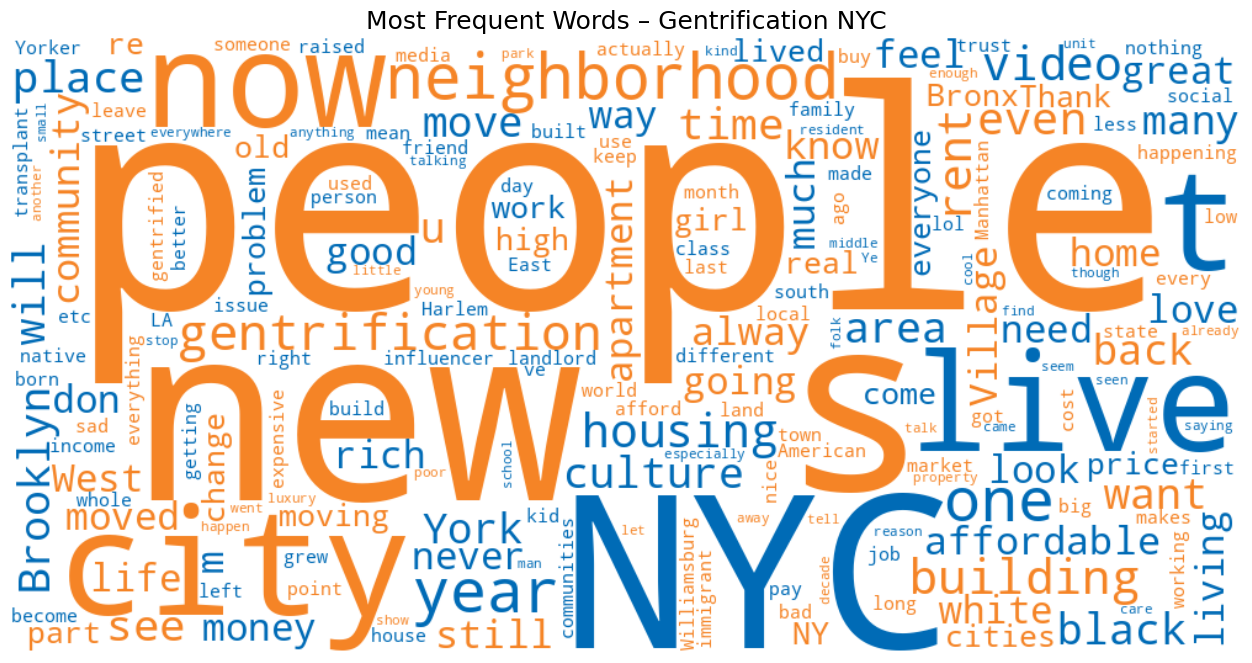

In [14]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import random

#Stopwords list
extra_stopwords = {
    "make", "think", "around", "go", "take", "making", "interesting",
    "get", "say", "said", "done", "thing", "things", "something", "really", "well", "like", "lot", "maybe"
}

stopwords = STOPWORDS.union(extra_stopwords)

def knicks_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(["#f58426", "#006bb6"])


text_all = " ".join(comments_df["text"].astype(str))

wc = WordCloud(
    width=1000,
    height=500,
    background_color="white",
    stopwords=stopwords,
    color_func=knicks_color_func,
    collocations=False
).generate(text_all)

plt.figure(figsize=(16,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words – Gentrification NYC", fontsize=18)
plt.show()


In [16]:
#Create DataFrame with the 10 most common words

from collections import Counter
import re

text_all = " ".join(comments_df["text"].astype(str)).lower()

words = re.findall(r'\b\w+\b', text_all)

# List of stopwords
from wordcloud import STOPWORDS

extra_stopwords = {
    "make", "think", "around", "go", "take", "making", "interesting",
    "get", "say", "said", "done", "thing", "things", "something", "really",
    "well", "like", "lot", "maybe","s", "think","m","want","back","t", "new","now","live",
    "don","one","re","video","even","years","see","will","many","rent","still","move","ve","always",
    "much","time","york","nyc","city"

}
all_stopwords = STOPWORDS.union(extra_stopwords)

words_filtered = [w for w in words if w not in all_stopwords]

word_counts = Counter(words_filtered)

common_words_df = pd.DataFrame(word_counts.most_common(10), columns=["Word", "Frequency"])
common_words_df


,Word,Frequency
0,people,1223
1,gentrification,412
2,housing,364
3,brooklyn,290
4,neighborhood,265
5,culture,264
6,black,263
7,affordable,241
8,community,233
9,know,227


In [17]:
#Save datasets
# Export tidy CSVs for later analysis or visualization
videos_df.to_csv("videos_search_hits.csv", index=False)
video_details_df.to_csv("video_details.csv", index=False)
comments_df.to_csv("video_comments.csv", index=False)
summary.to_csv("video_sentiment_summary.csv", index=False)

print("Saved: videos_search_hits.csv, video_details.csv, video_comments.csv, video_sentiment_summary.csv")


Saved: videos_search_hits.csv, video_details.csv, video_comments.csv, video_sentiment_summary.csv


# **2. Second Part - Factiva + NER Analysis**

After reviewing comments from civil society and examining the most common words, the next step is to run spaCy’s Named Entity Recognition (NER) on a DataFrame of Factiva news articles (one article per row). This allows us to build a person-to-person co-mention network, with the goal of identifying the key actors shaping the public debate.

For this analysis I used Rebecca Krisel's 4 lesson [Named Entity Recognition (NER) + Co‑Mention Networks ](https://github.com/rskrisel/Named-Entity-Recognition-NER-Co-Mention-Network/blob/main/NER_Live_Coding_NER_to_Network.ipynb) and [Collecting news data from Factiva and saving it in a Dataframe](https://github.com/rskrisel/factiva_dataframe/blob/main/Create_spreadsheet_Factiva_data.ipynb)

# **Data Analysis**

In [18]:
# @title



import re
import os
import pandas as pd
from bs4 import BeautifulSoup

html_code = """

HTML New York, 400 ans d'audace et de démesure, de La Nouvelle-Amsterdam à la Grosse Pomme
Radio Télévision Suisse, 07:37 AM, 27 November 2025, 2600 words, (French)
En 2025, New York commémore les 400 ans de sa fondation, bien que la date exacte de sa création fasse débat entre 1624, 1625 et 1626. Une incertitude qui reflète la complexité de l'histoire de cette ville emblématique, qui est passée d'un ...
(Document WC64715020251127elbr00002)

HTML Rana Abdelhamid officially launches campaign to replace Mamdani in Queens Assembly District 36
Times Ledger, 02:30 PM, 26 November 2025, 961 words, (English)
Rana Abdelhamid, a prominent community organizer in western Queens who currently serves as executive director of anti-violence nonprofit Malikah, officially launched her campaign to succeed Mayor-elect Zohran Mamdani in Assembly District 36...
(Document WC42242020251127elbq00005)

HTML YMCA: The Swan Song of SROs and the Birth of Modern Homelessness
Planetizen Interchange, 11:39 AM, 25 November 2025, 1417 words, Benjamin Schneider, (English)
The McBurney YMCA was a happening place in the 1970s. This single room occupancy hotel, or SRO, served as a safe haven, a single’s lounge, and a gym for gay men in New York City. Some denizens of this Chelsea hotel included members of the ...
(Document BC01284020251125elbp00002)

HTML New York’s transit system is on a comeback, but the feds loom large
City & State New York, 12:00 AM, 24 November 2025, 2014 words, Ralph Spielman, (English)
For public transit in New York, it’s the best of times.The Metropolitan Transportation Authority has a projected 2026 annual operating budget of $21.3 billion, bigger than the budgets of some U.S. states. The nation’s largest mass transit ...
(Document WC76059020251126elbo0000b)



SE 	Metro
HD 	Boston considers city-owned food stores
BY 	Katie Muchnick
WC 	827 words
PD 	22 November 2025
SN 	The Boston Globe
SC 	BSTNGB
PG 	B.1
VOL 	ISSN:0743-1791
LA 	English
CY 	© 2025 The Boston Globe. Provided by ProQuest Information and Learning. All Rights Reserved.
LP

Councilors discuss range of involvement to tacklehunger, insecuritiesBoston city councilors are mulling the idea of city-owned grocery stores, amid a greater conversation about the city’s role in fighting food insecurity.

The lengthy government shutdown only magnified the need to protect public services, such as the federal Supplemental Nutrition Assistance Program (SNAP), councilors said.

TD

“We need to explore all the options to try and figure out how we are able to deliver better food access that’s affordable, easily accessible, and culturally appropriate for our residents,’’ Councilor Liz Breadon, one of three co-sponsors of the proposal, said at a hearing Thursday.

The hearing was planned before the government shutdown, which lasted a record 43 days and sent many families dependent on SNAP benefits into crisis.

Supporters of city-owned grocery stores have pitched the idea as a way to lower food costs, given that the store wouldn’t have to factor rent or overhead costs into their prices.

Publicly owned stores can “be structured to prioritize community benefit over profit, enabling lower prices, better food access, and stronger local sourcing,’’ the councilors wrote in the hearing order.

Councilors discussed different models of city investment into grocery stores and nonprofit partners.

Boston City Council President Ruthzee Louijeune pointed to the New Jersey Food Desert Relief Act, which provides tax credits for the development and initial operating of supermarkets that open in food deserts, as a possible model. She expressed interest in expanding support for nonprofit food partners, mentioning the closure earlier this year of the Daily Table, and asked about the possibility of a feasibility study for a city-owned grocery store.

Councilor Ben Weber also highlighted Atlanta’s recent opening of a city-supported grocery store through a public-private partnership.

“During the government shutdown, there were a lot of folks that were eager to fill in gaps,’’ Weber said. “The city has limited resources, so to tap into that might make the feasibility issue easier to digest.’’

City-owned grocery stores have recently attracted more attention. Mayor-elect Zohran Mamdani has proposed setting up a network of publicly owned grocery stores across New York City on city-owned property.

In October, Louijeune said that the hearing on city-owned stores in Boston is not related to Mamdani’s platform.

Running a public grocery store is no easy feat, however.

There are several difficulties for setting up such a store, said Jack Kenslea, political director for the United Food and Commercial Workers Union. Warehousing, cold storage, and transportation are challenges that become much easier to address for large chains, rather than one or two city-owned stores.

The most successful stores, Kenslea said, are owned by the city but operated privately. This strategy allows grocery stores to access preexisting networks to solve operational problems, while cutting rent costs on city-owned land.

Another consideration is the optimal size of the store. Urban stores often see smaller carts — because customers travel on public transit or by foot to shop — which makes the volume of sales smaller, Kenslea said. But smaller stores mean less options and could limit the possibility of a loading dock to receive shipments.

Community advocates who spoke at the hearing stressed the thin margins of grocery stores, which make it hard for local shops to stay open in competition with large chains.

Darian Leta is board president of the Dorchester Food Co-Op, a community-owned store that earlier this year warned of financial troubles and implored members to shop. While Leta said the store is not going to close immediately thanks to donations and grants, operating it is “still a constant struggle.’’

“We are just not getting the shoppers,’’ she said.

Leta encouraged people to shop at community-owned stores rather than larger grocers, saying that co-ops aren’t incentivized to build stores in high-income areas and increase profit.

Continuous investment is required to improve access in a food desert, said Maxwell Chezem, assistant executive director at Maverick Landing Community Services.

“The total volume of sales is so much smaller for an urban grocer, as opposed to the Market Basket that’s right across the river,’’ Chezem said. “Essentially gentrification of the neighborhood would be necessary for it to be profitable to run a grocery store in the spaces where there currently aren’t grocery stores.’’

Louijeune said she expected more hearings on the topic to follow, featuring managers of city-owned grocery stores in other cities.

To fully address food insecurity, “political courage’’ is required from all levels of government, Councilor Enrique J. Pepén said.

“Our health care is at risk, our SNAP benefits obviously are at risk, our housing is at risk, our transportation grants are at risk,’’ he said. “But when you look at the agenda, it’s kind of all connected.’’

Katie Muchnick can be reached at katie.muchnick@globe.com.

Credit: Katie Muchnick Globe correspondent


IN
i64 : Retail/Wholesale | i641 : Food Retailing | i654 : Specialty Retailing | iretail : Retail

NS
c24 : Capacity/Facilities | ccat : Corporate/Industrial News | gcat : Political/General News | gcom : Society/Community | genv : Natural Environment | gfdsec : Food/Drinking Water Security | gfod : Food/Drink | ghea : Health | glife : Living/Lifestyle | gnutr : Nutrition | gpir : Politics/International Relations | gpol : Domestic Politics | gwelf : Welfare/Social Services

RE
boston : Boston | namz : North America | usa : United States | use : Northeast U.S. | usma : Massachusetts | usnew : New England

IPD
Boston Globe Media Partners, LLC | News | Newspapers

PUB
Boston Globe Media Partners LLC

AN
Document BSTNGB0020251122elbm000vp




SE 	En débat
HD 	La ville n’est pas à vendre: la leçon urbaine de Zohran Mamdani
WC 	815 words
PD 	21 November 2025
SN 	L'Humanité
SC 	HUMAN
PG 	23
LA 	French
CY 	Copyright 2025 l'Humanité All Rights Reserved
LP

Hadrien Bortot

Rédacteur à Nos Révolutions, élu communiste de Paris 19e

TD

«New York n’est pas à vendre», le slogan porté avec force par Zohran Mamdani, n’est pas une simple formule de campagne. Il condense la révolution urbaine en cours. Il met des mots très clairs sur le conflit politique central de notre époque: la ville doit-elle appartenir à celles et ceux qui l’habitent ou à celles et ceux qui en tirent de la rente? Et ce n’est pas anodin que cela vienne de New York: dans l’imaginaire global, c’est la ville des villes, celle du cinéma, des comics, de la mondialisation culturelle. Quand un élu new-yorkais dit «La ville n’est pas à vendre», il parle à Lagos, à Paris, à Sao Paulo, à Alger. Car, ce qu’il décrit, c’est une condition urbaine qui devient celle de l’humanité tout entière. Selon l’ONU, en 2050, près de 75% des quelque 10 milliards d’habitants attendus sur Terre vivront en ville. Autrement dit: ce qui se joue dans quelques métropoles – New York, Paris, Berlin, Barcelone – n’est pas un petit débat de centre-ville, c’est l’avant-goût du monde qui vient. On a beaucoup reproché à la gauche de «parler trop de la ville». En réalité, elle a parlé du lieu premier des affrontements de classe, de l’endroit où vont se concentrer les inégalités de logement, climatiques, d’accès aux services publics et de contrôle policier. Elle a parlé du futur. Or, ce futur urbain est déjà largement occupé par ce qu’on peut appeler le capitalisme urbain. Son mécanisme est simple: la ville devient un actif financier. On fait monter les loyers, on «requalifie» des quartiers, on privatise l’espace public, on endette les collectivités qui doivent ensuite «valoriser» leur sol. Comme l’a montré David Harvey (géographe économiste), l’urbanisation sert à absorber le surplus de capital: on construit parce qu’il faut investir, pas toujours parce que les habitants en ont besoin. Et quand cela ne suffit plus, on passe à l’accumulation par dépossession: expulsions, airbnbisation, ventes de logements sociaux, gentrification maquillée en écologie.C’est pour cela que la victoire de Mamdani n’est pas un exotisme new-yorkais. Elle prouve qu’une coalition urbaine populaire peut gagner au cœur même d’une métropole financiarisée. Et cette coalition, on la voit très bien: locataires étranglés, jeunes précaires, minorités reléguées, militant·e·s climat, syndicats, salarié·e·s ubérisé·e·s. Toutes celles et tous ceux que la ville actuelle traite comme des variables d’ajustement. Quand Mamdani proclame «La ville n’est pas à vendre», il ne fait pas de l’indignation morale. Il pose une conflictualité de classe. Il dit, en creux: «Nos vies ne sont pas à vendre.» Cette dynamique rencontre aujourd’hui une force sociale neuve: la génération Z. C’est la première à entrer dans l’âge adulte dans une ville chère, climatiquement vulnérable et très surveillée. Elle voit immédiatement que le problème est structurel. Si le logement est hors de prix, si l’espace public est quadrillé, c’est parce qu’on a fait de la ville le terrain d’accumulation du capital. Elle est connectée aux luttes du monde entier et reconnaît partout les mêmes mécanismes de dépossession. Elle est donc réceptive à des candidatures comme celle de Mamdani, qui articulent logement, antiracisme, climat et démocratie directe. Affirmer que cette victoire a une portée universelle, c’est donc dire ceci: partout où le capitalisme urbain avance, il fabrique dans le même temps les sujets qui vont le contester. La concentration de la domination dans la ville regroupe aussi celles et ceux qui la subissent. La proximité urbaine permet des alliances: collectifs de locataires, associations de quartiers populaires, réseaux antiracistes, écologistes de terrain, syndicalistes. La ville devient une fabrique d’anticapitalisme concret. Pour la gauche française, la leçon est claire. Tant que nous restons dans une posture seulement gestionnaire, nous laissons le pilotage de la ville au couple immobilier-finance. Mais si nous plaçons le logement, les services publics urbains, l’écologie populaire, l’antiracisme concret et la démocratie directe au centre, nous parlons à la population qui sera majoritaire à l’échelle mondiale. Défendre la ville populaire, ce n’est pas se couper de la France: c’est parler à la France de 2050. Le succès de Zohran Mamdani doit donc nous amener à réfléchir à la fois sur la condition urbaine et sur la mobilisation de la Gen Z. Il nous rappelle qu’une gauche qui s’attaque au capitalisme urbain lui-même – à la rente, à la dépossession, à la gentrification – peut redevenir majoritaire en ville. Et que les métropoles, loin d’être définitivement capturées, peuvent redevenir des terrains de conquête sociale et politique.


NS
gcat : Political/General News | gglobe : Global/World Issues | gpir : Politics/International Relations | gpol : Domestic Politics

RE
eecz : European Union Countries | eurz : Europe | fra : France | medz : Mediterranean Countries | namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State | weurz : Western Europe

IPD
En débat | Tribune 4400s

PUB
Société Nouvelle du Journal l'Humanité

AN
Document HUMAN00020251120elbl0008d


HTML To Chi or not to Chi?
City & State New York, 12:00 AM, 18 November 2025, 780 words, Sahalie Donaldson, (English)
A big night looms for Council Member Chi Ossé. On Wednesday evening, he’ll go before New York City Democratic Socialists of America members to pitch his case for why the organization should back his insurgent challenge against House ...
(Document WC76059020251120elbi00004)



SE 	USA
HD 	The corner of Queens that explains Zohran Mamdani’s victory in New York
BY 	Paola Nagovitch
WC 	1701 words
PD 	17 November 2025
SN 	El País - English Edition
SC 	PAISE
LA 	English
CY 	© Ediciones El Pais, S.L.
LP

Diversity Plaza, in an area known as the ‘World District’ and where almost half the population is migrant, has been at the center of the meteoric rise of the mayor-elect

TD

A section of Roosevelt Avenue in Queens is known as the “100 Languages” stretch. On this avenue, which runs through two of the most diverse neighborhoods — Jackson Heights and Elmhurst — in the most diverse borough in the United States, the accents and customs of more than 100 countries converge. Here, you might eat Colombian arepas for breakfast and Indian curry for dinner, business signs begin in one language and end in another, and on a cold November morning, the rhythm of Mexican cumbia [https://english.elpais.com/culture/2025-10-26/the-dynasties-that-keep-cumbia-alive-in-a-corner-of-mexico-the-people-of-monterrey-are-reinventing-the-idea-of-colombia.html] blaring from a food truck parked near the 74th Street subway station blends with the conversation of a Nepalese couple strolling along the sidewalk.

Two weeks have passed since Democrat Zohran Mamdani’s historic victory [https://english.elpais.com/usa/2025-11-05/young-socialist-zohran-mamdani-wins-over-new-york-with-his-promise-of-change-in-the-face-of-trump.html] in the New York City mayoral race. Posters bearing the mayor-elect’s face still hang in the restaurants and shops surrounding Diversity Plaza, where Roosevelt Avenue intersects Broadway in the so-called “World District.” From the window of one of these shops, next to a poster reading “Bangladeshi Americans for Mamdani,” a salesman, speaking a few words in Bengali and some English, recalls that Mamdani was here just a few days before the November 4 election.

It was the night of October 30. The 34-year-old Democratic socialist arrived at Diversity Plaza around midnight, after chatting with taxi drivers at LaGuardia Airport and visiting night-shift medical staff at an Elmhurst hospital. He had dinner at one of his favorite kebab shops on the corner of the square before holding a press conference surrounded by his supporters.

Mamdani made areas like this one in Queens a central focus of his mayoral campaign. Not only because he lives in the borough, but also because he understands that many of the issues that have dominated his career — diversity and immigrant communities, the working class, and “affordability” in a city with a skyrocketing cost of living — converge in neighborhoods like Jackson Heights, Elmhurst, and Corona.

Just hours after his election victory, which he celebrated in Brooklyn, the politician was back in Queens. He met with members of his transition team under the Unisphere, a 32-meter-tall stainless-steel globe built for the 1964 World’s Fair [https://english.elpais.com/international/2025-04-12/the-event-that-heralded-a-globalized-world-in-the-19th-century-and-is-still-going-strong.html], which was held in the Corona neighborhood. Today, the structure is one of Queens’ most recognizable symbols. Mamdani said he chose the location for his first press conference as mayor-elect because it symbolized his pride in the borough. Afterward, he returned to Jackson Heights for lunch at a Nepali restaurant with New York Congresswoman Alexandria Ocasio-Cortez [https://english.elpais.com/usa/elections/2024-04-22/the-use-of-spanish-online-soars-among-us-politicians-in-election-year.html].

When he takes office on January 1, Mamdani — who was born in Uganda to Indian parents and has been a U.S. citizen since 2018 — will break more than one precedent. He will be the first mayor of New York City to live in Queens, the first to have previously represented the borough in public office (he was a member of the State Assembly in Albany), and the first Muslim mayor in the city’s history. He will also be the first immigrant to hold the position in nearly half a century.

For Shekar Krishnan, a member of the New York City Council, whose district includes three of the neighborhoods crossed by Roosevelt Avenue, it’s impossible to understand Mamdani’s victory without first understanding the cultural richness of Queens. “And you can’t tell the story of Queens without telling the story of Jackson Heights,” he points out by phone from City Hall.

In New York City, about 35% of its 8.5 million residents are immigrants. However, in Queens that percentage rises to almost 50% of a total of 2.3 million. And in neighborhoods like Jackson Heights, the immigrant population exceeds 60%. Mamdani won here, as well as in parts of Elmhurst and Corona, two other neighborhoods where more than half the population is immigrant.

Premises on Broadway in Jackson Heights. [https://images.english.elpais.com/resizer/v2/KBJGCNKRPJARNIK6VDEAUARSDI.jpg?auth=a4ae68c8734a1789637d57257b36ce2f4826a8a2dacf977c0edac8a0a13d4cc0]

More than 300 languages are spoken in the borough, and a third of them coexist on Roosevelt Avenue, according to the Alliance for Endangered Languages. In a stretch of about 20 blocks between Jackson Heights, Elmhurst, and Corona, you can travel the world without leaving New York City: you’ll hear Bengali, Nepali, Spanish, Punjabi, Tibetan, Urdu, Greek…

Krishnan, who has known Mamdani for years, says of his victory, “[It was] a statement of our values as a city [https://english.elpais.com/opinion/2025-11-06/first-blow-to-trump-at-the-polls.html], an affirmation of the importance of immigrant communities.” “His election illustrates how New Yorkers are united both in their desire for a more affordable city and in their desire for us to embrace and celebrate our diversity,” he says.

Krishnan was the first Indian-American elected to the New York City Council in history. He and Mamdani were both present at a taxi drivers’ strike in 2021, during which the now mayor-elect participated in a 15-day hunger strike alongside hundreds of other drivers protesting the debt they had accumulated after being subjected to predatory lending practices to pay for their licenses. Both were arrested during the protests, which culminated when the city agreed to a program that forgave millions of dollars in debt.

“I was drawn to that fight with Zohran precisely because we were fighting for our community,” Krishnan recalls. Many of those taxi drivers were immigrants and residents of Queens, and they joined Mamdani’s campaign four years later.

Trump’s birthplace

Now, as mayor of New York City, Mamdani will lead the Democratic resistance against Donald Trump. The Republican president has threatened to cut federal funding to the city in response to the socialist’s victory and has considered sending National Guard troops [https://english.elpais.com/usa/2025-10-07/trumps-battle-with-democratic-cities-intensifies-as-national-guard-arrives-in-chicago.html], as he has already done in other Democratic cities like Los Angeles, to enforce his immigration agenda. Mamdani, for his part, has made it clear that he will not be intimidated. In his victory speech on election night, he addressed the president directly, asking him to turn up the volume on his television to make sure he could hear him, and declared: “New York City will remain a city of immigrants, built by immigrants, and powered by immigrants. And, starting tonight, led by an immigrant.”

Theirs will be the battle of the two Queens, because the Queens of Mamdani or Krishnan — the migrant heart of the city — is also Trump’s birthplace. In fact, the president’s ties to the district go back to the beginning of the 20th century. His paternal grandparents, German immigrants, settled in Woodhaven, Queens, in the early 1900s. The president was born in the Jamaica neighborhood and grew up in the adjacent, affluent area of Jamaica Estates, just over six miles away but worlds apart from places like Jackson Heights or Elmhurst, which by then were already known for their growing diversity.

In the 2024 presidential election, the Republican candidate garnered significant support in both neighborhoods, as well as in other areas of Queens with large immigrant populations. Although the Democratic candidate, Kamala Harris [https://english.elpais.com/usa/2025-09-25/kamala-harris-trump-has-given-netanyahu-a-blank-check-to-do-whatever-he-wants.html], won New York State, she did so by a considerably smaller margin than Joe Biden had in 2020. In Elmhurst and Corona, support for the Democrats then declined by 40%.

A year later, the vast majority of those same areas voted overwhelmingly for Mamdani. Although independent candidate and former New York Governor Andrew Cuomo — whom the president endorsed just days before the election — generally performed better among Trump voters, Mamdani managed to win back many predominantly immigrant areas in Queens.

For Jason Antos, the borough’s historian, it’s not a difficult paradox to understand. “It’s very Queens,” he says. The director of the Corona-based Queens Historical Society also argues that “many of the reasons people voted for Trump are the same reasons they voted for Mamdani,” starting with the high cost of living.

Antos explains that the borough has always been a destination for migrants, even since colonial times, when Europeans of various nationalities arrived attracted by the cheap land, which was also ideal for agriculture. Today, the borough’s diversity, in which “every country, even the smallest, is represented to some degree,” is due in part to the fact that it remained for years a more affordable place to live than Manhattan or Brooklyn. Many migrant communities displaced by the city’s gentrification have ended up in neighborhoods like Jackson Heights.

This reality, however, has been changing “over the last 20 years,” according to the historian. Rents and the cost of living have steadily increased in Queens, as they have in the rest of New York City. This issue was a central focus of both Trump’s 2024 campaign and Mamdani’s 2025 campaign. It was also a key factor in both of their victories.

State Assemblywoman Jessica González-Rojas, whose district includes Jackson Heights, says Mamdani won in these predominantly immigrant areas that supported Trump because he understood voters’ concerns. “Zohran really listened to the community, especially after the 2024 election. What he heard from them was that they were fed up with the politics of the past and were looking for something different. And the issue of affordability was something that really resonated,” she says by phone from Albany.

González-Rojas arrived at the State Assembly in 2021 alongside Mamdani, becoming the first Latina, of Puerto Rican and Paraguayan descent, elected to represent her district. She has known the mayor-elect for years and supported his candidacy for the City Council. She is confident that Mamdani’s administration will reflect the contradictions of neighborhoods like Jackson Heights, which can ultimately be seen as a mirror of the United States: an increasingly immigrant-based country struggling to make ends meet and seeking an alternative to “business as usual.”

Vendors at a business in Diversity Plaza, New York [https://images.english.elpais.com/resizer/v2/B7C4BQRL45E3TLVYOKXY2CJCJI.jpg?auth=b0d84c5732ae13c3c89607a6cffe827c451d55fcd1beee81fb041b2cefcfece8]

Back in Diversity Plaza, from his shop counter, the Bengali vendor smiles and recounts how he and his son voted for Mamdani. The reason? “Because change is needed,” he manages to reply.

Businesses in Diversity Plaza, Queens, on November 11. [https://images.english.elpais.com/resizer/v2/HJPBKKPKGNESLAIKG7RB47ITNY.jpg?auth=ae98021d8f488aedf78f00f7dad05ac31ebf74aa93a09188a9632f9fb646ff59]


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Prisa Media, S.A.U.

AN
Document PAISE00020251117elbh0008d




HD 	City Scoop: JFK’s grandson to run for Congress, and other top stories across NYC - Washington Square News
WC 	2666 words
PD 	17 November 2025
SN 	U-Wire
SC 	UWIR
LA 	English
CY 	© 2025, M2 Communications. All rights reserved.
LP

New York University ; New York, NY - news

content"class="skip-to-content">Skip to Content

TD

About

Masthead

Join

Submit

Advertise

Donate

More

Facebook

Threads

Instagram

X

Spotify

LinkedIn

YouTube

Reddit

Email Signup

Search this site

Submit Search

Washington Square News

News

Features

City

University

War in Gaza

Trump Administration

Beyond NYU

Abroad

Opinion

Editorial

Guest Essays

Letters from the Editor

Letters to the Editor

Off-Third

Off Topic

Staff Rants

Trump Administration

Sports

Weekly Recap

In the Huddle

Out of Bounds

Culture

Beauty & Style

Food

Identity & Equity

Ranked

New York Fashion Week

Arts

Books

Film

Music

Performing Arts

Visual Arts

Magazine

Multimedia

Cartoons

Photo Column

Photo Essays

Videos

Sponsored

More

City Scoop: JFK’s grandson to run for Congress, and other top stories across NYCSteinhardt researchers say schools should stop separating English learnersLawmakers rally to tax the rich in Union SquareNYU revamps Courant InstituteTensions flare as College Dems claim Reps hijacked club meetingNYU Langone fired a nurse battling cancer. Her story isn’t the only one.Inside one of NYU’s prominent antisemitism consultantsNYU Grossman rescinds program acceptances after losing federal grantAt least 2 NYU affiliates involved in organizations that promote anti-trans practices‘A chilling effect’: Conduct guidelines cast shadow of concern over facultyCity Scoop: JFK’s grandson to run for Congress, and other top stories across NYCLawmakers rally to tax the rich in Union SquareCity Scoop: Flights canceled at major airports, and other top stories across NYC‘Hope and potential’: What Election Day looks like on campusYour 2025 ballot, broken downNYU revamps Courant InstituteTensions flare as College Dems claim Reps hijacked club meetingSGA urges stronger safeguards for Black studentsNYU ‘recovered’ from research funding cutsFaculty win right to legal aid in discrimination investigationsStudents and faculty commence ‘solidarity fast’ in BobstStudents join hundreds in citywide Oct. 7 protestThousands protest Gaza flotilla interception under Washington Square ArchProtests persist across Tisch, law school graduationsStudents picket outside Vanderbilt Hall, demand NYU Law cut anti-protest contractFundraising for visa-related legal fees now a ‘moot’ issue, NYU saysStudents rally for ‘no compliance’ with Trump administration in Washington Square ParkNYU has a ‘moral obligation’ to protect noncitizen students, immigration experts sayProfessors call for sanctuary campus with off-site classesStudents hold cross-campus march for divestment, noncitizen supportBeyond NYU: Turning life’s errors into humorBeyond NYU: Leaving Caltech for a career in journalismBeyond NYU: When 5 music majors combine forces for a ‘good time’Beyond NYU: From research at Courant to taking on tech giantsBeyond NYU: For Ocean Vuong, ‘literature is always political’Off Topic: Having a boyfriend isn’t embarrassing, but Vogue’s new direction isOff Topic: The teenage gambling epidemic needs an interventionOff Topic: #SkinnyTok is anything but healthyOff Topic: The First Amendment stops at the Pentagon‘s gatesOpinion: NYC can’t handle the rainEditorial: The work has just begunEditorial: Students deserve clarity from NYU leadershipEditorial: Who to vote for in the NYC primariesEditorial: Linda Mills, where are you?Editorial: Why NYU should, but probably won’t, follow HarvardGuest Essay: When it comes to contract faculty, NYU has no ‘peers’Guest Essay: Mamdani’s win strengthens our fight for gender equalityGuest Essay: NYU must reject Trump’s coercive ‘compact’Guest Essay: Unity is the only way out of Trump’s ‘compact’Guest Essay: On this grim anniversary, we must turn to Jewish-Arab organizationsLetter from the Editor: My goodbye to WSNLetter from the Editor: In the age of Trump, student journalism is more vital than ever.Letter from the Editor: A reflection on WSN’s missionLetter from the Editor: Welcome to the Washington Square NewsLetter from the editor: On reflectionLetter to the Editor: 94 LS faculty members approve statement to WSNLetter to the Editor: Silver School dean on the case for a tuition-free social work educationLetter to the Editor: Wasserman Center director on the Handshake job search platformLetter to the Editor: CWS director on suicide response and mental health resourcesLetter to the Editor: NYU remains committed to NYU Tel AvivOff-Third: Performative males are giving real feminists (like me) a bad rapOff-Third: The Third North basement’s AC problem violates free speechOff-Third: WSN endorses Anna Wintour for NYU spokespersonOff-Third: Mills to star in Broadway bio-musical, tickets start at $1099Off-Third: NYU released their shortlist for consultants on ‘institutional restraint.’ You won’t believe who’s on it.Off Topic: Having a boyfriend isn’t embarrassing, but Vogue’s new direction isOff Topic: The teenage gambling epidemic needs an interventionOff Topic: #SkinnyTok is anything but healthyOff Topic: Sports can’t stay fair when betting drives the gameOff Topic: The AI regulation movement must fight fire with fireStaff Rants: Post-election feelingsStaff Rants: Springing in and out of springStaff Rants: New beginnings or old complaints?Staff Rants: Holiday OverloadStaff Rants: Spooky seasonMen’s basketball snatches thrilling wins, cross country excels and moreOut of Bounds: Major sports news out of Los Angeles, Madrid and SydneyNYU men’s soccer looks back on a tough seasonIn the Huddle: Josephine Dziedzic on running track & field and cross country at NYUA bittersweet Senior Day for NYU’s soccer teamsMen’s basketball snatches thrilling wins, cross country excels and moreMen’s and women’s basketball open seasons, wrestling clinches a narrow win and other newsCross country earns back-to-back UAA titles, volleyball hosts senior night and other newsWomen’s volleyball wins twice at Tear It Up, men’s and women’s cross country in action and other newsGolf closes out fall season, volleyball competes in UAA Round Robin #2 and other newsIn the Huddle: Josephine Dziedzic on running track & field and cross country at NYUIn the Huddle: Sonia Neighbors on joining the NYU women’s soccer teamIn the Huddle: Volleyball player Emerson Evans on NYU’s historic seasonIn the Huddle: Aurora Aschettino on her fencing careerIn the Huddle: A conversation with two-time national swimmer of the year Kaley McIntyreOut of Bounds: Major sports news out of Los Angeles, Madrid and SydneyOut of Bounds: Major sports news out of Australia, the U.K. and Washington, D.C.Out of Bounds: Major sports news out of Los Angeles, Madrid and ParisOut of Bounds: Major sports news out of London, Los Angeles and ParisOut of Bounds: Major sports news out of China, Italy and the U.K.New eats near NYU: This taco spot aims to meet a ‘higher standard’‘The New York Sari’ brings a meaningful depiction of the garment to NYC#NYCSampleSale: The door to discounted luxuryBehind the scenes, student costume designers turn fabrics into personalitySNAP cuts leave students in need — here’s where to find and give support‘The New York Sari’ brings a meaningful depiction of the garment to NYC#NYCSampleSale: The door to discounted luxuryBehind the scenes, student costume designers turn fabrics into personality5 ways to style your tights as the weather gets chilly6 ways to style a cardigan this fallNew eats near NYU: This taco spot aims to meet a ‘higher standard’SNAP cuts leave students in need — here’s where to find and give supportDitch Big Food for these local restaurantsNew eats near NYU: What to eat at Time Out Market Union SquareNew eats near NYU: A ‘nous’ bistro rethinks French culinary conventionsSNAP cuts leave students in need — here’s where to find and give support‘We’ve been through this before’: Why LGBTQ+ history mattersHow an NYU alum is making space for Black journalists’A sign of hope’: What the mayoral election means for NYU studentsWhen skeletons come out of the closet and onto the streetRanked: Fan-favorite Halloween candyRanked: The best Bobst floors for studyingRanked: Mooncake flavors we’re mooning overRanked: Manhattan’s AMC theatersRanked: NYU core requirementsWSN at New York Fashion WeekFrederick Anderson takes you on vacation with his newest NYFW collectionShao New York invites the past into the future at NYFWAre you in heaven? Alexander King Chen’s solo show is a reflection of the inner selfViator Felis showcases clothing fit for unconventional trailblazersBooks beyond Bobst: A feminist thriller, a tale of art forgery and moreStaff recs: HopecoreReview: ‘Everyday Rebellions’ creates unlikely comparisonsColleen Hoover is killing book-to-movie adaptationsReview: Oklou’s deluxe album punctuates her previous successBooks beyond Bobst: A feminist thriller, a tale of art forgery and moreClassics that your syllabus forgotBooks beyond Bobst: A collegiate love triangle, jump-scares and moreYour next read, based on your NYU schoolReview: ‘We Love You, Bunny’ questions who owns the narrativeColleen Hoover is killing book-to-movie adaptationsReview: ‘Ballad of a Small Player’ fails to up the ante‘The Land’ reckons with powerlessnessReview: Art speaks where words can’t in ‘Sentimental Value’Review: ‘Bugonia’ boldly denounces the hive mindReview: Oklou’s deluxe album punctuates her previous successReview: Rosalía ascends to divine musicianship on ‘LUX’Q&A: NYU sophomore dives deep into ‘optimistic’ EPReview: Florence + the Machine emerges from trauma on ‘Everybody Scream’Review: Alice Phoebe Lou chooses simple intimacy on ‘Oblivion’Q&A: Center for Ballet visiting scholar on ballet’s evolutionQ&A: Stella Adler alumni on forming their own theater companyRanked: Broadway’s leading ladiesQ&A: Reality TV makes good theaterTisch New Theatre’s cabaret for changeReview: ‘Everyday Rebellions’ creates unlikely comparisonsReview: MoMA retrospective expands art’s boundariesTisch alum redefines Black transgender artNew Pokémon game gets an A for effort and a Z for enjoymentThe Met’s new ancient Egyptian exhibition revives artistic traditionThe Beverage Issue | Under the Arch MagazineThe Career Issue | Under the Arch MagazineThe Commuter Issue | Under the Arch MagazineWelcome home, class of 2029The Romance Issue | Under the Arch MagazineOn the Street: Comfort placesBeverage BundlingCartoon: The ’enlightened‘ centristIn photos: Election DayIn photos: The New York City MarathonCartoon: The ’enlightened‘ centristCartoon: The hard-hitting questions of the NYC mayoral debateCartoon: An average conversation between Stern brosCartoon: The commuter lifeNYU Dining Halls: Farm-to-Table Eats!On the Street: Comfort placesOn the Street: HalloweenOn the Street: Passage of timeOn the Street: SilhouettesOn the Street: New York CityIn photos: Election DayIn photos: The New York City MarathonMamdani is ready to be called up off the benchThe community at the heart of New York Comic ConArt under the cityBeverage BundlingCanines in costumes return to Washington Square ParkWhat‘s your dream job?Echo Picone on balancing studies and stardomWhat‘s for sale in Washington Square Park?SPONSORED: Winter break escape: A road trip from NYC to Washington, D.C.

Open Navigation Menu

News

Culture

Arts

Abroad

Opinion

Features

Sports

Magazine

Multimedia

About

Submit to WSN

Subscribe to newsletter

Advertise

More

Washington Square News

Open Search Bar

Search this site

Submit Search

Open Navigation Menu

News

Culture

Arts

Abroad

Opinion

Features

Sports

Magazine

Multimedia

About

Submit to WSN

Subscribe to newsletter

Advertise

More

Washington Square News

Open Search Bar

Search this site

Submit Search

LATEST

Books beyond Bobst: A feminist thriller, a tale of art forgery and more Siobhán Minerva, Natalie Deoragh, Leena Ahmed and Alexa Donovan • November 17, 2025City Scoop: JFK’s grandson to run for Congress, and other top stories across NYC Natalie Deoragh, Deputy News Editor • November 17, 2025New eats near NYU: This taco spot aims to meet a ‘higher standard’ Ayda McClellan, Contributing Writer • November 17, 2025Off Topic: Having a boyfriend isn’t embarrassing, but Vogue’s new direction is Maggie Turner, Opinion Editor • November 17, 2025Staff recs: Hopecore Dani Biondi, Siobhán Minerva, Skylar Boilard, Leo Field, Amelia Knust and Maya Santiago • November 17, 2025

EDITOR'S PICKS

WSN at New York Fashion WeekNYU Grossman rescinds program acceptances after losing federal grantAt least 2 NYU affiliates involved in organizations that promote anti-trans practices‘A chilling effect’: Conduct guidelines cast shadow of concern over faculty

City Scoop: JFK’s grandson to run for Congress, and other top stories across NYC

City Scoop is WSN’s weekly column reviewing major New York City news across all five boroughs.

Natalie Deoragh, Deputy News Editor

November 17, 2025

Maryam Lootah (Maryam Lootah for WSN)

JFK’s grandson to run for U.S. House seat

Jack Schlossberg, grandson of former President John F. Kennedy, announced on Instagram that he will run for New York City’s 12th congressional district in the 2026 U.S. House of Representatives election. If successful, he will replace Rep. Jerry Nadler, who will not run for reelection next year after three decades of service.

The 32-year-old Democrat, known for his social media political commentary, has gained over 800,000 TikTok and 170,000 X followers for his videos ranging from policy explanations to criticism of his cousin Robert F. Kennedy Jr., currently U.S. Secretary of Health and Human Services and a longtime vaccine skeptic.

Over the summer, Schlossberg announced his support for then-mayoral candidate Zohran Mamdani. The two politicians, who are both millennials with a prominent social media presence, have publicly urged the Democratic Party to take more aggressive stances against President Donald Trump.

“If Zohran Mamdani and I have anything in common, it’s that we are both trying to be authentic versions of ourselves and meet people where they are and communicate with people in New York City and be present and show up for people,” Schlossberg said. “The only race I know how to run is my own.”

Schlossberg worked as a staff assistant at the U.S. Department of State before joining Vogue in 2024 as a political correspondent during the presidential election. New York City’s 12th congressional district, which encompasses the Upper East Side, Upper West Side and some of Midtown, is made up of mostly Democratic voters and one of the country’s wealthiest neighborhoods, with a median household income of $147,255.

City Council to turn Queens industrial lots into over 14,000 homes

The New York City Council unanimously approved a plan to turn an industrial area in Queens into nearly 15,000 apartments on Wednesday, aiming to address the city’s growing affordable housing crisis.

OneLIC will include 4,350 income-restricted units and plans to rezone 54 blocks of Long Island City, which currently houses various warehouses and parking lots. The plan requires $650 million for projects such as building a new waterfront esplanade, upgrading sewers and repairing NYCHA Queensbridge Houses.

The plan comes as New York City’s vacancy rate sits at 1.4%, making housing a top issue during the mayoral election. While many community members support the plan, others, including the Western Queens Community Land Trust’s board, worry about gentrification.

“We wish the plan had been focused from the get-go on true infrastructure and affordability needs, driven by data and community input — rather than originating as a rezoning,” said Jenny Dubnau, co-chair of the trust’s board.

ICE scouts Staten Island site to hold immigrant detainees

The Trump administration surveyed a Coast Guard facility in Staten Island as a potential site to hold people detained by U.S. Immigration and Customs Enforcement officers.

It is unclear whether the agents have determined that the Coast Guard facility, Fort Wadsworth, is an acceptable site to hold detainees, or if they are continuing to search for other locations.

“The site is not suitable to house migrants,” Rep. Nicole Malliotakis said. “We’ve made this very clear, both publicly and privately, and we do not anticipate any such plans.”

Fort Wadsworth, which overlooks the New York Bay, is one of the oldest military sites in the United States and only a 30-minute drive from 26 Federal Plaza, where most immigrants in the city are processed.

If the base is selected, many immigrants from the city will no longer be transported to jails or detention facilities in New Jersey, upstate New York or Pennsylvania. Instead, the increased housing would allow ICE to hold detainees in the city.

In 2023, the Biden administration, Mayor Eric Adams and Gov. Kathy Hochul also explored the site as a shelter for asylum seekers entering through New York City, but the plan never came to fruition.

Contact Natalie Deoragh at

((Distributed for UWIRE via M2 Communications (www.m2.co.uk [http://www.m2.co.uk]))


CO
newyuv : New York University | uscong : United States Congress

NS
gcat : Political/General News | gedu : Education | gfas : Fashion | glife : Living/Lifestyle | gspo : Sports | guni : University/College | gvoll : Volleyball | ncat : Content Types | nfact : Factiva Filters | nfce : C&E Exclusion Filter | nrgn : Routine General News

RE
namz : North America | nyc : New York City | usa : United States | usca : California | usdc : Washington DC | use : Northeast U.S. | usny : New York State | uss : Southern U.S. | usw : Western U.S. | uswa : Washington State

PUB
Normans Media Ltd

AN
Document UWIR000020251117elbh000wg


HTML City Scoop: JFK’s grandson to run for Congress, and other top stories across NYC
Washington Square News, 07:00 AM, 17 November 2025, 723 words, Natalie Deoragh, (English)
New eats near NYU: This new taco spot aims to meet a ‘higher standard’City Scoop is WSN’s weekly column reviewing major New York City news across all five boroughs.
(Document WC49887020251117elbh00002)



HD 	Students hopeful Democrats’ wins in off-year elections reflect national Trump backlash – The GW Hatchet
WC 	1548 words
PD 	17 November 2025
SN 	U-Wire
SC 	UWIR
LA 	English
CY 	© 2025, M2 Communications. All rights reserved.
LP

Donation Button

George Washington University ; Washington, DC - news

TD

By Brady Eagan

Jessica Rowe

content"class="skip-to-content">Skip to Content

Advertise

Merch

Donate

Contact

About

Join

More

Facebook

Instagram

X

Tiktok

YouTube

The GW Hatchet

Open Search Bar

Search this site

Submit Search

AN INDEPENDENT STUDENT NEWSPAPER SERVING THE GW COMMUNITY SINCE 1904

News

Administration

Academics

Events

Health & Research

Metro

Student Government

Student Life

Tracking FY2026 cuts

Culture

Ask Annie

Carly‘s Corner

Features

Reviews

Sports

Basketball Guide 2025

Column

Courtside

Features

Opinions

Columns

Perspectives

Editorial Board

Letters to the Editor

Op-eds

Quick Takes

Multimedia

Photo

Video

Podcasts

Getting to the Bottom of It

More

Open Navigation Menu

The GW Hatchet

Advertise

Merch

Donate

Contact

About

Join

More

The GW Hatchet

Open Search Bar

Search this site

Submit Search

Open Navigation Menu

News

Administration

Academics

Events

Health & Research

Metro

Student Life

Student Government

Opinions

Columns

Perspectives

Op-eds

Editorial Board

Letters to the Editor

Quick Takes

Culture

Ask Annie

Features

Reviews

Sports

Courtside

Features

Podcasts

Getting to the Bottom of It

Photo

Video

About Us

Contact Us

Join The Hatchet

Donate

More

The GW Hatchet

Open Search Bar

Search this site

Submit Search

Donation Button

The Hatchet is celebrating

its 120th birthday

DONATE TODAY

NEWSLETTER

Sign up for our twice-weekly newsletter!

Are you human?

Yes!

Email address:

Leave this field empty if you're human:

LATEST NEWS

GW Hospital CEO joins MFA board in FY2024 amid leadership restructuring: tax formsBy Arushi Agarwal and Gianna Jakubowski • November 17, 2025GW, MFA dual trustees left one post in February during governance shift: officialsBy Hannah Marr, Managing Editor • November 17, 2025Student groups rebuke RFK Jr.’s controversial policies ahead of GW talkBy Ryan Saenz, Assistant News Editor • November 17, 2025Crime log: Student blackmailed on dating appBy Bryson Kloesel, Contributing News Editor • November 17, 2025Campus Safety Advisory Committee recommends threat assessment, bystander training: reportBy Bryson Kloesel, Contributing News Editor • November 17, 2025

Students hopeful Democrats‘ wins in off-year elections reflect national Trump backlash

By Brady Eagan and Jessica Rowe

November 17, 2025

Courtesy of Quinn van Mourik-Rudnick Virginia Gov-Elect Abigail Spanberger speaks at a rally on November 2nd.

Students from New Jersey, New York City, Virginia and California said the results of recent elections in their home states signal a nationwide rebuke of President Donald Trump’s second term in office.

Multiple Democratic candidates, including Virginia Governor-elect Abigail Spanberger, New Jersey Governor-elect Mikie Sherrill and New York City Mayor-elect Zohran Mamdani, took home large margins against Republican and independent challengers this month, while a Democratic-backed California ballot initiative to redraw the state’s House of Representatives map won by more than seven million votes. Students from the three states and New York City said the elections signal voters’ dissatisfaction 10 months into Trump’s second term as the president’s approval rating stooped to its lowest point last week since he reentered office.

In New Jersey, Sherrill won against former Republican Assemblyman Jack Ciattarelli, earning about 1.8 million votes compared to Ciattarelli‘s 1.4 million votes.

Erin Coughlin, a sophomore studying political science from New Jersey, said her main priority in the election was affordability. She said with rising housing prices and the cost of living in the state, she looked for a candidate whose policies would allow her to eventually buy a house and live in her home state sometime after she graduates.

Polling from the election showed that Americans were mostly concerned about the economy as an affordability crisis has sparked the president to plan a nationwide tour emphasizing his proposals to improve the cost of living in America.

She said education was a “pertinent” issue she looked at during the election cycle, hoping for increased funding and resources for New Jersey public schools, universities and community colleges.

“I was definitely very surprised at how decisive her victory was,” Coughlin said of Sherrill. “But I wouldn’t say I was entirely shocked that she came out the winner.”

John Tober, a sophomore and the director of political affairs for GW College Republicans, said he helped Ciattarelli’s campaign throughout the summer and the fall, including canvassing in the state and phone banking. College Republicans organized phone banking for Ciattarelli in the weeks leading up to the election.

Tober said affordability was his main concern in the election, something he said fellow New Jerseyans agreed on when he was out canvassing for Ciattarelli.

He said many New Jersey residents prefer to elect a moderate Republican governor, like Ciattarelli or Chris Christie — the state’s governor from 2010 to 2018. He added that Sherrill’s win will keep Democrats in charge of the state for 12 years, limiting the partisan diversity of leadership in the governor‘s office.

“You need to have some change, a little diversity in how you handle issues because one party isn‘t going to solve everything perfectly, and that‘s why we have different parties in power all the time, on a state level, on a federal level,” Tober said. “So I just worry about those years of one-party rule, and I think the people of New Jersey are going to suffer for that.”

In Virginia, Spanberger, a former Democratic member of the House of Representatives, took home more than 57 percent of the vote in a race pollsters expected her to win against the commonwealth’s Republican Lt. Gov. Winsome Earle-Sears.

Logan Olszewski, a junior and chief of staff for the GW College Democrats, said the group organized four canvassing trips to Virginia for Spanberger, with a total of about 150 students showing up over four weekends.

He said College Democrats feels the growing student participation in canvassing signals heightened student interest in civic involvement and gives him hope that there will be greater civic engagement from the GW student body in the future.

“I think it gave me, personally, and a lot of people on our board and our membership, a lot of hope that things can get better,” he said.

Luke Davila, a sophomore from Virginia majoring in political science, attributed the Democratic wins to a general frustration with the Trump administration’s economic policies. He said affordability was the most crucial issue of the election for him because of price increases in basic necessities, which he believes Democrats can best address at the state level.

“I think Americans are having to go without basic necessities more and more,” Davila said in a text message. “Ever since COVID, the world as a whole has had a tough time recovering, and the US is no exception.”

He said the Democratic Party has strong potential to achieve sweeping wins in the 2026 midterms and potentially even the 2028 presidential election, as long as the Democrats who prevailed earlier this month make good on their campaign promises once in office, and the American people remain unhappy with how Trump is handling the economy.

“If the Trump Administration keeps frustrating the American people, then I see excellent results coming for the Democrats in the future,” Davila said.

Mamdani, the Democratic Socialist candidate running as a Democrat, won 50.4 percent of the votes in New York City, beating Republican candidate Curtis Sliwa and former Governor Andrew Cuomo — who ran as an independent after losing the Democratic primary.

Sofia Alves, a first-year international affairs student from Manhattan, said gentrification and housing costs were crucial issues for her this election. She said she’s seen families have to leave their homes around her neighborhood due to affordability issues, including Harlem, a neighborhood near her.

She said she saw Mamdani’s victory as a sign that candidates who prioritize basic needs and social equity can succeed.

“Honestly, this was kind of a big signal of hope,” Alves said. “There was a huge blue wave.”

In California, voters overwhelmingly backed a ballot initiative that would redraw the state’s Congressional districts, aiming to help Democrats gain five seats in the House — a response to redistricting efforts in red states intended to favor Republicans.

Sarah Gohres, a junior majoring in political communications from the Bay Area, said the widespread approval for the proposition in California showed solidarity in the leadership and decision making of the Democratic Party, at a time when she said the party has been “struggling” to have a central platform.

“I think opposition to Trump has been struggling because all Democrats have been running on for the past decade is anti-Trump instead of having their own platform,” Gohres said in a text message. “If you ask 10 people what the Democrats want policy-wise you’d get 10 different answers.”

She said Proposition 50 was the first “concrete offensive” move Democrats made against the Trump administration since the start of his second term amid a wave of redistricting efforts in Republican states.

“Texas and other red states drew blatantly partisan maps, and they were going to see how far they could go without pushback,” Gohres said. “California also choosing to hold an election gave credibility to redraw the maps in a more democratic manner, by actually giving voters the choice.”

((Distributed for UWIRE via M2 Communications (www.m2.co.uk [http://www.m2.co.uk]))


CO
grgwhu : George Washington University

NS
gcat : Political/General News | gedu : Education | gpir : Politics/International Relations | gpol : Domestic Politics | guni : University/College | gvote : Elections

RE
namz : North America | nyc : New York City | usa : United States | usca : California | usdc : Washington DC | use : Northeast U.S. | usnj : New Jersey | usny : New York State | uss : Southern U.S. | usva : Virginia | usw : Western U.S.

PUB
Normans Media Ltd

AN
Document UWIR000020251117elbh000ng




SE 	CE Noticias Financieras English
HD 	The Queens corner that explains Zohran Mamdani's New York victory
WC 	1669 words
PD 	16 November 2025
SN 	CE NoticiasFinancieras
SC 	NFINCE
LA 	English
CY 	Copyright © Content Engine LLC
LP

A stretch of Roosevelt Avenue in Queens is known as the Avenue of 100 Languages. On this road, which crosses two of the most diverse neighborhoods - Jackson Heights and Elmhurst - in the most diverse county in the United States, the accents and customs of more than a hundred countries converge. Here, Colombian arepas are eaten for breakfast and Indian curries for dinner, business signs begin in one language and end in another, and on a cold November morning, the rhythm of a Mexican cumbia playing over the loudspeaker of a food truck parked near the 74th Street subway stop mixes with the conversation of a Nepalese couple strolling down the sidewalk.

TD

It's been a week since Democrat Zohran Mamdani's historic victory for mayor of New York. In the restaurants and stores surrounding the so-called Diversity Plaza, where Roosevelt Avenue intersects Broadway in the so-called "district of the world," posters with the mayor-elect's face still hang. From the window of one of those stores, next to a poster of "Bangladeshi Americans for Mamdani", between a few words in Bengali and some English, a salesman recalls that Mamdani was here a few days before the elections last November 4.

It was the night of October 30. The young Democratic Party socialist (34 years old) arrived at Diversity Plaza around midnight, after chatting with cab drivers at La Guardia airport and visiting night-shift health care workers at an Elmhurst hospital. He dined at one of his favorite kebab restaurants on the corner of the square before holding a press conference surrounded by supporters.

Mamdani made areas like this in Queens a centerpiece of his mayoral campaign. Not only because he resides in the district, but because he is aware that many of the issues that dominated his race - diversity and migrant communities, the working class and "affordability" in a city with skyrocketing costs of living - converge in neighborhoods like Jackson Heights, Elmhurst or Corona.

Just hours after his electoral triumph, which he celebrated in Brooklyn, the politician was back in Queens. He met with members of his transition team under the Unisphere, a 32-meter-high stainless steel globe built for the 1964 World's Fair, which was held in the Corona neighborhood. Today, the structure is one of the most recognizable symbols of Queens. Mamdani said he chose the site for his first press conference as mayor-elect because it symbolized his pride in the borough. He then returned to Jackson Heights to have lunch at a Nepalese restaurant with New York Congresswoman Alexandria Ocasio-Cortez.

When he takes office on Jan. 1, Mamdani, born in Uganda to Indian parents and a U.S. citizen since 2018, will break more than one precedent. He will be the first New York mayor resident of Queens, the first to have already represented the borough in public office (he was a member of the State Assembly in Albany) and the first Muslim alderman in the city's history. He will also be the first immigrant to hold the post in nearly half a century.

For Shekar Krishnan, a member of the New York City Council, whose district includes three of the neighborhoods that Roosevelt Avenue crosses, it is impossible to understand Mamdani's victory without first understanding the cultural richness of Queens. "And you can't tell the story of Queens without telling the story of Jackson Heights," he notes by phone from City Hall.

In New York, about 35% of its 8.5 million residents are migrants. In Queens, however, that percentage rises to nearly 50% of a total of 2.3 million. And in neighborhoods like Jackson Heights, the immigrant-origin population exceeds 60%. Mamdani won here, as well as in parts of Elmhurst and Corona, two other neighborhoods where more than half the population is migrant.

More than 300 languages are spoken in the district, and a third of them coexist on Roosevelt Avenue, according to the Alliance for Endangered Languages. In a stretch of about twenty blocks between Jackson Heights, Elmhurst and Corona, you can go around the world without leaving New York: you can hear Bengali, Nepali, Spanish, Punjabi, Tibetan, Urdu, Greek...

Krishnan says of Mamdani's win, whom he has known for years, "[It] was a statement of our values as a city, an affirmation of the importance of immigrant communities." "His election illustrates how New Yorkers are united in both their desire for a more affordable city and their desire for us to embrace and celebrate our diversity," he says.

Krishnan was the first Indo-American elected to the City Council in New York's history. He coincided with Mamdani in 2021 in a cab driver walkout in which the now mayor-elect participated in a 15-day hunger strike alongside hundreds of drivers protesting the debts they were carrying after being subjected to abusive credit practices to pay for their licenses. Both were arrested during the protests, which culminated when the city agreed to a program that forgave millions of dollars in debt.

"I was drawn into that fight with Zohran precisely because we were fighting for our community," Krishnan recalls. Many of those cab drivers were migrants and Queens residents, and they joined Mamdani's campaign four years later.

Trump's cradle

Now, as mayor of New York, Mamdani will position himself at the forefront of the Democratic resistance against Donald Trump. The Republican president has threatened to cut the city's federal funding in response to the socialist's victory and has considered sending National Guard troops, as he has already done in other Democratic cities such as Los Angeles, to enforce his immigration agenda. Mamdani, for his part, has made it clear that he will not be intimidated. In his election night victory speech, he addressed the president directly, asked him to turn up the volume on his television to make sure he could hear him, and declared, "New York will remain a city of immigrants, built by immigrants and driven by immigrants. And, as of tonight, led by an immigrant."

His will be the battle of the two Queens, because Mamdani's or Krishnan's Queens - the immigrant heart of the city - is also the birthplace of Donald Trump.

The president was born here. In fact, his ties to the borough go back to the turn of the last century. His paternal grandparents, German immigrants, settled in Woodhaven, Queens, in the early 1900s. The incumbent was born in the borough of Jamaica and grew up in the adjacent affluent Jamaica Estates area, just over 10 kilometers but worlds away from places like Jackson Heights or Elmhurst, which by those years were already known for their growing diversity.

In the 2024 presidential election, the Republican won significant support in both neighborhoods, as well as in other areas of Queens with high migrant populations. Although the Democratic candidate, Kamala Harris, won New York State, she did so by a notably smaller margin than Joe Biden did in 2020. In Elmhurst and Corona, support for the Democrats was then down 40%.

A year later, the vast majority of those same areas voted overwhelmingly for Mamdani. Although independent candidate and former New York Governor Andrew Cuomo - whom the president endorsed a few days before the vote - generally did better among Trump voters, Mamdani managed to win back many migrant-majority areas in Queens.

For Jason Antos, a historian of the district, it's not a difficult paradox to understand. "It's very Queens," he says. The also director of the Corona-based Queens Historical Society argues that "a lot of the reasons people voted for Trump are the same reasons they voted for Mamdani," starting with the high cost of living.

Antos explains that the district has always been a destination for migrants, even since colonial times, when Europeans of various nationalities arrived attracted by the cheap soil, which was also ideal for agriculture. Today, the diversity of the borough, in which "every country, even the smallest, is represented to some degree," is due in part to the fact that it remained for years a more affordable place to live than Manhattan or Brooklyn. Many migrant communities displaced by the city's gentrification have ended up in neighborhoods like Jackson Heights.

It's a reality that, however, has been changing "over the last 20 years," according to the historian. Rents and the cost of living have risen steadily in Queens, as they have in the rest of New York City. This issue was a focus of both Trump's 2024 and Mamdani's 2025 campaigns. And it was also the key issue in the victories of both.

State Assemblywoman Jessica Gonzalez-Rojas, whose district includes Jackson Heights, says Mamdani won in these migrant-majority areas that supported Trump because he understood voters' concerns. "Zohran really listened to the community, especially after the 2024 election. What he heard from them was that they were fed up with the politics of the past and were looking for something different. And the affordability issue was something that really resonated," he says by phone from Albany.

González-Rojas made it to the State Assembly in 2021 alongside Mamdani, becoming the first Latina, of Puerto Rican and Paraguayan roots, to be voted in to represent her district. She has known the mayor-elect for years and endorsed his candidacy for City Council. She is confident that Mamdani's will be an administration that reflects the contradictions of neighborhoods like Jackson Heights, which in the end can also be seen as a mirror of the United States: a country increasingly of migrant origin, struggling to make ends meet and looking for an alternative to "politics as usual."

Back in Diversity Plaza, from the window of his store, the Bengali vendor smilingly recounts that he and his son voted for Mamdani. The reason? "Because change is needed," he manages to answer.


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics

RE
col : Colombia | devgcoz : Emerging Market Countries | dvpcoz : Developing Economies | lamz : Latin America | mex : Mexico | namz : North America | nyc : New York City | samz : South America | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Content Engine LLC

AN
Document NFINCE0020251116elbg0034l




SE 	National Desk; SECTA
HD 	City Council Backs Plan For Housing In Queens
BY 	By Mihir Zaveri
WC 	660 words
PD 	14 November 2025
SN 	The New York Times
SC 	NYTF
ED 	Late Edition - Final
PG 	19
LA 	English
CY 	Copyright 2025 The New York Times Company. All Rights Reserved.
LP

The New York plan would open up 54 blocks of Long Island City, which are mostly warehouses and parking lots, to housing.

The New York City Council unanimously approved a rezoning on Wednesday that could transform an industrial stretch of Queens into thousands of apartments -- private development aimed at addressing the city's affordable housing crisis.

TD

The vote comes a little over a week after the mayoral election, in which housing was a top issue for voters and Assemblyman Zohran Mamdani cruised to victory on a platform of affordability.

Under the plan, developers could build nearly 15,000 apartments within 54 blocks of Long Island City that are currently filled with warehouses and parking lots. Seven years ago, left-leaning politicians opposed a plan that would have given incentives to Amazon to build a headquarters in the same neighborhood.

The new plan, with its focus on housing and community amenities instead of huge public subsidies for a wealthy company like Amazon, has earned the support of the local councilwoman, Julie Won, and other politicians who did not want the headquarters.

The proposal includes hundreds of millions of dollars for parks, public housing, schools, sewers and more. About 30 percent of the housing must be affordable to people of lower or moderate incomes.

''We are fully aware that New York City is in an affordable housing crisis and a housing crisis at large,'' Ms. Won said on Wednesday. ''Long Island City -- we will continue to be a leader in the production of new housing.''

Mr. Mamdani, whose assembly district includes parts of the rezoning area, said in a statement on Wednesday that the plan was a ''victory for Long Island City residents.''

City officials have increasingly come to see neighborhood-specific development proposals as valuable ways to confront a housing shortage that is at its worst point in nearly 60 years. The city has approved plans in Midtown Manhattan, the east Bronx, Jamaica in Queens, SoHo in Manhattan and Gowanus in Brooklyn in recent years.

Few parts of New York reflect its housing conundrum as vividly as Long Island City.

The neighborhood's proximity to Manhattan office buildings and access to several subway lines have made it a hotbed of luxury development and a symbol of gentrification. Some 28,000 homes have been built in the surrounding area over the past decade and a half, according to the Department of City Planning. The typical asking rent is more than $4,500 a month.

Still, many of the blocks in the rezoning area have remained cut off from residential development because they are zoned for manufacturing uses, a relic of the neighborhood's industrial past.

Those blocks have long been an alluring site for development; there have been at least five failed attempts to build on portions of the area since 2015, including the Amazon deal.

The new proposal's approval on Wednesday represents a shift in the political calculus.

''The approval of this plan opens the door for more New Yorkers of all income levels to live and work here -- and to benefit from new open space and community investments,'' said Dan Garodnick, the chair of the City Planning Commission and the director of the Planning Department, which helped shape the plan.

Despite the supportive comments of Ms. Won, Mr. Mamdani and other left-leaning politicians, the plan still generated opposition from community members.

Organizers with the Western Queens Community Land Trust, which advocates neighborhood ownership of property, had urged Ms. Won to vote against the proposal, citing worries about gentrification and affordability.

Jenny Dubnau, co-chair of the trust's board, said ''crucial community needs'' seemed to be an ''afterthought,'' negotiated only at the end.

''We wish the plan had been focused from the get-go on true infrastructure and affordability needs, driven by data and community input -- rather than originating as a rezoning,'' she said.


NS
gafho : Affordable/Social Housing | gcat : Political/General News | gcom : Society/Community | ghouse : Housing Issues | gland : Land Use | gpir : Politics/International Relations | gplan : Urban/Rural Planning | gpol : Domestic Politics | greg : Regional Politics | gsoc : Social Issues | gwelf : Welfare/Social Services

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
National Desk

PUB
The New York Times Company

AN
Document NYTF000020251114elbe0003f


HTML Niyū Yūrk: Tracing the history of MENA immigration to New York
Al Araby Al Jadeed, 07:41 AM, 13 November 2025, 1754 words, Suha Musa, (English)
Following the historic election of Zohran Mamdani as New York City’s first Muslim mayor earlier this month, the legacy and contributions of Muslim Americans to the city have been a key point of discussion.
(Document WC68256020251113elbd00001)



SE 	Opinion
HD 	Why Zohran Mamdani won New York's mayoral race: The revolt of the 'struggling yuppies'
BY 	Tan Kong Yam and Clement Chan
WC 	908 words
PD 	13 November 2025
SN 	Business Times Singapore
SC 	STBT
LA 	English
CY 	© 2025 SPH Media Limited
LP

Zohran Mamdani's stunning victory in the New York City mayoral race last week marked not merely a shift in political leadership, but also the emergence of a new class coalition -- one defined less by ideology and identity, than by a shared experience of economic squeeze. The coalition that carried the 34-year-old political newcomer to power was multiracial, cross-class and geographically broad.

But at its core was a group that political science has long struggled to categorise: the downwardly mobile professional class. Or, what some have dubbed as the "struggling yuppie" voters who propelled Mamdani, a self-described socialist, to power in the capital of capitalism.

TD

Their rise to central political relevance in cities such as New York reveals deep structural transformations in advanced urban economies.

Mamdani's triumph was not an accident. It reflected a profound shift in New York City's political economy -- one in which renters, not homeowners; downwardly mobile professionals, not affluent elites; and multiracial working-class communities, not traditionally mobilised blocs; defined the new electoral majority. His campaign recognised and synthesised this emerging alignment.

Renters "for life"

Across the city, Black, Latino and Asian-American renters spend 40 to 55 per cent of income on rent, escalating eviction pressures and aggressive gentrification.

These communities responded strongly to Mamdani's universal rent freeze, tenant-first protections, public housing expansion and fare-free buses. These were not abstract ideological promises -- they were cost-of-living lifelines.

Simultaneously, people from working-class districts who had been priced out of their own neighbourhoods saw Mamdani's housing platform as the first credible plan in years to halt displacement. The alignment of material interests across racial lines produced a rare moment of cross-ethnic solidarity.

The most unexpected driver of Mamdani's landslide win came from a group often assumed to be stable, liberal and affluent: the credentialed professional class earning between US$80,000 and US$150,000 a year.

Despite seemingly high incomes, they face structural economic immobility: rents consuming 35 to 50 per cent of their income; US$25,000 to US$50,000 annual childcare bills; student loans that never quite disappear; stagnant career ladders in sectors such as journalism, media, non-profits, arts, academia and healthcare; and the near-impossible dream of owning a home.

These voters -- mainly in their late 20s to early 40s -- turned out in staggering numbers in Astoria, Park Slope, Clinton Hill, Williamsburg, Fort Greene, and the gentrified zones of Queens and Brooklyn.

They were the campaign's financial lifeblood and provided most of its volunteers, organisers, canvassers and media amplification. Voters under 40 -- the most rent-burdened age cohort -- voted at levels unseen in previous cycles.

The rise of the downwardly mobile professionals

To understand the coalition that propelled Mamdani, we must examine the group at its core -- the downwardly mobile professional class.

Their sociological distinctiveness makes them a new political subject.

They are not the old industrial working class, nor the traditional middle class of the post-war period. Instead, they are highly educated, culturally liberal, but economically trapped.

They share several traits:

This class feels that they "did everything right" -- worked hard, earned their degrees, built careers -- but were denied the stability previous generations enjoyed.

This yields anger, alienation and a search for alternative political narratives. They see the city not as a community, but as a luxury product engineered for global capital, tourists and developers.

Despite lacking wealth, they are extremely rich in cultural capital -- media literacy, organisational skills, networks and political awareness.

This makes them particularly potent political actors: they can tell compelling stories, organise quickly, and amplify issues across digital and cultural platforms.

Though not numerically dominant, they loom large in journalism, universities, non-profits, cultural institutions and tech. As a result, their anxieties rapidly become citywide discourse. This magnifies their political significance far beyond raw numbers.

Mamdani's campaign explicitly addressed their concerns. To them, he offered the first blueprint for a liveable future within the city.

They did not vote out of ideological socialism -- they voted out of survival.

A new urban class politics

The downwardly mobile professionals are becoming a new, distinct class: well-educated, culturally progressive, but economically fragile. This group is neither fully working class, nor truly middle class -- it is a hybrid class forged by structural urban pressures.

The structural drivers are long term: persistent elite overproduction, sky-high rents and minimal housing supply, childcare costs outpacing wages, labour markets hostile to mid-career mobility, asset appreciation benefiting older cohorts, and inflation in urban services.

It is not a temporary phenomenon -- it is the new urban majority.

This phenomenon is not unique to New York, though a Mamdani victory may be hard to replicate in other parts of the US. Similar structural forces are at play in other advanced urban economies.

The "struggling yuppie" vote will increasingly define the political economy of cities such as New York. It is becoming an important political force in 21st-century urban governance.

Tan Kong Yam, a former chief economist of the Singapore government, is emeritus professor of economics at Nanyang Technological University. He was a senior economist at the World Bank's office in Beijing from June 2002 to June 2005. Clement Chan is the managing director of a boutique fund based in Hong Kong.


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | ncat : Content Types | nedc : Commentaries/Opinions | nfact : Factiva Filters | nfcpex : C&E Executive News Filter

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

PUB
SPH Media Limited

AN
Document STBT000020251112elbd003yg


HTML Urban League opens $242 million Empowerment Center in Harlem
The Villager, 05:45 PM, 12 November 2025, 515 words, Adam Daly, (English)
A long-planned vision for Harlem became reality Wednesday with the opening of the Urban League Empowerment Center, a $242 million, 414,000-square-foot hub that blends housing, history, and hope on 125th Street.
(Document WC49964020251113elbc00007)



SE 	Opinion
HD 	The Guardian view on Fifa’s new ‘peace prize’: Gianni Infantino should concentrate on the day job
BY 	Editorial
WC 	635 words
PD 	11 November 2025
ET 	06:16 PM
SN 	The Guardian
SC 	GRDN
PG 	2
LA 	English
CY 	© Copyright 2025. The Guardian. All rights reserved.
LP

The president of world football’s governing body should abandon geopolitical networking and address criticisms over World Cup ticketing

To general bemusement, Gianni Infantino, the president of world football’s governing body, Fifa, waspictured [https://www.nytimes.com/2025/10/14/world/middleeast/gianni-infantino-fifa-trump.html] congratulating Donald Trump last month at the Gaza peace summit in Sharm el-Sheikh, having been personally invited by the US president. MrInfantino did not hold back in lauding the president’s peace-making prowess, commenting [https://inside.fifa.com/organisation/president/news/gianni-infantino-heralds-historic-day-at-summit-for-peace]: “Now we can really write some new pages. Pages of togetherness, of peace, in a region which really, reallyneeds it.”

TD

News that Fifa is to launch its own annual peace prize, with the inaugural award to take place in Washington next month, would therefore seem to point to only one outcome. To use a metaphor from another sport, it surely looks like a slam dunk for the man Fifa’s president describes [https://www.telegraph.co.uk/football/2025/11/06/fifa-president-gianni-infantino-president-trump-comments/] as a “winner” and “closefriend”. As Mr Infantino told [https://www.nytimes.com/athletic/6784737/2025/11/06/infantino-fifa-statues-donald-trump/] an American business forum on the day he announced the prize: “We should all support what [Mr Trump is] doing becauseIthink it’s looking good.”

The rest of us can be excused for wishing that Mr Infantino was spending less time on inappropriate Maga networking and self-aggrandising stunts, and more on addressing criticism of how he is performing in his day job. Ahead of this summer’s men’s World Cup, the sports academic and Guardian UScolumnist Leander Schaerlaeckens has justly accused [https://www.theguardian.com/football/2025/apr/08/fifa-infantino-us-soccer-cowherd-comments] Fifa of being “fully focused on monetizing the sport, no matter the collateral damage”. Recently unveiled ticketing arrangements for the tournament, which willtake place in the US, Canada and Mexico, more than bear that judgment out.

Apeing the superlative-laden bombastic style of his new best friend in politics, Mr Infantino has predicted [https://www.theguardian.com/football/2025/oct/11/fifa-2026-world-cup-tickets-dynamic-pricing-nft-resale] “the biggest, best and most inclusive World Cup ever”. The first of those claims is literallytrue, since Fifa’s desire to maximise receipts has led it to increase the number of participating teams from 32 to an unwieldy 48. Thesecond is unknowable until the games are played. The third – at least for fans actually wishing to attend some matches – is cobblers.

Fifa’s decision to adopt dynamic pricing for tickets means that the price of a family day out at a game could run into thousands of dollars. Supposedly discounted tickets for group stage games are vanishingly thin on the ground, and the decision to remove a cap on resale value saw a $2,030 ticket for the World Cup final relisted the next day for $25,000. Fifa, naturally, takes a cut from sanctioned mark-ups.

Under Mr Infantino, Fifa has become the eager ally [https://www.theguardian.com/football/2023/oct/31/saudi-arabias-unobstructed-world-cup-path-displays-fifa-and-infantinos-power] of super-rich sportswashing states such as Qatarand Saudi Arabia, with the latter given a clear run at the 2034 World Cup. The relentless quest for new sources of income has also led to the overloading [https://www.bbc.co.uk/sport/football/articles/c9qx3jdwenzo] of the football calendar with the overblown Club World Cup. This summer promises to be a Trump-endorsed masterclass in monetisation, allowing the US market to let rip and accelerating the uber-gentrification of the world’s most popular sport.

In September, New York’s Arsenal-supporting mayor-elect, Zohran Mamdani, launched a “Gameover greed [https://www.zohranfornyc.com/gameovergreed]” petition, condemning [https://www.nytimes.com/athletic/6614124/2025/09/09/zohran-mamdani-world-cup-tickets/?source=user_shared_article] the ticketing strategy as an “affront to the game”. Healso lamented the fact that – unlike at the last three World Cups – no tickets are being set aside forlocal residents. A noble intervention, but sadlyadoomed one. Just like his idol in the WhiteHouse, Mr Infantino only starts listening when money is doing the talking.

* Do you have an opinion on the issues raised in this article? If you would like to submit a response of up to 300 words by email to be considered for publication in our letters [https://www.theguardian.com/tone/letters] section, please click here [mailto:guardian.letters@theguardian.com?body=Please%20include%20your%20name,%20full%20postal%20address%20and%20phone%20number%20with%20your%20letter%20below.%20Letters%20are%20usually%20published%20with%20the%20author%27s%20name%20and%20city/town/village.%20The%20rest%20of%20the%20information%20is%20for%20verification%20only%20and%20to%20contact%20you%20where%20necessary.].


CO
fiftba : Fédération Internationale de Football Association

NS
gcat : Political/General News | gsocc : Soccer | gspo : Sports | ncat : Content Types | nedi : Editorials | nfact : Factiva Filters | nfce : C&E Exclusion Filter | nrgn : Routine General News

RE
namz : North America | usa : United States

PUB
Guardian News & Media Limited

AN
Document GRDN000020251111elbb0058x




CLM 	THE EDITORIAL BOARD
SE 	Editorial Desk; SECTSR
HD 	Six Ways Mayor Mamdani Can Improve New York
BY 	By The Editorial Board
WC 	2247 words
PD 	9 November 2025
SN 	The New York Times
SC 	NYTF
ED 	Late Edition - Final
PG 	11
LA 	English
CY 	Copyright 2025 The New York Times Company. All Rights Reserved.
LP

Congratulations to Zohran Mamdani, who has become the mayor-elect of New York after a stunningly effective campaign. He began it with little name recognition, let alone support, and captured New Yorkers' attention with a joyful, social-media-driven campaign that focused on the city's onerous cost of living. After winning the Democratic primary in June, he reached out to critics and displayed a pragmatic streak. From beginning to end, he outcompeted New York's tired political establishment, vanquishing technocrats with more experience as well as the incumbent mayor and a former governor. On Tuesday Mr. Mamdani won a comfortable victory.

TD

This board did not support his primary campaign, owing to our concerns about his policy proposals and his inexperience. But we are rooting for his success. New York -- the world's most dynamic city, but one where many residents feel priced out of a good life -- needs him to succeed. The city's direction is especially important now, when President Trump is flouting the law to consolidate power and falsely casting the country's biggest cities as out of control. He has already begun to treat Mr. Mamdani as a foil.

For Mr. Mamdani to be effective, he will need to grapple with the recent history of big-city civic leaders promising bold, progressive change. They have mostly delivered disappointment, including in Chicago, San Francisco, Seattle and Portland, Ore., as well as in New York City itself under Bill de Blasio. They have tolerated a level of disorder that many voters found unacceptable and struggled to make progress on affordability or K-12 schools. Mr. de Blasio had one major success that Mr. Mamdani justly cites as an inspiration: universal pre-K, which has helped hundreds of thousands of children. Still, Mr. de Blasio's overall record made him so unpopular that he could not win the Democratic nomination for a House district in Brooklyn after he left office.

Mr. Mamdani, who campaigned on sweeping promises, can build a more positive legacy by focusing on tangible accomplishments. He should take notes from successful mayors, moderate and progressive alike, including Muriel Bowser of Washington, Mike Duggan of Detroit and Michelle Wu of Boston, who have delivered concrete solutions to specific problems. Mr. Mamdani cannot solve economic inequality, the problem that fueled his campaign. But he can make progress. He can build more housing. He can expand the availability of child care and good schools. He can improve bus and subway speeds.

If he succeeds, he will offer a model of Democratic Party governance at a time when many Americans are skeptical of the party and have departed Democratic-run states for Republican-run ones. Across U.S. history, political progressives have a proud record of using government to ameliorate extreme inequality and enabling more Americans to live well. Mr. Mamdani has an opportunity to write the next chapter in that story.

In almost every area that featured prominently in the mayoral campaign, Mr. Mamdani can improve life in New York by marrying his admirable ambition to pragmatism and compromise. We will focus on six areas, and offer a yardstick for each.

1. Housing

The cost of housing is a defining problem of New York life. The city faces an affordability crisis mostly because its political leaders have sharply limited construction since the 1960s. They have made it difficult to replace existing buildings with larger ones in a misguided effort to preserve communities. The effect has been gentrification. Constricted supply has led to higher prices.

Until recently, Mr. Mamdani seemed determined to ignore the government's role. He blamed landlords and developers and argued for more stringent rent stabilization, which does nothing to help people who do not already live in stabilized apartments. But housing is one of the areas in which he has demonstrated a willingness to listen.

In his campaign, Mr. Mamdani said that he had changed his mind about the need for more private development. That is vital because private developers have far more capacity to expand the housing stock than the government. He can make a difference by backing a bolder version of Mayor Eric Adams's City of Yes plan, allowing denser development around transit stations and reducing requirements for elevators, among other things.

Mr. Mamdani is correct that the government also has a crucial role in subsidizing housing for lower-income New Yorkers, and he has proposed the construction of 200,000 rent-stabilized housing units. The plan faces obstacles, but the goal is a good one.

The yardstick: Experts estimate that New York needs about half a million new homes over the next decade, so a good measure of Mr. Mamdani's performance will be whether the number of units under construction climbs toward 50,000 a year.

2. Transportation

Mr. Mamdani has pledged to make buses both free and faster. Of the two goals, speed is more important.

Faster buses -- and subways -- would help almost all New Yorkers, especially those who commute longer distances. Today, local buses travel at an average speed of just eight miles per hour. A dedicated bus lane on 14th Street in Manhattan has shown that improvement is possible, leading to faster speeds, fewer crashes and more riders. (Unfortunately, the Trump administration has halted a similar plan for 34th Street.)

Mr. Mamdani's plan for free buses would obviously reduce costs for many New Yorkers, but it would leave the system without the revenue it needs to pay for speed improvements. Free buses could also reduce the sense of security for riders, turning buses into homeless shelters. Trying to wish away trade-offs like these is one of the mistakes that progressive leaders elsewhere have made.

A better idea, championed by transportation planners, would enact a reduced fare for all riders on major bus routes, particularly those used by low-income riders. If Mr. Mamdani and Gov. Kathy Hochul can work together to make this happen, they would speed commutes and persuade more riders to use the transit system rather than cars.

The yardstick: Mr. Mamdani should aspire to raise average bus speeds to 10 miles per hour -- a failed pledge of Mr. de Blasio's -- and average subway speeds closer to 20 miles per hour than the current 17.

3. Child care

Typical New York families with young children today pay more than one quarter of their incomes for child care, leaving too little money for everything else. Mr. Mamdani has promised to deliver free, universal child care starting at 6 weeks old. It is a worthy goal. Decades of evidence have made clear that high-quality child care is a good investment, for both children's development and parents' ability to work.

He is unlikely to achieve this goal in full, given its costs and the lack of an obvious revenue source. He favors tax increases on the wealthy and corporations, which Ms. Hochul opposes. Still, it would be a signature accomplishment if he could fix the many problems with the current preschool system for 3-year-olds, including the long distances some families must travel to claim open spots, and begin to create a universal care program for 2-year-olds.

The yardstick: Only about two-thirds as many children are enrolled in the program for 3-year-olds as are in the one for 4-year-olds. By the end of 2027, all 3-year-olds should be able to enroll in a class convenient to their homes.

4. Public safety

Even though crime has fallen over the past couple of years, polls show that many New Yorkers remain concerned about it. Their worries are legitimate. Crime is still considerably higher than it was before the Covid-19 pandemic began. The rate of major felonies -- a category that includes car thefts, burglaries, felony assaults, rape and murder -- is on pace to be about 25 percent higher this year than it was in 2019.

The past few decades have offered strong evidence about how to reduce crime, including lower-level crimes that foster a sense of disorder. The solution involves substantial policing, with officers who know the communities they patrol. Yet New York employs almost 3,000 fewer police officers than it did pre-Covid, a decline of 8 percent. Fortunately, Mr. Mamdani has stopped using the anti-police rhetoric he once did, and said he would ask Jessica Tisch, the current commissioner, to stay in the job. She has presided over crime declines this year and wants to hire more officers.

Mr. Mamdani continues to favor alternatives to police officers in certain situations, such as encounters with mentally ill people. Some of these ideas have shown promising results elsewhere, although they typically require collaboration between social-services workers and police officers, given the safety risks. Ultimately, New York should pursue an all-of-the-above approach that combines more officers and alternatives when feasible.

The yardstick: Major crime should return to the levels of the late 2010s, if not lower. That would require a decline of about 25,000 major felonies relative to the current annual level.

5. Education

Mr. Mamdani has given less attention to education policy than he has to some other areas. He has even proposed that the mayor give up control of the city's schools and decentralize authority to teachers and parents. That would be a mistake. The K-12 school system, like early child care, is crucial to the city's future. And the most successful models of educational progress have depended on a strong central authority.

Children in Mississippi and Louisiana, for example, have made exciting recent gains in reading thanks to statewide policies that combine teacher training and high standards; most students there cannot advance to fourth grade without meeting a literacy minimum. Chicago outpaced other big cities in the 2010s with a top-down model in which the city held principals accountable for their students' academic progress. There are no similarly inspiring stories involving cities where mayors ignored the schools.

We hope Mr. Mamdani uses the power he will soon have to improve the nation's largest school district. He should be careful not to get bogged down by divisive issues -- such as the future of relatively small gifted and talented programs -- and focus on the programs that educate the most children.

The yardstick: Only 29 percent of eighth graders in New York are proficient at reading and only 23 percent are proficient in math, according to federal data. That is roughly average for a large U.S. city. It is also unacceptable. Both numbers should rise substantially under the Mamdani administration.

6. Jobs

Many business leaders are wary of Mr. Mamdani, if not outright alarmed, because of his embrace of socialism. But some executives who have met with Mr. Mamdani since his primary win have emerged hopeful. Both he and they should recognize that they have a common interest in the city's well-being and in preserving its status as a hub of business and finance.

Mr. Mamdani's No. 1 promise is to make New York more affordable for residents. He should extend that goal to the city's small businesses, which also are struggling. Prime targets include simplifying regulations and making better use of tax policy to support small businesses. One example: Landlords should have an incentive to offer longer leases to independent businesses.

The yardstick: More businesses have closed than opened in recent quarters. Mr. Mamdani should set a goal of increasing the number of businesses operating in New York by 10 percent during his first term.

Mr. Mamdani will take office on Jan. 1, 2026, with a reservoir of good will. He inspires young people who are cynical about politics. He will be the city's first Muslim mayor, its youngest mayor in more than a century and its first immigrant mayor since the 1970s.

But the reasons that many New Yorkers are skeptical of him also deserve to be taken seriously. He had almost no management experience before his campaign, and extreme rhetoric was his normal mode of communication until recently. He called the New York Police Department ''a major threat to public safety.'' He initially refused to condemn Hamas after its Oct. 7, 2023, massacre in Israel. To this day, he proudly identifies with the Democratic Socialists of America, whose platform supports open borders, voting access for noncitizens and a weaker U.S. military.

He can win at least some of his skeptics over by getting results as mayor. He should start by building a leadership team light on democratic socialists and heavy on officials with records of accomplishment and proven management skills. He should then remain laser-focused on tangible improvements to city life. If he can build a more affordable city where New Yorkers feel as safe as they did in the early 2010s, where the subways and buses move more quickly, where both schools and early child care improve and where good-paying jobs are plentiful, he will have a claim on being one of the city's great mayors.

The Times is committed to publishing a diversity of letters to the editor. We'd like to hear what you think about this or any of our articles. Here are some tips . And here's our email: letters@nytimes.com .

Follow the New York Times Opinion section on Facebook, Instagram, TikTok, Bluesky, WhatsApp and Threads.


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | ncat : Content Types | ncolu : Columns | nedi : Editorials

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
Editorial | Editorial Desk

PUB
The New York Times Company

AN
Document NYTF000020251109elb90003c




HD 	Insight: Zohran Mamdani and the reshaping of urban space pricing
WC 	1015 words
PD 	8 November 2025
SN 	The Jakarta Post
SC 	JKPOST
PG 	2
LA 	English
CY 	(c) 2025 The Jakarta Post
LP

Irvan Maulana , Jakarta

The struggle over a city is, at its core, a struggle over the price of space, over who gets to stay, who is pushed out and who benefits from rising land values. Zohran Mamdani's victory as mayor of New York City, in the United States, brings this issue back to the center of public debate.

TD

He rejects the assumption that rising rents, gentrification and displacement are natural outcomes of urban growth. For him, these patterns, visible in nearly every major city, including Jakarta, stem from the political configuration of urban land: how it is allocated, who is prioritized and who bears the cost of development.

The significance of Mamdani's leadership does not lie in the symbolic fact that he is the first Muslim to hold the office, nor in his ability to galvanize young voters. What sets him apart is the way he reframes a basic premise rarely questioned in mainstream urban policy: The high cost of living in cities is not the result of neutral market dynamics. It comes from power structures that privilege landowners and property capital.

This view is central to his proposal for a rent freeze. Mamdani does not present rent freezing as an ultimate solution. It is an intervention to slow down rent escalation that consistently outpaces the income growth of residents. The freeze applies to existing rent-stabilized units rather than new developments, meaning it does not interfere with housing construction or discourage developers from adding new supply.

The goal is to prevent forced displacement, the mechanism through which gentrification begins. The freeze acts as a social stabilizer, protecting long-term residents from being priced out of neighborhoods whose rising land values they had no part in shaping.

In many major cities, rent increases are driven not by improvements in public services or neighborhood quality, but by speculation and concentrated land ownership. A rent freeze provides a pause in this dynamic, ensuring that those who already live in the city are not pushed out simply because the land beneath them becomes more profitable for someone else.

Critics often invoke the memory of New York's 1970s fiscal crisis, when declining tax revenues and suburban flight left the city unable to service its debts. The Emergency Financial Control Board responded by cutting public services and allowing urban decay to spread. From that moment, state intervention became associated with inefficiency and fiscal burden.

But today's context is different. The dominant force shaping cities is not an overextended state, but the market's power to determine the price of space, through land concentration, speculative holding and the financialization of housing. Mamdani operates in this terrain. His approach seeks to correct power imbalances, not recreate past state overreach.

In this framework, gentrification is not a natural step in urban evolution. It is the result of institutional decisions about who has access to land, credit and planning approvals. Landlords, developers and financial institutions hold bargaining power far above that of the people who live and work in the city. Many residents lose the ability to remain in the very neighborhoods they helped shape.

Mamdani challenges what might be called the rentier logic: the expectation that wealth should grow simply by owning space, without productive contribution. In global cities, including Jakarta, land prices often rise not because the area becomes more livable, but because speculative expectations are reinforced by policy and capital flows.

His earlier political work illustrates this approach. As a state assembly member representing Queens, he pushed for Good Cause Eviction, legislation that limits a landlord's capacity to evict tenants without a valid reason. Through legislative advocacy and grassroots organizing with apartment renters, Mamdani built a political model grounded in everyday urban experience. His work addresses more than tenant rights; it questions the structural power that treats urban space as an endlessly extractable asset.

This aligns with the dual-track housing approach used in cities such as Vienna, Berlin, Singapore and Paris. These cities maintain affordability by separating the social function of housing from its market function. Public or city-run housing serves as a stabilizing layer, ensuring that residents can remain in the city even when private market prices rise. Meanwhile, the market continues to exist, innovate and build, but it does not define who gets to stay in the city.

Mamdani's victory matters for developing countries like Indonesia not because it comes from a major global city, but because it shifts how we interpret urban land prices. If New York, a city long considered the model of global real estate capitalism, now openly acknowledges that urban affordability is shaped by political decisions, then it becomes harder to insist that rising housing costs in Jakarta, Bandung, Makassar or Surabaya are natural, inevitable or beyond intervention.

In Indonesia, housing policy focuses heavily on subsidized mortgages and affordable unit programs, FLPP, Tapera and others. But all of these operate after land prices are already set by the market. The state supports people in purchasing homes, yet it does little to shape the price of land itself. As a result, every increase in housing subsidy risks being absorbed upward into land prices. The capacity to pay is strengthened, but the affordability of land is not.

Cities expand, but residents are pushed further to the periphery. Commuting burdens intensify. Daily life becomes more fragmented. The city grows, while its people grow distant from it.

Mamdani's contribution is to remind us that the price of urban space is not a neutral economic outcome. It is the result of choices. Policies determine ownership patterns, development incentives and who the city ultimately serves.

Housing, therefore, is not merely an economic issue. It is a political one.

Urban space is shaped, consciously or not, around assumptions of who belongs. Mamdani asks us to reconsider that foundation. His message is clear: The high cost of urban living is not a permanent condition. It is a policy outcome. And outcomes can be changed.

______________________

Director of Center for Economic and Social Innovation Studies (CESIS)


RE
apacz : Asia Pacific | asiaz : Asia | devgcoz : Emerging Market Countries | dvpcoz : Developing Economies | indon : Indonesia | jakar : Jakarta | java : Java | namz : North America | seasiaz : Southeast Asia | usa : United States | use : Northeast U.S. | usny : New York State

IPD
HEADLINES | Paper-Headlines

PUB
PT Bina Media Tenggara

AN
Document JKPOST0020251107elb80000j


HTML How Affordable Housing Fared at the Ballot Box
The Next American City, 11:08 AM, 7 November 2025, 2843 words, (English)
On Nov. 4, Americans headed to the polls, stressed about their rent and historic levels of homelessness, among other things. And it showed: Voters mostly approved ballot measures that addressed affordable housing plans. The details of those...
(Document BC01192020251116elb70000b)

HTML Campaigns & Elections5 takeaways from the 2025 NYC election turnout
City & State New York, 04:28 PM, 7 November 2025, 958 words, Holly Pretsky and Tsehai Alfred, (English)
On his way to becoming mayor-elect, Zohran Mamdani put together a coalition of well-to-do liberals in Brownstone Brooklyn, working class and immigrant neighborhoods in Queens, the Bronx and Brooklyn and Black voters across the city to pull ...
(Document WC76059020251108elb700004)

HTML Sunburn — The morning read of what’s hot in Florida politics — 11.7.25
Florida Politics, 04:00 AM, 7 November 2025, 9302 words, (English)
Seize the day with Sunburn — your go-to tipsheet for all things Florida politics!Fifteen years ago, 11 men died in a ball of fire, marking the Gulf Coast’s worst environmental disaster.
(Document WC20346020251107elb700008)

HTML Prop 50, New York mayoral race draw students’ attention
Daily Trojan, 12:00 AM, 6 November 2025, 958 words, STELLA MUZIN, (English)
USC students experienced another eventful Election Day watching closely and participating in several key races that could reshape politics at the local and national levels. Students and community members lined up at USC Village to vote on ...
(Document WC49151020251106elb600001)



SE 	CE Noticias Financieras English
HD 	Housing, transportation and more: New York mayor-elect's proposals have an estimated cost of R$37.6 billion and depend on agreements with the state and the legislature
WC 	1062 words
PD 	5 November 2025
SN 	CE NoticiasFinancieras
SC 	NFINCE
LA 	English
CY 	Copyright © Content Engine LLC
LP

The mayor-elect of New York, Zohran Mamdani, has achieved a meteoric rise in the largest city in the US, from a position of near-unknown to most New York voters, to an electoral phenomenon that has shaken the Big Apple's political establishment. The coordination between modern campaign strategy and promises aimed at the working class has resulted in a winning combination - although it is unclear whether the 34-year-old politician's plans will all be possible to implement.

The Democrat, who defined himself as a "democratic socialist" during the campaign, based his candidacy on four central proposals: the guarantee of universal access to daycare centers; the right to free buses; the creation of municipal supermarkets; and the freezing of rent prices. It is estimated that the cost of the proposals, if they are actually implemented, will amount to approximately US$7 billion (R$37.6 billion at the current exchange rate) per year.

TD

More about the United States

US Supreme Court justices question emergency nature of Trump's tariffs on 1st day of trial of measures

Republicans file lawsuit to block new California electoral map

Mamdani's opponents on the ballot - former New York governor Andrew Cuomo (a Democrat who ran as an independent) and Republican Curtis Sliwa - have attacked the projects, accusing them of being incompatible with city spending. Although the amount for implementation is higher than the annual spending on the New York Police Department (US$6.8 billion), which is the largest in the world, Mamdani said during the campaign that the budget of almost US$116 billion has room for the measures, if treated as priorities.

Mamdani wants to raise US$9 billion in new revenue by increasing the income tax for wealthy New York residents and the corporate tax - a controversial proposal that would require the support of state legislators. He also wants to simplify city contracts, hire more auditors to oversee the tax code and collect more in fines - three measures he says could generate an additional US$1 billion a year. These changes would probably need the support of the City Council (equivalent to the Chambers of Aldermen in Brazil) as part of the budget process.

The resources to implement the proposals are only part of the obstacle. To make it to the ground, many of the proposals would need approval at state level and from bodies that are not directly linked to City Hall.

Universal daycare system

New York already offers free access to pre-school for children from the age of 4 - in many cases also guaranteeing it for 3-year-olds. Mamdani's proposal aims to expand access to daycare for babies and children under the age of 3, covering the age range from 6 weeks to 5 years. The measure is the most ambitious and expensive - the Democrat's own campaign estimated its cost at US$ 6 billion. The amount would include the creation of new daycare centers and the hiring of professionals in various fields.

In addition, the measure would need approval at the state level, since the Democrat has detailed that he intends to finance the program by increasing corporate and municipal tax rates - issues that need state approval to be modified.

Free buses

Mamdani's proposal aims to expand a pilot program adopted at the time of the pandemic, which would eliminate fares on all buses in the city. The estimated value of the project is US$800 million annually. The plan also includes the expansion of exclusive bus lanes in order to speed up traffic and make it easier for the thousands of daily users of the service to get around.

The project would also be funded by increasing the state tax rate on companies and the income tax on people with an income of more than US$1 million a year - R$5.4 million - which, in the case of tax matters, requires state approval. However, even if it finds another form of financing, the Metropolitan Transportation Authority (MTA) is responsible for operating the bus network and would need to rule on the project, which would require another negotiation at state level.

Municipal supermarkets

A central proposal in the Democrat's campaign, in response to the rising cost of living in the city, would be the creation of five government-subsidized supermarkets, one in each district of the city. The idea is to launch the five markets as part of a pilot plan and expand it if it succeeds in reducing the population's spending on food. The estimate is that they will spend US$ 60 million a year.

The pilot program is not as expensive as the other proposals, but it would have to be discussed with the City Council to be included in the public budget. The city would probably cover the costs of rent, utilities and property taxes, and the supermarkets could buy and sell goods at wholesale prices, using central warehouses.

Freezing the price of real estate rents

The measure with the lowest cost for New York City Hall is also one of the most controversial from a political point of view. Mamdani has promised to freeze rents on almost a million apartments in order to combat gentrification.

Critics of the plan warned that freezing rents would not tackle the real problem: the rapid increase in the prices charged for properties rented out at market prices, outside of any public control. They also argued that the measure would impose new costs on landlords, who are responsible for expenses such as maintaining old buildings and paying the IPTU.

To convert the proposal into an effective measure, Mamdani would need to obtain authorization only from the Rent Guidelines Council, made up of nine members appointed by the mayor. The body authorized a similar measure for three years under then Mayor Bill de Blasio. The mayor-elect can appoint people to the board, although the members' terms are staggered, and he may not be able to completely overhaul the board in one fell swoop. (With NYT)

Latest Next New York: Who is Rama Duwaji, the discreet wife of Mayor-elect Zohran Mamdani? Subscribe to the Newsletter: Guga Chacra

Subscribe


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics

RE
namz : North America | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Content Engine LLC

AN
Document NFINCE0020251106elb500009




CLM 	The Editorial Board
SE 	Opinion
HD 	6 Ways Mayor Mamdani Can Improve New York
BY 	By The Editorial Board
WC 	2245 words
PD 	4 November 2025
ET 	09:54 PM
SN 	nytimes.com
SC 	NYTFEED
LA 	English
CY 	Copyright 2025. The New York Times Company. All Rights Reserved.
LP

Congratulations to Zohran Mamdani, who has become the mayor-elect of New York after a stunningly effective campaign. He began it with little name recognition, let alone support, and captured New Yorkers’ attention with a joyful, social-media-driven campaign [https://www.nytimes.com/2025/10/14/magazine/zohran-mamdani-mayor-new-york.html] that focused on the city’s onerous cost of living. After winning the Democratic primary in June, he reached out to critics and displayed a pragmatic streak. From beginning to end, he outcompeted New York’s tired political establishment, vanquishing technocrats with more experience as well as the incumbent mayor and a former governor. On Tuesday Mr. Mamdani won a comfortable victory.

TD

This board did not support [https://www.nytimes.com/2025/06/16/opinion/new-york-mayor-election-advice.html] his primary campaign, owing to our concerns about his policy proposals and his inexperience. But we are rooting for his success. New York — the world’s most dynamic city, but one where many residents feel priced out of a good life — needs him to succeed. The city’s direction is especially important now, when President Trump is flouting the law to consolidate power [https://www.nytimes.com/interactive/2025/10/31/opinion/trump-autocracy-democracy-report.html] and falsely casting the country’s biggest cities as out of control. He has already begun to treat Mr. Mamdani as a foil.

For Mr. Mamdani to be effective, he will need to grapple with the recent history of big-city civic leaders promising bold, progressive change. They have mostly delivered disappointment, including in Chicago [https://chicago.suntimes.com/city-hall/2025/10/29/mayor-brandon-johnsons-job-approval-tax-agenda-poll], San Francisco [https://www.politico.com/news/2024/11/09/san-francisco-london-breed-ouster-00188581], Seattle [https://www.thestranger.com/katie-wilson/2025/01/08/79863479/where-the-left-went-wrong-on-homelessness] and Portland, Ore. [https://www.nytimes.com/2024/06/15/opinion/progressives-california-portland.html], as well as in New York City itself [https://www.nytimes.com/2022/07/19/nyregion/bill-de-blasio-congress.html] under Bill de Blasio. They have tolerated a level of disorder that many voters found unacceptable and struggled to make progress on affordability or K-12 schools. Mr. de Blasio had one major success that Mr. Mamdani justly cites as an inspiration: universal pre-K [https://nymag.com/intelligencer/article/bill-de-blasio-universal-prek-ten-years-later.html], which has helped hundreds of thousands of children. Still, Mr. de Blasio’s overall record made him so unpopular [https://www.nytimes.com/2022/07/19/nyregion/bill-de-blasio-congress.html] that he could not win the Democratic nomination for a House district in Brooklyn after he left office.

Mr. Mamdani, who campaigned on sweeping promises, can build a more positive legacy by focusing on tangible accomplishments. He should take notes from successful mayors, moderate and progressive alike, including Muriel Bowser of Washington [https://www.washingtonpost.com/dc-md-va/interactive/2025/dc-mayor-muriel-bowser-legacy-10-year-anniversary/], Mike Duggan of Detroit [https://www.governing.com/magazine/meet-americas-most-effective-mayor-detroits-mike-duggan] and Michelle Wu of Boston [https://www.bostonglobe.com/2025/10/21/newsletters/starting-point-michelle-wu-boston/], who have delivered concrete solutions to specific problems. Mr. Mamdani cannot solve economic inequality, the problem that fueled his campaign. But he can make progress. He can build more housing. He can expand the availability of child care and good schools. He can improve bus and subway speeds.

If he succeeds, he will offer a model of Democratic Party governance at a time when many Americans are skeptical of the party and have departed [https://www.nytimes.com/interactive/2025/08/25/us/politics/electoral-college-seats-republicans-democrats-redistricting.html] Democratic-run states for Republican-run ones. Across U.S. history, political progressives have a proud record of using government to ameliorate extreme inequality and enabling more Americans to live well. Mr. Mamdani has an opportunity to write the next chapter in that story.

In almost every area that featured prominently in the mayoral campaign, Mr. Mamdani can improve life in New York by marrying his admirable ambition to pragmatism and compromise. We will focus on six areas, and offer a yardstick for each.

1. Housing

The cost of housing is a defining problem of New York life. The city faces an affordability crisis [https://www.nytimes.com/2025/10/09/nyregion/who-can-afford-three-kids-in-new-york-city.html] mostly because its political leaders have sharply limited construction since the 1960s. They have made it difficult to replace existing buildings with larger ones in a misguided effort to preserve communities. The effect has been gentrification. Constricted supply has led to higher prices.

Until recently, Mr. Mamdani seemed determined to ignore the government’s role. He blamed landlords and developers and argued for more stringent rent stabilization, which does nothing to help people who do not already live in stabilized apartments. But housing is one of the areas in which he has demonstrated a willingness to listen.

In his campaign, Mr. Mamdani said that he had changed his mind about the need for more private development. That is vital because private developers have far more capacity to expand the housing stock than the government. He can make a difference by backing a bolder version of Mayor Eric Adams’s City of Yes plan, allowing denser development around transit stations and reducing requirements for elevators [https://www.nytimes.com/2024/07/08/opinion/elevator-construction-regulation-labor-immigration.html], among other things.

Mr. Mamdani is correct that the government also has a crucial role in subsidizing housing for lower-income New Yorkers, and he has proposed the construction [https://www.zohranfornyc.com/policies/housing-by-and-for-new-york] of 200,000 rent-stabilized housing units. The plan faces obstacles, but the goal is a good one.

The yardstick: Experts estimate that New York needs about half a million new homes over the next decade, so a good measure of Mr. Mamdani’s performance will be whether the number of units under construction climbs toward 50,000 a year.

2. Transportation

Mr. Mamdani has pledged to make buses both free and faster. Of the two goals, speed is more important.

Faster buses — and subways — would help almost all New Yorkers, especially those who commute longer distances. Today, local buses travel at an average speed of just eight miles per hour [https://comptroller.nyc.gov/reports/life-in-the-slow-lane/]. A dedicated bus lane on 14th Street in Manhattan has shown that improvement is possible, leading to faster speeds, fewer crashes and more riders. (Unfortunately, the Trump administration has halted a similar plan [https://www.nytimes.com/2025/10/17/nyregion/trump-administration-nyc-bus-34th-st.html] for 34th Street.)

Mr. Mamdani’s plan for free buses would obviously reduce costs for many New Yorkers, but it would leave the system without the revenue it needs to pay for speed improvements. Free buses could also reduce the sense of security for riders, turning buses into homeless shelters. Trying to wish away trade-offs like these is one of the mistakes that progressive leaders elsewhere have made.

A better idea, championed [https://www.thecity.nyc/2025/10/07/18-billion-transit-cut-gridlock-sam-schwartz-city-hall-free-for-all-faqnyc-podcast/] by transportation planners, would enact a reduced fare for all riders on major bus routes, particularly those used by low-income riders. If Mr. Mamdani and Gov. Kathy Hochul can work together to make this happen, they would speed commutes and persuade more riders to use the transit system rather than cars.

The yardstick: Mr. Mamdani should aspire to raise average bus speeds to 10 miles per hour — a failed pledge of Mr. de Blasio’s [https://www.nytimes.com/2021/12/22/nyregion/de-blasio-report-card-inequity.html] — and average subway speeds closer to 20 miles per hour than the current 17.

3. Child care

Typical New York families with young children today pay more than one quarter [https://www.nytimes.com/2023/09/11/nyregion/child-care-nyc.html] of their incomes for child care, leaving too little money for everything else. Mr. Mamdani has promised to deliver free, universal child care starting at 6 weeks old. It is a worthy goal. Decades of evidence [https://www.nytimes.com/2021/11/08/upshot/preschool-child-care-biden.html] have made clear that high-quality child care is a good investment, for both children’s development and parents’ ability to work.

He is unlikely to achieve this goal in full, given its costs and the lack of an obvious revenue source. He favors tax increases on the wealthy and corporations, which Ms. Hochul opposes [https://www.nytimes.com/interactive/2025/10/06/nyregion/zohran-mamdani-nyc-policy-proposals.html]. Still, it would be a signature accomplishment if he could fix the many problems with the current preschool system for 3-year-olds, including the long distances some families must travel to claim open spots, and begin to create a universal care program for 2-year-olds.

The yardstick: Only about two-thirds as many children are enrolled in the program for 3-year-olds as are in the one for 4-year-olds. By the end of 2027, all 3-year-olds should be able to enroll in a class convenient to their homes.

4. Public safety

Even though crime has fallen over the past couple of years, polls show that many New Yorkers remain concerned about it. Their worries are legitimate. Crime is still considerably higher than it was before the Covid-19 pandemic began. The rate of major felonies — a category that includes car thefts, burglaries, felony assaults, rape and murder — is on pace to be about 25 percent higher this year than it was in 2019.

The past few decades have offered strong evidence about how to reduce crime [https://www.nytimes.com/2025/08/14/opinion/crime-statistics-washington-dc.html], including lower-level crimes that foster a sense of disorder. The solution involves substantial policing, with officers who know the communities they patrol. Yet New York employs almost 3,000 fewer police officers than it did pre-Covid, a decline of 8 percent. Fortunately, Mr. Mamdani has stopped using [https://www.nytimes.com/2025/09/22/nyregion/mamdani-nypd-officers-police.html] the anti-police rhetoric he once did, and said he would ask Jessica Tisch, the current commissioner, to stay in the job. She has presided over crime declines this year and wants to hire more officers.

Mr. Mamdani continues to favor alternatives to police officers in certain situations, such as encounters with mentally ill people. Some of these ideas have shown promising results elsewhere, although they typically require collaboration between social-services workers and police officers, given the safety risks. Ultimately, New York should pursue an all-of-the-above approach that combines more officers and alternatives when feasible.

The yardstick: Major crime should return to the levels of the late 2010s, if not lower. That would require a decline of about 25,000 major felonies relative to the current annual level.

5. Education

Mr. Mamdani has given less attention to education policy than he has to some other areas. He has even proposed that the mayor give up control [https://www.nytimes.com/2025/10/28/nyregion/new-york-city-schools-mayoral-control.html] of the city’s schools and decentralize authority to teachers and parents. That would be a mistake. The K-12 school system, like early child care, is crucial to the city’s future. And the most successful models of educational progress have depended on a strong central authority.

Children in Mississippi [https://www.nytimes.com/2023/05/31/opinion/mississippi-education-poverty.html] and Louisiana [https://www.governing.com/policy/how-louisiana-managed-to-boost-reading-scores], for example, have made exciting recent gains in reading thanks to statewide policies that combine teacher training and high standards; most students there cannot advance to fourth grade without meeting a literacy minimum. Chicago [https://www.nytimes.com/2017/03/10/opinion/sunday/want-to-fix-schools-go-to-the-principals-office.html] outpaced other big cities in the 2010s with a top-down model in which the city held principals accountable for their students’ academic progress. There are no similarly inspiring stories involving cities where mayors ignored the schools.

We hope Mr. Mamdani uses the power he will soon have to improve the nation’s largest school district. He should be careful not to get bogged down by divisive issues — such as the future of relatively small gifted and talented programs [https://www.nytimes.com/2025/10/03/nyregion/gifted-program-new-york-mamdani-criticism.html] — and focus on the programs that educate the most children.

The yardstick:Only 29 percent of eighth graders in New York are proficient at reading [https://www.nationsreportcard.gov/profiles/districtprofile/overview/XN?sfj=NL&chort=2&sub=MAT&sj=XN&st=MN&year=2024R3&cti=PgTab_OT] and only 23 percent are proficient in math, according to federal data. That is roughly average for a large U.S. city. It is also unacceptable. Both numbers should rise substantially under the Mamdani administration.

6. Jobs

Many business leaders are wary of Mr. Mamdani, if not outright alarmed, because of his embrace of socialism [https://www.instagram.com/reel/DQnqrObDmVJ/?igsh=c3k3MG9qeDE3MjNi.]. But some executives who have met with Mr. Mamdani since his primary win have emerged hopeful [https://www.nytimes.com/2025/10/13/nyregion/mamdani-charm-business-leaders.html]. Both he and they should recognize that they have a common interest in the city’s well-being and in preserving its status as a hub of business and finance.

Mr. Mamdani’s No. 1 promise is to make New York more affordable for residents. He should extend that goal to the city’s small businesses, which also are struggling. Prime targets include simplifying regulations and making better use of tax policy to support small businesses. One example: Landlords should have an incentive to offer longer leases to independent businesses.

The yardstick: More businesses have closed than opened in recent quarters. Mr. Mamdani should set a goal of increasing the number of businesses operating in New York [https://edc.nyc/sites/default/files/2025-10/NYCEDC-NYC-Economic-Snapshot-October-2025.pdf] by 10 percent during his first term.

Mr. Mamdani will take office on Jan. 1, 2026, with a reservoir of good will. He inspires [https://www.nytimes.com/2025/07/25/nyregion/zohran-mamdani-older-voters.html] young people who are cynical about politics. He will be the city’s first Muslim mayor [https://www.nytimes.com/2025/11/01/nyregion/muslim-voters-mamdani.html], its youngest mayor in more than a century [https://www.nytimes.com/2025/06/10/nyregion/mamdani-age-mayor-young.html] and its first immigrant mayor since the 1970s [https://www.nytimes.com/2025/10/29/nyregion/nyc-immigrant-mayors-mamdani.html].

But the reasons that many New Yorkers are skeptical of him also deserve to be taken seriously. He had almost no management experience before his campaign, and extreme rhetoric was his normal mode of communication until recently. He called [https://www.politico.com/news/2025/10/15/mamdani-apology-nypd-00610378] the New York Police Department “a major threat to public safety.” He initially refused to condemn [https://www.cnn.com/2025/11/02/politics/zohran-mamdani-jewish-vote] Hamas after its Oct. 7, 2023, massacre in Israel. To this day, he proudly identifies with the Democratic Socialists of America, whose platform supports [https://platform.dsausa.org/wp-content/uploads/2025/10/DSA_WDM2025Program_v2.pdf] open borders, voting access for noncitizens and a weaker U.S. military.

He can win at least some of his skeptics over by getting results as mayor. He should start by building a leadership team light on democratic socialists and heavy on officials with records of accomplishment and proven management skills. He should then remain laser-focused on tangible improvements to city life. If he can build a more affordable city where New Yorkers feel as safe as they did in the early 2010s, where the subways and buses move more quickly, where both schools and early child care improve and where good-paying jobs are plentiful, he will have a claim on being one of the city’s great mayors.

The Times is committed to publishing a diversity of letters [https://www.nytimes.com/2019/01/31/opinion/letters/letters-to-editor-new-york-times-women.html] to the editor. We’d like to hear what you think about this or any of our articles. Here are some tips [https://help.nytimes.com/hc/en-us/articles/115014925288-How-to-submit-a-letter-to-the-editor]. And here’s our email: letters@nytimes.com [mailto:letters@nytimes.com].

Follow the New York Times Opinion section on Facebook [https://www.facebook.com/nytopinion], Instagram [https://www.instagram.com/nytopinion/], TikTok [https://www.tiktok.com/@nytopinion], Bluesky [https://bsky.app/profile/nytopinion.nytimes.com], WhatsApp [https://www.whatsapp.com/channel/0029VaN8tdZ5vKAGNwXaED0M] and Threads [https://www.threads.net/@nytopinion].


IN
i721 : Urban/Commuter Transit | irailtr : Land Transport | itsp : Transportation/Logistics

NS
c12 : Corporate Crime/Legal Action | ccat : Corporate/Industrial News | gcat : Political/General News | gcom : Society/Community | gcrim : Crime/Legal Action | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gsoc : Social Issues | ncat : Content Types | ncolu : Columns | nedc : Commentaries/Opinions | nedi : Editorials | nfact : Factiva Filters | nfcpex : C&E Executive News Filter | nfcpin : C&E Industry News Filter

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
Affordable Housing | Crime and Criminals | Day Care Centers | Editorial | Education (K-12) | Elections, Mayors | Mamdani, Zohran | Muslim Americans | New York City | Police | Rent Control and Stabilization | Transit Systems

PUB
The New York Times Company

AN
Document NYTFEED020251105elb5001up


HTML Zohran Mamdani’s bread and circuses
Spiked, 04:00 AM, 5 November 2025, 1807 words, (English)
The new mayor has no real solutions to New York's deeper problems.Want unlimited, ad-free access? Become a spiked supporter.There was a time in Ancient Rome when many citizens could barely afford to eat, while slaves undercut their chances ...
(Document WC47251020251105elb500003)



SE 	CE Noticias Financieras English
HD 	Editorials from The Times: How Mayor Mamdani can write New York's next chapter
WC 	2165 words
PD 	5 November 2025
SN 	CE NoticiasFinancieras
SC 	NFINCE
LA 	English
CY 	Copyright © Content Engine LLC
LP

Congratulations to Zohran Mamdani, who became New York's mayor-elect after a surprisingly effective campaign.

He started with little public recognition, let alone support, and captured the attention of New Yorkers with a dynamic and active social media campaign that focused on the city's high cost of living.

TD

After winning the Democratic primary in June, he reached out to his critics and demonstrated great pragmatism.

From start to finish, he outmaneuvered New York's worn-out political class, defeating more experienced technocrats, as well as the outgoing mayor and a former governor.

On Tuesday, Mamdani won a comfortable victory.

This board did not endorse his primary campaign because of our reservations about his policy proposals and his inexperience.

However, we wish him success.

New York, the most dynamic city in the world, but where many residents feel excluded from a good quality of life because of the high cost of housing, needs him to succeed.

The city's direction is especially important now, when President Donald Trump is breaking the law to consolidate his power and falsely portraying the nation's largest cities as out of control.

He has already begun using Mamdani as a target for his criticism.

Challenge

New York City Democratic mayoral candidate Zohran Mamdani waves from the stage after winning the 2025 New York City mayoral election, at an election rally in the Brooklyn borough of New York, U.S. November 4, 2025. REUTERS/Shannon Stapleton For Mamdani to be effective, he will have to grapple with the recent history of big-city civic leaders who promised bold, progressive change.

For the most part, they have disappointed, as in Chicago, San Francisco, Seattle and Portland, Oregon, as well as New York City itself under Bill de Blasio.

They have tolerated a level of disorder that many voters found unacceptable and have had difficulty making progress on affordability or elementary and secondary education.

De Blasio had one major success that Mamdani rightly cites as an inspiration:

universal preschool education, which has benefited hundreds of thousands of children.

However, his overall record made him so unpopular that he failed to win the Democratic nomination for a House district in Brooklyn after leaving office.

Mamdani, whose campaign was based on ambitious promises, can forge a more positive legacy by focusing on tangible accomplishments.

He should take note of successful mayors, both moderate and progressive, such as Muriel Bowser of Washington, Mike Duggan of Detroit and Michelle Wu of Boston, who have brought concrete solutions to specific problems.

Mamdani cannot solve economic inequality, the issue that drove his campaign.

But he can make progress.

He can build more housing.

He can expand the availability of day care and good schools.

He can improve the speed of buses and subways.

If he succeeds, he will offer a model of Democratic Party governance at a time when many Americans distrust the party and have abandoned Democratic-governed states to vote for Republican-governed ones.

Throughout American history, political progressives have prided themselves on using government to alleviate extreme inequality and enable more Americans to live well.

Mamdani has the opportunity to write the next chapter of that story.

Targets

In nearly every area that featured prominently in the mayoral campaign, Mamdani can improve life in New York by combining his admirable ambition with pragmatism and the ability to compromise.

We will focus on six areas and offer an evaluation criteria for each.

1. Housing

The cost of housing is a fundamental issue in New York City life.

The city faces an affordability crisis primarily because its political leaders have drastically limited construction since the 1960s.

They have made it difficult to replace existing buildings with larger ones in a misguided attempt to preserve communities.

The result has been gentrification.

Supply shortages have driven up prices.

Until recently, Mamdani seemed determined to ignore the government's role.

He blamed landlords and developers and advocated stricter rent stabilization, which does nothing to benefit those who do not live in rent-regulated housing.

However, housing is one of the areas where he has shown himself to be willing to listen.

In his campaign, Mamdani claimed to have changed his mind on the need for more private development.

This is vital, as private developers have far more capacity to expand housing supply than the government.

It can make a difference by supporting a more ambitious version of Mayor Eric Adams' "Yes City" plan, which would allow higher building density around transit stations and reduce elevator requirements, among other things.

Mamdani is right that the government also plays a crucial role in subsidizing housing for low-income New Yorkers, and has proposed building 200,000 rent-stabilized homes.

The plan faces obstacles, but the goal is laudable.

The benchmark:

Experts estimate that New York needs about half a million new housing units over the next decade, so a good measure of Mamdani's performance will be whether the number of units under construction approaches 50,000 a year.

2. Transportation

Mamdani has pledged to make buses free and faster.

Of the two objectives, speed is the more important.

Faster buses and subways would benefit almost all New Yorkers, especially those who commute long distances.

Currently, local buses run at an average speed of only 13 km/h (8 mph).

A bus-only lane on Manhattan's 14th Street has shown that improvements are possible, resulting in higher speeds, fewer accidents and more riders.

(Unfortunately, a similar plan for 34th Street was stalled by the Trump administration).

Mamdani's plan to offer free buses would undoubtedly reduce costs for many New Yorkers, but it would leave the system without the revenue needed to fund speed improvements.

In addition, free buses could diminish riders' sense of security, turning them into homeless shelters.

Ignoring these disadvantages is one of the mistakes that progressive leaders elsewhere have made.

A better idea, pushed by transportation planners, would be to implement a reduced fare for all riders on major bus routes, especially those used by low-income people.

If Mamdani and Gov. Kathy Hochul work together to make this a reality, it would streamline commutes and convince more people to use public transportation instead of the automobile.

The criteria:

Mamdani should aim to raise the average bus speed to 10 mph - an unfulfilled de Blasio promise - and the average subway speed to about 20 mph instead of the current 17.

3. Child care

Today, typical New York families with young children spend more than a quarter of their income on child care, leaving little money for everything else.

Mamdani has promised to offer free, universal child care starting at six weeks of age.

It is a laudable goal.

Decades of evidence have shown that high-quality child care is a good investment, both for children's development and for parents' ability to work.

It is unlikely to fully achieve this goal, given its costs and lack of a clear revenue stream.

He favors raising taxes on the wealthy and corporations, which Hochul opposes.

Still, it would be a significant achievement if he could fix the many problems with the current preschool system for 3-year-olds, including the long distances some families must travel for available slots, and begin to create a universal care program for 2-year-olds.

The indicator: Only two-thirds of children enrolled in the 3-year-old program are enrolled compared to the 4-year-old program.

By the end of 2027, all 3-year-olds should be able to enroll in a classroom close to home.

4. Public Safety

Although crime has declined over the past two years, surveys show that many New Yorkers remain concerned.

Their concerns are legitimate.

Crime remains considerably higher than it was before the onset of the COVID-19 pandemic.

The rate of serious crime - a category that includes auto thefts, burglaries, aggravated assaults, rapes and murders - is aiming to be 25% higher this year than in 2019.

The past few decades have offered compelling evidence on how to reduce crime, including petty crime that fosters disorder.

The solution involves a substantial police presence, with officers who know the communities they patrol.

Yet New York has nearly 3,000 fewer police officers than before the pandemic, an 8% decrease.

Fortunately, Mamdani has dropped the anti-police rhetoric he used before and has said he will ask Jessica Tisch, the current commissioner, to stay on.

She has overseen a drop in crime this year and wants to hire more officers.

Mamdani continues to advocate alternatives to police in certain situations, such as encounters with mentally ill people.

Some of these ideas have shown promising results elsewhere, although they often require collaboration between social workers and police, given the safety risks.

Ultimately, New York should adopt a comprehensive approach that combines a greater number of officers and alternatives where feasible.

The criteria:

Serious crime should return to the levels of the late 2010s, or even be lower.

This would require a decrease of approximately 25,000 serious crimes from the current annual level.

5. Education

Mamdani has paid less attention to education policy than to other areas.

He has even proposed that the mayor cede control of city schools and decentralize authority to teachers and parents.

That would be a mistake.

The K-12 education system, like early childhood education, is crucial to the city's future.

And the most successful models of educational progress have been based on strong central authority.

In Mississippi and Louisiana, for example, children have made remarkable gains in reading thanks to state policies that combine teacher training with high standards; most students cannot move on to fourth grade without achieving a minimum level of literacy.

Chicago outperformed other large cities in the 2010s with a centralized management model in which the city held principals accountable for their students' academic progress.

There are no similarly inspiring examples of cities where mayors have ignored schools.

We hope Mamdani will use the power he will soon have to improve the nation's largest school district.

He should be careful not to get bogged down in contentious issues - such as the future of relatively small gifted programs - and focus on programs that educate the most children.

The indicator:

According to federal data, only 29% of eighth graders in New York are proficient in reading and just 23% in math.

This is about average for a large U.S. city, but unacceptable.

Both figures should increase significantly during the Mamdani administration.

6. Jobs

Many business leaders are wary of Mamdani, if not outright alarmed, because of his adherence to socialism.

However, some executives who have met with Mamdani since his primary victory are optimistic.

Both he and they should recognize that they share a common interest in the welfare of the city and in preserving its status as a center of business and finance.

Mamdani's main promise is to make New York more affordable for its residents.

He should extend that goal to the city's small businesses, which are also struggling.

Key measures include simplifying regulations and better use of tax policy to support small businesses.

One example: landlords should have incentives to offer longer leases to independent businesses.

The key indicator: more businesses have closed than have opened in recent quarters.

Mamdani should set a goal of increasing the number of businesses operating in New York by 10% during his first term.

Mamdani will take office on January 1 with strong popular support.

He inspires young people skeptical of politics.

He will be the city's first Muslim mayor, the youngest in more than a century and the first of immigrant descent since the 1970s.

But the reasons why many New Yorkers distrust him also deserve attention.

Prior to his campaign, he had virtually no management experience, and until recently, his extremist rhetoric was his standard way of communicating.

He called the NYPD "a serious threat to public safety."

He initially refused to condemn Hamas after the October 7, 2023 massacre in Israel.

As of today, he proudly identifies with the Democratic Socialists of America, whose platform advocates open borders, voting rights for non-citizens and a weaker U.S. military.

He can convince at least some of his skeptics by getting results as mayor.

He should start by assembling a leadership team with few democratic socialists and many officials with a proven record of accomplishment and management skills.

Then, he should focus on making tangible improvements in city life.

If he succeeds in building a more affordable city where New Yorkers feel as safe as they did in the early 2010s, where the subway and buses are more efficient, where both schools and early childhood education improve, and where good-paying jobs abound, he will have enough merit to be considered one of the city's great mayors.

© 2025 The New York Times Company


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Content Engine LLC

AN
Document NFINCE0020251105elb5007df




SE 	CE Noticias Financieras English
HD 	U.S. 2025 election results live | Socialist Mamdani wins and will be the next Mayor of New York City
WC 	8521 words
PD 	5 November 2025
SN 	CE NoticiasFinancieras
SC 	NFINCE
LA 	English
CY 	Copyright © Content Engine LLC
LP

The Democratic Socialist Zohran Mamdani won the big prize of the night in the local elections in the United States on Tuesday by winning the battle for mayor of New York, where he faced the former governor of the state Andrew Cuomo, who was running as an independent. Millions of Americans went to the polls to elect mayors, governors, and pass new local laws in the country, in an event that has been widely interpreted as a first test of Donald Trump's presidency, one year after his victory at the polls. Turnout has been very high for a local election, especially in New York and California, indicating that resistance to the president has been an important incentive to go out and vote. The gubernatorial election presented an opportunity for Democrats to resurrect themselves a year after Kamala Harris' 2024 presidential defeat in New Jersey and Virginia, where Democratic candidate Abigail Spanberger, who campaigned on an anti-Trump message, has won.

TD

In Miami, two mayoral candidates will face off in a runoff election on December 9: Eileen Higgins, 61, a Miami-Dade County commissioner, and Emilio Gonzalez, 68, a former city manager. On the West Coast, the vote on Proposition 50, the bill promoted by California's Democratic Governor Gavin Newsom to redraw the state's congressional maps and counteract the pro-Republican gerrymandering approved in Texas, stands out.

Go to topNew publicationsTrump hides behind government shutdown to justify GOP candidates' defeat

Half an hour after Zohran Mamdani was officially proclaimed the winner of the New York mayoral election, U.S. President Donald Trump has tried to exculpate himself from the defeat of the Republican candidates.

The tenant of the Oval Office has remarked that he did not run in the elections to try to limit the impact of the Republican defeat on his administration in the White House.

In addition, he has justified the electoral debacle of his party in the elections held this Tuesday by the shutdown of the federal government, which has been closed for 35 days after the inability of Republicans and Democrats to agree on extending the budget. Precisely this Tuesday the shutdown broke the record by becoming the longest in U.S. history.

Through a publication in his social network Truth has written: "TRUMP'S ABSENCE ON THE ELECTION BALLOT AND THE STATE SHUTDOWN WERE THE TWO REASONS WHY THE REPUBLICANS LOST THE ELECTION TONIGHT", according to the polls.

Posted at: 19:12 PST 04/11/2025 and modified at 19:20 PST 04/11/2025 El PaísMuslim candidates make U.S. history

Zohran Mamdani will be the first Muslim mayor of New York or any of the country's major cities. Likewise, Ghazala Hashmi, Virginia's lieutenant governor-elect, will be the first Muslim woman elected to statewide office in the United States.

As President Trump's anti-immigrant and Islamophobic rhetoric seemed to dominate the country, and was deployed to confront Mamdani in particular, the results are another significant symbolic setback to the Republican.

Published at: 18:53 PST 04/11/2025 Jesús Sérvulo GonzálezWashington (UNITED STATES)Trump threatens to withhold federal funds from New York over Mamdani's win

U.S. President Donald Trump has paid more attention to the New York mayoral election than to the race to reach the government of Virginia and New Jersey. The Republican has tried some maneuvers to try to trip up the Democratic candidate, Zhoran Mamdani, who tonight in a historic battle, has managed to win the mayoralty of the largest city in the United States with a progressive, lighthearted program aimed at those who are having the worst time because of the rising cost of living. Trump tried to recruit former Democratic mayor Eric Adams, who bounced from the party after losing the primaries, but his weak pull in the polls led him to withdraw his candidacy in favor of Andrew Cuomo, a former Democratic governor who resigned over a sex scandal. During the latter stages of the campaign, Trump has explicitly endorsed Cuomo, a former Democrat, ahead of his own party's candidate, Republican Curtis Slywa

But that's not all. Trump went so far as to threaten New Yorkers with withholding federal funds if Mamdani won. His trusted collaborators assure that this threat should not be taken lightly, according to CNN. The Secretary of the Treasury, Scott Bessent, has assured in an interview on CNBC that the government has a certain "discretionary" capacity. And he added: "It seems that more money should be allocated to the states where people are moving to". In reference to the possibility that after Mamdani's victory some high incomes will move to Republican states. Actually, it doesn't look like the Trump Administration has much of a realistic chance of taking funding away from New York without twisting some federal legislation.

Posted at: 18:51 PST 04/11/2025 and modified at 18:53 PST 04/11/2025 El PaísZohran Mamdani confirms his own victory with a post on X.

New York City Mayor-elect Zohran Mamdani has confirmed his own victory with a short video posted on his X account. The clip shows the arrival of a subway train at the City Hall stop.

Posted at: 18:44 PST 04/11/2025 Paola NagovitchNew York City.Socialist Democrat Mamdani wins election and will be the next mayor of New York City.

The Socialist Democrat candidate Zohran Mamdani has won this Tuesday the municipal elections in New York and will be the next mayor of the most populous city in the country. The 34-year-old politician defeated former state governor Andrew Cuomo and Republican Curtis Sliwa.

In Astoria (Queens), a neighborhood that Mamdani represented in the New York State Assembly from 2020 until running for mayor, the euphoria has been felt since 9.00 pm, time of polls closing. More than a thousand people gathered in a beer garden for an event organized by the Democratic Socialists of America, an organization to which Mamdani himself belongs. Those present presented the victory even before it was confirmed, shouting, clapping and cheering in different languages.

Posted at: 18:37 PST 04/11/2025 and modified at 18:40 PST 04/11/2025 Macarena Vidal LiyDemocratic candidate, Mikie Sherrill, wins New Jersey gubernatorial election.

The Democratic candidate, Mike Sherrill, will be the next governor of New Jersey, after defeating her Republican opponent, Jack Ciattarelli, according to U.S. media projections. With 63% of the votes counted, Sherrill has 57% of the votes in that State, against 42.4% for her rival, in a race much less disputed than some polls had indicated.

With her victory, the former Navy helicopter pilot breaks a small record: New Jersey had not had three consecutive terms under governors of the same party for decades. Sherrill will replace her co-religionist Phil Murphy, who held the office for the past eight years.

Posted at: 18:32 PST 04/11/2025 Abel FernándezMiamiMiami mayoral election goes to a runoff election

Two Miami mayoral candidates will face off in a runoff election on Dec. 9. Eileen Higgins, 61, a Miami-Dade County commissioner, and Emilio Gonzalez, 68, a former city manager, got more votes than the other 11 candidates, but fell short of the 50% needed to win. With 134 of 139 precincts reporting Tuesday, Higgins led with 36% of the vote and Gonzalez followed with 19.5%. Close behind was Ken Russell, with 17.58%.

The mayoral race is nonpartisan, but has been marked by Miami-Dade County's Republican swing in the 2024 presidential election. The Democratic Party has called Gonzalez, who received the endorsement of Florida Governor Ron DeSantis, the MAGA mayor. The Republican Party, for its part, has compared Democrat Eileen Higgins to New York mayoral candidate Zohran Mamdani, possibly with the intention of generating a negative perception among the Cuban exile communities, a determining factor in Miami.

Published at: 18:26 PST 04/11/2025 El PaísZohran Mamdani's victory projected in just three minutes

The election results page Decision Desk HQ has taken just 3 minutes to project Zohran Mamdani's victory in the New York mayoral race.

The result is not yet official, but is expected to be confirmed very soon.

Posted at: 18:09 PST 04/11/2025 Paola NagovitchPolling stations close in New York City.

After opening at 6:00 a.m., polling stations in New York City have closed their doors at 9:00 p.m. Eastern time. The vote counting process will begin to decide the next mayor of the country's most populous city. Socialist Democrat Zohran Mamdani is the favorite to win and faces former state Governor Andrew Cuomo, who is running as an independent, and Republican Curtis Silwa.

Tuesday's was the highest turnout municipal election in decades: it is estimated that more than 2 million New Yorkers voted, up from 1.15 million in 2021. That's a number not seen since the 1960s, when the city had nearly every voter cast a ballot without fail.

Posted at: 18:00 PST 04/11/2025 Macarena Vidal LiySpanberger: "Tonight we have sent a message to America and to the world."

"Tonight we have sent a message to America and to the world." This is how Abigail Spanberger has begun her victory speech in the gubernatorial elections in the State of Virginia. "Virginia has chosen pragmatism instead of partisan divisions, community instead of cases, and leadership that will focus on the things that really matter," said the Democratic candidate, who will become the first woman to lead a state that for decades was deeply conservative.

As governor, she promised, she will focus on "solving problems, not fueling divisions." Spanberger went on to congratulate her opponent, Lieutenant Governor Winsome Earle-Sears, amid calls for unity. "I believe in this idea that there are many more things that unite us as Virginians and as Americans than divide us."

Posted at: 17:47 PST 04/11/2025 Macarena Vidal LiySpanberger, winner in Virginia, according to state media projections.

The Democratic candidate, Abigail Spanberger, is the winner in the Virginia gubernatorial election, according to U.S. media projections. The triumph of the former congresswoman and CIA agent is shaping up to be resounding, declared barely an hour after the polling stations closed their doors. Her party colleague on the ballot, lieutenant governor hopeful Ghazala Hashmi, has also prevailed in her race against Republican John Reid. Attorney General candidate Jay Jones is also ahead in the count, boosted by Spanberger's endorsement.

Exit polls had indicated that the economy, and rejection of Trump, were the big factors mobilizing voters in this state, which neighbors Washington and has one of the highest proportions of residents employed by the federal government or are contractors dependent on federal bids. This segment of the population has been greatly affected by the policy of budget cuts and layoffs adopted by the Republican Administration. Many of them expressed concern about the effect of the government shutdown on their household economies.

Spanberger, a moderate, had run a campaign focused precisely on the economy. One in five voters in the state identified themselves in exit polls as a civil servant or former civil servant.

Posted at: 17:35 PST 04/11/2025 Macarena Vidal LiyPolls close in New Jersey

Polling stations in New Jersey, the second state where gubernatorial elections were being held Tuesday, have closed their doors at 8 p.m. local time. The data of vote by mail and the affluence throughout the day speak of a high participation to decide between the candidacies of the Democrat Mikie Sherrill or the Republican Jack Cittarelli. Until now, the office had been held by Democrat Mike Murphy, who after two terms could not run again.

In CNN exit polls, those who said they supported Cittarelli, about half of those polled, have cited a need for change to explain their decision. Sherrill's supporters explained that they are looking for an honest and trustworthy figure who shares their values or who will stand up for them.

Posted at: 17:00 PST 04/11/2025 and modified at 17:02 PST 04/11/2025 Jesús Sérvulo GonzálezVoters express their discontent with Trump's policies.

One year after the election that returned Donald Trump to The White House citizens in New York City and the states of Virginia, New Jersey and California have wanted to send a message of discontent to the president of the United States, according to exit polls published by CNN. Many express concern about the economic situation, criticize the lack of agreement between Republicans and Democrats to end the government shutdown and warn of deteriorating politics under Trump.

Another exit poll, conducted by the CBS network, reveals that the economic situation is the issue that most concerns citizens when voting at the polls in New York City, Virginia, New Jersey, and California.

Concern about the economy adds to widespread dissatisfaction with the current state of the country. In Virginia and New Jersey, nearly two-thirds of voters are dissatisfied or angry with the political direction. The overall rating of Trump is negative. More people in places where elections were held this Tuesday disapprove of the president than validate his stewardship.

Another Fox News poll places the cost of living as the most important issue for New York City citizens in the mayoral election.

Posted at: 16:10 PST 04/11/2025 and modified at 16:34 PST 04/11/2025 Macarena Vidal LiyPolls close in Virginia

At 19.00 local time (01.00 Wednesday Spanish peninsular time) the polling stations have officially closed in the State of Virginia. Now begins the counting process to determine who, between Democrat Abigail Spanberger and Republican Winsome Earle-Sears, will be the next governor. There is no turnout data yet: the election commission does not officially announce it until the results are certified.

An NBC television exit poll finds that the economy was the issue Virginia voters gave most consideration to when casting their ballots. Not surprising: this state, bordering Washington DC, has one of the highest percentages of residents federal civil servants and contractors dependent on government bids, hard hit by the cuts and layoffs ordered by the Trump Administration.

Only 12% of those surveyed by NBC indicated that their families feel financially comfortable, while twice as many warn that they are not making ends meet. Thirty-nine percent stated that the federal cuts have moderately affected their home economy, and 20% claim they have hurt them a great deal.

In Virginia and New Jersey, the other state where Democrats and Republicans are vying for the governor's seat, four in ten voters admit in the survey that they have gone to the polls to cast a punishment vote for Trump. Only 15% in the southern state claimed to have wanted to send a message of support for the president. In neighboring New York State, that percentage was down to 13%.

Posted at: 16:00 PST 04/11/2025 Maria PorcelosLos Angeles (UNITED STATES).California Senator Alex Padilla resigns from running for governor to continue his work in the Senate: "I have decided to keep fighting."

Election days always leave much more than a vote count, even more so in the United States, a vast territory where mayors, governors, electoral college modifications and various bills are being voted on Tuesday. In the midst of that maelstrom of electoral movements, there has been a political announcement that has come as a surprise. Alex Padilla, Democratic Senator for California and one of the most popular figures in the party and in the State, has announced that he will not run for Governor in the November 2026 elections, when the current Governor, Gavin Newsom (also a Democrat) will leave office.

In a press conference held at the Capitol in Washington, D.C., and accompanied by his wife, Angela Padilla, the senator has told excited and to the surprise of those present that he had received a lot of support and encouragement for the electoral race. However, he has explained, he prefers to remain in his seat in the national Senate, which he has held since 2020 (when he entered to replace Kamala Harris when she was appointed vice president by Joe Biden), where he will be able to fight against the policies of President Donald Trump.

Padilla, born in the San Fernando Valley (a popular area north of Los Angeles) of Mexican parents, is the first Latino senator to represent California, a territory with a huge percentage of Latino population. Last June he was expelled after disrupting a press conference in Los Angeles by Kristi Noem, Donald Trump's secretary of Homeland Security, against immigrants. He ended up handcuffed and ejected from the room by the secretary's bodyguards, in images that went around the world.

"As alarming as that experience was, not just for me and my family, but for most people who saw that video, countless people have said to me, "I'm glad you're fighting for us. I'm glad you're there,'" said the emotional senator, who had already explained that he would make a decision about the post after Election Day, though few expected it on the day itself. "Thus, with a full heart and with more commitment thanever, I have decided not to run for governor of California next year. Not only have I decided to stay in the Senate, but I've decided to keep fighting."

Posted at: 14:36 PST 04/11/2025 Jesus Servulo GonzalezStock markets are stained red during election day.

Election day in the cradle of capitalism ends with losses on Wall Street. The markets are in the red this Tuesday due to the growing concerns of investment banking executives about the overvaluation of some companies. The U.S. stock market is at record highs driven by technology stocks that are eager to win the artificial intelligence race. Voices warning of a bubble are growing. Executives of giants such as Capital Group , Goldman Sachs Group Inc. and Morgan Stanley pointed to the possibility of a correction as a healthy development, Bloomberg reports.

Meanwhile, more than one million New Yorkers, including those who voted by mail, have already cast their ballots to elect the next mayor. The elections in New York coincide with the gubernatorial process in Virginia, New Jersey and the referendum to decide on the redistricting of polling places in California.

The financial markets are more alert to AI and possible corrections due to high valuations than to the election results.

Posted at: 13:22 PST 04/11/2025 and modified at 13:24 PST 04/11/2025 El PaísHigh turnout in New York

More than 1.4 million people have already voted in the New York election as of 3 p.m., a figure that surpasses any mayoral election since 2001, and there are still about six hours before the polls close.

According to the City Board of Elections, about 717,000 voters went to the polls today, in addition to the 735,000 who participated during the early voting period.

In the 2001 election, held shortly after the September 11 attacks, just under 1.5 million people voted to mark the beginning of Michael R. Bloomberg's three terms in office. In contrast, the 2021 election saw just 1.1 million total votes cast. The highest-attended election in New York history occurred in 1950, when nearly 2.6 million people voted.

Posted at: 13:15 PST 04/11/2025 Abel FernándezMiamiMiami elects mayor in an officially non-partisan election but marked by sustained Republican growth in Florida

In Miami, where the next mayor and two city commissioners are up for election Tuesday, mid-afternoon voter turnout was just over 17%, according to preliminary estimates.

At the polling precinct in Robert King Park, west of downtown Flagler Street, people have been coming to vote "in dribs and drabs, not as much pressure, but they keep coming," said Sylvia Latimer, an Elections Department employee. There hasn't been a line at any time during the day, but since the precinct opened at 7 a.m. there were already some people waiting to vote, and the flow of people has been steady.

Jamie Fajardo, 23, who went to that precinct around noon, says he voted for Ken Russell for mayor of Miami. Russell is a former City commissioner who has campaigned on issues that Fajardo finds critical, such as affordable housing, the environment and sea level rise. Fajardo says she has followed Russell on social media and his speech struck a chord with her. "We need a rent cap. I still live with my family because there is no affordable housing," the young woman expressed outside the venue.

Thirteen candidates - including members of families with a long history in local politics - have filed to run for Miami mayor, an officially nonpartisan race, but one that occurs against the backdrop of Miami-Dade County's Republican swing in the 2024 presidential election, after having been a Democratic stronghold for years.

The City of Miami mayor's seat does not include a vote on the five-member commission, but it does grant veto power. If no candidate receives a majority of the votes, a runoff election will be held on December 9. The current mayor, Francis Suarez, attracted national attention when he briefly ran as a Republican presidential pre-candidate in 2023, although his campaign was short-lived and he ended up suspending it. In addition to Miami, the cities of Hialeah, Miami Beach, Homestead and Surfside are also holding municipal elections today.

In recent years, the City of Miami has been marked by a series of political and ethical scandals that have raised questions about transparency and the use of power in local government. These include allegations of abuse of power, clashes between commissioners, and allegations of the use of legal tools to intimidate political opponents. More recently, the removal of campaign signs in public spaces generated accusations of electoral interference. Mayor Suarez has also been under investigation for alleged improper payments and ethically questionable benefits, such as tickets to exclusive events. These controversies have intensified citizen concerns about ethics and accountability, and led to the creation in August 2024 of the Office of the Inspector General, charged with overseeing potential abuses and promoting greater transparency in local government.

Posted at: 12:50 PST 04/11/2025 Iker SeisdedosNew YorkA Sliwa voter in Mamdani's fiefdom.

Cristian Torres, who defines himself as a "Nuyorican", Puerto Rican from New York, voted this Tuesday in the same polling station in Astoria (Queens) where the Democratic candidate Zohran Mamdani, favorite in the polls, did.

This is the neighborhood where Mamdani lives, but Torres supported at the polls the conservative challenger, Curtis Sliwa, who is not supported by the Republican Party or the President of the United States, Donald Trump. On Monday Trump asked for the vote for the third in discord, second in the polls, Andrew Cuomo, former Democratic governor who after losing in the June primaries to Mamdani is running as an independent, and as a representative of the old school of New York politics.

Torres did not yield to the pressures of those who say that voting for Sliwa is "throwing your vote away," because he believes in what he stands for, a conservative ideology that is not reflected in Mamdani's program, "who is a socialist and we already know where those ideas lead," says Torres, nor in Cuomo's. "I know him well from his years as governor. He did things that were good, but I would never vote for him."

Posted at: 12:29 PST 04/11/2025 and modified at 12:50 PST 04/11/2025 El PaisIn Minneapolis, Omar Fateh, another young Muslim socialist Democrat, seeks to become mayor

Incumbent Democratic Minneapolis Mayor Jacob Frey faces a sizable challenge to hold on to his seat in Tuesday's election. Omar Fateh, a Muslim socialist Democrat like Zohran Mamdani, is his main challenger to govern the progressive city that has persistent problems with safety, police violence and homelessness.

Naturally, Fateh has been compared to Mamdani, both in terms of their origins and ideological stance. Both come from immigrant families, although unlike Mamdani, Fateh was born in the United States and is part of Minneapolis' large Somali community.

Although there are 15 candidates, only two more - Reverend DeWayne Davis and businessman Jazz Hampton - have a real chance. Both fall ideologically between Frey and Fateh. No challengers are running as Republicans in this overwhelmingly Democratic city.

Minneapolis uses ranked-choice voting. If no candidate gets an outright majority on the first count, on Wednesday those with the least support are eliminated and second and third preferences are redistributed until a winner is reached. Fateh, Davis and Hampton made an electoral pact, asking their supporters to support each other in the preference order, but not to include Frey, to make it difficult for the mayor to exceed 50% of the vote.

All major candidates have vowed to strongly oppose President Donald Trump and defend Minneapolis' status as a sanctuary city for immigrants, as well as resist any attempt by the former president to send federal troops to the city. The city was the epicenter of national protests following the death of George Floyd in 2020, during the end of Trump's first term.

Posted at: 12:13 PST 04/11/2025 El PaísWhen are results expected for the various elections?

With dozens of independent ballots across the country, the times when results will be known will vary depending on the times polling places close, the speed of the count and, crucially, how tight the race is. Still, an estimate can be made:

New York

Polls close at 9 pm (local time). In the heavily Democratic-majority city, there hasn't been a truly close municipal election in 16 years, so the winners are usually announced almost immediately. With Zohran Mamdani leading in the polls, this year is expected to be no exception.

Virginia

Polls close at 7 pm (local time). Since Virginia closes earlier than other states with major elections, this is likely to be the first big result of the night, if Democratic gubernatorial candidate Abigail Spanberger's poll lead is replicated at the polls.

Counting in Virginia is usually relatively quick because counties are required to prepare mail-in ballots before Election Day. Still, it could take a few hours. When Republican Glenn Youngkin narrowly won four years ago, the result was declared past midnight.

New Jersey

Polls close at 8 pm (local time). The gubernatorial election has been competitive, just as it was four years ago, when Philip D. Murphy was narrowly re-elected and the result was not confirmed until almost a day after the polls closed. So, if the race is tight, residents will need to arm themselves with patience.

California

Polls close at 8 pm (local time). California is known for its slow vote counts, so if the vote is close, the result could take days, not hours. However, polls suggest the measure will win by a relatively wide margin, which would mean faster results.

Posted at: 11:36 PST 04/11/2025 and modified at 12:25 PST 04/11/2025 El PaísUnited States.

Andrew Cuomo, the old-guard politician seeking redemption as mayor of New York.

Iker SeisdedosIn his plan of political resurrection as mayor of New York, Andrew Cuomo did not count on a surprise guest who, according to the polls two days before the appointment with the polls, will beat him after a meteoric campaign: Zohran Mamdani. The 34-year-old politician, with hardly any experience, Muslim, immigrant and socialist, has the task of governing the most populated city in the United States.

Cuomo is an inhabitant of yesterday's world of New York politics, and he has entrusted his campaign to that experience and to a closeness of years with power that only those who have lived it at home enjoy; his father was also governor. He believed that would be enough for him to seal a triumphant comeback four years after a scandal of sexual harassment allegations from several female staffers drove him from power in 2021, after a decade in office as governor.

Read Cuomo's full profile here.

Published at: 11:15 PST 04/11/2025 Maria PorcelosLos AngelesTrump claims California election is "rigged"; governor blasts him as "unserious" and spreading "false information"

California is voting this Tuesday on its Bill 50, Proposition 50, by which it will reposition its map and, predictably, five Republican seats in the House of Representatives will change hands and go to Democrats in the 2026 midterm elections. The move was already made in August to benefit Republicans in Texas, but directly by their governors and by order of President Trump, without going through a popular referendum, as is happening today in the West Coast state. Of course, President Trump does not like or favor the Californian redistricting, so in his usual tone loaded with capital letters and exclamation points, he has claimed, without evidence, on his social network, Truth, that the call is "rigged."

"The unconstitutional vote on redistricting in California is a GIANT SCAM, as the entire process, particularly the vote itself, is MANIPULATED," he has written, in his particular crusade against California and against this election. "All mail-in ballots, on which Republicans in that state are 'excluded,' are under very serious legal and criminal review. PERMANECED ATTENTION!".

The press office of California Governor Gavin Newsom, who is the one who pushed for this election, has decided to send a terse statement through his networks stating that nothing is rigged. "Spoken by a man who moments ago ignored a court order ordering him to feed his country," they state about the president's words. "A totally unserious person spreading false information in a desperate attempt to deal with his failures."

In addition, the U.S. Department of Justice is monitoring the election, with five observation points in Los Angeles, Orange, Riverside, Fresno and Kern counties, among the most populous in the state.

Published at: 11:05 PST 04/11/2025 and modified at 11:47 PST 04/11/2025 Jesús Sérvulo GonzálezVote by mail anticipates a record turnout.

Turnout in the various elections being held this Tuesday are unusually high for this type of election. In New York, the mayoral race had already brought more than one million citizens out of their homes by midday, a number of voters that corresponds more to a presidential election where turnout is higher than to a municipal election. The response to this increased activity at the polls is due to increased political polarization since the landing of Donald Trump in The White House during his second term. It would also reflect a protest movement against the U.S. president's policies, and the defensive reaction of the Republicans. We will have to wait for the final results to assess the trends behind this movement. What is certain is that in California, where citizens are also called to the polls to decide on the new electoral maps of the State, is also experiencing a record turnout.

In Virginia and New Jersey the vote by mail amounted to 1.45 million and 1.34 million, figures lower than those registered in last year's presidential elections, but very high for an electoral process for governors.

Published at: 10:53 PST 04/11/2025 and modified at 11:31 PST 04/11/2025 El PaísUNITED STATES.

On Zohran Mamdani's race to be New York's first Muslim, socialist mayor: "We Democrats have a lot to learn from him"

Iker SeisdedosThe skies opened up Thursday over New York, part of the city ended up flooded and two people drowned to death in a basement. But the storm did not stop the unstoppable electoral campaign that will most likely lead next Tuesday to the Socialist Democrat Zohran Kwame Mamdani to become the first Muslim mayor and, at 34, the youngest in recent memory of the most populous city in the United States. EL PAÍS followed for 48 hours the end of the campaign that has turned the American left upside down.

Read the entire report here.

Published at: 10:45 PST 04/11/2025 and modified at 11:32 PST 04/11/2025 Jesús Sérvulo GonzálezMore than one million people have already voted in the New York elections.

More than one million New Yorkers have already cast their ballots as of noon today, according to data from the New York City Board of Elections, which includes the 735,317 ballots cast early during the week's vote-by-mail voting period.

Early voting has registered a record turnout for a non-presidential election in New York City. According to the board of elections, between 6 am Eastern Standard Time, when the polls opened, and noon, nearly 460,000 people cast ballots.

Historically, municipal elections, which are held in non-presidential years, have a lower turnout than presidential elections. The numbers for the 2025 mayoral election have already surpassed the turnout for the past 2021 mayoral election, which was approximately 1.15 million, when incumbent Mayor Eric Adams won.

In the election held four years ago, Adams, who ran for the Democrats, although he has flirted with Trump in recent months, garnered 753,801 votes out of a total of 1,149,172 ballots cast during that election, representing 65.6% of the votes cast.

Some of the highest numbers have been recorded in Brooklyn, the city's most populous district, where more than 395,000 people have cast their ballots so far, according to CNN.

Posted at: 10:23 PST 04/11/2025 and modified at 11:39 PST 04/11/2025 Paola NagovitchNew York."I haven't been this excited about a candidate since Obama": New York comes out in support of Mamdani

Machi Davis, 37, "proudly" cast her vote for Zohran Mamdani around noon at her polling place in the Bedford-Stuyvesant (Brooklyn) neighborhood. "I haven't been this excited about a candidate since Obama," assures the New Yorker and Brooklynite. "Instead of voting for someone because they're the lesser of two evils, it's nice to have someone to vote for because you want them to win and you believe in their program. Even if he doesn't get to do everything he wants to do, the spirit of what Mamdani is trying to do and why is right, and I have confidence that he will make the right decisions."

Davis is originally from Bedford-Stuyvesant, and his family has lived in the majority-black neighborhood for more than 100 years. In recent years, they have seen the demographic profile of the neighborhood change due to gentrification and the displacement offamilies because of the high cost of housing and living in general. Many of his own family members have left the city, he acknowledges. He therefore cites his "concern for the working class" as the main reason he decided to support Mamdani, who has made affordability the centerpiece of his campaign.

"When I think about the future, if I were to have children, I ask myself: what will it mean to be from Brooklyn? Fifty years from now, someone who is from Bed-Stuy is going to be a radically different kind of person than Biggie, or Jay-Z," he comments, citing two iconic African-American rappers born in the same neighborhood. "I hope Zohran can make the city affordable, so people don't have to keep leaving."

Posted at: 10:15 PST 04/11/2025 and modified at 16:04 PST 04/11/2025 Jesus Servulo GonzalezThe cost of living stars in the campaign

The cost of living has starred in the campaign, which should serve for the Democrats to refocus their strategy against Donald Trump. The irruption of Zohran Mamdani is explained, among other reasons, by his proposals against the increase in the cost of living. He has proposed public supermarkets, controlling the price of housing, etc. The Democratic candidate for New Jersey has also resorted to the cost-of-living argument in the final stretch of her campaign. For her part, the Democratic candidate for governor of the state of Virginia, Abigail Spanberger, has defended that the cost of living for voters in her state is too high. And she has accused President Trump of being behind the rising cost of living basket for his own interests.

A poll released this week by CNN reveals Americans' growing concern about market basket prices. Forty-seven percent of respondents place the cost of living and the economy as the number one problem facing the United States. The sentiment that the market basket is more expensive is widespread, even though inflation has moderated to 3% and new wages are growing at 4.5%, more than inflation, according to the latest data from the private labor market research firm ADP.

The Federal Reserve Chairman summed it up last week: "Consumers perceive that prices are higher. The reason they are so unhappy is because of the inflation we had between 2021 and 2023. You can say that prices are not going up as much now, but that doesn't mean that people are not feeling those higher prices because of the inflation we had two or three years ago." Inflation is not quite moderating and the rising cost of the market basket, coupled with heightened uncertainty, has elevated Americans' concerns about the economy, even though the U.S. maintains solid economic growth. This election may mark a change in strategy for Democrats, who believe they have found a weakness in Trump: the cost of living.

Posted at: 10:07 PST 04/11/2025 and modified at 11:42 PST 04/11/2025 Macarena Vidal LiyFake bomb alerts in New Jersey.

In New Jersey, bomb threats in seven counties forced the momentary closure of polling stations in the early morning hours. In this state, Democratic Congresswoman Mikie Sherrill is competing for the governorship with Republican Jack Cittarelli, a former state legislator who is running for the post for the third time.

State Lieutenant Governor Tahesa Way, who is in charge of the smooth running of the election, has assured that police officers investigated the notices and "found no credible threats." "We are doing everything in our power to protect voters and election officials, and to ensure a safe and secure election without incident," said the number two of the New Jersey government.

In this State, where polls indicate a technical tie between the two candidates, polling stations opened at 06.00 local time and will close their doors at 20.00. New Jersey is considered a Democratic state, and last year supported Kamala Harris in the presidential election, but Donald Trump made a substantial advance. The Democrat won by six percentage points in this state of 6.2 million voters, while Joe Biden had won it by a difference of ten points in 2021.

Posted at: 10:00 PST 04/11/2025 and modified at 11:43 PST 04/11/2025 UNITED STATES.

Democrats bet on Virginia and New Jersey for their political resurrection in the U.S.

Macarena Vidal LiyA year after the unmitigated defeat in the 2024 elections, in which it lost the White House and control of the Senate, the Democratic Party is trying to put its desert journey behind it, relaunch its image in the eyes of voters and regain power. It hopes to culminate that journey in the gubernatorial elections tomorrow Tuesday in Virginia and New Jersey -the main ones this year along with those of the New York mayoralty-, and poses those elections as a mini-referendum on Trump's popularity, hoping that they will serve to precipitate that turnaround, not only in those states but in the rest of the country.

Read the full story here.

Posted at: 10:00 PST 04/11/2025 El PaísCalifornia Elections

Proposition 50 in California's special elections: the redistricting map change and what you need to know

Alonso MartínezCalifornia holds a special election in which millions of voters will decide whether or not to approve the new electoral maps of the state, the most populous in the country, proposed by Democratic Governor Gavin Newsom. Californians will vote on the so-called Proposition 50, which seeks to counteract similar changes implemented by the Texas GOP to expand by up to five seats the party's representation in the Washington House of Representatives in the 2026 midterm elections, better known as midterms. The vote thus has the potential to restructure the balance of power in Congress.

Read more about the California vote here.

Posted at: 09:40 PST 04/11/2025 Jesús Sérvulo GonzálezThe right criticizes the ballot

Elon Musk, the world's richest man and friend of President Donald Trump, has criticized in a post on his social network X the New York ballot. Many conservatives in the MAGA world, Trump supporters, complain that the names of some candidates appear duplicated and that of Andrew Como, Trump's favorite, appears low on the list. "NYC voting form is a scam!" the Tesla founder has written. "No ID required. Other mayoral candidates appear twice. Cuomo's name is last in the bottom right corner."

According to the New York Board of Elections, the order of independent candidates is determined by the order in which they file their paperwork. New York also uses the "fusion voting" system, in which candidates can be nominated by multiple parties. That explains the duplicity of candidates.

Published at: 09:21 PST 04/11/2025 and modified at 11:46 PST 04/11/2025 El PaísElections in New York

One hundred thousand volunteers and three million doors knocked: Zohran Mamdani's historic campaign for mayor of New York.

Paola NagovitchAt 82, Joyce Ravitz is aware that she can no longer walk up and down the stairs of New York's walk-ups, the city's iconic buildings built in the early 20th century that to this day still have no elevators. Not as easily as she did three decades ago, when she began volunteering for political campaigns. But that hasn't discouraged her from going door-to-door canvassing for votes for New York's flamboyant Democratic mayoral candidate, Zohran Mamdani. Ravitz is part of an army of 100,000 volunteers who, over the past year, have taken Mamdani's message of building a more affordable city directly into the homes of hundreds of thousands of voters in America's most populous city.

Read the story here.

Posted at: 09:20 PST 04/11/2025 and modified at 11:48 PST 04/11/2025 Andrew Cuomo votes in 'most important' election of his life

Independent candidate Andrew Cuomo cast his ballot Tuesday at his polling place just off 56th Street in Manhattan. Despite polls showing him trailing Democratic candidate Mandani, Cuomo said, "I feel great. I feel like the momentum is on our side." The former Democratic governor who left the party after losing the primary to Mandani sees a high turnout benefiting his candidacy.... Cuomo's arrival has raised some expectation at the polling station. "Who are you going to vote for?" a voter asked him. To which Cuomo jokingly replied, "I haven't decided yet." In recent hours he has received the explicit support of Donald Trump despite the fact that another of the candidates is a Republican. "The president does not support me. The president opposes Zohran Mamdani. The president believes Zohran Mamdani is a communist. He believes he is an existential threat."

With Cuomo's vote, all three major candidates for mayor of New York have now cast their ballots. Mamdani has cast his ballot at his Queens polling place earlier in the day and Republican challenger Curtis Sliwa did so during the early voting period.

Posted at: 09:13 PST 04/11/2025 El PaísPresident Trump hovers over elections a year after his presidential victory

Tuesday's election represents the first major opportunity for voters to weigh in, however indirectly, on Donald Trump's presidency. In his hometown of New York, Democratic Socialist candidate Zohran Mamdani represents an almost absolute contrast to the figure of the president.

But it is in the various gubernatorial races where Trump has the most to lose, as state power in Democratic-governed territories have been the biggest source of resistance to his policies. In New Jersey and Virginia, the two most competitive battles on Tuesday, Trump has already made his case, although polls point to a Democratic victory in both.

In California, voters must accept or reject a redistricting of the state's congressional districts, which is a proposal by Governor Gavin Newsom, precisely the person who has most vehemently confronted the president in this second term. The measure is an example of the "fight fire with fire" strategy Newsom has led, as it is a direct response to the redistricting of congressional maps in Texas, which gives, on paper, five more seats to Republicans in the House of Representatives.

Posted at: 08:59 PST 04/11/2025 and modified at 09:02 PST 04/11/2025 Macarena Vidal LiyVirginia will have its first female governor in a tight, wide-ranging election

In Virginia, polling stations have opened at 6.00 a.m. (12.00 Spanish peninsular time), and will remain active until 19.00 (01.00 Wednesday) to decide who will be the next governor in a race that pits Democrat Abigail Spanberger against Republican Winsome Earle-Sears to replace Glenn Youngkin, of the conservative party. It will be the first time in its history that this traditionally Republican state, which in the last two decades has increasingly shifted to the Democratic side, will name a woman governor.

The election has unleashed enormous interest. In the 45 days of early voting, 1.4 million ballots have been cast, compared with less than 1.2 million cast in the same 2021 election in a state with 6.3 million registered voters. It has also moved big money for what is customary in a gubernatorial election. Spanberger, the clear favorite - polls had her up to 12 percentage points ahead of her rival - has raised $65.6 million, according to her campaign data. Earle-Jones, who has not received an explicit endorsement from President Donald Trump, has raised just over half, $35.5 million.

The interest in this vote, interpreted as a referendum on Trump's management in his first ten months in office, is also measured in the number and influence of the personalities who have come to support the candidates on the eve of the appointment. Spanberger has been joined over the weekend at one of her closing rallies by former President Barack Obama; Trump was participating in a teleconference rally in support of the Republican candidates on Monday night.

In addition to the governorship, also at stake is the lieutenant governor's seat, for which Democrat Ghazala Hashmi and Republican John Reid are competing, and the attorney general's seat, which pits incumbent Republican Jason Miyares against Democratic challenger Jay Jones. These are separate candidacies: unlike other states, Virginia does not vote for joint slates. Also to be decided are the 100 state congressional seats, where Democrats have held a slim majority (51-48 at present, following a drop among Republicans) for the past four years.

Polls indicate that Hashmi is narrowly ahead of Reid. Miyares is considered the Republican most likely to prevail in this race, after his opponent became embroiled in a scandal surrounding a series of text messages in which he declared himself in favor of shooting a Republican representative and his family.

Posted at: 08:49 PST 04/11/2025 and modified at 09:04 PST 04/11/2025 Jesus Servulo GonzalezElections amid government shutdown

Elections for mayor of New York City, the largest city in the United States, and for the governors of New Jersey and Virginia are taking place in the midst of the government shutdown, which has dozens of federal agencies closed or at half throttle. This Tuesday marks the 35th day of the federal shutdown without Republicans and Democrats reaching an agreement to extend the budget. This is the longest shutdown in history, after the one suffered by Donald Trump during his first term. The situation reflects the political polarization of the United States, which has been evidenced by the elections held this Tuesday.

Published at: 08:28 PST 04/11/2025 and modified at: 08:58 PST 04/11/2025 El PaísDemocratic candidate Zohran Mamdani casts his ballot in the New York mayoral election.

Democratic candidate Zohran Mamdani cast his ballot in the New York City mayoral election this morning at a polling place at the Frank Sinatra School of the Arts in Astoria, Queens borough. A historic turnout is expected for an election that has mobilized New Yorkers like never before and is shaping up to be a symbol of resistance to the Trump Administration. Early voting broke records with more than 700,000 votes, about 15% of registered voters. As a comparison, in 2021, when incumbent Mayor Eric Adams won, a total of 1,125,000 people voted.

Posted at: 08:26 PST 04/11/2025 and modified at 08:27 PST 04/11/2025 El PaísNEW YORK ELECTIONS

Trump bursts into the New York campaign with his support for Cuomo against socialist Mamdani, who is leading the polls

Iker SeisdedosThe Democratic Socialist candidate Zohran Mamdani started this Monday very early, before sunrise, the last day of the dazzling election campaign with which he wants to become the first Muslim mayor of New York and, at 34, also the youngest of the last century. Hours later, a not so unexpected guest, the President of the United States, Donald Trump, burst into the final stretch with his support for Mamdani's main rival, former Democratic Governor Andrew Cuomo, second in the polls.

President Trump, a New York native, threatened to leave federal funding for the city at its "bare minimum" and predicted that a victory by the young challenger, who is the firm favorite in the race, will be "a complete disaster."

Read the full story here.

Posted at: 08:12 PST 04/11/2025 and modified at 08:46 PST 04/11/2025 El PaísLive coverage of the U.S. election kicks off this Tuesday.

Good morning. We kick off live coverage of the elections taking place in the United States this Tuesday. Voters across the country elect mayors and governors, and vote for new local laws. Highlights include mayoral races in New York and gubernatorial races in New Jersey and Virginia. California holds a special election to approve the so-called Proposition 50, a bill to redraw the state's congressional maps.

Published at: 08:06 PST 04/11/2025 and modified at 08:07 PST 04/11/2025


NS
c15 : Financial Performance | c151 : Earnings | ccat : Corporate/Industrial News | gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gvote : Elections | ncat : Content Types | nfact : Factiva Filters | nfcpin : C&E Industry News Filter

RE
namz : North America | nyc : New York City | usa : United States | usc : Midwest U.S. | usdc : Washington DC | use : Northeast U.S. | usmn : Minnesota | usnj : New Jersey | usny : New York State | uss : Southern U.S.

PUB
Content Engine LLC

AN
Document NFINCE0020251105elb5003sd



HD 	Election Day
BY 	Christian Britschgi
WC 	2452 words
PD 	4 November 2025
SN 	Reason.com
SC 	RECOM
LA 	English
CY 	© 2025 Reason Foundation
LP

What races in New York City, New Jersey, and Virginia can tell us about the future of housing policy.

Zohran Mamdani at a victory party in Queens | Barry Williams/TNS/Newscom [https://d2eehagpk5cl65.cloudfront.net/img/c800x450-w800-q60/uploads/2025/06/Zohran-Mamdani-6-25-25-Newscom-800x450.jpg]

TD

Happy Tuesday and welcome to another edition of Rent Free. As this Tuesday also happens to be an Election Day, this week's newsletter takes a look at the races and referendums that will have the biggest impact on housing policy in the coming years. That includes:

* New York City's mayoral race, where we investigate whether Zohran Mamdani, the candidate of "freeze the rent," can also be the candidate of housing supply.

* Also in New York, we look at three proposed charter amendments on the ballot that aim to streamline housing production…whether or not the city council agrees.

* Lastly, we have a look at the gubernatorial candidates in New Jersey and Virginia, and what they have to say about how to make housing more affordable.

Can the 'Freeze the Rent' Mayor Really Be the Champion of Housing Supply?

Today, New Yorkers go to the polls to vote on the next mayor. If polling is to be believed, New York Assemblyman Zohran Mamdani will win a comfortable victory over former Gov. Andrew Cuomo and Republican Curtis Swila.

Given some of the positive comments he's made about the need to speed up permitting and boost private housing production, yes in my backyard (YIMBY) housing supply advocates can plausibly see a Mamdani victory as the best result for new housing, despite the self-described socialist's promise to "freeze the rent."

Cuomo has said he wants to roll back portions of the recently passed City of Yes citywide upzoning plan. Sliwa has opposed City of Yes from the beginning as a developer giveaway.

In a provocative essay [https://www-theatlantic-com.ezproxy.cul.columbia.edu/economy/archive/2025/11/mamdani-housing-rent-control/684790/] over at The Atlantic, Rogé Karma argues that Mamdani is the best candidate for housing because of his ardent support for rent control, not despite it.

While accepting the mainstream view that rent control reduces investment in new housing supply and/or building upkeep, Karma argues that providing immediate relief to renters through price controls makes them politically more supportive of necessary new construction.

Rent control, he notes, voter surveys show that rent control is very popular. A recent study of Berlin tenants found that those in rent-controlled units looked more favorably on new construction.

The basic theory is that if rent-controlled tenants are less worried about being priced out, they'll be less likely to oppose new market-rate construction on anti-gentrification grounds.

"Rent control could be very useful to a politician seeking to woo voters, and to make residents more open to new housing development," he writes.

YIMBY activists quoted in the article likewise assert that rent control policies and tenant protections have helped quiet opposition to their housing supply initiatives.

Mamdani also made this exact case to Karma in an interview, saying that "it's important that when a New Yorker sees housing constructed in their neighborhood, they know that this is actually part of a larger housing plan" that includes rent control and eviction restrictions.

It's an interesting thesis, but on closer inspection, I don't think it makes much sense.

While the attitudes of Berlin tenants to a brief, quickly reversed rent freeze enacted in 2020 are interesting, we have plenty of homegrown examples of rent control's impact on American urban politics.

The alleged link between robust price controls and pro-supply policies is largely absent here in the states.

The most obvious example would be New York City, which has long had rent stabilization. In 2019, the New York Legislature enacted a law [https://reason.com/2019/06/17/new-yorks-progressive-backed-rental-regulations-are-a-huge-gift-to-wealthy-tenants/] that made the city's rent regulation regime arguably the most restrictive in the country.

Notably, the New York Legislature did not follow up on that law with a whole bunch of state-level zoning reforms. The Empire State lags far behind California and Texas when it comes to passing pro-supply legislation.

Various efforts to craft a housing "grand bargain [https://reason.com/2024/04/09/a-new-york-housing-grand-bargain/]" of state-mandated upzonings with universal rent controls (deceptively called "good cause eviction") have failed.

In 2024, the New York City Council did pass [https://reason.com/2025/09/30/the-housing-hero-gotham-deserved/] the "City of Yes for Housing Opportunity" plan, which upzoned neighborhoods across the city. The general assessment of the reform is that it was a productive, but modest, liberalization of the zoning code.

Supposing that one could draw a straight line from the 2019 rent law to City of Yes, one has to wonder if it's worth trading a modest upzoning for an extremely costly rent control law that's pushing more and more buildings into financial insolvency every day.

Even with the 2019 law, we're still being told that the city needs more rent control in order to get people on board with supply-side reforms.

Looking beyond New York City, examples of rent control begetting pro-supply housing politics are few and far between.

Los Angeles and San Francisco both have legacy rent stabilization schemes. Neither could be described as a hotbed of radical YIMBY policymaking.

Los Angeles politicians have fought tooth and nail against [https://www.nbclosangeles.com/news/local/sb-79-housing-bill-newsom-los-angeles-oppose-karen-bass/3789876/] this year's most far-reaching upzoning bills in the state Legislature. San Francisco is on the cusp [https://reason.com/2025/09/16/in-california-yimbys-pass-holy-grail-zoning-reform/] of passing a modest, citywide upzoning policy after years of state pressure to do so or completely forfeit their zoning powers.

It's true that California, Oregon, and Washington have passed both statewide rent control schemes and a long list of YIMBY reforms. It's not obvious that former policies begat the latter.

California passed a statewide rent control policy in 2019 and then promptly rejected a statewide transit-oriented development bill in 2020.

Washington passed rent control in 2025, alongside more supply-side reforms [https://reason.com/2025/09/23/yimby-reforms-win-big-in-state-legislatures-in-2025/]. But the state also passed a sizable housing supply package in 2023 [https://reason.com/2023/06/07/in-state-legislatures-targeted-bills-and-bipartisan-support-were-key-to-passing-housing-reforms/], two years before it enacted rent control. Seattle has been a leader of local upzoning, despite being forbidden by state law from adopting rent control.

Only Oregon's timeline of reforms neatly fits Karma's thesis. In the early months [https://reason.com/2019/02/27/oregon-passes-nations-first-statewide-r/] of 2019, the state Legislature passed a rent control law before passing a statewide "middle housing" law a few months later [https://reason.com/2019/07/01/oregon-becomes-first-state-to-ditch-single-family-zoning/].

This example has to be contrasted with the successful record of zoning reform in Texas and Montana [https://reason.com/2025/09/23/yimby-reforms-win-big-in-state-legislatures-in-2025/], both of which remain rent control-free.

In short, the political case for rent control seems weak. Even if it weren't, the practical downsides of rent control remain.

It generally seems like a bad idea to trade policies intended to increase housing supply for policies that reduce housing supply.

The Palisades fire in Los Angeles destroyed a lot of homes. It's also encouraged state and local officials to embrace emergency waivers of various permitting and environmental regulations.

Should the conclusion be that we should embrace well-designed wildfires to build political support for regulatory streamlining?

To the degree that tenants' fears of being priced out need to be assuaged in order to build political support for zoning reform, there are lots of other policies besides rent control that could do that job.

In their landmark paper showing the negative impact of rent control on rental housing supply in San Francisco, researchers Rebecca Diamond, Tim McQuade, and Franklin Qian propose [https://www-aeaweb-org.ezproxy.cul.columbia.edu/articles?id=10.1257/aer.20181289] the alternative policy of giving tenants government-funded subsidies or tax credits as a form of insurance against rising rents.

Whatever one thinks of that policy, it would at least not destroy some housing units in order to build political support for creating others.

New York's Housing Questions

If New York voters are feeling glum about housing policy under any prospective mayor, they do at least have the option of voting for more housing directly.

Also on the city's November ballot are three proposed charter amendments, Questions Two, Three, and Four [https://www.nyc.gov/assets/charter/downloads/pdf/2025/Appendix-B-Abstracts.pdf], that would limit the City Council's ability to disapprove individual housing projects and zoning changes.

Question Two would cut the city council out of the process of approving some affordable housing projects in need of zoning or other regulatory relief. New York City's current [https://www.nyc.gov/content/planning/pages/planning/public-review] Uniform Land Use Review Process (ULURP) gives the city council the power to review, modify, and even disapprove projects that need zoning changes.

That could speed up the approval of a lot of projects, because, as Nolan Gray notes [https://mnolangray.substack.com/p/the-most-important-question-on-the] on his Substack, "zoning is so restrictive in New York City, most new housing developments require some sort of ad hoc relief in order to start construction."

Question Three would likewise deprive the city council of its power to review zoning changes that would allow for smaller housing projects and minor infrastructure projects.

And for projects still subject to city council review, Question Four would create an affordable housing appeal board, consisting of the mayor, the city council speaker, and the affected borough president, that could override the city council's disapproval of projects.

The three questions are obviously intended to speed up housing approvals. They're also meant to route around the current city council practice of rejecting projects that are opposed by the member whose district they'd be built in.

Perhaps unsurprisingly, the City Council has been pulling out all the stops to quash the three ballot questions.

Earlier this year, the Council urged [https://council.nyc.gov/press/2025/09/02/2955/] the Board of Elections to pull the three questions from the ballot on the grounds that they used deceptive language that hid their actual effect.

When the board declined that request, the council began sending out mailers and running ads on social media claiming that the three proposed charter amendments would not do much to streamline housing while removing the council's "democratic vote."

Mayor Adams' misleading ballot proposals 2 & 3 claim to "fast-track" housing but they don't fix the source of delays: 700+ days of agency reviews.

Instead, they just remove our democratic vote and review, which is *65 days* max. That's not a fast-track. pic.twitter.com/IB9XjLpxHT [https://t.co/IB9XjLpxHT]

— New York City Council (@NYCCouncil) October 29, 2025 [https://twitter.com/NYCCouncil/status/1983548647909597271?ref_src=twsrc%5Etfw]

The obvious counterargument is that "democratic vote" includes the power to vote "no" on projects. We'll know soon enough whether it'll be enough to convince voters.

In New Jersey and Virginia, Candidates Spar Over How Best To Boost Housing Construction

In New Jersey and Virginia, voters will also go to the polls to select a new governor. Pleasingly for housing supply advocates, all four major party candidates have talked about the need to cut regulation and increase housing production as a means of bringing down housing costs.

Nevertheless, there are major differences between the candidates in how much they've emphasized housing issues and their proposed solutions to high housing costs.

New Jersey

For decades now, the Garden State has taken an active role in local land use decisions. As a result, housing policy questions have loomed larger in New Jersey's gubernatorial race.

Democratic candidate U.S. Rep. Mikie Sherrill (D–N.J.) has pitched herself [https://newjerseymonitor.com/2025/10/28/nj-affordable-housing/] as a defender of the state's "fair share" housing law, which gives most municipalities affordable housing quotas, and then requires them to change their planning regulations to meet that quota.

She'd also increase subsidies for affordable housing production and have the state offer "technical assistance" to localities to help them zone for "missing middle" housing and starter homes.

Her platform includes language [https://www.mikiesherrill.com/Aff_Agenda_Website_Version-c3e1.pdf] about cracking down on "predatory investors, negligent landlords, and deceptive lenders" who collude to raise rents above market rates.

In contrast, Republican former Assemblyman Jack Ciattarelli has proposed significant changes to the state law that would turn those local quotas into regional quotas and allow municipalities to pay other communities to take on their affordable housing obligations.

Ciattarelli would also like to shift more affordable housing production from smaller communities to "urban aid municipalities" that are generally exempt [https://aier.org/article/have-mount-laurel-obligations-made-new-jersey-housing-more-affordable-a-synthetic-control-analysis-of-housing-supply-and-cost/] from mandates to build new affordable housing.

Virginia

Virginia, in contrast, does not have nearly as robust a history of state involvement in local land use decisions. Incumbent Gov. Glenn Youngkin has made some positive moves [https://www.hbav.com/youngkin-conf-jul-8/] to speed up permitting and cut state-level regulation where it exists. But neither he nor the legislature has made much effort to enact the kinds of state-level zoning reforms passed by the likes of Washington, California, Montana, and Texas.

As a consequence, housing policy has very much been a backburner issue in the gubernatorial race between former U.S. Rep. Abigail Spanberger (D–Va.) and Lt. Gov. Winsome Earle-Sears.

Earle-Sears, for instance, has no written housing platform [https://archive.ph/baF4A] and declined requests from local papers to elaborate on her housing policy views. Nevertheless, in the few comments she has made about housing, the Republican candidate has expressed a pro-supply position.

She's said cutting regulations that stymie housing construction would help bring costs down and that zoning codes that restrict the "free market" need to be reformed.

Spanberger does have a written housing platform [https://abigailspanberger.com/wp-content/uploads/2025/06/SPANBERGER-housing-plan_L7-1.pdf], although it's not incredibly detailed.

She would "streamline reviews and permitting processes for properties identified for redevelopment" and make recommendations for increasing housing supply, but without "one-size-fits-all" solutions or compromising "quality and safety."

Most of her more specific proposals for increasing housing supply involve increasing state funding for affordable housing construction. She also proposes enhancing tenant protections and limiting evictions, which could end up raising rents.

In a sign of the times, both Sherrill and Spanberger have criticized [https://abigailspanberger.com/new-spanberger-announces-plan-to-lower-virginians-housing-costs-continues-focus-on-making-virginia-more-affordable/?utm_source=Spanberger+for+Governor+Press+List&utm_campaign=f907da46a4-EMAIL_CAMPAIGN_2025_06_08_10_30&utm_medium=email&utm_term=0_-f907da46a4-506626301] President Donald Trump's tariffs on imported building materials for raising housing construction costs.

Quick Links

* Mercatus Center Scholar Emily Hamilton has a column in Governing arguing [https://www.governing.com/urban/to-support-families-repair-the-housing-ladder] that simply building more single-family homes will not lead Americans to have more children.

* The state of California has spent $17 million [https://www.politico.com/news/2025/11/03/california-owns-dozens-of-vacant-houses-in-los-angeles-county-its-paying-millions-to-guard-them-from-protesters-00632550] since 2020 to keep squatters out of homes seized for highway construction that never happened.

* San Francisco Mayor Daniel Lurie is getting rid of permitting requirements for sidewalk tables and chairs. Now, all business owners will have to do is fill out a form.

Putting out sidewalk tables and chairs for your business is easy: fill out a free form, learn the rules like keeping sidewalks accessible, and you're good to go. No permit or free required. We want San Francisco's businesses to bring our streets to life—just follow a few simple… pic.twitter.com/o2aAJVWY34 [https://t.co/o2aAJVWY34]

— Daniel Lurie · (@DanielLurie) November 3, 2025 [https://twitter.com/DanielLurie/status/1985426235691012279?ref_src=twsrc%5Etfw]

* Baltimore Mayor Brandon Scott signed a suite of housing bills [https://www.thebanner.com/politics-power/local-government/baltimore-parking-zoning-development-housing-laws-QIHGUTLAZBGADHAL7PPZT2OHZM/] that relax setback requirements, eliminate off-street parking mandates, and permit taller single-stair apartment buildings.

* San Francisco's chief economist estimates [https://www.yahoo.com/news/articles/luries-family-rezoning-fall-far-000212109.html] the city's proposed citywide upzoning plan would produce just 14,000 homes, not the 36,000 its proponents had promised.

Barry Williams/TNS/Newscom [https://d2eehagpk5cl65.cloudfront.net/img/q60/uploads/2025/06/Zohran-Mamdani-6-25-25-Newscom-1200x675.jpg]


NS
gafho : Affordable/Social Housing | gcat : Political/General News | gcom : Society/Community | ghouse : Housing Issues | gsoc : Social Issues | gwelf : Welfare/Social Services

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usnj : New Jersey | usny : New York State

IPD
Campaigns/Elections | Housing Policy | New Jersey | Rent control | Virginia | YIMBY | Zohran Mamdani | Zoning

PUB
Reason Foundation

AN
Document RECOM00020251104elb40008g




SE 	CE Noticias Financieras English
HD 	U.S. Election 2025, live | Country returns to vote one year later in first test at the polls on Trump's policies
WC 	3316 words
PD 	4 November 2025
SN 	CE NoticiasFinancieras
SC 	NFINCE
LA 	English
CY 	Copyright © Content Engine LLC
LP

Millions of Americans return to the polls this Tuesday for a day in which mayorships and governorships are at stake, as well as the approval of new local laws. It is also the first test of Donald Trump's presidency a year after his victory at the polls. In the battle for mayor of New York, Democratic socialist Zohran Mamdani faces former state Governor Andrew Cuomo, who is running as an independent. The elections in the country's most populous city promise to shake up politics nationwide. In New Jersey and Virginia, the gubernatorial elections present an opportunity for Democrats to resurrect themselves a year after Kamala Harris' 2024 presidential defeat. In Miami, which also elects mayor, the elections are vital for the left to maintain its relevance in the main city of a state that used to be contested, but is already a major Republican stronghold.

TD

On the West Coast, the vote for Proposition 50, the bill promoted by California's Democratic governor, Gavin Newsom, to redraw the state's congressional maps and counter the pro-Republican gerrymandering approved in Texas, stands out.

Go to topNew publicationsMore than one million people have already voted in New York elections

More than one million New Yorkers have already cast their ballots as of noon today, according to data from the New York City Board of Elections, which includes the 735,317 ballots cast early during the week's vote-by-mail period.

Early voting has registered a record turnout for a non-presidential election in New York City. According to the board of elections, between 6 a.m. Eastern Standard Time, when the polls opened, and noon, 12 noon, nearly 460,000 people cast their ballots.

Historically, municipal elections, which are held in non-presidential years, have a lower turnout than presidential elections.

The numbers for the 2025 mayoral election have already surpassed the turnout for the past 2021 mayoral election, which was approximately 1.15 million, when incumbent Mayor Eric Adams won.

Some of the highest numbers have been recorded in Brooklyn, the city's most populous borough, where more than 395,000 people have cast ballots so far, according to CNN.

Posted at: 10:23 PST 04/11/2025 and modified at 10:23 PST 04/11/2025 Paola NagovitchNew York."I haven't been this excited about a candidate since Obama": New York comes out in support of Mamdani

Machi Davis, 37, "proudly" cast her vote for Zohran Mamdani around noon at her polling place in the Bedford-Stuyvesant (Brooklyn) neighborhood. "I haven't been this excited about a candidate since Obama," assures the New Yorker and Brooklynite. "Instead of voting for someone because they're the lesser of two evils, it's nice to have someone to vote for because you want them to win and you believe in their program. Even if he doesn't get to do everything he wants to do, the spirit of what Mamdani is trying to do and why is right, and I have confidence that he will make the right decisions."

Davis is originally from Bedford-Stuyvesant, and his family has lived in the majority-black neighborhood for more than 100 years. In recent years, they have seen the demographic profile of the neighborhood change due to gentrification and the displacement of families due to the high cost of housing and living in general. Many of their own family members have left the city, he acknowledges. He therefore cites his "concern for the working class" as the main reason he decided to support Mamdani, who has made affordability the centerpiece of his campaign.

"When I think about the future, if I were to have children, I ask myself: what will it mean to be from Brooklyn? Fifty years from now, someone who is from Bed-Stuy is going to be a radically different kind of person than Biggie, or Jay-Z," he comments, citing two iconic African-American rappers born in the same neighborhood. "I hope Zoran can make the city affordable, so people don't have to keep leaving."

Posted at: 10:15 PST 04/11/2025 Jesus Servulo GonzalezThe cost of living stars in the campaign

The cost of living has starred in the campaign, which should serve for Democrats to refocus their strategy against Trump. The irruption of Zohran Mandani is explained, among other reasons, by his proposals against the increase in the cost of living. He has proposed public supermarkets, controlling the price of housing, etc. The Democratic candidate for New Jersey has also resorted to the cost-of-living argument in the final stretch of her campaign. For her part, the Democratic candidate for governor of Virginia, Abigail Spanberger, has argued that the cost of living for voters in her state is too high. And she has accused U.S. President Donald Trump of being behind the rising cost of living for his own self-interest. A poll released this week by CNN reveals Americans' growing concern about market basket prices. Forty-seven percent of respondents rank the cost of living and the economy as the number one problem facing the United States. The sentiment that the market basket is more expensive is widespread even though inflation has moderated to 3% and new wages are growing at 4.5%, more than inflation, according to the latest data from the private labor market research firm ADP. The Federal Reserve Chairman summed it up last week: "Consumers perceive that prices are higher. The reason they are so unhappy is because of the inflation we had between 2021 and 2023. You can say that prices are not going up as much now, but that doesn't mean that people are not feeling those higher prices because of the inflation we had two or three years ago." Inflation is not quite moderating and the rising cost of the market basket, coupled with heightened uncertainty, has elevated Americans' concerns about the economy, even though the U.S. maintains solid economic growth. This election may mark a change in strategy for Democrats, who believe they have found a weakness in Donald Trump: the cost of living.

Posted at: 10:07 PST 04/11/2025 and modified at 10:07 PST 04/11/2025 Macarena Vidal LiyFake bomb alerts in New Jersey.

In New Jersey, bomb threats in seven counties forced the momentary closure of polling places in seven counties in the early morning hours. In this state, Democratic Congresswoman Mikie Sherrill is vying for the governorship with Republican Jack Cittarelli, a former state legislator who is running for the post for the third time.

State Lieutenant Governor Tahesa Way, who is in charge of the smooth running of the election, has assured that police officers investigated the notices and "found no credible threats." "We are doing everything in our power to protect voters and election officials, and to ensure a safe and secure election without incident," said the number two of the New Jersey government.

In this state, where polls indicate a technical tie between the two candidates, polling stations opened at 06.00 local time (12.00 Spanish peninsular time) and will close their doors at 20.00. New Jersey is considered a Democratic state, and last year supported Kamala Harris in the presidential election, but Trump made a substantial advance. The Democrat won by six percentage points in this state of 6.2 million voters, while Joe Biden had won it by a difference of ten points in 2021.

Posted at: 10:00 PST 04/11/2025 UNITED STATES.

Democrats bet on Virginia and New Jersey for their political resurrection in the U.S.

Macarena Vidal LiyA year after the unmitigated defeat in the 2024 elections, in which it lost the White House and control of the Senate, the Democratic Party is trying to put its desert journey behind it, relaunch its image with voters and regain power. It hopes to culminate that journey in the gubernatorial elections tomorrow Tuesday in Virginia and New Jersey -the main ones this year along with those of the New York mayoralty-, and poses those elections as a mini-referendum on Trump's popularity, hoping that they will serve to precipitate that turnaround, not only in those states but in the rest of the country.

Read the full story here.

Posted at: 10:00 PST 04/11/2025 El PaísCalifornia Elections

Proposition 50 in California's special elections: the redistricting map change and what you need to know

Alonso MartínezCalifornia holds a special election in which millions of voters will decide whether or not to approve the new electoral maps of the state, the most populous in the country, proposed by Democratic Governor Gavin Newsom. Californians will vote on the so-called Proposition 50, which seeks to counteract similar changes implemented by the Texas GOP to expand by up to five seats the party's representation in the Washington House of Representatives in the 2026 midterm elections, better known as midterms. The vote thus has the potential to restructure the balance of power in Congress.

Read more about the California vote here.

Posted at: 09:40 PST 04/11/2025 Jesús Sérvulo GonzálezThe right criticizes the ballot

Elon Musk, the world's richest man and friend of President Donald Trump, has criticized in a post on his social network X the ballot. Many conservatives in the MAGA world, followers of Donald Trump, complain that the names of some candidates appear duplicated and that of Andrew Como, Trump's favorite appears little highlighted. "The NYC ballot form is a scam!" the Tesla founder has written. "No ID required Other mayoral candidates appear twice. Cuomo's name is last in the lower right corner."

The order of independent candidates on the ballot is determined on a first-come, first-served basis, with some candidates appearing twice due to New York state's unusual "combined ballot" system, CNN explains.

According to the New York Board of Elections, the order of independent candidates is determined by the order in which they file their paperwork. New York also uses the "fusion voting" system, in which candidates can be nominated by several parties. That explains the duplicity of candidates.

Posted at: 09:21 PST 04/11/2025 and modified at 09:55 PST 04/11/2025 El PaísElections in New York

One hundred thousand volunteers and one million doors knocked: Zohran Mamdani's historic campaign for mayor of New York.

Paola NagovitchAt 82, Joyce Ravitz is aware that she can no longer walk up and down the stairs of New York's walk-ups, the city's iconic buildings built in the early 20th century that to this day still have no elevators. Not as easily as she did three decades ago, when she began volunteering for political campaigns. But that hasn't discouraged her from going door-to-door canvassing for votes for New York's flamboyant Democratic mayoral candidate, Zohran Mamdani. Ravitz is part of an army of 100,000 volunteers who, over the past year, have taken Mamdani's message of building a more affordable city directly into the homes of more than a million voters in America's most populous city.

Read the story here about the legion on the street who have taken the Democratic candidate's message directly into the homes of the thousands of New York voters who go to the polls this Tuesday.

Posted at: 09:20 PST 04/11/2025 and last modified at 09:21 PST 04/11/2025 Andrew Cuomo votes in 'most important' election of his life

Independent candidate Andrew Cuomo cast his ballot Tuesday at his polling place just off 56th Street in Manhattan. Despite polls showing him trailing Democratic candidate Mandani, Cuomo said, "I feel great. I feel like the momentum is on our side." The former Democratic governor who left the party after losing the primary to Mandani sees a high turnout benefiting his candidacy... Cuomo's arrival has raised some expectation at the polling station. "Who are you going to vote for?" a voter asked him. To which Cuomo jokingly replied, "I haven't decided yet." In recent hours he has received the explicit support of Donald Trump despite the fact that another of the candidates is a Republican. "The president does not support me. The president opposes Zohran Mamdani. The president believes Zohran Mamdani is a communist. He believes he is an existential threat."

With Cuomo's vote, all three major candidates for mayor of New York have now cast their ballots. Mamdani has cast his ballot at his Queens polling place earlier in the day and Republican challenger Curtis Sliwa did so during the early voting period.

Posted at: 09:13 PST 04/11/2025 El PaísPresident Trump hovers over elections a year after his presidential victory

Tuesday's election represents the first major opportunity for voters to weigh in, however indirectly, on Donald Trump's presidency. In his hometown of New York, Democratic Socialist candidate Zohran Mamdani represents an almost absolute contrast to the figure of the president.

But it is in the various gubernatorial races where Trump has the most to lose, as state power in Democratic-governed territories have been the biggest source of resistance to his policies. In New Jersey and Virginia, the two most competitive battles on Tuesday, Trump has already made his case, although polls point to a Democratic victory in both.

In California, voters must accept or reject a redistricting of the state's congressional districts, which is a proposal by Governor Gavin Newsom, precisely the person who has most vehemently confronted the president in this second term. The measure is an example of the "fight fire with fire" strategy Newsom has led, as it is a direct response to the redistricting of congressional maps in Texas, which gives, on paper, five more seats to Republicans in the House of Representatives.

Posted at: 08:59 PST 04/11/2025 and modified at 09:02 PST 04/11/2025 Macarena Vidal LiyVirginia will have its first female governor in a tight, wide-ranging election

In Virginia, polling stations have opened at 6.00 a.m. (12.00 Spanish peninsular time), and will remain active until 19.00 (01.00 Wednesday) to decide who will be the next governor in a race that pits Democrat Abigail Spanberger against Republican Winsome Earle-Sears to replace Glenn Youngkin, of the conservative party. It will be the first time in its history that this traditionally Republican state, which in the last two decades has increasingly shifted to the Democratic side, will name a woman governor.

The election has unleashed enormous interest. In the 45 days of early voting, 1.4 million ballots have been cast, compared with less than 1.2 million cast in the same 2021 election in a state with 6.3 million registered voters. It has also moved big money for what is customary in a gubernatorial election. Spanberger, the clear favorite - polls had her up to 12 percentage points ahead of her rival - has raised $65.6 million, according to her campaign data. Earle-Jones, who has not received an explicit endorsement from President Donald Trump, has raised just over half, $35.5 million.

The interest in this vote, interpreted as a referendum on Trump's management in his first ten months in office, is also measured in the number and influence of the personalities who have come to support the candidates on the eve of the appointment. Spanberger has been joined over the weekend at one of her closing rallies by former President Barack Obama; Trump was participating in a teleconference rally in support of the Republican candidates on Monday night.

In addition to the governorship, also at stake is the lieutenant governor's seat, for which Democrat Ghazala Hashmi and Republican John Reid are competing, and the attorney general's seat, which pits incumbent Republican Jason Miyares against Democratic challenger Jay Jones. These are separate candidacies: unlike other states, Virginia does not vote for joint slates. Also to be decided are the 100 state congressional seats, where Democrats have held a slim majority (51-48 at present, following a drop among Republicans) for the past four years.

Polls indicate that Hashmi is narrowly ahead of Reid. Miyares is considered the Republican most likely to prevail in this race, after his opponent became embroiled in a scandal surrounding a series of text messages in which he declared himself in favor of shooting a Republican representative and his family.

Posted at: 08:49 PST 04/11/2025 and modified at 09:04 PST 04/11/2025 Jesus Servulo GonzalezElections amid government shutdown

Elections for mayor of New York City, the largest city in the United States, and for the governors of New Jersey and Virginia are taking place in the midst of the government shutdown, which has dozens of federal agencies closed or at half throttle. This Tuesday marks the 35th day of the federal shutdown without Republicans and Democrats reaching an agreement to extend the budget. This is the longest shutdown in history, after the one suffered by Donald Trump during his first term. The situation reflects the political polarization of the United States, which has been evidenced by the elections held this Tuesday.

Published at: 08:28 PST 04/11/2025 and modified at: 08:58 PST 04/11/2025 El PaísDemocratic candidate Zohran Mamdani casts his ballot in the New York mayoral election.

Democratic candidate Zohran Mamdani cast his ballot in the New York City mayoral election this morning at a polling place at the Frank Sinatra School of the Arts in Astoria, boroughin Queens. A historic turnout is expected for an election that has mobilized New Yorkers as never before and is shaping up to be a symbol of resistance to the Trump Administration. Early voting broke records with more than 700,000 votes, about 15% of registered voters. As a comparison, in 2021, when incumbent Mayor Eric Adams won, a total of 1,125,000 people voted.

Posted at: 08:26 PST 04/11/2025 and modified at 08:27 PST 04/11/2025 El PaísNEW YORK ELECTIONS

Trump bursts into the New York campaign with his support for Cuomo against socialist Mamdani, who is leading the polls

Iker SeisdedosThe Democratic Socialist candidate Zohran Mamdani started this Monday very early, before sunrise, the last day of the dazzling election campaign with which he wants to become the first Muslim mayor of New York and, at 34, also the youngest of the last century. Hours later, a not so unexpected guest, the President of the United States, Donald Trump, burst into the final stretch with his support for Mamdani's main rival, former Democratic Governor Andrew Cuomo, second in the polls.

President Trump, a New York native, threatened to leave federal funding for the city at its "bare minimum" and predicted that a victory by the young challenger, who is the firm favorite in the race, will be "a complete disaster."

Read the full story here.

Posted at: 08:12 PST 04/11/2025 and modified at 08:46 PST 04/11/2025 El PaísLive coverage of the U.S. election kicks off this Tuesday.

Good morning. We kick off live coverage of the elections taking place in the United States this Tuesday. Voters across the country elect mayors and governors, and vote for new local laws. Highlights include mayoral races in New York and gubernatorial races in New Jersey and Virginia. California holds a special election to approve the so-called Proposition 50, a bill to redraw the state's congressional maps.

Posted at: 08:06 PST 04/11/2025 and last modified at 08:07 PST 04/11/2025


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gvote : Elections

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usnj : New Jersey | usny : New York State

PUB
Content Engine LLC

AN
Document NFINCE0020251104elb4009f0


HTML Cuomo, Mamdani, Sliwa: What to know ahead of the NYC mayoral election
NineMSN, 10:35 AM, 4 November 2025, 1271 words, (English)
New York City voters are choosing their next mayor, closing out an eventful campaign between Democratic nominee Zohran Mamdani, independent candidate Andrew Cuomo and Republican Curtis Sliwa.
(Document WC45429020251104elb400007)

HTML Cuomo, Mamdani, Sliwa: What to know ahead of the NYC mayoral election
CNN, 12:00 PM, 4 November 2025, 732 words, (English)
New York mayoral candidates, from left, independent candidate Andrew Cuomo, Republican nominee Curtis Sliwa and Democratic nominee Zohran Mamdani participate in a mayoral debate at Rockefeller Center in New York on October 16.
(Document WCCNN00020251104elb40012x)



SE 	World
HD 	A Mamdani poll win may change more than NYC
BY 	Jessica Gardner
WC 	1806 words
PD 	3 November 2025
SN 	The Australian Financial Review
SC 	AFNR
ED 	First
PG 	15
LA 	English
CY 	Copyright 2025. Fairfax Media Management Pty Limited.
LP

Politics The popularity of the socialist mayoral favourite, detested by Wall Street, may also prompt a shift in Democrat politics, writes Jessica Gardner.

Wasi Ashraf, a 33-year-old veterinarian, squeezes into a 1.5-bedroom apartment in the New York borough of Brooklyn with her husband, a dog and a cat. Rent of $US4000 ($6116) a month, the rising cost of groceries and getting around - not to mention unplanned expenses - make hopes of buying their own home feel out of reach.

TD

"The city does tend to be expensive even for people who have well-paying jobs," she says. "We want to become homeowners, but at this point, it feels very difficult. It's hard month over month to budget."

Born in Massachusetts, she moved to New York in 2010 for college, when a dish of chicken over rice from the city's iconic street carts was $US5. Now it's more like $US15. And still, even as she thinks about starting a family and the added cost that will bring, the city has a hold over the couple.

"We have the mindset of New York or nowhere," she says.

In Zohran Mamdani, the 34-year-old frontrunner for this Tuesday's (Wednesday AEDT) mayoral election, Ashraf sees a next-generation politician who gets the struggles of New Yorkers and who has good ideas to solve them.

"I think that it's a very clear choice," she says. "I'm a very big supporter of Zohran Mamdani. I think he brings fresh leadership and a positive change ... I think all the things he's fighting for, to create a more affordable New York City, I think that matters to a lot of New Yorkers."

There is an air of inevitability in New York about Mamdani, a socialist disliked by Wall Street and distrusted by many in the Jewish community.

A digital billboard outside Madison Square Garden shows the betting market Kalshi gives him a 93 per cent chance of winning. He holds a dominant 10 to 20 percentage point lead in recent polls over former New York Democrat governor Andrew Cuomo, who resigned in 2021 following sexual misconduct allegations. Republican candidate Curtis Sliwa is polling in the low-to-mid teens.

A coalition of New Yorkers has embraced the failed rapper's pitch to lift tax rates on people with incomes over $US1 million by 2 percentage points, freeze rents in rent-stabilised apartments, build 200,000 affordable homes in a decade, scrap bus fares and provide free childcare.

Should he succeed as expected on Tuesday, he would not only become New York's first Muslim mayor and the first of South Asian descent, but his rise would have ramifications far beyond the city.

A socialist running New York will be easy fodder for US President Donald Trump's social media sledging, raising risk for the Democrats. Added to that, his highly successful campaign will likely stoke rumblings over the future of the party between the progressive left and the centre.

But if Democrats are looking for one lesson going into the 2026 midterm elections, and eventually the 2028 presidential election, former Joe Biden strategist and campaigner John McCarthy says it should be Mamdani's single-minded focus on affordability.

"He has basically focused his entire campaign on cost of living, and that's something the Democrats haven't done in a while," he says. "The base of our party is craving a new generation of leadership, and they're craving someone who can actually fight and win on these kinds of economic messages."

Born in Uganda to parents of Indian descent, he moved to the US aged seven. His mother is a filmmaker, and his father is a political science professor focused on colonialism at Columbia University.

Mamdani has been a fervent advocate for Palestinian rights since high school and founded a chapter of Students for Justice in Palestine on the campus of Bowdoin College in Maine where he took a degree in Africana studies.

He worked as a foreclosure prevention housing counsellor in the New York borough of Queens before his election to the State Assembly in 2020. As a backbencher, he pushed through a pilot program that made a handful of city buses free for a year.

Mamdani's relentless messaging on cost of living (which has echoes of Trump's 2024 election campaign for its simplicity and clarity) has captured generational frustration with establishment figures perceived to be too close to wealthy donors and too timid to offer real solutions.

But he has also sparked controversy for pro-Palestinian commentary, which angered the city's Jews, who comprise about 12 per cent of the population, and for past social media posts that disparaged the city police following the murder of black man George Floyd by a white cop.

"We don't need an investigation to know that the NYPD is racist, anti-queer & a major threat to public safety. What we need is to #DefundTheNYPD," he posted on Twitter at the time of protests in June 2020.

Since sweeping the Democratic nomination in June, Mamdani has been meeting with wealthy corporate titans, the Jewish community, police unions and other city leaders. The listening tour has led to a blunting of some of his sharpest edges.

He has been quicker to condemn phrases like 'globalise the intifada', has committed to keeping the city's police commissioner, a Jewish woman, and apologised to officers behind closed doors. He has also shifted his language to prioritise supporting renters over demonising landlords, and shown a willingness to compromise on his millionaires tax if he can find funds from elsewhere.

Conservative commentator Miranda Devine says none of the changes of heart ring true to her: "He's a shape-shifting chameleon. I mean, all politicians are, but he's slicker than most."

But Mamdani supporter Lindsey Boylan, who was sparring with Devine in a debate hosted by contrarian news website UnHerd on a Midtown rooftop last Thursday, said his ability to listen to feedback, even from critics, underlined that he was a new style of political leader. "He will meet anyone, and he will be responsive to that."

The Australian Financial Review dropped by a Mamdani campaign stop earlier that day in Brooklyn, a hyper-diverse borough that is second only to Manhattan for density. While not as poor as the Bronx, where City data shows 26 per cent live below the national poverty line, rapid gentrification means it has one of the sharpest economic divides - between educated professionals and young families and working-class Blacks and migrants.

His team had orchestrated a 'paint and sip' (just apple cider) for a few dozen seniors who had gathered in a modest community hall despite torrential rain and whipping winds outside.

"Sometimes I've been frustrated by the way in which people think cost of living is a young person's issue because what I've actually found time and again, is that cost of living is affecting every single New Yorker, no matter their age," he said to approving murmurs from the crowd of mostly black seniors.

Mamdani worked the room, dressed sharply in suit and blue polka dot tie, and always wearing a beaming smile.

Eva Brown, an 86-year-old member of the area's Caribbean diaspora, likes what she sees. Wearing a bright fern green top, "the Muslim colour for hope," and a pin supporting Attorney General Letitia James (one of Trump's nemeses), the retired pharmaceutical sales representative says Mamdani is "a winner".

"We need young, new, black, this is what we need," she says in her Trinidadian lilt. "Developers are talking about affordable housing but when they put up a building just 10 per cent is affordable. And what is affordable? We have a lot of retirees on fixed income, and these things are not taken into consideration."

But not everyone is convinced. Margaret Callendar, 81, is wary of his inexperience and feels that fare-free bus rides will backfire. "They promise everything and sometimes things happen that make them change," she says of politicians generally. "[Mamdani] is young. He's got to learn, I think ... I don't know about free buses. Everybody's going to get them. That's going backward I think."

Their mixed response is emblematic of how divided the Democrat establishment has been over Mamdani's rise, even as the party struggles in its current form.

Senate leader Chuck Schumer has yet to endorse Mamdani and House leader Hakeem Jeffries' endorsement was seen as reluctant. Both men, who also hail from Brooklyn, are struggling to chip any paint off Trump.

The president's right-wing brand of populism has enthralled his Make America Great Again supporter base, even if his harsh immigration raids and moves to send federal troops into cities and use his position to intimidate rivals have concerned some voters in the middle and many on the left.

Devine, a former Australian political columnist now at the New York Post, says she understands why young Democrats have taken to Mamdani.

"I do understand the attraction because the alternatives are not attractive," she said during the debate. "In the Democratic Party, young voters have been so badly let down. They've had a gerontocracy in Washington, DC, running everything. The Democratic establishment is just a decayed, corrupt rump of the party.

"This is a change election, and young people see Zohran Mamdani as the answer to their doom. They don't really care. They just want to burn the house down because the house has been terrible."

McCarthy, who was a senior advisor for political engagement to former president Biden, agrees Mamdani represents a new generation of politicians and that more like him may be needed for the Democrats to succeed.

"Experience used to be seen as an asset," he says. "But I think that people are looking for outside thinking and I think people really think that the system is broken."

McCarthy says Mamdani's brand of socialism is unlikely to resonate beyond New York, but Democrats can still learn from his focus on cost of living over social issues and a willingness to engage with opponents.

"Americans writ large still have a pretty libertarian streak to them and a focus on self-reliance," he says. "I think that the branding 'socialist' is kind of a political killer."

But Ashraf says many younger voters agree with Mamdani's push for wealth to be shared and others might get behind it too. "I think this could work across the country," she says. "We live in a society where the very ultrarich control everything that happens to us ... But ultimately, you want somebody who is going to look out for the majority of the population."AFR


NS
gcat : Political/General News

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
World

PUB
Fairfax Media Management Pty Limited

AN
Document AFNR000020251105elb300012


HTML The Best TV Shows of 2025 (So Far)
Vulture, 09:00 AM, 3 November 2025, 9632 words, Jen Chaney, (English)
Great TV will not be confined or defined by genre. That’s true both for the medium generally and here at Vulture specifically, where we are proud to bestow the label on everything from grim-and-gritty prestige dramas to campy reality ...
(Document BC08183020251103elb300001)



HD 	Trump voters for Mamdani? What to watch in NYC mayor's race
BY 	Eduardo Cuevas
WC 	1094 words
PD 	3 November 2025
ET 	03:00 AM
SN 	usatoday.com
SC 	USATONL
LA 	English
CY 	© Copyright Gannett 2025 All Rights Reserved.
LP

NEW YORK − New Yorkers are turning out in historic numbers in the race for mayor [https://www.usatoday.com/story/news/politics/2025/11/01/zohran-mamdani-interview-young-voters/87016234007/] of the nation’s largest city.

The off-year general election normally isn’t competitive [https://www.usatoday.com/story/news/politics/2025/10/28/major-us-cities-electing-mayors-nov-4/86807699007/] in New York, a heavily Democratic city. But ahead of Election Day Nov. 4, the race is contested in a crowded field.

TD

Democratic nominee Zohran Mamdani [https://www.usatoday.com/story/news/politics/2025/11/01/zohran-mamdani-interview-young-voters/87016234007/], a state Assemblyman, has led in the race since he had a stunning upset against former Gov. Andrew Cuomo in the June Democratic primary. Now running as an independent, Cuomo is looking to make a political comeback by building a coalition of voters opposed to Mamdani, a democratic socialist. But Cuomo faces roadblocks by Republican nominee Curtis Sliwa, who has vowed not to drop out.

Here are six things to watch in the race.

More: Democratic socialist Zohran Mamdani shoots to stardom ‘like a young Obama' [https://www.usatoday.com/story/news/politics/2025/11/02/zohran-mamdani-nyc-mayor-frontrunner-obama/86627657007/]

Can Mamdani improve in Black neighborhoods?

In the June primary, Mamdani struggled to win over Black voters [https://www.usatoday.com/story/news/politics/2025/06/26/zohran-mamdani-nyc-mayor-election-eric-adams/84359350007/], who a key part of the Democratic base. Cuomo, whose father Mario was also a Democratic governor of New York, performed well in majority-Black neighborhoods in the primary.

Since then, Mamdani has campaigned heavily in Black communities, including churches, across the city. Basil Smikle, a Columbia University professor and former state Democratic Party executive director, previously told USA TODAY [https://www.usatoday.com/story/news/politics/2025/06/26/zohran-mamdani-nyc-mayor-election-eric-adams/84359350007/] that Mamdani had to convince Black voters skeptical of his ambitious campaign promises that include free buses, free universal childcare and a rent freeze in rent-stabilized apartments.

Opinion: Mamdani’s plan to kill gifted education won't fix inequality. It will deepen it. [https://www.usatoday.com/story/opinion/2025/11/02/mamdani-education-plan-schools-nyc-mayor-election/86839441007/]

Embattled Mayor Eric Adams, the city’s second Black mayor, has endorsed Cuomo [https://www.usatoday.com/story/news/politics/2025/10/23/eric-adams-andrew-cuomo-nyc-mayor/86854449007/] after bowing out of the race but he remains on the ballot. The two have attacked Mamdani and his supporters, seen as contributing to gentrification [https://x.com/ericadamsfornyc/status/1967722984938053759] in communities of color.

Young voters carried Mamdani in the primary. Can they do it again?

Early voting numbers indicate older voters [https://www.usatoday.com/story/news/politics/2025/11/01/zohran-mamdani-interview-young-voters/87016234007/] were turning out in higher numbers, which could be a positive sign for Cuomo, 67, as polls indicate [https://poll.qu.edu/poll-release?releaseid=3940] he performs better than Mamdani among people ages 50 and older.

Mamdani, 34, needs to turn out young voters that gave him [https://www.usatoday.com/story/news/politics/2025/11/01/zohran-mamdani-interview-young-voters/87016234007/] a resounding victory in the primary. He’s had viral social media moments around his campaign — whether about the effects of inflation in the city’s famous halal carts [http://youtube.com/watch?time_continue=6&v=QyL4PsmA3u8&embeds_referring_euri=https://www.google.com/search?q=mamdani+halal+cart&oq=mamdani+halal+cart&gs_lcrp=EgZjaHJvbWUyCQgAEEUYORiABDIHCAEQABiABDIICAIQABg&source_ve_path=Mjg2NjY], or celebrity "Hot Girls for Zohran" backing him [https://www.instagram.com/reel/DLSHcLUsPnX/?hl=en] — benefitted from thousands of highly engaged younger supporters who have canvassed across the city.

More: 'Our country has failed them.' Zohran Mamdani talks to USA TODAY about younger voters. [https://www.usatoday.com/story/news/politics/2025/11/01/zohran-mamdani-interview-young-voters/87016234007/]

Supporters of mayoral candidate Zohran Mamdani attend a campaign rally at United Palace on October 13, 2025 in New York City. With the general election weeks away, Mamdani has a double-digit lead over former Gov. Andrew Cuomo, who's running as an independent. [https://www.gannett-cdn.com/authoring/authoring-images/2025/10/21/USAT/86817178007-2240878409.jpg]

Do Republicans believe Cuomo?

In the general election, Cuomo has made explicit appeals [https://www.usatoday.com/story/news/politics/2025/10/21/new-york-mayor-curtis-sliwa-cuomo-mamdani/86815907007/] to Republicans to back him against Mamdani. He’s even sought to push Sliwa, founder of the anti-crime vigilante group Guardian Angels, out of the race.

If Cuomo can take enough Sliwa voters, there could be a path for him to form a diverse anti-Mamdani coalition [https://www.usatoday.com/story/news/politics/2025/10/30/centrist-block-zohran-mamdani-nyc-mayor-cuomo/86982047007/].

More: Bloomberg, congressional centrists back Cuomo to block Zohran Mamdani for NYC mayor [https://www.usatoday.com/story/news/politics/2025/10/30/centrist-block-zohran-mamdani-nyc-mayor-cuomo/86982047007/]

Former New York governor and independent candidate for New York City Mayor, Andrew Cuomo gestures after a campaign event at Union Grove Baptist Church in the Bronx, New York City, November 2, 2025. [https://www.gannett-cdn.com/authoring/authoring-images/2025/11/03/USAT/87062457007-20251102-t-185955-z-1305398052-rc-2-hohauq-8-hy-rtrmadp-3-usaelectionnewyork.JPG]

How much have voters, particularly Jewish New Yorkers, shifted on Israel?

Mamdani has long been critical of Israel and its treatment of Palestinians. Some critics derided Mamdani as antisemitic for his views opposing Israel’s siege of Gaza, which he has called a genocide, an assessment shared by human rights groups and a United Nations commission [https://www.ohchr.org/en/press-releases/2025/09/israel-has-committed-genocide-gaza-strip-un-commission-finds].

In New York City, which has roughly 1 million Jewish residents, support for Israel has long been the norm among politicians in both parties. Cuomo and Sliwa have implied Mamdani is antisemitic over his position on Israel.

In the Democratic primary, Mamdani nonetheless received substantial support among Jewish voters. Public opinion has also continued to shift against Israel [https://www.pewresearch.org/politics/2025/10/03/how-americans-view-the-israel-hamas-conflict-2-years-into-the-war/], including among Jews and New Yorkers, largely due to its harsh relatiation against Hamas in Gaza after the militant group's Oct. 7, 2023 attack on Israeli civilians.

More: NYC Mayor Eric Adams could prevent Zohran Mamdani from freezing rents [https://www.usatoday.com/story/news/politics/2025/10/29/nyc-mayor-eric-adams-mamdani-rent-freeze/86842916007/]

People hold flags of the United States and Israel during a rally on the steps of New York City Hall against New York City Mayoral candidate Zohran Mamdani, in New York City, U.S., July 14, 2025. REUTERS/Adam Gray [https://www.gannett-cdn.com/authoring/authoring-images/2025/10/31/USAT/87013167007-20250714-t-191128-z-1137830490-rc-2-hmfaviayv-rtrmadp-3-usaelectionnewyorkmayor.JPG]

Can Mamdani bring back communities of color that swung toward Trump in 2024?

New York City voted in record amounts for Donald Trump in 2024 [https://www.usatoday.com/story/news/politics/elections/2024/11/06/trump-wins-election-2024/75686453007/]. Perhaps nowhere was the shift more visible than in majority-nonwhite neighborhoods who embraced his promise to lower costs, particularly Latino communities.

In the majority-Latino Bronx, Trump made large gains, the nonprofit news outlet The City [https://www.thecity.nyc/2024/11/08/trump-red-shift-voter-turnout-queens-bronx-southern-brooklyn/] reported. Former Vice President Kamala Harris won 73% compared to Trump's 27%. But in 2016, Hillary Clinton had 89% to Trump's 10%.

After Trump won in 2024, Mamdani visited the same areas [https://www.usatoday.com/story/news/politics/2025/06/09/zohran-mamdani-andrew-cuomo-new-york-mayor/82999707007/] where Trump made record gains, pitching himself in social media videos as a candidate for mayor addressing affordability. The election will be a test of whether Mamdani, and his focus on lowering the cost of living, can bring back nonwhite voters who swung to the right.

More: House Republicans attack Zohran Mamdani ahead of NYC mayoral election [https://www.usatoday.com/story/news/politics/2025/10/29/house-republicans-zohran-mamdani-new-york-mayor/86967735007/]

House Minority Leader Hakeem Jeffries, D-New York, holds a press conference on the fourteenth day of the U.S. government shutdown on Capitol Hill in Washington, D.C., on Oct. 14, 2025. [https://www.gannett-cdn.com/authoring/authoring-images/2025/10/14/USAT/86696514007-20251014-t-185718-z-456750183-rc-2-ubha-7-p-1-sv-rtrmadp-3-usashutdown.JPG]

How do national Democrats respond to NYC?

National Democrats have kept Mamdani at arm’s length. The two top Democrats in Congress, both of Brooklyn, are at odds over Mamdani. House Minority Leader Hakeem Jeffries [https://www.usatoday.com/story/news/politics/2025/10/24/hakeem-jeffries-to-endorse-zohran-mamdani-nyc-mayor/86355477007/] issued a tepid, last-minute endorsement. Senate Minority Leader Chuck Schumer hasn’t backed Mamdani.

If Mamdani wins again, Democrats could look to Mamdani’s platform to focus on affordability as a winning message. Or, as one GOP midterm strategy memo said, Mamdani could be a liability for the Democrats as they attempt to win back control of Congress.

(This story was updated to include video.)

This article originally appeared on USA TODAY: Trump voters for Mamdani? What to watch in NYC mayor's race


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gvote : Elections

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
Alexandria Ocasio-Cortez | Andrew Cuomo | Campaigns & Elections | Democratic Party | Democrats | Donald Trump | Eric Adams | Government | N4N-News | N4N-Politics | New York | NY | Politics | Zohran Mamdani

PUB
Gannett Co., Inc.

AN
Document USATONL020251103elb3000ji




SE 	CE Noticias Financieras English
HD 	Donald Trump's love-hate relationship with New York.
WC 	1021 words
PD 	3 November 2025
SN 	CE NoticiasFinancieras
SC 	NFINCE
LA 	English
CY 	Copyright © Content Engine LLC
LP

New Yorkers elect a new mayor on Tuesday after a campaign drawing attention from far beyond America's largest city, with President Donald Trump branding front-runner Zohran Mamdani a 'communist'. The contest has focused on New York's rising cost of living, crime and how each candidate will be able to handle Trump, who has threatened to withhold federal funds from the city.

Trump, who was born in the borough of Queens 79 years ago, has had a decades-long love-hate relationship with America's most populous city. New York represents many values contrary to the voters of the deep America, white and Protestant electoral base, with its diversity, which includes significant Jewish, black, Catholic and Latino populations. "I helped New York City during its worst times, and now, while it is overrun with violent crime by Biden's migrants, radicals are doing everything they can to drive me out," Trump said in 2024, when he was facing criminal and civil charges in state and city proceedings.

TD

How did Trump go from love to hate? Trump's relationship with New York starts before Donald Trump himself. His father, Fred Trump, made his fortune building public housing in the blue-collar neighborhoods of Brooklyn and Queens. When Trump began his career there in the 1970s, the city was bankrupt and crime-ridden. Trump took over in the boom years of finance and real estate. In 1975, the Commodore Hotel, next door to Grand Central Terminal, was threatened with bankruptcy. Trump tried his strategy: siding with the working class and the thousands of employees threatened with layoffs; using his connections to Democratic Mayor Abraham ("Abe") Beame, in office from 1974 to 1977, a Brooklyn politician close to his father; and not paying for his investment by getting a 40-year tax break from City Hall. "Whatever my friends Fred and Donald want in this city, they get," Beame once declared. In this way, Donald Trump learned the art of political manipulation and the use of public subsidies in New York. The ambitious young businessman set no limits for himself. He was determined to acquire the best address in the city, next to Tiffany's, and build the first Trump Tower. Under the age of 40, he succeeded and once again claimed a tax credit. Unfortunately for him, the mayor of New York had changed. Now it was Ed Koch, a Democrat and Manhattan native, who met his constituents on the subway and fought corruption. Trump went on the attack and won in court. "Now the Court of Appeals has found that some of the most expensive and luxurious accommodations [...] qualify for a tax break. Does that make sense? Not to me," Koch said in 1984. Even then, New York knew who he was, but he was fascinated by Trump, who did interview after interview with reporters. Trump understood that Central Park was the iconic heart of the city, and twice he chose this backdrop to showcase himself. In 1986, when the park's ice rink had been closed for seven years and the $17 million spent by the city had not been enough to save it, he took it upon himself to relaunch it.

The second episode came in April 1989, when a young woman was raped and left for dead in Central Park. Five African-American and Latino suspects were arrested and quickly convicted; they would be finally acquitted in 2014. Trump took out a full-page ad in local newspapers proclaiming, "RETURN THE DEATH PENALTY. BRING BACK OUR POLICE!" With minimal investment ($85,000), he was now at the heart of the political game, standing up for families seeking peace in his park. Well into the 21st century, the future president changed his status from New Yorker to national celebrity. He did so from his famous tower, hosting the reality show The Apprentice. Candidates waited for hours at the foot of the building for castings, and "You're fired!" became the mythical phrase of the show aired by NBC starting in 2004. In the same tower, in 2015, Trump launched his presidential candidacy, with a now-famous speech in which he claimed that Mexico was sending "thieves" and "rapists." Only with time, the gentrification of the city, its democratic inclination and the return of regulation made the divorce inevitable. In 2020, after leaving the White House, he retired to his Mar-a-Lago residence in Palm Beach, Florida.

Court proceedings Trump's relationship with his hometown became complicated once the Republican left the presidency. After Trump left the White House in 2021, New York Attorney General Letitia James filed a major civil fraud case against him, alleging that he and his real estate firm had illegally inflated their wealth and manipulated property values to obtain favorable bank loans or better terms on insurance. A New York state judge ordered Trump to pay $464 million, but a higher court later removed the financial penalty while upholding the substantive ruling. Trump is seeking revenge against the Democratic prosecutor. James was indicted Oct. 9 on fraud charges and is the second GOP opponent to be charged in court in recent weeks. Also in New York, a jury convicted him in late May 2024 of 34 counts in a scheme to illegally influence the 2016 election through a payment to silence a porn actor who said the two had had sex. The trial included charges that Trump falsified business records to cover up a payment to silence Stormy Daniels, the porn actress who claimed to have had sex with Trump in 2006, while he was married. The $130,000 payment came from Trump's former lawyer and personal fixer Michael Cohen to buy Daniels' silence during the final weeks of the 2016 campaign, in what prosecutors allege was an attempt to interfere in the election. "This was a rigged and disgraceful trial," an angry Trump told reporters after leaving the courtroom. "The real verdict will be on Nov. 5 by the people. They know what happened, and everybody knows what happened here."


NS
gcat : Political/General News | gcrim : Crime/Legal Action | gpir : Politics/International Relations | gpol : Domestic Politics | gvote : Elections

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Content Engine LLC

AN
Document NFINCE0020251103elb3005rk




SE 	world
HD 	SNL Spares No One: Mamdani's Smile and Trump's Halloween Trick Get Hilariously Roasted
WC 	585 words
PD 	3 November 2025
SN 	Times Now
SC 	TIMNOW
LA 	English
CY 	Copyright 2025 Bennett, Coleman & Co. Ltd.
LP

The segment also echoed earlier SNL jokes about Trump's plan to construct a ballroom at the White House

Click to view image. [https://images.timesnownews.com/thumb/msid-153091549,imgsize-56622,width-1280,height-720/153091549.jpg] The latest episode of Saturday Night Live took aim at New York mayoral candidate Zohran Mamdani and former US President Donald Trump, in a series of sketches that mocked the two political figures' public personas.

TD

In the show's cold open, comedian Ramy Youssef portrayed Mamdani as an overconfident but self-aware frontrunner making grand promises he admitted were unlikely to happen. "Saturday Night Live" described the scene as a parody of the New York mayor's race, lampooning Mamdani's "vacant smile" and his appeals to liberal guilt.

Asked by debate chair Kenan Thompson why he wanted "the worst job in the world," Youssef's Mamdani replied that he hoped to offer a "better New York," before conceding that his ideas were unlikely to be realised.

The sketch also mocked the candidate's online fan campaign, "Hot Girls for Zohran," depicting his supporters as self-satisfied gentrifiers. Turning directly to the camera, Youssef's Mamdani said: "Hey girl, I know you got, uh, got a little white guilt for gentrifying that Spanish neighborhood, don't you? Why don't you vote for me?"

Also Read: SNL Mocks Trump, Pete Hegseth In Fiery Season 51 Opening [https://www.timesnownews.com/world/us/us-news/snl-mocks-trump-pete-hegseth-in-fiery-season-51-opening-remember-daddys-watching-article-152946257]

He added, "You know, you feel a little less bad about that chicken and rice shop getting turned into a Sweetgreen. So why don't you hit me up at the ballot box, girl?"

Polling data has shown Mamdani performed best in the Democratic primary in Ridgewood, Bushwick, and Bed-Stuy — neighbourhoods closely associated with gentrification.

What Did SNL Say About Trump?

Later in the segment, James Austin Johnson reprised his role as Donald Trump, describing Mamdani as "the front-runner" who "looks like the SubwayTakes guy went to work at McKinsey." Thompson's debate chair character cut him off, saying, "Mr Mamdani, you were warned that this is not the forum for your TikTokry," a reference to the 34-year-old's social media presence.

Elsewhere in the episode, Weekend Update co-anchor Colin Jost drew attention for comments about Trump's Halloween celebration at the White House. The former president and his wife, Melania, handed out candy to children on Thursday, reprising his 2019 prank of placing a chocolate bar on a child's head.

Jost joked about the event, saying: "My favorite part, though, was when Trump and Melania made a grand entrance to this song, Michael Jackson's Thriller — just the perfect soundtrack to lure kids to a famous mansion." The remark referenced allegations of child sexual abuse against Jackson, who was acquitted in 2005.

Click to view image. [https://images.timesnownews.com/thumb/msid-153091558,imgsize-82438]

Jost went on to mock Trump's behaviour during the event, saying: "Just put it in the bag! Why is he so weird? Even the kid is like, ‘This is not right.'"

He added: "It's kind of an embodiment of his entire presidency — just a violation of norms that no other president or person has ever conceived of. Like who's ever thought: ‘I should just put the candy on the kid's head?'"

The segment also echoed earlier SNL jokes about Trump's plan to construct a ballroom at the White House, with Jost quipping: "President Trump and the First Lady hosted a trick-or-treat event at what's left of the White House."


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics

RE
namz : North America | usa : United States | usdc : Washington DC | uss : Southern U.S.

PUB
Zoom Entertainment Network Limited

AN
Document TIMNOW0020251102elb3000pl



HD 	Mamdani Has a Point About Rent Control
BY 	Rogé Karma
WC 	2438 words
PD 	2 November 2025
SN 	The Atlantic
SC 	ATLCOM
LA 	English
CY 	Copyright 2025. The Atlantic Monthly Group, LLC. All Rights Reserved.
LP

Few policies disgust academic economists quite like rent control. In the 1970s, the Swedish economist Assar Lindbeck famously described [https://www.econlib.org/library/Enc/RentControl.html#lfHendersonCEE2-145_footnote_nt389] it as the “most efficient technique presently known to destroy a city—except for bombing.” In a 2012 poll [https://kentclarkcenter.org/surveys/rent-control/] of prominent economists, just 2 percent said that rent-control laws have had “a positive impact” on the “amount and quality of broadly affordable rental housing in cities that have used them.” (The Nobel Prize winner Richard Thaler sarcastically proposed a follow-up survey question: “Does the sun revolve around the earth?”)

TD

Unsurprisingly, then, economists and policy wonks have almost universally disparaged New York City mayoral candidate Zohran Mamdani’s proposal to “freeze the rent.” Headlines like [https://reason.com/2025/10/20/zohran-mamdanis-socialist-housing-plan-could-crash-new-yorks-rickety-rental-market/] “Zohran Mamdani’s Socialist Housing Plan Could Crash New York’s Rickety Rental Market” and [https://www-ft-com.ezproxy.cul.columbia.edu/content/50ca59a9-4618-45b8-b96a-d46d983312f3] “A Rent Freeze Is Not the Answer to New York’s Housing Crisis” have proliferated. My colleague Michael Powell, summing up the prevailing expert sentiment, described the proposal (among others) as “magic realism.”

But maybe his proposal is closer to political realism. The expert consensus holds that the way to bring down housing costs is to build more housing; and the best way to do that is to remove the regulatory barriers to a construction boom. When I interviewed Mamdani about his housing plans, however, he emphasized that although more building is necessary, it is not sufficient—or sufficiently fast. “We absolutely have to expedite the process by which we build new housing,” he told me. “But we can’t do that unless we also address people’s immediate needs.”

In many places, especially those where the housing shortage is most severe, the politics of building new units is toxic. The perceived costs of development often inspire intense opposition while the benefits take years, even decades, to materialize. This dynamic cannot be neatly separated from ideal housing policy. Mamdani argues that “freeze the rent” is not just a way of delivering relief from exorbitant housing costs; it is the only way to get enough voters on board with a growth agenda. A growing body of real-world evidence suggests that he has a point.

The case against rent control is simple and powerful: Housing is too expensive because there isn’t enough of it, and rent control makes that shortage worse. Most studies find [https://www-sciencedirect-com.ezproxy.cul.columbia.edu/science/article/pii/S1051137724000020] that, by limiting how much profit developers can earn, rent caps make them less likely to build new housing. Meanwhile, if landlords can’t raise rents enough to cover the rising costs of maintaining their existing units, then those apartments will fall into disrepair or be taken off the market.

Among experts, the preferred solution to the housing crisis is to relax regulations around what kinds of housing can be built. But this approach, often called YIMBYism—“Yes in My Backyard”—has some practical problems. One is popularity. Although reams [https://www.noahpinion.blog/p/market-rate-housing-will-make-your] of empirical evidence show that building new homes tends to reduce housing prices in a given area, most city dwellers have the opposite intuition about it. They associate [https://www-aeaweb-org.ezproxy.cul.columbia.edu/articles?id=10.1257/jep.20241428] new development with rising rents, a higher cost of living, and displacement of existing residents—also known, collectively, as gentrification—and often oppose [https://www.jchs.harvard.edu/sites/default/files/media/imp/harvard_jchs_hankinson_2017_renters_behave_like_homeowners_0.pdf] new development on those grounds.

Another problem is timing: Even if laws are passed to allow more housing to be built, people won’t feel the results for years. “This is the core challenge for the YIMBY worldview,” Christopher Elmendorf, a law professor at UC Davis who has conducted several surveys on voter attitudes toward housing development, told me. “How do you get voters on board with an agenda that violates just about every law of electoral politics?”

One answer, somewhat counterintuitively, might be rent control. In a 2022 paper [https://osf.io/preprints/osf/kwjem_v1], the political scientists Anselm Hager, Hanno Hilbig, and Robert Vief used the introduction of a 2019 rent-control law in Berlin to study how access to rent-controlled apartments influenced local attitudes toward housing development. The fact that the new law included an arbitrary cutoff date (it applied only to buildings constructed before January 1, 2014) allowed the authors to create a natural experiment, comparing otherwise-similar tenants in otherwise-similar buildings.

Heading into the experiment, the authors hypothesized that having access to a rent-controlled apartment would keep tenants in their existing units longer and therefore make them more resistant to neighborhood change. Instead, they found the opposite: Residents who lived in rent-controlled apartments were 37 percent more likely to support new local-housing construction than those living in noncontrolled units. (Hilbig cautioned to me that “there is some uncertainty, since the confidence intervals are really large,” but that “the effect is definitely sizable.”) This gap was largest in neighborhoods that had experienced the sharpest rental-price increases over the previous decade. The authors concluded that by guaranteeing price stability, rent control eases residents’ fears that new housing will make their current living situation unaffordable. “The takeaway for me is that when people feel protected, when they feel secure, they become much less scared of change,” Hilbig told me.

[Read: New York is full [https://www-theatlantic-com.ezproxy.cul.columbia.edu/ideas/archive/2023/08/new-york-housing-asylum-seekers-mayor-adams/675091/?utm_source=feed]]

Rent control is also a clear political winner. Depending on the [https://www.redfin.com/news/survey-homeowners-renters-support-rent-hikes/] poll [https://papers-ssrn-com.ezproxy.cul.columbia.edu/sol3/papers.cfm?abstract_id=4811534], it garners anywhere from 75 to 85 percent support among voters. In a 2024 survey [https://papers-ssrn-com.ezproxy.cul.columbia.edu/sol3/papers.cfm?abstract_id=4811534] of 5,000 voters across the country, Elmendorf and his co-authors gave respondents a series of choices between several different state-level policy platforms—each consisting of a random set of positions drawn from 39 different policy issues—and calculated how likely each issue was to cause respondents to switch their support from one platform to another. To the authors’ surprise, they found that rent control is, as Elmendorf put it to me, “one of the most important issues in state politics today,” more salient to voters at the state level than even such hot-button issues as immigration and policing. And, unlike the process of building new housing, passing a rent-control law can deliver tangible benefits almost immediately.

Taken together, the Berlin study and Elmendorf’s survey suggest that rent control could be very useful to a politician seeking to woo voters, and to make residents more open to new housing development. (This of course still leaves the question of who builds or invests in new housing—more on that in a minute.) Mamdani seems to understand this dynamic. “Freeze the rent,” his signature proposal, would halt rent increases for people living in the roughly [https://www.nytimes.com/article/rent-stabilized-apartments-nyc.html] 30 percent of city units designated as “rent stabilized” under law, whose annual rent increases are determined every year by a board appointed by the mayor. (This policy generally does not apply to either existing market-rate units or new units.) But his agenda also includes a commitment to use city funds to build 200,000 new units of housing over 10 years—a target that would slightly exceed the 185,000 [https://furmancenter.org/news/press-release/new-york-built-185000-units-of-multifamily-housing-from-2010-2020] new multifamily units of all kinds built in the city from 2010 to 2020. Mamdani has also expressed [https://www.nytimes.com/2025/06/10/nyregion/zohran-mamdani-interview.html] support [https://www.derekthompson.org/p/what-speaks-to-me-about-abundance] for a YIMBY wish list of policies, including streamlining permitting rules, up-zoning wealthy neighborhoods, allowing apartment buildings to be built near transit, and relaxing regulations to allow for cheaper construction.

“It’s important that when a New Yorker sees housing constructed in their neighborhood, they know that this is actually part of a larger housing plan,” Mamdani told me, citing both rent control and stronger tenant protections. “And so the arrival of additional neighbors won’t be considered something that would then expedite displacement within that same neighborhood.”

Whether Mamdani is capable of pulling off this synthesis, or even willing to try, is unclear. He might not even be able to “freeze the rent” in the first place. The annual price increase of a rent-stabilized apartment is set by the Rent Guidelines Board, a government agency that New York’s outgoing mayor, Eric Adams, is reportedly considering packing with appointees who are unlikely to support Mamdani’s agenda, and Mamdani might not have the legal authority to replace them.

Perhaps more important, Mamdani has sent mixed signals on just how committed he is to building more market-rate housing. His platform [https://www.zohranfornyc.com/policies/housing-by-and-for-new-york] states that he will meet his housing goals by tripling the city’s production of “publicly subsidized, permanently affordable, union-built, rent-stabilized homes”—an incredibly narrow type of housing that is extremely difficult to produce at scale in New York City. In interviews, Mamdani has hedged on this position, claiming [https://www.nytimes.com/2025/06/10/nyregion/zohran-mamdani-interview.html] that he has changed his mind on “the role of the private market in housing construction.” Even so, he has continued to send contradictory messages, including his refusal to take a position on several pro-housing ballot measures. “The truth is that no one really knows what he’s going to do,” Alex Armlovich, a senior housing analyst at the Niskanen Center and a member of the Rent Guidelines Board, told me. “We’re all left staring at these vague, conflicting statements he’s made and trying to make sense of them.” (Armlovich said that whether he would vote for a rent freeze would be “context dependent.”)

Setting aside the specifics of New York City government, though, Mamdani may have hit upon a winning political formula for cities and states struggling to respond to the housing crisis. When I put Mamdani’s argument about rent control to YIMBY organizers—the people who are working to pass pro-housing laws in cities and states across the country—I expected them to roll their eyes. Instead, they lit up. In nearly every blue state that has passed significant pro-housing legislation, they explained, introducing some form of rent control has been crucial to getting those bills across the finish line. “It was absolutely essential,” Alex Brennan, the executive director of Futurewise, a Washington State think tank that helped spearhead an ambitious housing-reform package that passed in May, told me. “Saying that we’re going to have a lot more housing five or 10 years from now isn’t enough. Legislators want to know: What happens in the meantime? What are we going to do for those folks whose rents are increasing by double digits every year? We needed an answer for those people.”

[Ron Davis: The biggest myth about the YIMBY movement [https://www-theatlantic-com.ezproxy.cul.columbia.edu/ideas/archive/2025/07/housing-abundance-antitrust/683504/?utm_source=feed]]

I heard similar stories from organizers in other states, including California and Oregon. “We’ve seen this over and over,” Henry Honorof, the director of the coordinating team of Welcoming Neighbors Network, a national umbrella organization for dozens of YIMBY-aligned organizations, told me. “When major expansions in housing availability in blue places succeed, they usually pass alongside tenant protections and rent stabilization.”

The same dynamic appears to apply in New York City. Andrew Fine, the policy director of Open New York, the city’s most prominent YIMBY organization, told me that outgoing Mayor Adams’s relative success in getting housing built had much to do with the passage of a 2019 law that strengthened tenant protections. The law, Fine said, made progressive legislators more comfortable with pro-building policies. Fine spent much of the 2010s working on housing policy for the city. He watched as concerns around gentrification and displacement stymied dozens of proposed housing projects and efforts to change the city’s zoning laws. “That fear pervaded every single housing conversation in the city,” he told me. “We learned very quickly that you’re not going to get any support for new housing in an environment where people are scared of being priced out.”

Rent control might be good for getting voters on board with more building, but that doesn’t make it good policy on its own. Rent-control laws must be carefully designed to avoid the outcomes that economists have long warned about. Most of the recent state-level rent-control laws, including those in California, Oregon, and Washington, tie their annual rent caps to the overall inflation rate so that landlords can keep up with their own rising costs. These laws also typically allow landlords to raise the rent to the market rate—subject to rent control moving forward—when a tenant moves out, which helps keep those units on the market. Mamdani’s rent freeze would have neither of these qualities. (When I pointed that out, he said he was “not blind to the pressure that landlords face” and would find ways to reduce their major expenses, which include insurance premiums, utility bills, and property taxes.)

Rent control can also scare off investors and developers, even if the policy doesn’t apply to new construction, as Montgomery County, Maryland, learned [https://www-wsj-com.ezproxy.cul.columbia.edu/real-estate/wall-street-landlords-loved-these-d-c-suburbs-rent-control-ended-that-a8f166cb?gaa_at=eafs&gaa_n=AWEtsqdm5DyLZPcmIwwvZQVyzZEUf5XkLmz5bHfOJc-Hc3ZLk8skGNetZUhZoxeN3k0%3D&gaa_ts=69022eb8&gaa_sig=dusMo0dVED6a2tBUpxyAL8PbMig2buADIdl5CmuoYWRaotiY5Ld0OQNuRHnSOYrYFLqVlEkrFBRogFWj130usg%3D%3D] when it passed a rent-stabilization law in 2023 only to watch new-housing investment plummet. Avoiding a similar outcome in New York, and other cities, might require some extremely skillful diplomacy [https://www.nytimes.com/2025/10/13/nyregion/mamdani-charm-business-leaders.html], if it can be done at all. “What my investors care about is whether a given political climate is going to be hospitable to their investments not just tomorrow, but five or 10 years from now,” Bruce Fairty, the chief development officer at Cypress Equity Investments, a national housing developer, told me. “A policy like ‘Freeze the rent’ would almost certainly have a chilling effect.”

Another risk inherent to pairing a populist, fast-acting policy like freeze the rent with a series of politically tricky, slow-acting technocratic reforms, like eliminate height requirements for single-stair buildings, is that the technocratic reforms might never get done. Making it easier to build new homes requires upsetting powerful actors who benefit from the existing system. Tellingly, Mamdani has refused to take a position on a set of pro-housing New York City ballot measures, on the grounds that he is having “active conversations with labor leaders, elected officials, and other stakeholders.” If Mamdani becomes mayor and can’t or won’t defy the interest groups that oppose housing reform, housing won’t get built. Meanwhile, repealing a rent freeze would be a nightmare for any politician who tries it. Without enough new construction, the housing crisis will only get worse over time, tempting city leaders to engage in even more egregious forms of rent control, which will in turn make building homes even harder. This could trigger the kind of cycle that leads economists to compare rent control to bombing.

So combining rent control with YIMBY policies is no sure thing. But the status quo, in New York and many other cities, is intolerable. The housing crisis has metastasized for years while leaders have failed to figure out the politics needed to address it. If rent control offers a way to break through that impasse, it might be worth the gamble.


NS
gafho : Affordable/Social Housing | gcat : Political/General News | gcom : Society/Community | ghouse : Housing Issues | gsoc : Social Issues | gwelf : Welfare/Social Services | ncat : Content Types | nsur : Surveys/Polls

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

PUB
The Atlantic Monthly Group, LLC

AN
Document ATLCOM0020251103elb200003




SE 	Metropolitan Desk; SECTMB
HD 	A Quick Rundown of the City's Ballot Measures
BY 	By Camille Baker and Mihir Zaveri
WC 	1619 words
PD 	2 November 2025
SN 	The New York Times
SC 	NYTF
ED 	Late Edition - Final
PG 	6
LA 	English
CY 	Copyright 2025 The New York Times Company. All Rights Reserved.
LP

Voters will have a chance to weigh in on ballot questions concerning the housing crisis and when local elections should be held.

This election cycle in New York City has been dominated by the mayor's race, with the candidates sparring over crime, affordability and the war in Gaza. But the six proposals that will appear on the back of ballots could also have a major impact.

TD

Proposal 1, about protected land, goes before voters across the state. But the other measures were written for New York City voters. At least three of them could significantly diminish the power the City Council has over housing development.

Those measures have ignited a fiery response from the Council, which says they will leave neighborhoods unable to shape their future and instead hand power to housing developers and the mayor. Their proponents say they are crucial for addressing the city's housing shortage.

Proposals 2 through 6 were written, with public input, by the 13-member Charter Revision Commission that Mayor Eric Adams created in December, setting up a face-off between City Hall and the City Council.

Early voting lasts through Nov. 2 in New York and Election Day is Nov. 4. Here is what to know about the ballot measures.

Proposal 1: Allow an Olympic Sports Complex on State Forest Preserve Land

The Mount Van Hoevenberg Olympic Sports Complex in Essex County, which hosted the 1932 and 1980 Winter Olympics, extends into more than 300 acres of protected forest lands in the Adirondack Park in violation of the State Constitution, which says part of the park shall be ''forever wild.''

A ''yes'' vote would amend the Constitution to authorize the complex retroactively. The proposal's passage would trigger legislation banning most further development not directly related to the complex. Gov. Kathy Hochul would need to sign that legislation.

The state would be required to add at least 2,500 acres to the protected lands to offset the loss of land to the complex.

A ''no'' vote would leave the Constitution as is, and the complex would remain in violation of it.

Who supports this?

The Adirondack Council, a nonprofit environmental advocacy group, said in a statement that it would be best for ''the human and ecological communities of the Adirondacks.''

Who opposes this?

Councilman Robert Holden, a Queens Democrat, said in a statement he was opposed to ''carving exceptions into the Constitution for new construction on protected lands. Once we weaken these safeguards, it becomes easier to do it again.''

Proposal 2: Fast Track Affordable Housing

New York City is dealing with a dire housing shortage.

A ''yes'' vote would make it easier and faster to approve housing projects financed by the city, which are typically the most affordable. The City Council would not get to vote on mixed-income housing developments in the dozen community districts where the least housing has been built over the preceding five years.

A ''no'' vote would leave the current system in place, where nearly all of these types of housing projects must go through a land use process and ultimately be approved by the City Council.

Who supports this?

The measure was one of the five written by Mr. Adams's charter commission, and supporters view it as a simple way to speed up development of affordable housing. Mr. Adams blames the shortage, in part, on ''member deference'' -- an unofficial veto that council members hold over new developments in their districts.

Alec Schierenbeck, the executive director of the commission, said its proposals would ''create faster, simpler and less political processes for the types of development that New Yorkers frequently say they want most: affordable housing and modest projects that fit into the existing neighborhood fabric.''

Former Gov. Andrew Cuomo is the only mayoral candidate that supports the measure. It is also backed by Ms. Hochul; Brad Lander, the city comptroller; and the borough presidents of Manhattan, Brooklyn and Queens.

Who opposes this?

The City Council, led by Speaker Adrienne Adams, has characterized the measure as a mayoral power grab.

They say that diminishing the City Council's power over new developments removes the ability of members to negotiate benefits -- like parks, subsidies for low-income renters and infrastructure upgrades -- from City Hall and developers.

The Council has sent mailers out claiming the measure would lead to ''less affordable housing,'' ''fewer quality parks'' and ''more gentrification.''

''We have real housing challenges, but these are false solutions,'' said Julia Agos, a spokeswoman for the City Council.

Several major labor unions are also opposed, including Local 32BJ of the Service Employees International Union and the Hotel & Gaming Trades Council. City Council members are often able to extract gains for unionized workers by threatening a veto over projects.

The Democratic nominee in the mayor's race, Zohran Mamdani, has conspicuously not taken a position on the measure. The Republican nominee, Curtis Sliwa, opposes it.

Proposal 3: Simplify Review of Modest Housing Projects

This proposal for ''modest'' projects -- up to 30 percent bulkier than current rules allow, or up to 45 feet tall -- would allow such proposals to move forward more quickly.

A ''yes'' vote would shorten the approval process to three months from roughly seven. The City Council would no longer have the final say. That would come from the City Planning Commission, where the majority of members are appointed by the mayor.

A ''no'' vote would leave the current process in place.

Who supports this?

A coalition of politicians, civic leaders and groups -- including Mr. Adams, Ms. Hochul, Mr. Lander, Mr. Cuomo and others -- support Proposal 3.

They say that these types of ''modest'' developments will be more attractive to developers and therefore more likely to be built if the process is streamlined.

Who opposes this?

The City Council, some labor unions and Mr. Sliwa are also against this proposal.

They say shifting the power from the City Council to the Planning Commission gives more authority to the mayor and removes the ability of individual council members to extract better benefits for their districts.

Mr. Mamdani has not taken a position.

Proposal 4: Establish an Affordable Housing Appeals Board

A ''yes'' vote would give a new three-member board -- made up of the mayor, the Council speaker and the local borough president -- the power to reverse City Council decisions to reject or modify many mixed-income housing proposals.

A ''no'' vote would leave the current system in place, where individual council members, with rare exceptions, decide the fate of development projects in their districts.

Who supports this?

This is perhaps the most contentious of the commission's four housing proposals. It is, however, supported by the same group that supports Proposals 2 and 3.

Supporters say that the unofficial veto held by individual council members ensures that many projects do not get proposed at all if there is a hint of opposition. And while the veto power may help defend the interest of a single neighborhood, supporters say the housing crisis should be tackled as a citywide problem.

Who opposes this?

The same opponents point out how the proposal would undermine the power of the City Council.

Developers could negotiate directly with the mayor and borough president and ignore the local council member, critics say.

''This would give the city and developers significantly more power to disregard the needs of neighborhoods,'' the City Council says on its website.

Proposal 5: Create a Digital City Map

Currently, each borough president is in charge of maintaining paper maps of each borough. The maps are the official record of street lines and street grades, and the locations of public parks and open space.

A ''yes'' vote would require the city to consolidate and digitize the map under the Planning Commission.

A ''no'' vote would keep the current map system in place.

Unlike the three housing-related proposals, this one has seen little opposition.

Proposal 6: Move Local Elections to Presidential Election Years

Elections for city offices like mayor and public advocate are held in odd-numbered years at four-year intervals (like 2021 and 2025), while presidential elections are held in even years at four-year intervals (like 2020 and 2024).

There is typically more turnout for presidential elections. Just 23 percent of registered voters cast ballots in New York City's mayoral election in 2021, while 60 percent participated in the 2024 presidential election, according to the New York City Campaign Finance Board.

A ''yes'' vote would move city elections to even years. This would amend the State Constitution and would need to be also approved by two consecutive State Legislatures and by voters in a statewide referendum.

A ''no'' vote would keep the election schedule the same.

Who supports this?

Moving city elections to even-numbered years could help ''increase voter turnout, promote a more representative electorate and reduce election administration costs,'' the Brennan Center for Justice, a nonpartisan think tank, has said.

The Charter Revision Commission said it would save an estimated $42 million every two years.

In a statement submitted in favor of the proposal, the Center for Independence of the Disabled in New York said ''higher-turnout elections typically come with more investment in accessible poll sites, better training for poll workers and greater outreach to voters.''

Who opposes this?

One member of the Charter Revision Commission, Diane Savino, said that she had concerns that holding the elections simultaneously could end up diverting attention from local races.

Errol Louis, a New York magazine columnist, agreed. ''National political dynamics would inevitably cause vital city issues unique to New York to get swallowed, distorted or ignored,'' he wrote.


NS
gafho : Affordable/Social Housing | gcat : Political/General News | gcom : Society/Community | ghouse : Housing Issues | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gsoc : Social Issues | gvote : Elections | gwelf : Welfare/Social Services

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
Metropolitan Desk

PUB
The New York Times Company

AN
Document NYTF000020251102elb20004o




SE 	North America
HD 	Mamdani’s race for mayor will change more than just New York
BY 	Jessica Gardner
WC 	1821 words
PD 	1 November 2025
ET 	05:55 PM
SN 	AFR Online
SC 	AFNROL
LA 	English
CY 	Copyright 2025. Fairfax Media Management Pty Limited.
LP

Wasi Ashraf, a 33-year-old veterinarian, squeezes into a 1.5-bedroom apartment in the New York borough of Brooklyn with her husband, a dog and a cat. Rent of $US4000 ($6116) a month, the rising cost of groceries and getting around – not to mention unplanned expenses – make hopes of buying their own home feel out of reach.

“The city does tend to be expensive even for people who have well-paying jobs,” she says. “We want to become homeowners, but at this point, it feels very difficult. It’s hard month over month to budget.”

TD

Born in Massachusetts, she moved to New York in 2010 for college, when a dish of chicken over rice from the city’s iconic street carts was $US5. Now it’s more like $US15. And still, even as she thinks about starting a family and the added cost that will bring, the city has a hold over the couple.

“We have the mindset of New York or nowhere.”

In Zohran Mamdani, the 34-year-old frontrunner for this Tuesday’s (Wednesday AEDT) mayoral election [https://www.afr.com/world/north-america/a-33yo-muslim-socialist-takes-shock-victory-in-ny-mayoral-campaign-20250625-p5madg], Ashraf sees a next-generation politician who gets the struggles of New Yorkers and who has good ideas to solve them.

“I think that it’s a very clear choice,” she says. “I’m a very big supporter of Zohran Mamdani. I think he brings fresh leadership and a positive change … I think all the things he’s fighting for, to create a more affordable New York City, I think that matters to a lot of New Yorkers.”

There is an air of inevitability in New York about Mamdani, a socialist disliked by Wall Street [https://www.afr.com/world/north-america/venture-capital-coo-quits-as-political-tensions-explode-20251023-p5n4n6] and distrusted by many in the Jewish community.

A digital billboard outside Madison Square Garden shows the betting market Kalshi gives him a 93 per cent chance of winning. He holds a dominant 10 to 20 percentage point lead in recent polls over former New York Democrat governor Andrew Cuomo, who resigned in 2021 following sexual misconduct allegations. Republican candidate Curtis Sliwa is polling in the low-to-mid teens.

A coalition of New Yorkers has embraced the failed rapper’s pitch to lift tax rates on people with incomes over $US1 million by 2 percentage points, freeze rents in rent-stabilised apartments, build 200,000 affordable homes in a decade, scrap bus fares and provide free childcare.

Should he succeed as expected on Tuesday, he would not only become New York’s first Muslim mayor and the first of South Asian descent, but his rise would have ramifications far beyond the city.

A socialist running New York will be easy fodder for US President Donald Trump’s social media sledging, raising risk for the Democrats. Added to that, his highly successful campaign will likely stoke rumblings over the future of the party between the progressive left and the centre.

But if Democrats are looking for one lesson going into the 2026 midterm elections, and eventually the 2028 presidential election, former Joe Biden strategist and campaigner John McCarthy says it should be Mamdani’s single-minded focus on affordability.

“He has basically focused his entire campaign on cost of living, and that’s something the Democrats haven’t done in a while,” he says. “The base of our party is craving a new generation of leadership, and they’re craving someone who can actually fight and win on these kinds of economic messages.”

Born in Uganda to parents of Indian descent, he moved to the US aged seven. His mother is a filmmaker, and his father is a political science professor focused on colonialism at Columbia University.

Mamdani has been a fervent advocate for Palestinian rights since high school and founded a chapter of Students for Justice in Palestine on the campus of Bowdoin College in Maine where he took a degree in Africana studies.

“He’s a shape-shifting chameleon. I mean, all politicians are, but he’s slicker than most.”

Conservative commentator Miranda Devine

He worked as a foreclosure prevention housing counsellor in the New York borough of Queens before his election to the State Assembly in 2020. As a backbencher, he pushed through a pilot program that made a handful of city buses free for a year.

Mamdani’s relentless messaging on cost of living (which has echoes of Trump’s 2024 election campaign for its simplicity and clarity) has captured generational frustration with establishment figures perceived to be too close to wealthy donors and too timid to offer real solutions.

But he has also sparked controversy for pro-Palestinian commentary, which angered the city’s Jews, who comprise about 12 per cent of the population, and for past social media posts that disparaged the city police following the murder of black man George Floyd by a white cop.

“We don’t need an investigation to know that the NYPD is racist, anti-queer & a major threat to public safety. What we need is to #DefundTheNYPD,” he posted on Twitter at the time of protests in June 2020.

Since sweeping the Democratic nomination in June [https://www.afr.com/world/north-america/how-30-sandwiches-pushed-new-york-to-embrace-a-socialist-20250627-p5maqb], Mamdani has been meeting with wealthy corporate titans, the Jewish community, police unions and other city leaders. The listening tour has led to a blunting of some of his sharpest edges.

Wasi Ashraf, 33, a veterinarian who lives in Brooklyn, is a supporter of Zohran Mamdani. [https://static.ffx.io/images/$zoom_0.25%2C$multiply_1.0582%2C$ratio_1.5%2C$width_756%2C$x_0%2C$y_252/t_crop_custom/q_86%2Cf_auto/f45936681f6a97ad2405ed90f8536b9687c8d529c7d7bd82378b3d5fbf638711]

He has been quicker to condemn phrases like ‘globalise the intifada’, has committed to keeping the city’s police commissioner, a Jewish woman, and apologised to officers behind closed doors. He has also shifted his language to prioritise supporting renters over demonising landlords, and shown a willingness to compromise on his millionaires tax if he can find funds from elsewhere.

Conservative commentator Miranda Devine says none of the changes of heart ring true to her. “He’s a shape-shifting chameleon. I mean, all politicians are, but he’s slicker than most.”

But Mamdani supporter Lindsey Boylan, who was sparring with Devine in a debate hosted by contrarian news website UnHerd on a Midtown rooftop last Thursday, said his ability to listen to feedback, even from critics, underlined that he was a new style of political leader. “He will meet anyone, and he will be responsive to that.”

The Australian Financial Review dropped by a Mamdani campaign stop earlier that day in Brooklyn, a hyper-diverse borough that is second only to Manhattan for density. While not as poor as the Bronx, where City data shows 26 per cent live below the national poverty line, rapid gentrification means it has one of the sharpest economic divides – between educated professionals and young families and working-class Blacks and migrants.

His team had orchestrated a ‘paint and sip’ (just apple cider) for a few dozen seniors who had gathered in a modest community hall despite torrential rain and whipping winds outside.

“Sometimes I’ve been frustrated by the way in which people think cost of living is a young person’s issue because what I’ve actually found time and again, is that cost of living is affecting every single New Yorker, no matter their age,” he said to approving murmurs from the crowd of mostly black seniors.

Mamdani worked the room, dressed sharply in suit and blue polka dot tie, and always wearing a beaming smile.

Eva Brown, an 86-year-old member of the area’s Caribbean diaspora, likes what she sees. Wearing a bright fern green top, “the Muslim colour for hope,” and a pin supporting Attorney General Letitia James (one of Trump’s nemeses), the retired pharmaceutical sales representative says Mamdani is “a winner”.

“We need young, new, black, this is what we need,” she says in her Trinidadian lilt. “Developers are talking about affordable housing but when they put up a building just 10 per cent is affordable. And what is affordable? We have a lot of retirees on fixed income, and these things are not taken into consideration.”

But not everyone is convinced. Margaret Callendar, 81, is wary of his inexperience and feels that fare-free bus rides will backfire. “They promise everything and sometimes things happen that make them change,” she says of politicians generally. “[Mamdani] is young. He’s got to learn, I think … I don’t know about free buses. Everybody’s going to get them. That’s going backward I think.”

Their mixed response is emblematic of how divided the Democrat establishment has been over Mamdani’s rise, even as the party struggles in its current form.

Senate leader Chuck Schumer has yet to endorse Mamdani and House leader Hakeem Jeffries’ endorsement was seen as reluctant. Both men, who also hail from Brooklyn, are struggling to chip any paint off Trump.

The president’s right-wing brand of populism has enthralled his Make America Great Again supporter base, even if his harsh immigration raids and moves to send federal troops into cities and use his position to intimidate rivals have concerned some voters in the middle and many on the left.

Devine, a former Australian political columnist now at the New York Post, says she understands why young Democrats have taken to Mamdani.

“I do understand the attraction because the alternatives are not attractive,” she said during the debate. “In the Democratic Party, young voters have been so badly let down. They’ve had a gerontocracy in Washington, DC, running everything. The Democratic establishment is just a decayed, corrupt rump of the party.

“This is a change election, and young people see Zohran Mamdani as the answer to their doom. They don’t really care. They just want to burn the house down because the house has been terrible.”

McCarthy, who was a senior advisor for political engagement to former president Biden, agrees Mamdani represents a new generation of politicians and that more like him may be needed for the Democrats to succeed.

“Experience used to be seen as an asset,” he says. “But I think that people are looking for outside thinking and I think people really think that the system is broken.”

McCarthy says Mamdani’s brand of socialism is unlikely to resonate beyond New York, but Democrats can still learn from his focus on cost of living over social issues and a willingness to engage with opponents.

“Americans writ large still have a pretty libertarian streak to them and a focus on self-reliance,” he says. “I think that the branding socialist is kind of a political killer.”

But Ashraf says many younger voters agree with Mamdani’s push for wealth to be shared and others might get behind it too. “I think this could work across the country,” she says. “We live in a society where the very ultrarich control everything that happens to us … But ultimately, you want somebody who is going to look out for the majority of the population.”


RF
YXJ0aWNsZTpjMTI4MzNjMC0wZjdkLTQ4ZjktOTE5Yi0wMjk2ZTRhYmI4Zjg

NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
Donald John Trump | Trump's America | United States of America | US politics | World | Zohran Kwame Mamdani

PUB
Fairfax Media Management Pty Limited

AN
Document AFNROL0020251104elb1000b7


HTML You Can’t Have Social Housing Without Building Housing
Jacobin, 01:00 AM, 30 October 2025, 2224 words, Suzy Lee, (English)
In this year’s election, New York City voters are being asked to weigh in on one of the hottest-button issues in municipal politics: land use. Ballot questions 2, 3 and 4, proposed by outgoing mayor Eric Adams’s Charter Revision Commission,...
(Document WC79597020251030elau00003)



SE 	Monde
HD 	ce quartier de New york laboratoire d’un socialisme made in usa
BY 	Christophe Deroubaix christophe.deroubaix@humanite.fr
WC 	1843 words
PD 	30 October 2025
SN 	L'Humanité Dimanche
SC 	HUMAND
PG 	6
LA 	French
CY 	Copyright 2025 l'Humanité Dimanche. All Rights Reserved
LP

C’est dans ce coin du Queens que l’aventure politique de Zohran Mamdani, grand favori dans la course à la mairie de New York, a commencé. Un havre progressiste, où tous les élus appartiennent à l’organisation Democratic Socialists of America. Une illustration de la soif croissante de solidarité et de justice aux États-Unis.

Astoria (New York, États-Unis), envoyé spécial.

TD

e King of Falafel and Shawarma affiche les couleurs. Celles du drapeau palestinien, mais aussi de l’Espagne, de l’Afrique du Sud et du Brésil (pays pionniers dans la défense internationale du droit des Palestiniens) et celle, étoilée, des États-Unis (puisqu’on se trouve sur le sol américain). Le «roi du falafel et du shawarma» affiche surtout ses engagements politiques. Sur l’enseigne, il a fait écrire «Free Palestine» et «Stop au génocide». Devant l’entrée du restaurant, il a posé un de ces squelettes que l’on trouve dans les salles de sciences. Celui-ci arbore des fanions rouge, vert, blanc et noir et porte une casquette rouge «Fuck Trump». Sur un poster collé sur la vitrine, le président des États-Unis est grimé en clown et on le retrouve à l’intérieur sur de nombreuses affiches, copieusement insulté. «Ce commerce soutient la Palestine», résume une affiche sur fond jaune.

La spectaculaire scénographie est assumée par Fares Zeideia, né en Cisjordanie et arrivé à New York à l’âge de 15 ans en 1981. Celui que tout le monde appelle «Freddy» a commencé par un food truck et accompagnait ses ventes de falafels de danses du ventre aussi improvisées qu’imprécises. Puis il a racheté ce petit local à l’ombre du métro aérien près de la station de la 30e Avenue à Astoria pour en faire un restaurant qui aura droit en 2016 à un article dans le «New York Times». Le succès et la notoriété n’ont pourtant pas altéré l’identité de l’enfant de Ramallah. Depuis le début de la guerre génocidaire à Gaza, il a décidé d’exprimer publiquement sa position.

le grand chelem des socialistes

Le personnage colle parfaitement à l’âme politique du quartier qu’Alexandria Ocasio-Cortez (AOC), née en 1989, a baptisé la «république populaire d’Astoria». Ce district de 150000 personnes situé dans le nord du Queens, l’arrondissement le plus peuplé et le plus divers (180 langues y sont parlées) de New York, dispose d’une caractéristique unique aux États-Unis: tous les élus à tous les échelons sont membres du Democratic Socialists of America (DSA), la principale organisation socialiste du pays.

L’épopée a commencé en 2018 avec AOC renversant un baron démocrate local dans une circonscription incluant Astoria. Deux ans plus tard, nouvelle primaire, nouveau rebondissement. Pour représenter le district à l’assemblée d’État à Albany, la sortante Aravella Simotas perd la primaire démocrate face à un jeune homme de 29 ans, né en Ouganda de parents indiens, rappeur à ses heures perdues, un certain Zohran Mamdani, qui brigue aujourd’hui la mairie de New York. Un an plus tard, encore, Tiffany Caban, née en 1987, d’origine portoricaine, connue pour ses prises de position pour une réforme du système pénal, remporte le siège de conseiller municipal laissé vacant par Costa Constantidines. Grand chelem pour le DSA. Dans la presse américaine, l’encre coule à flots sur ce «quartier socialiste», surgi de presque nulle part. Mais les observateurs continuent d’y voir une bulle voire une anomalie. La population étant (un peu) plus diplômée et (légèrement) plus blanche que dans l’ensemble de la ville, aucune chance ou danger de propagation. Astoria était en fait pionnier et annonciateur de changements plus profonds dans «Big Apple».

«Depuis la victoire d’Alexandria Ocasio-Cortez en 2018, nous avons fait progresser le mouvement socialiste démocratique à New York, non pas discrètement ou prudemment, mais avec joie et conviction, assume pour «l’Humanité magazine» la conseillère municipale Tiffany Caban. La campagne de Zohran Mamdani, ancrée dans le pouvoir de la classe ouvrière, prouve que le socialisme démocratique peut gagner, et pas seulement à Astoria.»

«Laboratoire socialiste», l’ancien quartier grec dont témoignent encore l’église Saint-Dimitri, le restaurant Zorba ou la boucherie Akropolis, a d’abord vu arriver, depuis une quinzaine d’années, des populations immigrées venant d’Asie ou d’Amérique latine ainsi que des milléniaux (nés entre 1981 et 1996) blancs diplômés, fer de lance du basculement politique en cours.

Shawna Morlock et Josh Kraushaar font partie de cette cohorte. Chevilles ouvrières du DSA à Astoria, ils y sont arrivés un peu par hasard. «Quand on est revenus à New York en 2016 après quelques années à Miami où mon mari avait été muté, on cherchait un quartier avec une école Montessori (qui pratique une pédagogie particulière créée par Maria Montessori – NDLR). Il y avait l’Upper West Side (à Manhattan) où c’était affreusement cher… et Astoria», raconte Shawna, 35 ans. C’est donc dans cette partie du Queens qu’elle participe à sa première campagne électorale. La candidate pour laquelle elle frappe aux portes est quasiment inconnue. Shawna partage un point commun avec la jeune challenger que l’on commence par appeler par ses initiales, AOC: avoir été serveuse dans un bar. Après la victoire d’Alexandria Ocasio-Cortez, Shawna adhère au DSA et, tout en maintenant son activité de coloriste capillaire, la milléniale aux cheveux roux flamboyants s’y investit de plus en plus. En 2023, elle bascule dans le monde politique en devenant «organizer» (militante chargée de l’organisation – NDLR) pour Kristen Gonzalez, une autre élue socialiste (ils sont désormais neuf) à l’assemblée d’État. Depuis mars dernier, elle travaille à temps plein pour la campagne municipale de Zohran Mamdani.

Autre chemin, même destination pour Josh, 32 ans. «C’était il y a cinq ans. J’avais des copains qui y vivaient. C’était très tendance, tout le monde parlait d’Astoria. Ce n’est pas loin de Manhattan, la vie est sympa avec des tas de restaurants», se souvient cet ingénieur spécialisé dans les données. Lui a rejoint le DSA après la campagne présidentielle de Bernie Sanders. «Le quartier était déjà progressiste mais, avec les changements, il est devenu cet épicentre dont tout le monde parle», ajoute celui qui a désormais la responsabilité des adhérents pour l’ensemble de la ville.

une «extraordinaire machine électorale»

Si leurs parcours de vie sont différents, Shawna comme Josh ont rejoint l’organisation socialiste sur la même base: envie de réformes radicales et rejet de l’appareil démocrate. À New York, les petites rivières personnelles ont fait un grand fleuve politique. La section locale du DSA compte actuellement 500 adhérents, tandis que près d’un millier de personnes sont impliquées dans les porte-à-porte qui se déroulent tous les jours, pointe avancée d’une «extraordinaire machine électorale», selon la formule de Doug Henwood, journaliste et hôte d’une émission de radio. «Plus on va avancer vers la date de l’élection (mardi 4 novembre – NDLR), plus les opérations vont s’intensifier», indique Josh, qui se dit «confiant» dans la victoire, alors que les sondages accordent toujours plus d’une dizaine de points d’avance au candidat socialiste.

L’inattendue victoire de Zohran Mamdani lors d’une primaire démocrate avec 43% des voix face au favori de l’establishment, Andrew Cuomo (36%), a montré que l’«expérience Astoria» a essaimé. Dans un premier temps, dans le «couloir coco» («commie corridor»), expression forgée, entre autodérision et provocation, par le jeune stratège Michael Lange: les quartiers du Queens et de Brooklyn bordés par l’East River sont représentés exclusivement par des adeptes du socialisme démocratique. Puis elle s’est étendue à l’ensemble de la ville de 9 millions d’habitants.

La rhétorique du candidat sur la nécessité de rendre New York «abordable» pour tous (gratuité des bus, gel des loyers, généralisation de la garde d’enfants) a unifié des populations que des consultants politiques estimaient irréconciliables, du petit commerçant bangladais du fin fond du Queens au «hipster» à la barbe soignée de Brooklyn. Selon Ted Hamm, professeur de journalisme à l’université Saint-­Joseph, sa plateforme programmatique a permis à Zohran Mamdani d’élargir l’électorat démocrate comme aucun autre de ses prédécesseurs: «Jamais la vieille garde n’aurait pensé qu’un socialiste, musulman, propalestinien puisse l’emporter. Bill de Blasio, maire progressiste entre 2014 et 2021, a mobilisé les Africains-Américains, les syndicats et d’autres composantes de la base démocrate typique. Zohran, lui, a séduit les Asiatiques, les jeunes, des personnes qui n’avaient jamais voté, etc.»

l’auto-organisation, un puissant levier

Ces éléments se trouvent déjà dans le «laboratoire» Astoria: organisation des jeunes diplômés précarisés par le krach de 2008 et politisation des résidents immigrés. Il faut y ajouter un ingrédient, qui pourra constituer un puissant levier pour le maire Mamdani: l’auto-organisation. Le «climat» radical ne s’exprime pas que dans les urnes. Astoria est le seul quartier du Queens où deux établissements Starbucks ont voté pour la création d’un syndicat. Depuis, l’un d’eux a été fermé dans le cadre d’un plan de restructuration de la direction de la multinationale, qui en a profité pour viser les magasins syndiqués.

La montée en puissance du DSA à Astoria, en réaction notamment à l’explosion des prix des loyers, a conduit, de manière presque concomitante, à la création d’une association de locataires, Astoria Tenant Union, dont James Carr, 31 ans, est l’une des chevilles ouvrières. C’est au Athens Square Park, assis de chaque côté d’une table échiquier en béton, que le jeune homme évoque la fondation formelle de l’association en 2022: «Ces vingt à trente dernières années, des familles de Latinos, de Bangladais, d’Indiens ont été poussées vers la sortie à cause de l’augmentation des loyers. Nous nous mobilisons à la fois contre la gentrification et contre les négligences et pratiques de certains propriétaires, parfois des marchands de sommeil.» Lui-même a dû quitter Long Island, la banlieue de New York dans laquelle il a grandi, devenue trop onéreuse, pour migrer vers ce bout de Queens dans lequel il ne peut pourtant résider qu’à la condition de la colocation avec sa sœur et son beau-frère: 2500 dollars pour un T3. «Et encore, ce n’est pas cher», précise-t-il.

L’un des principaux points du programme de Zohran Mamdani entend s’attaquer au fléau en gelant les loyers du secteur encadré, ce qui concerne 20% des New-Yorkais, à la fois membres des classes populaires et moyennes. «Nous ne voulons pas nous contenter de gagner des élections, revendique Tiffany Caban. Nous changeons ce qui est politiquement possible. Les New-Yorkais ont soif d’une politique fondée sur la joie, la justice et la solidarité. Le socialisme démocratique n’est pas un rêve. C’est la réponse réelle et pratique aux crises auxquelles nous sommes confrontés.»


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
Monde | WP - (HDS) À Astoria, au pays du socialisme de Mamdani

PUB
Société Nouvelle du Journal l'Humanité

AN
Document HUMAND0020251027elau000ee



HD 	The Hidden Cost of ‘Affordable Housing’
BY 	Judd Kessler
WC 	1243 words
PD 	29 October 2025
SN 	The Atlantic
SC 	ATLCOM
LA 	English
CY 	Copyright 2025. The Atlantic Monthly Group, LLC. All Rights Reserved.
LP

In big liberal cities, the most politically acceptable form of new housing—apartments officially designated as affordable—isn’t sold to the highest bidder or rented to the first tenant willing to pay the going rate. It’s given out by lottery. This fact deserves a lot more scrutiny than it gets.

TD

Instead of simply allowing enough apartment construction to keep up with employment and population growth, New York [https://www.nyc.gov/site/hpd/services-and-information/tax-incentives-485-x.page], Boston [https://www.bostonplans.org/news-calendar/news-updates/2023/07/13/bpda-approves-new-affordable-housing], San Francisco [https://www.sf.gov/news--mayor-breed-and-board-president-peskin-announce-housing-fee-reform-plan-advance-accelerate-and], Los Angeles [https://planning.lacity.gov/blog/how-los-angeles-got-serious-about-housing], and many other cities have restricted housing development but simultaneously offered developers tax credits, zoning changes, and other incentives to include below-market-rate units in their projects, which have in many cases been made available to the public via lottery.

Last year, New York City’s Department of Housing Preservation & Development oversaw drawings for 10,000 such affordable apartments, whose rents are capped so that tenants spend no more than 30 percent of their income on housing. For these units, the city received 6 million applications [https://www.amny.com/news/housing-lottery-new-yorkers-10000-units]. In other words, households had a one-in-600 chance of winning each lottery they entered. Boston similarly receives hundreds of applications [https://www.boston.gov/departments/housing/affirmative-fair-housing-marketing#lottery-results] for many of its available affordable rentals.

Although an open market for housing reflects the economic inequalities that exist within the country’s most prosperous cities, efforts to circumvent it produce what we might call “hidden markets”: mechanisms, such as lotteries and waiting lists, that allocate the necessities of life without meeting demand. Hidden markets—the subject of my research and my new book [https://bookshop.org/a/12476/9780316566827]—can be cruel in their own way. Affordable-housing lotteries reward the ability to navigate complicated city bureaucracies [https://www.bxtimes.com/6-million-applicants-for-10000-units-housing-lottery-leaves-out-new-yorkers-most-in-need/], the strategic sophistication necessary to game systems, and the patience to wait for years, if necessary, to win a unit. As with many other lotteries, most people who play are going to lose.

[Yoni Appelbaum: How progressives froze the American dream [https://www-theatlantic-com.ezproxy.cul.columbia.edu/magazine/archive/2025/03/american-geographic-social-mobility/681439/?utm_source=feed]]

The problem is that demand for below-market-rate housing will always outstrip supply. Whenever a resource is available at a below-market price, more people will want it than can get it. Once that happens, communities need a way to decide among the applicants. Many communities try to manage excess demand for low-cost housing via dispiriting waiting lists. In Chicago, waiting lists for public housing can stretch 25 years [https://abc7chicago.com/post/affordable-housing-chicago-cha-section-8-portal/13232375/]. In New York, the waiting list for Section 8 vouchers, which provide rental support, was briefly reopened last June [https://nychajournal.nyc/new-nycha-section-8-waitlist-established/] for the first time in nearly 15 years.

For cities concerned with equity, lotteries offer a superficially fairer way to decide who gets what. Lotteries can give each person an equal chance of winning or, if a municipality wants, can be designed to provide priorities to designated groups. Many cities provide priority to municipal employees or veterans. San Francisco aims to correct its past mistakes by offering priority [https://www.sf.gov/get-priority-housing-lottery] to families, and descendants of families, that were displaced in the 1960s through the 1980s by the city’s Redevelopment Agency. Boston gives priority to people displaced by domestic violence [https://www.bostonhousing.org/en/Applications/Eligibility/Priorities-and-Preferences.aspx] or [https://www.bostonhousing.org/en/Applications/Eligibility/Priorities-and-Preferences.aspx] hate crimes [https://www.bostonhousing.org/en/Applications/Eligibility/Priorities-and-Preferences.aspx].

But lotteries have other significant drawbacks. The most fundamental one is that they do not create more units. Worse, they may contribute to the problem by diverting attention from the true paucity of affordable units.

[Annie Lowrey: Why isn’t the government doing more about the housing crisis? [https://www-theatlantic-com.ezproxy.cul.columbia.edu/ideas/archive/2023/12/housing-crisis-hud-authority/676368/?utm_source=feed]]

Lotteries might mask how little affordable housing is actually available. Research in behavioral economics has systematically found that people overweight low-probability events [https://www-jstor-org.ezproxy.cul.columbia.edu/stable/1914185?seq=1]. This quirk contributes to our demand for lottery tickets: You can thank it for recent Mega Millions and Powerball jackpots reaching the billions [https://www.nytimes.com/article/lottery-jackpot-record-powerball-megamillions.html]. But it also might give us unjustified hope that lottery entries will eventually lead to stable affordable housing when there truly is not enough to go around. People who might advocate for more development—or move to a city where they can afford market-rate rents—instead enter lottery after lottery hoping for their golden ticket.

For most applicants, housing lotteries provide only an illusion of hope. In 1984, George Orwell imagines a downtrodden proletariat successfully distracted from its oppression by the prospect of winning a lottery with a “weekly pay-out of enormous prizes.” In that classic story, average workers would hold out hope that something better was on the horizon, rather than rising up to improve the status quo.

In the real-world scramble for housing, individuals can take concrete steps to improve their odds of getting an affordable unit. One is to apply to many, many lotteries. This is commonly the advice of housing authorities themselves [https://housingconnect.nyc.gov/PublicWeb/]. In the spirit of expanding access, online platforms such as New York City’s have tried to make applying easy, in many cases with just the click of a button (although paper applications are typically accepted as well).

But when lots of people are applying for many units, including ones whose configuration or location they feel lukewarm about, lotteries can be deeply inefficient [https://www-jstor-org.ezproxy.cul.columbia.edu/stable/pdf/26723942.pdf?casa_token=tgKuETGcunEAAAAA:qy1AaT025R_m_KxEzTKMxUKELvpT_wHvNmxKIDqnYKYVkaib0GpTr4V7RQiqaswLPYsyDYZcdpz49k_WXD-JPePZekpOAkEagRPDX0VoBN80RKjdF1nQ]. Because of the luck of the draw, I may win a spot in your first-choice development, and you may win a spot in mine. Then, generally speaking, there is no practical way for us to swap. Indeed, affordable units might become golden handcuffs: When moving out of one means giving up a heavy discount, people have massive incentives to stay put, even when they’d much rather move neighborhoods or have a bigger or smaller unit.

Improvements in lottery design could improve this weakness. One solution is to batch lotteries on a regular basis, say every two or three months, and let people rank their preferences for developments so that they have a higher chance of matching with the apartments they desire most. New York City and other places use similar centralized clearinghouses for seats in public schools, and the systems have lots of desirable properties.

Another option is to give applicants extra entries each year that they can put toward developments that particularly interest them. This design—much like a charity raffle where you can enter multiple tickets in the drawing for the prize that you want most—at least allows people to express the intensity of their preferences.

But although these improvements can allocate the affordable apartments more efficiently, they will not make those units any less scarce. And cities cannot simply conjure up more. To build their own below-market-rate units—as New York mayoral front-runner Zohran Mamdani has promised to do on a grand scale—they’ll need to redirect money from other priorities. Require too many affordable units from developers of new apartment buildings, and those projects become unprofitable and won’t be built at all.

[Jacob Anbinder: New York NIMBYs turn against democracy [https://www-theatlantic-com.ezproxy.cul.columbia.edu/ideas/archive/2025/09/new-york-nimbys-turn-against-democracy/684140/?utm_source=feed]]

Ultimately, cities and their residents need to adjust their expectations. Currently, many municipal officials would rather tolerate the injustices of a housing shortage than stare down neighborhood groups that, in cities and towns across the country, have the power to delay proposed apartment construction for years [https://www.thecity.nyc/2025/06/26/harlem-one45-development-city-council-affordable-housing/] or kill it entirely, creating housing shortages that drive up rents. Not wanting to look like Scrooges, NIMBY neighbors who insist—despite extensive [https://academic-oup-com.ezproxy.cul.columbia.edu/joeg/article-abstract/22/6/1309/6362685] evidence [https://www.vitalcitynyc.org/articles/new-yorks-housing-crisis-self-inflicted-and-solvable] to the contrary—that market-rate housing will fuel gentrification may grudgingly assent to a project that includes affordable units.

Lottery apartments simply aren’t a sufficient answer to a housing crunch. The only reliable way to deliver widespread affordability—and spare urbanites from the cruelty of hidden markets—is to expand supply to lower housing costs across the board.


NS
gafho : Affordable/Social Housing | gcat : Political/General News | gcom : Society/Community | ghouse : Housing Issues | gsoc : Social Issues | gwelf : Welfare/Social Services

RE
boston : Boston | namz : North America | nyc : New York City | usa : United States | usca : California | use : Northeast U.S. | usma : Massachusetts | usnew : New England | usny : New York State | usw : Western U.S.

PUB
The Atlantic Monthly Group, LLC

AN
Document ATLCOM0020251030elat0000d


HTML Socialist Politics Can Break Through to Asian Immigrants
Jacobin, 01:00 AM, 29 October 2025, 1774 words, Suzy Lee, (English)
Two Chinese Communist Party intelligence officers sit across from each other in a windowless room, incense smoke curling up from a ceramic vessel. They’re discussing their newest asset, US congressional candidate Jay Chen.
(Document WC79597020251029elat00002)


SE 	LIIL
HD 	NYPD Commissioner Jessica Tisch is Turning New York City into a Surveillance Colony
BY 	The Libertarian Institute
WC 	3770 words
PD 	29 October 2025
SN 	CE Think Tank Newswire
SC 	CETTEN
LA 	English
CY 	CE Think Tank Wire
LP

In a recent report for the Libertarian Institute, I investigated Zionists’ role in creating the crisis point at which New York City now finds itself: caught between a colonial elite which has commandeered government and a progressive-socialist backlash to that elite which proposes to expand government. In this report, I will trace how, in response to the progressive-socialist threat to their power, Zionists and their allies are expanding government in new and frightening directions. The leading player in this operation, like in all good intelligence ops, is not a colorful or charismatic character. But she has all of the subtler qualities—connections, management prowess, presentational understatement—that the city’s minders look for in those who hold actual power.

TD

Jessica Tisch, the New York Police Department Commissioner since 2024 who will definitely stay on if either Zohran Mamdani or Andrew Cuomo wins the mayoralty according to public statements made by both men, is the third generation of the billionaire Zionist family that has had prominent roles in shaping the city since the 1980s. Her grandfather, Laurence Tisch, bought CBS in the 1980s not long before his brother Robert bought the New York Giants, establishing the family, which had started in hotels and movie theaters, as the owner of two of the city’s landmark organizations. In the 1990s, Laurence Tisch was a member of The Study Group, the informal philanthropic Zionist gathering co-founded by Leslie Wexner and Charles Bronfman, which led directly and indirectly to the foundation of Taglit Birthright, the Foundation for Defense of Democracies, and various other projects for Zionist continuity. Laurence’s son and Jessica’s father, James Tisch, is the chairman of the Board of Leows Corporation, the family’s flagship business. James’ wife and Jessica’s mother, Merryl, was the chancellor of the New York State Board of Regents, responsible for supervising all educational activities in the state; and is the chair of the State University of New York Board of Trustees, responsible for supervising the state university system.

Within this context of a family involved in media, finance, philanthropy, and part-time politics, Jessica Tisch, who is now 44, charted her own specific path: from security to administration to the cusp of politics with the backing of money. She started in the NYPD in the decade of the September 11 attacks; continued in the department in the 2010s; moved in the first half of the 2020s to the Sanitation Department, arguably New York’s most important after police and fire. She has returned in the mid-2020s to the NYPD as its commissioner, while also widely being considered a potential future mayor. Like Mamdani, Tisch is a product, this time a direct one, of the decades of Zionist influence that preceded her rise. Like Mamdani, rewinding Tisch’s career shows how she is the capstone to a project of military policing that began in the 1990s and 2000s but that has sharpened under pressure into a full-blown project of social control.

That project began when crime rose in New York in the 1980s and 1990s in response to displacement and homelessness facilitated by WASPs, Zionists, and their allies co-opting city government to the benefit of finance and real estate. In response, Eric Breindel, the neoconservative Zionist editor of the New York Post who had extensive connections to Wall Street, arranged for the Post to back the then-longshot Rudolph W. Guiliani as a tough-on-crime candidate, delivering him Staten Island and so the city.

At the same time, Michael Steinhardt, the Zionist financier who was integral in the reinvention of Wall Street in the 1980s, became the major donor for the Democratic Leadership Council (DLC), which in turn was the major backer of President Bill Clinton, who shepherded to passage in Congress as his main legislative priority the Violent Crime Control and Law Enforcement Act. This act provided newly elected Mayor Giuliani and his police commissioner William Bratton federal funds for law enforcement, with certain conditions attached that increased local spending on policing as well as the size of the NYPD. The NYPD’s budget increased from $1.7 billion to $3.1 billion between 1993 and 2000, also leading to increased city spending, since, under the terms of the Clinton crime legislation, to receive federal funds the city had to spend funds of its own.

During this period, “crime”—defined as everything from murder to unlicensed street vending—fell in response to across-the-board enforcement. After 2001, Raymond Kelly, Mayor Michael Bloomberg’s police commissioner, pushed this practice to its limit with the aggressive practice of “stop and frisk” in minority neighborhoods: a daily distillation of the broader disenfranchisement the black and Latino communities of New York had been experiencing since the 1970s.

Kelly also made sure that the NYPD would benefit from post-9/11 funding of counter-terrorism measures, measures which hinged heavily on techniques for surveillance. And it was by channeling this new priority for social control that Jessica Tisch made her career beginning in 2000s. Fresh out of Harvard, she took “an analyst position available in what was then the counterterrorism bureau” of the NYPD. According to a recent profile in The New York Times:

“Kelly…did not normally meet with applicants for such entry-level jobs, but he ended up interviewing her. ‘Probably because she was a Tisch,’ he said, adding that he had been impressed with her three Harvard degrees.”

“Probably because she was a Tisch” seems like a fair assessment of why the supervisor of 55,000 employees took the time to meet a twenty-something about an entry-level position. But Kelly and Tisch also shared the promising ground of a professional focus: Kelly was committed to surveillance-as-policing, and Tisch’s main interest was data and surveillance. At the NYPD, she began “developing the Domain Awareness System, one of the world’s largest networks of security cameras, including handling contracts to build and expand it.” According to a description of this work in a recent profile of Tisch in New York Magazine, she was Domain’s driving force and Domain her career-maker:

“…Tisch, 27, was tasked with figuring out what to do with more than $100 million in unspent grant money from the federal Department of Homeland Security, which had just built a surveillance network to prevent another terror attack downtown. What if, she asked, the Domain Awareness System went citywide? And what if, instead of trying to stop a suicide bomber, the system tried to spot all kinds of crooks? What if it included the NYPD’s trove of arrest reports and criminal histories? When Tisch sent the privacy guidelines for the system to the lawyers at the New York Civil Liberties Union, they retched…The bosses had the opposite reaction: ‘No, you’ve made it. Congratulations,’ the former colleague recalls them saying.”

Based on an initial grant of $350 million from the Department of Homeland Security and developed with Microsoft technology, the System consists today of “a surveillance network of more than 18,000 interconnected cameras—including those in the private sector—as well as law-enforcement databases.” The system, in one description, “assimilates data from several surveillance tools—license plate readers, closed-circuit television streams, facial recognition software and phone call histories—and uses it to identify people.” As these descriptions suggest, private corporations and nonprofits, for example Rockefeller University in Midtown East Manhattan, can buy in: providing their own cameras then linking them to the surveillance system run out of the NYPD. “And,” according to one report, “when Microsoft turns around and sells the technology to other cities, New York gets a cut.”

Tisch was not only one of the developers, if not the developer, of the system; she also so impressed Kelly with her tenacity dealing with the various technology sub-vendors put in play by the project that he moved her up through the ranks. (She also may have impressed Kelly with her access to funds; the nonprofit the New York Police Foundation, which her uncle chaired and where two of her family members still sit on the board, provided some of the early contributions for testing her surveillance system.) Within a decade, “she became the city’s first information technology commissioner…and within months she was in the midst of the coronavirus pandemic, struggling to create a contact tracing system and then a vaccine distribution system.” Throughout this time, Tisch was working with at least one like-minded colleague from a similar background. This was fellow Harvard graduate Rebecca Ulam Weiner, the granddaughter of the Zionist nuclear scientist Stanislav Ulam of the Manhattan Project, whose view of her grandfather’s work is instructive:

“As someone whose job it is to keep secrets, I often wonder whether such an experiment [as the Manhattan Project] would be possible today, scientifically or socially.”

Fast forward to November 2024, and an embattled Mayor Eric Adams, whose allies in the black community have increasingly moved away from him even as powerful Zionists have edged closer, appointed Tisch Commissioner. He did this despite vocal concerns from civil liberties advocates that, in the words of one, “It’s really alarming to see a commissioner who built her career on the infrastructure of mass surveillance.” Weiner is Tisch’s deputy commissioner of intelligence and counterterrorism, and has let it be known that her department “relies on a mind-boggling suite of assets that Americans might otherwise assume are controlled by the CIA, FBI, DHS, Secret Service, or other agencies.” These include:

“…a legion of intelligence analysts, counterassault and dignitary-protection teams, a flotilla of boats…surveillance aircraft, the nation’s biggest bomb squad, a counter-drone unit, a remote contingent of NYPD detectives…and a network of multilingual undercover operatives…”

Among this “remote contingent” is NYPD Detective Charlie Benaim, “[whose] office could be any squad room in Brooklyn, but for years [has been] an Israeli police station near Tel Aviv,” where “Benaim’s been feeding an endless stream of information, in real time, to his bosses back at One Police Plaza.” According to Weiner, Benaim’s function is “asking the New York question, when something is happening, what would it look like it if it were to happen in New York City, and more importantly than that, how do you prevent it?” A new model for Benaim in answering these questions, apparently, is the Hamas uprising of October 7. This suggests either that the NYPD expects a coordinated attack from foreign operators; or that New York’s security leaders see the city as potentially under siege by its own displaced and ghettoized underclass and plan to respond accordingly.

Telling in this regard is the fact that Tisch’s top priority as commissioner is “doubling down on data-driven policing and surveillance,” an aim which has “sparked fierce criticism from watchdog groups that New Yorkers are living in a surveillance state.” According to New York Magazine, Tisch’s proposed reforms fall along four lines. First, she wants to expand actual surveillance capacities by expanding the city’s camera network “to include more privately owned cameras.” Second, she wants to extend the contract of one of Domain’s less reliable components, “the ShotSpotter gunshot-detection system” which “may result in confirmed shootings only less than 15 percent of the time, according to the comptroller’s office,” a fact which Tisch dismisses, “arguing that something is better than nothing.” Third, she wants to use data collected “to surge police resources down to a single block,” allowing for the department to deploy overwhelming force to tackle individual incidents in small areas. (This means essentially treating city policing as counterinsurgency warfare, and it’s not too different than the LAPD tactics that led to the abuse of Rodney King and the fallout that followed.) Finally, “perhaps the biggest change is that she wants to use those same systems and processes to fight ‘chaos,’ not just crime,” meaning that minor noise disturbances or unusual behavior could qualify for police enforcement via surveillance and surges. (Again, this is a retread of the 1990s: “Giuliani-style crackdowns, only with better gear.”)

More instructively still, she feels this way despite at least one recent controversy suggesting that her policies have adverse effects on the very communities historically at the blunt end of militarized policing. According to The New York Times, in an August report, the NYPD used Domain Awareness System’s facial recognition software to identify and arrest for indecent exposure in April a 230 pound 6-foot-2 black man, Trevis Williams. The arrest was made even though a witness said that the offender was about 160 pounds and 5-foot-6 and even though “location data from [Williams’s] phone put him about 12 miles away at the time.” According to the Times, the fact that “a facial recognition program plucked his image from an array of mug shots and the woman identified him as the flasher was enough to land Williams in jail.” This is despite the fact that “other police departments…require investigators to gather more facts before putting a suspect identified by facial recognition into a photo lineup,” and despite advocacy from groups like the American Civil Liberties Union to “ban…the use of facial recognition by the police because of the risk of misidentification.”

“In the blink of an eye, your whole life could change,” Williams told the Times about his experience, adding that he still gets panic attacks since his April arrest and subsequent imprisonment. The Times investigation did not report asking for a comment from the NYPD or its Commissioner. Nor did it report that, as early as 2019, 11,000 cases per year were being investigated by the NYPD with the help of facial recognition software.

Despite collateral damage from her policies, positive media profiles of “Commish Tisch” and her subordinates have been plentiful since her accession. In an April 2025 report in The News section of The New York Times, the paper had the following to say about her: She has “an unlikely and remarkable career”; is “the daughter and granddaughter of two strong women, neither of whom came from money”; “learned hard work by example”; is “talkative and purposeful, but circumspect”; is a “no-nonsense technocrat” and “incredibly competent”; commands “a huge amount of respect”; is “very businesslike,” “[takes] no guff,” and should run for mayor. New York Magazine, the city’s go-to venue for fashion and culture commentary, had run an equally complimentary profile in March of 2025 that included the same political prediction.

And, the month before New York Magazine’s profile of Tisch, Vanity Fair ran a profile of Tisch’s deputy Weiner titled “NYPD Confidential.” Headed by a black-and-white photo of Weiner flanked by members of her squad that seemed ripped from a promotional poster of Captain America, the article’s text gave its subject an equally marquee treatment, describing her as “laser focused,” “unfazed,” “poised, cultivated, pin-sharp, convivial, boundlessly curious, charmingly profane,” and “a lightning-quick study” who had “a wicked sense of humor.” All three of these profiles also emphasized, as The New York Times’ editorial board regularly emphasizes, a recent rise in crime in the city without honing in on its obvious causes: financialization, gentrification, and displacement.

The Times is owned by the Sulzberger Family, whose members are ambivalent about Zionism but who have deep connections to Zionists. (Their executive editor, Joseph Kahn, is the son of a committed Zionist corporatist and runs in the billionaire Zionist milieu; their editorial page is dominated by Jewish Zionists of all political persuasions; and the former head of the Sulzberger family wealth office now heads Bill Ackman’s.) Vanity Fair is still owned by the Newhouse Family, which, as I reported in my recent investigation on the rise of Zionist power in New York, was vital to that project thanks to its ownership of Conde Nast. New York Magazine is dependent for its scoops on access to the city’s financial and philanthropic elite, many of them Zionists—its recent profile subjects include not just Jessica Tisch but Barry Diller and Diane Von Furstenberg and Bill Ackman. The message from these media venues seems clear: the Zionist financial powers of New York are squarely behind Jessica Tisch, and want their readers to know it.

It is not, in this context, a coincidence that the Times ran an article soon after Zohran Mamdani’s victory in the Democratic mayoral primary citing anonymous sources to report that Mamdani was being urged to keep Tisch on if he wins the mayoralty as a “steady pair of hands.” It is also not a coincidence that this story came during a period when Dan Loeb and Bill Ackman, younger Zionist financial-philanthropic operators, were attacking Mamdani as soft-on-crime almost daily and shifting their funding focus to Mamdani’s Independent mayoral competitor, Mayor Eric Adams, to the point of personally vetting Adams’s campaign manager before the position was filled. What this suggested at the time was a pincer movement, in which attacks by Loeb and Ackman pressured Mamdani into keeping Tisch on as a sign of faith in the establishment and détente with Zionism.

And, in late October, with Mamdani still attacked by connected Zionist players for purportedly making Jews feel unsafe despite the fact that he has attracted significant Jewish support, this is exactly what occurred. On October 22, Mamdani announced, four days after Andrew Cuomo had announced the same, that he would ask Tisch to stay on should he win the election. The reported terms on which this “ask” was made are not encouraging when it comes to Mamdani’s leverage over Tisch if he is elected mayor. Details in The New York Times painted a scenario in which Mamdani had publicly (and factually erroneously) made Tisch the poster child for safety in the city without extracting any concessions from her camp in return. According to the Times,

“…Mr. Mamdani confirmed his decision during the final televised debate before the Nov. 4 election. ‘Commissioner Tisch took on a broken status quo, started to deliver accountability, rooting out corruption and reducing crime across the five boroughs,’ Mr. Mamdani said at the debate. “I’ve said time and again that my litmus test for that position will be excellence’…Ms. Tisch’s allies have signaled for months that she would want to stay in the job regardless of the election’s outcome. [Mamdani] campaign officials declined to detail any conversations between the candidate and the commissioner, but said they were confident she would accept. Delaney Kempner, a spokeswoman for Ms. Tisch, referred a reporter back to an earlier statement from the commissioner stressing that ‘it is not appropriate for the police commissioner to be directly involved or to seem to be involved in electoral politics.'”

Tisch’s strategic mix of aggressive behind-the-scenes lobbying and Olympian public detachment sends a message: as New York Magazine put it less than twenty-four hours after Mamdani made the announcement, she is “the Heiress Who Could Make or Break the Socialist Mayor.” Not long after this article ran, Hakeem Jeffries, the New York Democratic leader of the U.S. House of Representatives, ended five months of ostentatious non-endorsement of Mamdani with a statement endorsing Mamdani—specifically praising his willingness to keep on Tisch. Already, then, thanks to a series of private maneuvers and public feints, Tisch has been placed in the driver’s seat: the establishment’s cooperation with Mamdani is clearly conditioned on Mamdani’s continued acceptance of her.

One difficulty of critiquing moves like these is that the conflation of “Jewish power” and New York is an old trope, in part because New York has been since the early twentieth century a Jewish city. So it should be emphasized, as I have emphasized in my previous report on this topic, that New York’s problem is not a problem of Jewish power. It is a problem of government-tied financialization at the hands of a small number of WASPs and then a small number of Zionists, and it has come at the expense of the people who live in the city, among them many Jews. Now, with a direct threat to Zionists’ influence in the person of Zohran Mamdani, the operation is out front. Zionist financiers have sent one of their own to occupy the most powerful security position in the city, and they are intent on keeping her there. If they fail to install their ally Andrew Cuomo in the mayoralty, which will give Tisch carte blanche, the prospect of them working to sabotage a Mamdani mayoralty in the lead-up to a Tisch For Mayor campaign in 2029 is a very real one.

They will likely do this much like they managed the securance of Jessica Tisch’s job: with media attacks meant to maximize pressure on Mamdani; followed by private assurances to Mamdani that the attacks will stop if concessions follow. These public-private feints, in turn, will push Mamdani into concessions which will make him lose face with his base, isolating him between an unfriendly establishment and a disillusioned electorate. (This trend is already occurring, albeit at the edges, after Mamdani’s public commitment to keeping Tisch, whom many Mamdani voters see as a threat to civil liberties.) Tisch’s allies will manage these plays with the help of The New York Times and other organs of influence (the Conde Nast publications, New York Magazine, the New York Post) which by their own admission are pining for technocratic government predicated on what they call “effective management.”

But there is another equally bad outcome that could accrue should Mamdani win the mayoralty and Tisch stay on as police commissioner. This is the fusion of the most dangerous potential aspect of socialism, total government direction of the economy, with the most dangerous potential aspect of Zionism: total techno-military colonial control. It doesn’t take a great deal of imagination to see how, under a de facto power-sharing agreement between Mamdani and Tisch (Mamdani in charge of domestic welfare, Tisch in charge of security) the worst impulses of both systems will merge to create a city government which is totalistically involved in every aspect of its citizens’ lives, Singapore transfused with Sweden. This outcome for a city which for a century has been read as a triumph of American individualism would be, to understate the case, a seismic shift.


CO
nycpo : New York City Police Department

NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics

RE
asiaz : Asia | israel : Israel | meastz : Middle East | medz : Mediterranean Countries | namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Content Engine LLC

AN
Document CETTEN0020251029elat000dx




SE 	International
HD 	A New York se joue une bataille pour l'avenir du Parti démocrate
BY 	Joshua Chaffin
WC 	2275 words
PD 	28 October 2025
SN 	L'Opinion
SC 	LOPINIO
LA 	French
CY 	Copyright 2025 L'Opinion All Rights Reserved
LP

Le centre et l'aile gauche du parti s'affrontent à Brooklyn, le fief de Zohran Mamdani

TD

NEW YORK CITY — Il n’y a pas très longtemps, un samedi matin, Susan Metz, enseignante retraitée de la fonction publique, s'époumonait au milieu de la foule lors de la manifestation « No Kings » (Pas de rois) qui se déroulait sur la Grand Army Plaza à Brooklyn. Cependant, ce n'est pas le président Trump qui était la cible de sa colère. Elle s'en prenait à deux démocrates originaires du centre de Brooklyn : Hakeem Jeffries, leader du parti à la Chambre des représentants, et Chuck Schumer, chef de la minorité au Sénat. « Appelez Jeffries et dites-lui de soutenir Zohran. Tout de suite ! », hurlait Mme Metz, 82 ans, lors du passage des manifestants. « Remettez-lui les idées en place ! » Vendredi, lorsque M. Jeffries a finalement apporté son soutien à Zohran Mamdani pour la course à la mairie de New York, beaucoup ont vu dans cette décision moins un soutien qu'une capitulation dans la lutte pour l'avenir du Parti démocrate. Cette bataille se déroule dans un périmètre exceptionnellement réduit, Brooklyn, où deux des personnalités les plus puissantes du parti ont du mal à freiner l'ascension fulgurante d'un mouvement progressiste incarné par M. Mamdani. Par moments, l'immeuble d'avant-guerre de M. Schumer, qui surplombe Prospect Park, ressemblait à une tour assiégée ; il ne s’est toujours pas rallié à M. Mamdani. « J'espère qu'il va se décider ! », s'est exclamée Vicki Winters, 68 ans, en tapant sur son tambour lors de la manifestation « No Kings ». M. Mamdani, ce socialiste démocrate de 34 ans, vit dans le Queens. Cependant, selon les données relatives aux votes et aux dons, ses plus fervents partisans résident principalement dans le centre de Brooklyn. Il n'est pas rare que les habitants affirment avoir reçu la visite d'une demi-douzaine de ses militants chargés de faire du porte-à-porte. Résolument urbain, d'une diversité infinie et farouchement égocentrique, le quartier de Brooklyn n'est pas vraiment représentatif de l'Amérique. A l'avant-garde des révolutions du compostage et du lait d'avoine, il s'apprête aujourd'hui à servir au monde entier son nouveau cocktail signature. Il n'en reste pas moins que cet arrondissement de New York rassemble tous les profils types des électeurs du Parti démocrate : les diplômés de l'enseignement supérieur, les étrangers qui ont récemment immigré aux Etats-Unis, les minorités et les électeurs noirs de la classe ouvrière. « Ici, on trouve des personnes de tous les horizons, de toutes les classes sociales, de toutes les origines ethniques et de toutes les identités sexuelles », fait remarquer Mme Winters, agente de voyage et actrice de temps à autre (elle a par exemple joué le rôle du « juré numéro 10 » dans un épisode de la série New York, Police judiciaire). En raison de sa situation géographique et des personnalités qui lui sont associées, Brooklyn se retrouve actuellement au cœur d'une bataille que l'ancien gouverneur Andrew Cuomo, principal adversaire de M. Mamdani, a décrit comme un enjeu existentiel lors d'un rassemblement électoral organisé dans ce quartier. « Cette élection ne se résume pas à un choix entre différentes personnes. Elle ne se résume pas non plus à un choix entre différents partis », a-t-il déclaré. « Elle porte sur des philosophies différentes et sur l'orientation que prendra le Parti démocrate. » Les leaders démocrates M. Schumer, 74 ans, et M. Jeffries, 55 ans, viennent de milieux différents à Brooklyn. Le premier, fils d'un exterminateur de nuisibles de confession juive, a étudié à l'université de Harvard. Le second est un intellectuel issu d'une famille noire de la classe moyenne qui a réussi à gravir les échelons sociaux. Ils habitent à seulement 1,1 kilomètre l'un de l'autre, soit une quinzaine de minutes à pied le long d'immeubles bas, d'une aire de jeux et de belles maisons en grès brun, dont beaucoup arborent des pancartes « Free Palestine » (Libérez la Palestine) et « Cease Fire Now » (Cessez le feu maintenant). S'ils remportaient ne serait-ce que quelques sièges lors des élections de mi-mandat l'année prochaine, les démocrates reprendraient le contrôle de la Chambre des représentants, ce qui leur permettrait de faire barrage au programme de Donald Trump. M. Jeffries deviendrait alors le premier président noir de la chambre basse du Congrès américain. Mais il n'est pas exclu que M. Mamdani et d'autres membres de l'aile gauche altèrent l'image du parti dans le pays. Néanmoins, en gardant leurs distances par rapport au courant socialiste, MM. Schumer et Jeffries attisent la colère dans leur propre fief : certains électeurs leur reprochent d'être à la botte des donateurs de Washington. Avant que M. Jeffries ne cède vendredi, le bruit courait qu’il pourrait se présenter contre M. Mamdani aux élections primaires. Par ailleurs, plus M. Schumer résistera, plus les rumeurs concernant son éventuelle intention de prendre sa retraite à la fin de son mandat s'intensifieront. Ainsi, les deux hommes se retrouvent dans une position inconfortable, pris entre leur parti et leur quartier, entre une élite qui tente de garder la main et une jeune génération avide de pouvoir. « Je ne les envie pas », souligne Ken Fisher, 72 ans, avocat spécialisé dans l'aménagement du territoire et ancien membre du conseil municipal. « Je comprends maintenant ce qu'ont ressenti mes parents lorsqu'ils se sont réveillés un matin en apprenant que George McGovern était le candidat démocrate à la présidence et non Hubert Humphrey », ajoute-t-il. Il compare en effet la victoire inattendue de M. Mamdani aux primaires aux bouleversements politiques que les Etats-Unis ont connus à la fin des années 1960 et au début des années 1970. Si M. Mamdani représente un nouveau visage, explique M. Fisher, son succès reflète une dynamique déjà ancienne à New York : un incessant brassage qui remodèle la ville encore et encore. Beaucoup de New-Yorkais n’y vivaient pas encore le 11 septembre 2001, sans parler de l'époque où l'on recensait plus de 1 000 meurtres par an. Brooklyn, en particulier, a évolué au gré des vagues d'immigration. Là où les communautés italienne et irlandaise dominaient autrefois, ce sont aujourd'hui les Chinois et les Sud-Asiatiques qui sont de plus en plus nombreux, de même que les jeunes Blancs. Ces derniers choisissent de quitter Manhattan pour s'installer dans les nouveaux gratte-ciel de Greenpoint, Williamsburg et du centre-ville de Brooklyn. « Cette évolution crée des opportunités pour les acteurs politiques, précise M. Fisher, comme cela se produit à New York depuis que les Britanniques ont chassé les Néerlandais. » « Guerre par procuration » A Brooklyn, la gentrification de certains pans du quartier a déjà commencé. C'est le cas du district 35, qui comprend les quartiers situés au nord et à l'est du magnifique Prospect Park. La majorité noire qui dominait auparavant a désormais cédé la place à une population blanche plus importante, les résidents de longue date ayant été contraints de déménager, ou ayant choisi de le faire, en raison de la flambée des prix des maisons typiques du quartier aux façades brunes, les brownstones. Crystal Hudson, 42 ans, membre du conseil municipal, décrit la politique locale comme « très à gauche, à peine à gauche ou légèrement à gauche », selon la saison. Noire et ouvertement homosexuelle, Mme Hudson vit toujours dans la maison en grès brun de Prospect Heights où elle a grandi. Dans les querelles politiques locales, elle a vu une « guerre par procuration » entre les Socialistes démocrates d'Amérique de M. Mamdani et la classe aisée. Il y a quelques années encore, cette dernière semblait garder la main : Eric Adams se distinguait de plus en plus sur la scène nationale en tant que démocrate partisan de la loi et de l'ordre. Aujourd'hui, alors que l'actuel maire de la ville qui ne dort jamais s'apprête à terminer son mandat, M. Mamdani est en pleine ascension. Il s’est récemment rendu dans un centre communautaire de Crown Heights pour s’entretenir avec des leaders noirs et écouter leurs revendications. Beaucoup concernaient le logement, un sujet sur lequel le jeune candidat socialiste a axé sa campagne. « La salle était bondée », raconte Mme Hudson. Lake Buckley, 35 ans, directrice artistique blanche originaire de la baie de San Francisco, vit désormais dans le quartier de Cobble Hill à Brooklyn. Elle a autant de mal à regarder une publicité de M. Cuomo que les adolescents n'en ont à écouter la musique de leurs parents. « Le décalage de Cuomo me tue », dit-elle. Vêtue d'un simple legging noir, elle prend des photos avec son iPhone rose de la manifestation carnavalesque « No Kings ». Mme Buckley avoue avoir des doutes sur certaines propositions politiques de M. Mamdani et elle-même n'est pas socialiste, mais elle semble avoir envie de tenter l'expérience. « M. Mamdani et son équipe ont très bien compris comment évolue la culture de l'attention », souligne-t-elle. « Nous retenons notre souffle » Il arrive que M. Mamdani provoque un certain malaise, comme dans ce bâtiment néoclassique situé à l'angle de Garfield Place et de la 8e avenue. C'est là en effet que se trouve la synagogue de M. Schumer : Beth Elohim. Rachel Timoner, rabbine de cette congrégation, critique depuis longtemps le premier ministre israélien, Benjamin Netanyahu. Certains ont pu entendre sa position dans un discours historique prononcé par M. Schumer en mars 2024. Il y avait alors reproché à M. Netanyahu d'être « bloqué dans le passé ». Pourtant, la congrégation se montre divisée au sujet de M. Mamdani. Ce propalestinien, qui milite depuis ses années d'étudiant, a refusé de rejeter l'expression « mondialiser l'Intifada » tout en affirmant ne pas l'utiliser, et à plusieurs reprises, il a accusé Israël de « génocide ». « Nous retenons notre souffle depuis deux ans », affirme Mme Timoner à propos de la détresse de la communauté juive depuis les massacres d'Israéliens commis par le Hamas le 7 octobre 2023, puis la guerre menée par Israël à Gaza en représailles. A quelques pas de la synagogue se trouve le Brooklyn Museum, dont la directrice de confession juive, Anne Pasternak, a trouvé sa maison recouverte de tags rouges et de graffitis l'année dernière. « Plus la situation se complique, plus nous sommes déterminés à ce qu’elle fonctionne », indique Mme Timoner au sujet de sa congrégation, qui compte des Israéliens, des Américains, de fervents sionistes, des détracteurs virulents d'Israël, des progressistes, des modérés, des personnes qui se souviennent de l'assassinat d'Yitzhak Rabin et d'autres qui n'étaient pas encore nées à cette époque. Un de ces derniers dimanches, M. Mamdani s'est rendu à une réunion du conseil municipal. M. Schumer n'était pas présent. Mais plus de 350 membres de la congrégation se sont inscrits pour y assister et ont soumis 82 questions, dont une sur la migration des oiseaux. Mme Timoner a félicité M. Mamdani pour avoir fait preuve d'une « grande humilité » et pour sa capacité à écouter. Cependant, certaines de ses réponses ont dérangé beaucoup de personnes présentes. « Certains ont dit qu’il n’y avait aucune chance qu’ils votent pour lui, mais qu’ils étaient contents d’avoir participé », affirme Mme Timoner. M. Cuomo vient s'exprimer cette semaine. Elle se défend contre les critiques de certains Juifs qui reprochent à sa synagogue de contribuer à « banaliser » M. Mamdani. « Si nous ne discutons pas, comment pouvons-nous être compris ? », estime-t-elle. L'ancien club-house Au Mill Basin Deli, situé à l'extrémité sud-est de Brooklyn, il allait de soi qu'il serait imprudent de donner une chance à M. Mamdani. Une vingtaine de membres de la vieille garde du Thomas Jefferson Democratic Club occupaient plusieurs tables jeudi soir, se délectant d'énormes sandwichs au pastrami et au corned-beef avant l'arrivée de M. Cuomo dans leur club-house. Frank Seddio, le président du club âgé de 79 ans, qui portait bretelles et chemise à monogramme, était le maître de cérémonie ce soir-là. « La plupart des autres clubs ont disparu depuis longtemps », précise-t-il. Après le dîner, alors qu'il se dirigeait vers le club-house, Joyce, sa formidable épouse, a dû l'empêcher de s'en prendre à un groupe de perturbateurs venus soutenir le candidat républicain Curtis Sliwa. A l'intérieur, le club-house évoquait une autre époque. Les portraits des anciens présidents ornaient les murs. Il n'y avait pas de représentants du mouvement « Hot Girls for Zohran », ni d'influenceurs, juste des chaises pliantes et dans l'assemblée, principalement des personnes d'un certain âge venues voir un homme politique en chair et en os. M. Cuomo est arrivé peu après 20 heures et a prononcé un bref discours. C'est lorsqu'il a abordé une proposition phare du programme de M. Mamdani qu'il a obtenu la réaction la plus vive : le gel des loyers pour les appartements réglementés par la mairie. « Les seuls à en bénéficier sont ceux qui poussent à la gentrification », a scandé M. Cuomo. « Eh bien, vous savez quoi ? Nous en avons assez de la gentrification qui détruit nos communautés. » Après son discours, les sympathisants l'ont rejoint, sous le regard de M. Seddio tout sourire. « Voilà, dit-il, c'est ça, la vraie politique. » (Traduit à partir de la version originale en anglais par Aurélie Henri)

Cliquer pour voir l'image [https://beymedias.brightspotcdn.com/fe/39/b5254e49487291a110e8b530cdcc/brooklyn.jpg]


NS
gart : Art | gcat : Political/General News | gcivds : Civil Unrest | gcns : National/Public Security | gcom : Society/Community | gent : Arts/Entertainment | gphot : Photography | gpir : Politics/International Relations | gpol : Domestic Politics | grisk : Risk News | gsoc : Social Issues | gvote : Elections

RE
asiaz : Asia | israel : Israel | meastz : Middle East | medz : Mediterranean Countries | namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
International

PUB
Bey Médias Presse & Internet SAS

AN
Document LOPINIO020251028elas0005l




SE 	world
HD 	How Zohran Mamdani is reshaping Brooklyn’s Democratic map
WC 	773 words
PD 	28 October 2025
SN 	Moneycontrol.com
SC 	MONECT
LA 	English
CY 	Copyright 2025. www.moneycontrol.com [http://www.moneycontrol.com]
LP

A progressive surge led by Zohran Mamdani is challenging Democratic stalwarts Chuck Schumer and Hakeem Jeffries in their own backyard.

On any given weekend, the political energy in Brooklyn’s Prospect Park feels more like a movement than a campaign. Marchers beat drums, wave handmade “No Kings” posters, and chant for change—but their target isn’t President Trump. It’s the old guard of their own party. When House Minority Leader Hakeem Jeffries finally endorsed Zohran Mamdani in New York City’s mayoral race, it wasn’t triumph so much as surrender to a rising progressive tide that has redrawn Democratic battle lines in the borough, the Wall Street Journal reported.

TD

The progressive wave

At 34, Zohran Mamdani—a democratic socialist from Queens—has become the face of a restless new generation of Democrats who see Brooklyn as their proving ground. His organizers have canvassed the borough relentlessly, reshaping local politics from Park Slope to Crown Heights. His base mixes young professionals, tenants, and activists who view the Democratic Socialists of America not as a fringe but as the party’s future. Brooklyn, a microcosm of the Democratic coalition, is now a pressure cooker of competing values: diversity, gentrification, and class tension.

The establishment on defence

For decades, Chuck Schumer and Hakeem Jeffries embodied Brooklyn’s political ascendancy. Schumer, 74, came from a middle-class Jewish family and rose through Harvard to the Senate’s top ranks. Jeffries, 55, represents a younger generation from Brooklyn’s Black middle class. Together, they built the borough into a powerhouse of Democratic leadership. Yet as Mamdani’s campaign gained traction, both appeared hesitant—Schumer staying silent, Jeffries reluctant until the pressure became untenable. Their delay only deepened the perception that Washington Democrats were out of touch with their own neighbourhoods.

A proxy war for the party’s soul

In districts like Brooklyn’s 35th—where a once-Black majority has become a white plurality—the political spectrum now runs from “super left” to “just left.” Councilmember Crystal Hudson describes local politics as a “proxy war” between Mamdani’s DSA allies and the old Democratic machine. Former Governor Andrew Cuomo, campaigning for the centrist side, framed it bluntly: “It’s not just about people or parties—it’s about philosophies.” To him, Mamdani represents an ideological challenge that could tarnish Democrats’ brand nationally, even as it energizes younger voters.

The cultural clash

The divide isn’t only ideological; it’s generational and cultural. Longtime Brooklynites remember Schumer’s synagogue speeches and local fundraisers. Now, Mamdani rallies spill into Instagram stories and TikTok clips. Young creatives and transplants see his campaign as part of a wider shift in how attention and activism intersect. “They understand the culture of attention,” said one supporter in Cobble Hill, echoing a sentiment that traditional politicians struggle to command the energy of the digital left.

Schumer’s synagogue dilemma

Even within Schumer’s spiritual home, Congregation Beth Elohim, divisions are sharp. Rabbi Rachel Timoner, long a critic of Israel’s right-wing government, hosted Mamdani for a recent town hall. The candidate’s refusal to disavow controversial pro-Palestinian slogans unsettled many congregants, still grieving the violence that followed October 7, 2023. Yet hundreds attended, eager to listen. “Some said, ‘There’s no chance I’m voting for him, but I’m glad we did this,’” Timoner recalled. For a borough shaped by activism, dialogue itself has become an act of political courage.

The old clubhouse fights back

Across town, the Thomas Jefferson Democratic Club—the last stronghold of Brooklyn’s machine politics—rallied behind Andrew Cuomo over pastrami sandwiches and folding chairs. Club chairman Frank Seddio, 79, dismissed the Mamdani movement as performance politics. When Cuomo denounced Mamdani’s proposed rent freeze as “a gift to gentrifiers,” the crowd roared in approval. “This,” Seddio said proudly, “is the real politics.” But even here, the unease was palpable—an acknowledgment that the world outside the deli no longer plays by old rules.

What Brooklyn tells us about Democrats nationwide

Brooklyn’s fight mirrors the national Democratic tension between pragmatism and purity, between incumbents managing institutions and insurgents demanding reinvention. It’s about housing and identity, Gaza and gentrification, old power and new energy. The borough that once united the party’s most influential leaders now reveals its deepest divide. As one former council member put it, “Now I know how my parents felt when George McGovern replaced Hubert Humphrey.”

In Brooklyn’s narrow streets and crowded town halls, the Democratic Party’s future is being written—not by consensus, but by contest.


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
world

PUB
Network18 Media & Investments Ltd.

AN
Document MONECT0020251028elas000gr




HD 	Democrats Are Duking It Out in Brooklyn -- WSJ
WC 	1762 words
PD 	28 October 2025
ET 	02:32 AM
SN 	Dow Jones Newswires
SC 	DJDN
PG 	A3
LA 	English
CY 	Copyright © 2025, Dow Jones & Company, Inc.
LP

New York borough has become scene of a battle between party's center, left

By Joshua Chaffin | Photographs by Jaclyn Licht for WSJ

TD

NEW YORK CITY -- On a recent Saturday morning, Susan Metz, a retired public school teacher, shouted amid a throng of protesters at the "No Kings" march along Brooklyn's Grand Army Plaza. The focus of her ire, though, wasn't President Trump.

It was two sons of central Brooklyn: Hakeem Jeffries, the Democrats' leader in the House of Representatives, and Chuck Schumer, the Senate Minority Leader.

"Call Jeffries and tell him to endorse Zohran. Now!" Metz, 82, bayed as marchers filed past. "Give him a good talking to."

When Jeffries finally backed Zohran Mamdani in New York City's mayoral race on Friday, it felt to many less like an endorsement than a capitulation in a fight for the future of the Democratic Party. That struggle has unfolded in unusually close quarters in Brooklyn, where two of the party's most powerful figures have strained to cope with a rising progressive movement, embodied by Mamdani, that is already looking past them.

At times, Schumer's prewar apartment building overlooking Prospect Park has resembled a tower under siege; he has yet to endorse Mamdani.

"I hope he's going to come out!" Vicki Winters, 68, cried during the "No Kings" march as she beat a drum.

Mamdani, the 34-year-old democratic socialist, lives in Queens. Yet many of his strongest bastions of support lie in central Brooklyn, according to voting and donation records. Residents commonly report being visited a half-dozen times by his door-knocking foot soldiers.

Urban, endlessly diverse and wildly self-obsessed, Brooklyn is hardly a template for America. The vanguard of the composting and oat-milk revolutions is now unleashing the faux Negroni on the world. Still, it is a kind of compressed collection of key Democratic Party constituencies -- the college-educated, recent immigrants, minorities and working-class Black voters.

"You have somebody from everywhere and every income bracket and every race and every sexual identity," is how Winters, a travel agent and part-time actor (she played "juror number 10" on a "Law & Order" episode) described her native borough.

By dint of geography and personalities, Brooklyn is now central to a contest former Gov. Andrew Cuomo, a chief Mamdani opponent, portrayed in existential terms during a campaign stop there.

"This election is not just about different people. It's not even about different parties," he said. "It's about different philosophies and the direction of the Democratic Party."

Democratic leaders

Schumer, 74, and Jeffries, 55, hail from different Brooklyn milieus. One is the Jewish son of an exterminator who rose to Harvard; the other the cerebral product of a striving Black middle class. They live just 0.7 of a mile apart -- a 15-minute stroll past low-rise apartments, a playground and handsome brownstones, many with "Free Palestine" and "Cease Fire Now" signs displayed in windows.

By flipping just a few seats in next year's midterms, Democrats would regain control of the House, allowing them to block Trump's agenda. Jeffries would become the House's first Black Speaker. The fear is that Mamdani and other left wingers could upend that by tarnishing the party's brand nationwide.

Yet by keeping them at arm's length, Schumer and Jeffries have stoked anger in their own backyard, where some constituents describe them as cocooned by Washington's donor class. Before Jeffries relented on Friday, talk of a primary challenge against him circulated. The longer Schumer holds out, the louder the whispers will grow that he plans to retire when his term ends.

And so, both men are uncomfortably wedged between their party and their neighborhood; between an establishment trying to survive and a younger generation restless to seize power.

"I don't envy them the task," said Ken Fisher, 72, a land-use lawyer and former city council member. "Now I know how my parents felt when they woke up and George McGovern was the Democratic candidate for president and not Hubert Humphrey," he said, likening Mamdani's shock primary victory to the political upheaval in the late 1960s and early 1970s.

If Mamdani was a new face, Fisher argued, his success reflected a long-established New York dynamic: a relentless churn that remakes the city time and again.

Many current New Yorkers didn't even live there on 9/11 -- let alone when murders topped a thousand a year. Brooklyn, in particular, has been remade by shifts in immigration. Where Italians and Irish long reigned, Chinese and south Asians are rising. Young whites, too. Many bypass Manhattan for new high-rises in Greenpoint, Williamsburg and downtown Brooklyn.

"What that does is it creates openings for the exercise of political power," said Fisher, "which has been the pattern in New York since the British kicked the Dutch out."

'Proxy war'

In swaths of Brooklyn, gentrification already happened.

That is the case in District 35, which includes neighborhoods north and east of leafy Prospect Park. What once was a commanding Black majority is now a white plurality, as longtime residents were either priced out or motivated to sell their now-pricey brownstones.

Crystal Hudson, 42, its city council representative, described the local politics as "super left, just left or a little left," depending on the season. Black and openly gay, Hudson still lives in the Prospect Heights brownstone where she grew up. In local political squabbles, she saw a "proxy war" between Mamdani's Democratic Socialists of America and the establishment.

Just a few years ago, the latter seemed to have the upper hand. Eric Adams was gaining national attention as a law-and-order Democrat.

Now Adams is set to be a one-term mayor and Mamdani is ascendant. He recently met with Black leaders at a Crown Heights community center to hear their demands. Many involved housing, an issue on which Mamdani has staked his campaign. "It was a packed room," said Hudson.

Lake Buckley, 35, a white creative director from the San Francisco Bay Area who now lives in Brooklyn's Cobble Hill, struggles to even watch a Cuomo advertisement in the way many teens recoil at the sound of dad rock.

"It kills me how out of touch Cuomo is," she said, dressed in black leggings and taking pictures with her pink iPhone of the carnivalesque "No Kings" rally. Buckley confessed doubts about some Mamdani policies -- and is no socialist herself -- but seemed willing to take a chance.

"Mamdani and his team," she said, "have a brilliant sense of how the culture of attention is shifting."

'Holding our breath'

In some other places, Mamdani stirs anguish -- as within the neoclassical building on the corner of Garfield Place and Eighth Avenue. It is the home of Schumer's synagogue: Congregation Beth Elohim.

Its rabbi, Rachel Timoner, has been a longtime critic of Israel's Benjamin Netanyahu. Some heard her voice in a landmark speech Schumer delivered in March 2024, criticizing Netanyahu as "stuck in the past."

Yet the congregation has been torn over Mamdani. A pro-Palestine activist since his student days, he has refused to disavow the phrase "globalize the Intifada" (while saying that isn't language he uses) and has repeatedly accused Israel of "genocide."

"We've basically been holding our breath for two years," Timoner said of the community's distress since the Oct. 7, 2023, Hamas-led slaughter of Israelis -- and then Israel's retaliatory war in Gaza. A short walk from the synagogue lies the Brooklyn Museum, whose Jewish director, Anne Pasternak, found her home smeared with red paint and graffiti last year.

"As it gets more dire out there, there's more incentive to try to make it work," Timoner said of a congregation that includes Israelis, Americans, ardent Zionists, intense critics of Israel, progressives, moderates, those who can remember when Yitzhak Rabin was assassinated and those who weren't yet born.

One recent Sunday, Mamdani paid a visit for a town hall meeting. Schumer wasn't in attendance. But more than 350 congregants signed up to attend, submitting 82 questions -- including one related to bird migration.

Timoner lauded Mamdani for showing "deep humility" and appearing to listen. Still, some of his answers were unsatisfying to many. "Some said, 'There's no chance I'm voting for him, but I'm glad we did this,'" Timoner said. Cuomo is visiting this week. She rejected criticism from some Jews that her synagogue was helping to "normalize" Mamdani. "If we don't talk," she said, "how can we be understood?"

The old clubhouse

At the Mill Basin Deli on the southeast edge of Brooklyn, it was taken for granted that giving any quarter to Mamdani would be foolhardy. Twenty or so members of the old-guard Thomas Jefferson Democratic Club filled a group of tables there on Thursday night, feasting on towering pastrami and corned-beef sandwiches before Cuomo was due to appear at their nearby clubhouse.

Presiding over the festivities was Frank Seddio, the club's 79-year-old chairman, who was wearing suspenders and a monogrammed dress shirt. "Most of the other clubs are long gone," he said.

After dinner, as he shuffled down the block toward the clubhouse, Seddio's formidable wife, Joyce, had to restrain him from confronting a group of hecklers who had turned up in support of Republican candidate Curtis Sliwa.

Inside, the clubhouse evoked another era. Portraits of past chairmen lined a wall. There were no Hot Girls for Zohran or influencers, just folding chairs and mostly older people who had come to see a politician in the flesh.

Cuomo arrived just after 8 p.m. and spoke briefly. One of the strongest responses came when he attacked one of Mamdani's signature proposals: a rent freeze for rent-stabilized apartments. "The only ones it works for are the gentrifiers," Cuomo shouted. "Well you know what? We've had enough gentrifiers destroying enough communities."

28 Oct 2025 02:32 ET Democrats Are Duking It Out in Brooklyn -- WSJ -2-

Afterward, well-wishers enveloped the candidate, and Seddio looked on smiling. "This," he said, "is the real politics."

Write to Joshua Chaffin at joshua.chaffin@wsj.com

This article is being republished as part of our daily reproduction of WSJ.com articles that also appeared in the U.S. print edition of The Wall Street Journal (October 28, 2025).

(END) Dow Jones Newswires

October 28, 2025 02:32 ET (06:32 GMT)


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | m14 : Commodity Markets | mcat : Commodity/Financial Market News | ncat : Content Types | ncmac : Commodities Asset Class News | nenac : Energy Asset Class News | neqac : Equities Asset Class News | nfact : Factiva Filters | nfce : C&E Exclusion Filter | nfiac : Fixed Income Asset Class News | niwe : IWE Filter | nrmf : Routine Market/Financial News

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Dow Jones & Company, Inc.

AN
Document DJDN000020251028elas000d9




HD 	U.S. News: Democrats Are Duking It Out in Brooklyn --- New York borough has become scene of a battle between party's center, left
BY 	By Joshua Chaffin
WC 	1045 words
PD 	28 October 2025
SN 	The Wall Street Journal
SC 	J
PG 	A3
LA 	English
CY 	Copyright 2025 Dow Jones & Company, Inc. All Rights Reserved.
LP

NEW YORK CITY -- On a recent Saturday morning, Susan Metz, a retired public school teacher, shouted amid a throng of protesters at the "No Kings" march along Brooklyn's Grand Army Plaza. The focus of her ire, though, wasn't President Trump.

It was two sons of central Brooklyn: Hakeem Jeffries, the Democrats' leader in the House of Representatives, and Chuck Schumer, the Senate Minority Leader.

TD

When Jeffries finally backed Zohran Mamdani in New York City's mayoral race on Friday, it felt to many less like an endorsement than a capitulation in a fight for the future of the Democratic Party. That struggle has unfolded in unusually close quarters in Brooklyn, where two of the party's most powerful figures have strained to cope with a rising progressive movement, embodied by Mamdani.

Mamdani, the 34-year-old democratic socialist, lives in Queens. Yet many of his strongest bastions of support lie in central Brooklyn, according to voting and donation records.

Brooklyn is hardly a template for America. Still, it is a kind of compressed collection of key Democratic Party constituencies -- the college-educated, recent immigrants, minorities and working-class Black voters.

By dint of geography and personalities, Brooklyn is now central to a contest former Gov. Andrew Cuomo, a chief Mamdani opponent, portrayed in existential terms during a campaign stop there.

"This election is not just about different people. It's not even about different parties," he said. "It's about different philosophies and the direction of the Democratic Party."

By flipping just a few seats in next year's midterms, Democrats would regain control of the House, allowing them to block Trump's agenda. Jeffries would become the House's first Black Speaker. The fear is that Mamdani and other left-wingers could upend that by tarnishing the party's brand nationwide.

Yet by keeping them at arm's length, Schumer and Jeffries have stoked anger in their own backyard. Before Jeffries relented on Mamdani Friday, talk of a primary challenge against him circulated. The longer Schumer holds out without endorsing him, the louder the whispers will grow that he plans to retire when his term ends.

And so, both men are wedged between their party and their neighborhood; between an establishment trying to survive and a younger generation restless to seize power.

"I don't envy them the task," said Ken Fisher, 72, a land-use lawyer and former city-council member. "Now I know how my parents felt when they woke up and George McGovern was the Democratic candidate for president and not Hubert Humphrey," he said, likening Mamdani's shock primary victory to the political upheaval in the late 1960s and early 1970s.

If Mamdani was a new face, Fisher argued, his success reflected a long-established New York dynamic: a relentless churn that remakes the city time and again.

Many current New Yorkers didn't even live there on 9/11 -- let alone when murders topped a thousand a year. Brooklyn, in particular, has been remade by shifts in immigration.

"What that does is it creates openings for the exercise of political power," said Fisher, "which has been the pattern in New York since the British kicked the Dutch out."

Lake Buckley, 35, a white creative director from the San Francisco Bay Area who now lives in Brooklyn's Cobble Hill, struggles to even watch a Cuomo advertisement.

"It kills me how out of touch Cuomo is," she said. Buckley confessed doubts about some Mamdani policies -- and is no socialist herself -- but seemed willing to take a chance.

"Mamdani and his team," she said, "have a brilliant sense of how the culture of attention is shifting."

In some other places, Mamdani stirs anguish -- as in the home of Schumer's synagogue: Congregation Beth Elohim.

Its rabbi, Rachel Timoner, has been a longtime critic of Israel's Benjamin Netanyahu.

Yet the congregation has been torn over Mamdani. A pro-Palestine activist since his student days, he has refused to disavow the phrase "globalize the Intifada" (while saying that isn't language he uses) and has repeatedly accused Israel of "genocide."

"We've basically been holding our breath for two years," Timoner said of the community's distress since the Oct. 7, 2023, Hamas-led slaughter of Israelis -- and then Israel's retaliatory war in Gaza. A short walk from the synagogue lies the Brooklyn Museum, whose Jewish director, Anne Pasternak, found her home smeared with red paint and graffiti last year.

"As it gets more dire out there, there's more incentive to try to make it work," Timoner said.

One recent Sunday, Mamdani visited for a town-hall meeting. Schumer wasn't in attendance. But more than 350 congregants signed up to attend, submitting 82 questions.

Timoner lauded Mamdani for showing "deep humility" and appearing to listen. Still, some of his answers were unsatisfying to many. "Some said, 'There's no chance I'm voting for him, but I'm glad we did this,' " Timoner said. Cuomo is visiting this week. She rejected criticism from some Jews that her synagogue was helping "normalize" Mamdani. "If we don't talk," she said, "how can we be understood?"

---

The Gentrification of District 35

In swaths of Brooklyn, gentrification already happened. That is the case in District 35, which includes neighborhoods north and east of Prospect Park. What once was a commanding Black majority is now a white plurality, as residents were either priced out or motivated to sell now-pricey brownstones.

Crystal Hudson, 42, its city council representative, saw in local political squabbles a "proxy war" between Zohran Mamdani's Democratic Socialists of America and the establishment.

Just a few years ago, the latter seemed to have the upper hand. Eric Adams was gaining national attention as a law-and-order Democrat. Now he is set to be a one-term mayor and his likely successor Mamdani is ascendant. Mamdani recently met with Black leaders at a Crown Heights community center to hear their demands. Many involved housing, an issue on which he has staked his campaign.

"It was a packed room," said Hudson.


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPC
CNG | LLM | LOC | NND | USG | USN

PUB
Dow Jones & Company, Inc.

AN
Document J000000020251028elas00016




SE 	Opinion
HD 	Don’t listen to the speaker
WC 	575 words
PD 	27 October 2025
SN 	New York Daily News
SC 	NYDN
PG 	CS.20
VOL 	ISSN:2692-1251
LA 	English
CY 	© 2025 Daily News, New York. Provided by ProQuest Information and Learning. All rights reserved.
LP

On the back of the New York City mayoral ballot are six proposals. The Daily News strongly endorses a Yes vote on questions 2, 3, and 4 to build more housing in the city.

The City Council, under Speaker Adrienne Adams (pictured), in using millions of dollars in government funds to mail out flyers denouncing these three questions is violating the law and even more of a reason to vote Yes on the measures, which will speed construction and do away with the pernicious local veto held by Council members.

TD

Using public resources, the Council’s flyers present frightening predictions about increasing gentrification and worse schools in boldface font, which the Council is also supplementing with digital ads.

The excellent proposals come from the experts on the Charter Revision Commission to get around the political roadblocks that the Council has abused for decades to thwart new development. Which explains why Speaker Adams is so blatant in breaking the law. And why she tried to get the Board of Elections to illegally keep the proposals off the ballot.

The speaker is free to be wrong in opposing the charter questions, as is spoiler mayoral candidate Curtis Sliwa, but she has no right to misuse her office to achieve the political goal she shares with Sliwa to prevent housing from being built.

Speaking of mayoral contenders, Andrew Cuomo is the correct side urging a Yes vote, while Zohran Mamdani shows only cowardly weakness in refusing to take a stand on either side. Hardly mayoral leadership there, Zohran.

Having been unable to stop the ballot questions in court or at the BOE, the speaker is running an illegal electoral campaign against them using tax money. We trust she will lose and the citizens of New York City will vote Yes on the proposals.

The Council is absolutely right that these proposals strip away some of its authority, but that is only because that the body has for many long years slow-rolled or completely axed needed rezonings and other moves towards the construction of desperately-needed housing, often for the simple reason that members feel boxed in by their loudest constituents, many of whom happen to be NIMBYs with a lot of time on their hands.

The lack of affordable housing in the five boroughs is an emergency, like a raging fire, and decisive action is needed immediately. The Council has specialized in stalling and killing development and they must lose that power. The public, not the pols, will have the final say with the trio of ballot proposals.

Proposal 2 would move affordable housing plans faster through the approval process instead of the seven months now required. Proposal 3 creates a faster review system for smaller land use projects and Proposal 4 has a new appeals structure, where the Council retains a role, but not sole discretion, to sign off on a rezoning.

The Council has been wielding that power irresponsibly, which they politely call “member deference,” but we correctly label it as “local veto” over entire developments with hundreds or even thousands of units.

That obstinance has to end and it will when the three amendments are made to the City Charter. As for the Council’s improper electioneering, the mailers are sent, setting a terrible precedent, but the voters should set a better one by passing Proposals 2, 3 and 4.

Caption: Barry Williams / New York Daily News


NS
gafho : Affordable/Social Housing | gcat : Political/General News | gcom : Society/Community | ghouse : Housing Issues | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gsoc : Social Issues | gvote : Elections | gwelf : Welfare/Social Services | ncat : Content Types | nedc : Commentaries/Opinions | nfact : Factiva Filters | nfcpex : C&E Executive News Filter

RE
namz : North America | usa : United States | use : Northeast U.S. | usny : New York State

IPD
News | Newspapers | Tribune Publishing Company, LLC

PUB
Tribune Interactive, LLC.

AN
Document NYDN000020251027elar00005




SE 	Postscript
HD 	POSTSCRIPT; Culture Club; Dead-End Street; ICE's Canal Street raid wasn't pretty - yet neither is the neglected neighborhood
BY 	Steve Cuozzo
WC 	852 words
PD 	26 October 2025
SN 	New York Post
SC 	NYPO
ED 	All Editions
PG 	39
LA 	English
CY 	(c) 2025 N.Y.P. Holdings, Inc. All rights reserved.
LP

The Immigration and Customs Enforcement raid on Canal Street was not a pretty sight. If President Trump wants to ensure Zohran Mamdani's election so he can "take over" the city, as he's warned, he couldn't come up with a spectacle more certain to drive liberal New Yorkers into Mamdani's camp than a squad of masked ICE agents, accompanied by an armored vehicle, descending on unlicensed street vendors in broad daylight to bust a whopping dozen or so for peddling counterfeit goods.

But unlike agitators who screamed "Fascist!" at the agents, our emotions should be nuanced. With City Hall unable or unwilling to protect legitimate Canal Street businesses and the public from the scourge of unlicensed sidewalk merchants, somebody had to do the job or at least begin to - even if the optics were terrible and the results minuscule.

TD

I celebrate and honor the Big Apple's diversity and singularly colorful street life. But Canal Street's western portion is a civic disgrace. The cheap wooden animals, "I â¤ï¸ New York" caps and bogus Gucci and Cartier products - and the guys who sell them - have Canal in a stranglehold. The abandonment to sidewalk anarchy stalled a nascent revival that was on the point of making the run-down boulevard worthy of its potentially iconic crosstown location.

Imagine how much worse it would be if misdemeanor-friendly Mamdani gave the hustlers even more free rein than they already enjoy!

Developers began buying up small Canal Street properties a few years ago with plans to tear them down and put up modern new buildings. One owner told me in 2017, "Canal is in significant flux." But that was before "bail reform," "Raise the Age" and legions of leftist judges and elected officials made prosecution of most crimes short of murder ineffectual.

As a result, little redevelopment has come to the street's western fringe since 2017. Reason No. 1: The lawless sidewalk scene scared off potential retail tenants needed to anchor new buildings.

"I buy and sell and lease on Canal, so you can't use my name. It was already the worst and noisiest traffic bottleneck in Manhattan. But the vendors are the worst deal-breakers," one real-estate executive told me after the ICE raid. "I don't like the way ICE did it, I'm the farthest thing from a Trumper, but somebody had to get a handle on this thing."

The day after the raid, with the hustlers (at least for now) chased out, I was able to truly see - and appreciate - the street for the first time I could remember. Canal Street's cacophonous western portion has long seemed more of a rough outskirt than a handsome boulevard the border between Soho and Tribeca deserves. Recent incremental changes made it a somewhat softer and gentler outskirt. The familiar engines of urban regeneration - lower rents than in neighboring districts, easy transit accessibility and enough surviving old-school grit to qualify as "edgy" - drew small boutiques, art galleries and even a hotel or two.

The blocks along the Holland Tunnel approach now have enough interesting shops and galleries to seem cutting-edge, the way Alphabet City did before gentrification. A stroller west of Canal's bustling Chinatown portion will find the "largest Banksy museum in the world," a former bank turned into a haunted house, Nordic Knots handmade rugs, the members-only "Social Wellness Club" and a Brooklyn Circus menswear shop. They uneasily share the sidewalks with mysterious shopping arcades and retailers of hardware, lighting fixtures, plastics and a thriving foam-rubber shop with a "Now hiring" sign.

But as the funky brick-and-mortar improved inch by inch, the unchecked proliferation of menacing vendors made much of the street a creepshow, especially at night.

Hustlers so dominate Broadway and Canal's south corner that my wife and I, having alighted from the subway, took a cab to a restaurant just three blocks away to avoid a gauntlet of aggressive, marijuana-puffing vendors backed by a soundtrack of boom-box rap music. The scene wasn't merely ugly - it was scary.

It's not only my impression. NY1 reported last month that 800 local business owners signed a petition demanding more NYPD enforcement on and around Canal Street, citing open drug dealing, unreported muggings and robberies and sidewalk defecation. The NYPD responded that it's conducting "targeted operations" to stem the sleaze, but before ICE stormed in, there was little if any visible improvement.

Of course, shoddy goods fill sidewalks all over Midtown. Hustlers even took over the Brooklyn Bridge's narrow pedestrian walkways until a New York Post exposÃ© shamed Mayor Adams' team into getting rid of them (although they've begun crawling back).

But it's particularly appalling on Canal as the street fitfully struggles to awaken from its decades-long limbo. ICE might not be to New Yorkers' taste, but neither should the prospect of an overdue urban renaissance cut short.


CO
usice : United States Immigration and Customs Enforcement

NS
gcat : Political/General News | gcom : Society/Community | gimm : Human Migration | gpir : Politics/International Relations | gpol : Domestic Politics

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
POSTSCRIPT; Culture Club

PUB
N.Y.P. Holdings, Inc.

AN
Document NYPO000020251026elaq00006




SE 	Etats-Unis
HD 	Mairie de New York : ce que dit l'ascension de Zohran Mamdani de la recomposition de la gauche américaine
BY 	Le Nouvel Obs
WC 	2812 words
PD 	25 October 2025
SN 	Nouvelobs.com
SC 	NOBCOM
ED 	Edition principale
LA 	French
CY 	© 2025 Le Nouvel Observateur - All rights reserved.
LP

Après sa victoire surprise à la primaire démocrate, le jeune candidat, né en Ouganda de parents indiens et ennemi déclaré de Donald Trump, continue de faire la course en tête à l'approche de l'élection municipale du 4 novembre. La chercheuse Nadia Marzouki analyse pour « le Nouvel Obs » les processus d'alliance et de recomposition politiques qui soutiennent son inédite ascension.

TD

Le meurtre du militant d'extrême droite Charlie Kirk, le 10 septembre 2025, est venu alimenter une fois encore la crainte, de plus en plus tangible, d'une nouvelle forme de guerre civile aux Etats-Unis. Dans ce contexte, la campagne menée par Zohran Mamdani pour la mairie de New York offre une image radicalement différente de la vie politique. Tranchant avec les raids violents menés dans les quartiers résidentiels, les églises et près des écoles par l'ICE, l'agence fédérale en charge de l'expulsion des immigrés, elle a placé la joie au coeur de sa stratégie : en plus des traditionnels meetings, une chasse aux trésors géante organisée dans la ville pour les New-Yorkais, des vidéos marquées d'humour et d'irrévérence sur les réseaux sociaux, ou la traversée de Manhattan à pied par un Zohran Mamdani assailli par ses nombreux fans, la veille de la primaire.

Né à Kampala, en Ouganda, Zohran Mamdani, âgé de 34 ans, est membre de l'Assemblée de l'Etat de New York. Fils de l'anthropologue Mahmood Mamdani et de la réalisatrice Mira Nair, il affiche une identité musulmane de gauche cosmopolite et ouverte, qui irrite les adeptes du nationalisme MAGA [« Make America Great Again », slogan trumpiste]. « L'Amérique est contradictoire, multiple et incomplète », déclarait le candidat sur le réseau X [https://x.com/ZohranKMamdani/status/1941168608161534083] le 4 juillet [jour de la fête nationale aux Etats-Unis]. Propos que le vice-président J. D. Vance [https://www.nouvelobs.com/idees/20250413.OBS102703/j-d-vance-le-converti-qui-voit-le-catholicisme-comme-une-arme-ideologique.html] a immédiatement dénoncé comme une forme d'ingratitude dans un discours auprès du think tank conservateur Claremont Institute : « Pour qui diable se prend-il ! »

Rattaché au mouvement Democratic Socialists of America (DSA) - dont il s'est néanmoins distingué [https://www.nytimes.com/2025/08/28/nyregion/mamdani-dsa-socialist-mayor.html] sur certaines orientations nationales -, Zohran Mamdani fait partie de cette nouvelle génération qui pousse le Parti démocrate vers la gauche sur les questions sociales et de politique étrangère. Encore inconnu du grand public à l'automne 2024 [quand il annonce sa candidature à la mairie de New York], il remporte le 24 juin 2025 43,45 % des voix au premier tour de la primaire [https://www.nouvelobs.com/monde/20250625.OBS105284/municipales-a-new-york-qui-est-zohran-mamdani-le-socialiste-qui-a-remporte-la-primaire-democrate-a-la-surprise-generale.html] contre Andrew Cuomo, figure de l'establishment démocrate [qui fut notamment gouverneur de l'Etat de New York de 2011 à 2021]. Initialement soutenu par des organisations et des personnalités de gauche telles que le Working Families Party, Alexandria Ocasio-Cortez [https://www.nouvelobs.com/monde/20190717.OBS16022/alexandria-ocasio-cortez-10-choses-a-savoir-sur-l-egerie-de-la-jeunesse-de-gauche-americaine.html] et Bernie Sanders [https://www.nouvelobs.com/chroniques/20250506.OBS103583/bernie-sanders-le-vieux-loup-de-mer-de-la-gauche-americaine-devenu-l-improbable-icone-de-la-resistance-a-trump.html], il a progressivement obtenu le soutien de personnalités plus centristes, comme le représentant Jerrold Nadler ou la gouverneure de New York Kathy Hochul.

Alors que le maire sortant Eric Adams a annoncé son retrait de la course [https://www.nouvelobs.com/monde/20250929.OBS108166/le-maire-democrate-de-new-york-abandonne-la-course-a-sa-reelection-et-egratigne-le-favori-zohran-mamdani.html], Mamdani est aujourd'hui en tête des sondages, face à ses concurrents - Andrew Cuomo qui reste finalement dans la course comme indépendant, et Curtis Sliwa, le candidat républicain. Par son assurance et sa détermination, Zohran Mamdani est apparu comme le candidat le plus convaincant du débat [https://www.youtube.com/watch?v=oAA9wm7AFik] qui s'est tenu le 16 octobre entre les trois concurrents [un deuxième et dernier débat [https://www.youtube.com/watch?v=i1841azegyk] était organisé mercredi 22 octobre].

Priorités sociales et économiques

La trajectoire exceptionnelle de Zohran Mamdani se situe au croisement de deux processus majeurs que la fascination médiatique pour la guerre culturelle entre le wokisme et le camp MAGA a fait passer au second plan. Sa campagne manifeste d'abord le renouveau d'une gauche politique américaine qui donne la priorité aux questions économiques et sociales (logement, accès aux soins, transports, éducation). Au sein de cette tendance, on a vu émerger au cours des dix dernières années une gauche multi et interconfessionnelle, qui mobilise et s'organise contre le nationalisme religieux. Le succès de Zohran Mamdani est lié d'autre part à l'inédite dynamique de construction de coalitions qu'il a su initier. D'une ampleur et d'une efficacité qui rappellent les mobilisations grassroots [mouvements initiés par les citoyens eux-mêmes] qui avaient porté Barack Obama à la Maison-Blanche, cette praxis collective du vivre-ensemble està l'opposé des fantasmes de guerre civile.

Engagé de longue date pour la cause des travailleurs, Zohran Mamdani s'est d'abord fait connaître pour la grève de la faim qu'il avait menée en 2021, en solidarité avec les chauffeurs de taxi new-yorkais, victimes de taux d'intérêt prohibitifs sur les prêts contractés pour acheter leur franchise. Dans des discours aux intonations parfois populistes, opposant le peuple qui travaille et l'élite des millionnaires, le candidat proche de Bernie Sanders se définit comme le représentant de tous les New-Yorkais. Son programme inclut comme propositions phares la mise en place d'un service de bus gratuit dans toute la ville, le gel des loyers, la création des supermarchés gérés par la ville offrant des produits alimentaires à bas coût ou encore un système de garde universel pour les enfants de moins de 5 ans.

L'affirmation d'une gauche musulmane non-identitaire

Loin de la discrétion caractéristique de la précédente génération de leaders associatifs musulmans américains, Zohran Mamdani affiche ouvertement sa foi. Il se met en scène rompant le jeûne du ramadan en mangeant un burrito dans le métro ou visite les mosquées de quartier : « Nous savons qu'être musulman et se présenter en public, c'est aussi sacrifier la sécurité que nous pouvons parfois trouver dans l'ombre », déclarait-il [https://www.nytimes.com/2025/06/12/nyregion/zohran-mamdani-muslim-mayor.html] lors d'un rassemblement au printemps. Il est d'ailleurs régulièrement la cible de menaces de mort [https://www.nytimes.com/2025/09/18/nyregion/zohran-mamdani-threat-nyc-mayor.html]. Sa victoire à la primaire, notamment grâce au soutien de la communauté musulmane [selon le Council on American-Islamic Relations, plus de 350 000 des quelque un million de New-Yorkais musulmans sont inscrits sur les listes électorales, mais seulement 12 % environ ont voté lors de la dernière élection municipale en 2021, rapporte le « New York Times » [https://www.nytimes.com/2025/06/25/nyregion/mamdani-muslim-nyc.html]], constitue ainsi un tournant symbolique par rapport à la période de l'après 11-Septembre marquée par les surveillances policières des communautés musulmanes. Des organisations dédiées à promouvoir l'engagement civique et politique des musulmans de New York, telles que le Muslim Democratic Club of New York (dont Zohran Mamdani fait partie des membres fondateurs) ou la campagne « Muslim Vote », jouent un rôle important dans la mobilisation des électeurs.

La trajectoire de Zohran Mamdani reflète l'avènement d'une nouvelle génération d'élus qui, depuis les élections de 2016, s'affichent ouvertement comme musulmans et de gauche. Cette affirmation constante mais discrète d'une gauche musulmane est souvent passée inaperçue du fait de l'engouement médiatique pour le groupuscule de notables musulmans conservateurs ayant affirmé leur soutien pour Trump lors des élections de 2024. Or le phénomène est bien réel. Depuis 2016, le nombre d'élus qui s'identifient comme musulmans dans les législatures d'Etat est passé de quatre à plus d'une vingtaine. On compte aussi un nombre croissant de musulmans élus dans les conseils municipaux ou nommés comme juges. La majorité d'entre eux appartient au camp démocrate et défend des valeurs et des programmes à la gauche du parti, qui mettent l'accent sur l'accès à la sécurité sociale et aux soins, l'égalité de l'éducation, les droits des minorités. Ainsi de Mauree Turner, élue démocrate à la Chambre des Représentants de l'Oklahoma de 2020 à 2024, musulmane, noire et non binaire ; de Ruwa Romman, Palestinienne-Américaine élue à la Chambre des Représentants de Géorgie en 2022 et réélue en 2024 ; ou de Munira Abdullahi, Somalienne d'origine, élue à la Chambre des Représentants de l'Ohio en 2022 et réélue en 2024. S'ils s'affichent ouvertement comme musulmans, ces élu.e.s ne mènent pas pour autant une politique identitaire. Dépassant l'alternative entre la revendication d'un droit à la reconnaissance ou au contraire à l'indifférence, cette nouvelle génération milite tout simplement pour un droit à une politique de justice et d'égalité.

OEcuménisme et soutiens juifs

La campagne de Zohran Mamdani repose sur une remarquable dynamique de construction de coalitions. Des syndicats d'employés du secteur public, des organisations de défense du droit au logement, des organisations représentant des communautés d'origines haïtiennes, yéménites ou pakistanaises ont déclaré leur soutien au candidat. Leurs membres ont mené ensemble des opérations de porte-à-porte pour inciter les New-Yorkais à voter ou ont organisé des rencontres avec les habitants des divers boroughs (arrondissements). Mamdani met en scène cette identité oecuménique et plurielle sur les réseaux sociaux à travers ses vidéos de campagne où on le voit s'exprimer en ourdou ou en espagnol, déguster un plat de biryani, faire un discours devant les fidèles africains-américains de l'Eglise épiscopale méthodiste africaine (AME) dans le Queens [https://www.blackenterprise.com/zohran-mamdani-greater-allen-a-m-e-church-black-voters/] ou visiter le centre culturel du Népal [https://x.com/ZohranKMamdani/status/1902089634575733001]. New York, Babel des langues et réponse à Trump [https://www.nouvelobs.com/monde/20240412.OBS87005/new-york-babel-des-langues-et-reponse-a-trump.html]

Les soutiens les plus organisés et déterminants viennent d'organisations juives de gauche telles que l'organisation Jews for Racial and Economic Justice (JFREJ), qui depuis les années 2010 a fait de la lutte contre l'islamophobie une partie intégrante de sa stratégie. Dès 2015, JFREJ avait organisé un soutien aux musulmans américains en lançant une campagne contre le Muslim Ban [décret présidentiel signé par Donald Trump en 2017 qui interdisait l'accès au territoire américain aux ressortissants de sept pays à majorité musulmane] et les crimes de haine visant les imams et responsables associatifs musulmans. La section politique de JFREJ, The Jewish Vote, a apporté très tôt son soutien à Zohran Mamdani, notamment à travers la campagne « Jews for Zohran ». Sophie Ellman-Golan, la directrice de communication de JFREJ, s'enexpliquait en ces termes [https://www.timesofisrael.com/jewish-congressmen-endorse-mamdani-for-nyc-mayor-in-contrast-to-community-worries/] : « Ce que je peux dire en tant que juive new-yorkaise et membre d'une organisation juive, c'est que je pense que Zohran a fait un travail incroyable pour prouver à quel point il se préoccupe et s'engage pour la sécurité des juifs de New-York, de tous les New-Yorkais. » Plusieurs des proches conseillers [https://forward-com.ezproxy.cul.columbia.edu/news/753505/jews-zohran-mamdani-election-nyc-mayor/]de Mamdani viennent de cette mouvance de jeunes juifs de gauche parfois inspirés par la tradition socialiste et anti-nationaliste du Bund.

Ces réseaux interconfessionnels et multiethniques de solidarité ne sont pas le fruit d'un simple calcul électoral supposé permettre à Mamdani de désamorcer les critiques et attaques liées à son identité musulmane. Ils reposent sur des relations de proximité et d'amitié multiethniques et multiconfessionnelles entre des personnes qui ont fait ensemble leur éducation militante et politique au sein de mouvements comme Occupy Wall Street, Black Lives Matter, Momentum ou Sunrise. Beaucoup des leaders de ces organisations ont été marqués par les enseignements de Marshall Ganz, enseignant à la Kennedy School de l'université Harvard, fils de rabbin, ancien secrétaire général du Student Nonviolent Coordinating Committee et qui s'est formé à l'action collective au sein du syndicat des travailleurs agricoles, le United Farm Workers. De ses cours sur le « community organizing », de nombreux directeurs de stratégie et leaders des organisations qui gravitent autour de Mamdani ont retenu l'idée, chère à Marshall Ganz, que le pouvoir se construit avant tout à partir des relations humaines que l'on tisse à travers des luttes partagées. « La peur est contagieuse, mais le courage aussi ! » : aux Etats-Unis, la résistance à Trump s'organise au sein du collectif Indivisible [https://www.nouvelobs.com/monde/20250523.OBS104198/la-peur-est-contagieuse-mais-le-courage-aussi-aux-etats-unis-la-resistance-a-trump-s-organise-au-sein-du-collectif-indivisible.html]

Un ingrédient essentiel de la victoire de Zohran Mamdani a été l'alliance qu'il a contractée lors de la primaire avec son concurrent et ami Brad Lander, le contrôleur de la ville de New York, chargé de veiller à l'intégrité des comptes publics. Ancien militant associatif contre la gentrification etpour l'habitat solidaire, Brad Lander a soutenu des mouvements sociaux tels que Fight for $15, un mouvement de revendication du salaire minimum à 15 dollars de l'heure. Le système de vote préférentiel adopté par la ville de New York - dans le but d'éliminer le recours à un second tour - permet aux électeurs de choisir jusqu'à cinq candidats en les classant par ordre de préférence. Si aucun candidat n'obtient plus de 50 % des voix, le candidat préféré est déclaré vainqueur. Ce système encourage les candidats à sceller des pactes préférentiels par lesquels un candidat invite ses électeurs à voter pour tel autre en deuxième position. Tel est le pacte conclu entre Brad Lander et Zohran Mamdani lors de la primaire démocrate dans un processus d'adoubement réciproque très médiatisé et commenté.

L'alliance entre le socialiste musulman relativement novice en politique et le fonctionnaire expérimenté qui se définit comme un sioniste libéral a permis de désamorcer les attaques adressées à Mamdani à propos de la Palestine. Invités tous deux de « The Late Show », talk-show populaire de Stephen Colbert, Mamdani et Lander ont affirmé [https://www.youtube.com/watch?v=ClNKD_6ow-g] lors de cette émission : « Les New-Yorkais juifs et les New-Yorkais musulmans ne seront pas divisés les uns des autres. » L'un des points forts de cette performance est la collaboration entre les deux candidats malgré leurs désaccords sur certains points. Cette invitation à une pratique de la politique fondée sur la coproduction sans recherche d'accord parfait exprime un projet politique qui contraste de façon saisissante aussi bien avec certains courants de gauche partisans de la politique de l'identité qu'avec le nationalisme religieux qui ne conçoit la communauté politique que sur le mode de l'adhésion totale.

Fédérer sous une large tente : « politique du futur »

La solidarité entre musulmans et juifs new-yorkais puise sa force et sa légitimité dans une dynamique de coalition plus large, transconfessionnelle, interethnique et transclasse, grâce à laquelle Zohran Mamdani est arrivé premier en juin, aussi bien dans les quartiers gentrifiés que dans les quartiers d'immigrants à faibles revenus. La coalition construite par le candidat est conçue sur le modèle de la « big tent »[« la grande tente », une métaphore politique américaine pour signifier qu'on cherche à fédérer de façon très large]. Elle repose sur les comités d'action locaux du Parti démocrate, les grands syndicats du secteur public dans les secteurs de la santé et de l'hôtellerie, les organisations confessionnelles ou ethniques, les coalitions de défense de causes spécifiques telles que le droit au logement, le climat, la justice pénale, le droit des animaux. Parmi les très nombreux soutiens de Zohran Mamdani, on peut citer DC 37, la branche new-yorkaise du plus vaste syndicat de fonctionnaires (AFSCME-AFL-CIO), qui représente les travailleurs municipaux ; UAW-Region 9A, la branche régionale du plus grand syndicat de l'automobile ; 1199SEIU, le syndicat des travailleurs du secteur de la santé ; diverses sections locales du Parti démocrate ou du mouvement DSA ; des mouvements pour la justice climatique comme le mouvement Sunrise ; ou pour les animaux comme Voters For Animal Rights ; ou encore Riders Alliance, une organisation de citoyens qui milite pour l'amélioration des transports publics.

Diverses organisations plus communautaires se sont aussi mobilisées. Point important : chacune de ces organisations porte aussi des revendications économiques et sociales. On peut citer par exemple CAAAV Voice, qui milite pour les droits des migrants asiatiques à bas revenus ; DRUM Beats, qui milite pour les travailleurs immigrés indo-caribéens et sud-asiatiques ; l'Alliance of South Asian American Labor ; YAMA Action, un groupe de plaidoyer pour les droits économiques des immigrés yéménites ; Make the Road Action, une organisation qui défend le droit au logement et les droits salariaux des travailleurs latinos ; Bangladeshi Americans for Political Progress, une organisation citoyenne qui promeut la participation politique des Américains d'origine bangladaise.

A travers la campagne de Zohran Mamdani, une dynamique inédite de coalition populaire menée par une gauche juive et musulmane a donc vu le jour. Par elle, se construit un « nous » qui ne repose pas sur le postulat d'une origine commune et qui n'efface pas les différences. Distinct à la fois du récit nationaliste religieux d'une communauté pure et homogène et du mythe libéral d'une religion civile, ce collectif joyeux et hétéroclite met en scène ce que Zohran Mamdani appelle une « politique du futur » et de la solidarité. Quelle que soit l'issue de l'élection du 4 novembre, Zohran Mamdani a déjà gagné sur un point essentiel : il a réussi à introduire une brèche dans le contexte oppressant de dé-démocratisation à travers laquelle on peut encore s'autoriser à croire en l'utopie.

BIO EXPRESSNadia Marzouki est politiste, chargée de recherche au CNRS-CERI-Sciences-Po Paris. Membre en 2023-2024 de l'Institute for Advanced Study de Princeton, elle travaille sur les liens entre religion, droit et démocratie. Elle est notamment l'autrice de : « l'Islam, une religion américaine » (Seuil, 2013).


NS
gcat : Political/General News | gcom : Society/Community | gpir : Politics/International Relations | gpol : Domestic Politics | gvote : Elections

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
Etats-Unis

PUB
Le Nouvel Observateur

AN
Document NOBCOM0020251025elap000ru




SE 	Opinion
HD 	WILL SOCIALISM SAVE THE DEMOCRATS
BY 	By Konrad Yakabuski
CR 	Staff
WC 	2532 words
PD 	25 October 2025
SN 	The Globe and Mail
SC 	GLOB
ED 	Ontario
PG 	O1
LA 	English
CY 	©2025 The Globe and Mail Inc. All Rights Reserved.
LP

Zohran Mamdani is a fearless warrior of the anti-Trump resistance, and the excitement surrounding his mayoral campaign extends far beyond New York. But, Konrad Yakabuski asks, is it good for the Democratic Party?

Konrad Yakabuski is a columnist for The Globe and Mail.

TD

The Democratic Socialists of America are having a moment.

Once an obscure fringe organization that advocated overthrowing the capitalist system in the country whose name had long been synonymous with free markets – in other words, a seemingly lost cause if there ever was one – the DSA has been on a roll since one of its own became the front-runner to win New York's mayoral election.

Zohran Mamdani's improbable victory in the city's June Democratic mayoral primary has sparked a broader debate about whether the sharp left turn that he and the DSA represent should serve as a template for the national party, which has floundered aimlessly in the wake of Kamala Harris's 2024 presidential election loss to Republican Donald Trump.

As Mr. Trump monopolizes global attention with one jaw-dropping violation of democratic norms after another, rewarding friends and punishing foes with alacrity, Democratic leaders in Washington have appeared spineless and weak.

Too many Americans are unsure of what, if anything, the Democratic Party stands for, or feel it is elitist and disconnected from their bread-and-butter concerns.

Nearly two-thirds of voters view the party unfavourably.

Enter the charismatic Mr. Mamdani, the 34-year-old Ugandan-born son of upwardly mobile Indian immigrants, who stunned the establishment and landed on Mr. Trump's enemies list by beating former New York governor Andrew Cuomo in the primary. He is widely favoured to top Mr. Cuomo, now running as an independent, in the Nov. 4 mayoral election.

“In New York City, socialism has won," DSA crowed after Mr. Mamdani's primary victory. “These election results are a rejection of the Democratic Party political establishment and point to a widespread desire for an alternative to the status quo, and the need for the working-class political party DSA is building."

In a mayoral campaign fuelled by thousands of DSA-recruited volunteers, Mr. Mamdani, a third-term member of the New York state assembly, has galvanized progressive voters by paying more than lip service to the statist policies they espouse.

He has also built a multiethnic coalition of working-class New Yorkers with his promises to tax the wealthy, freeze rents and offer free buses and child care. He has put making life affordable for working-class New Yorkers at the crux of his crusade to take on the rich, couching his socialist politics in language average voters can understand – he coined the term “halalflation" in a canny outreach to Muslim New Yorkers and food-truck aficionados alike.

Mr. Mamdani has drawn in apolitical or disillusioned New Yorkers with smart, funny and hip videos that have revealed communications skills perfectly suited to the digital age, and which make his older rival (Mr. Cuomo is 67) look awkward and out of touch. Behind a seemingly permanent and infectious smile, Mr. Mamdani has displayed a singular knack for the jugular, a critical political weapon in the noholds-barred Trump era that establishment Democrats decidedly do not possess.

He has deftly ridden the zeitgeist as more New Yorkers question their country's unwavering support for Israel. He has mobilized young voters with his unambiguously pro-Palestinian politics, accusing Israel of “genocide" in Gaza and vowing to arrest Prime Minster Benjamin Netanyahu (the subject of an International Criminal Court warrant for war crimes) if he steps foot in the city, positions Mr. Cuomo and establishment Democrats eschew.

“He has captured younger residents. The 18- to 25-year-old cohort shows up less in elections than any other age group. But they appear to be energized by Mamdani's candidacy, given the New York City Democratic leadership, which is a pretty tired group," says Fordham University political-science professor Bruce Berg, referring to Senate Minority Leader Chuck Schumer, House of Representatives Minority Leader Hakeem Jeffries and Mr. Cuomo, who resigned as governor in 2021 amid a slew of sexual-harassment allegations.

Indeed, compared to potential 2028 Democratic presidential candidates who wear their ego and ambition on their sleeve – California Governor Gavin Newsom, Illinois Governor JB Pritzker, Pennsylvania Governor Josh Shapiro or former Chicago mayor Rahm Emmanuel – Mr. Mamdani is seen as an authentic and fearless warrior of the anti-Trump resistance. The excitement surrounding his campaign extends far beyond New York's five boroughs. Since winning the primary, he has become a national sensation and a symbol of generational change within the Democratic Party.

“It's clear this election has become nationalized," says Sheri Berman, a political-science professor at Columbia University's Barnard College, and expert on the political left. “There is coverage of this everywhere. He is being spoken of as representative of a potential future path for the Democratic Party. And then there's the contrast with Trump.

You've seen in the reaction to Trump's second presidency part of the left become further radicalized."

Prof. Berman is careful to distinguish between Mr. Mamdani's platform and his ideology. “His economic program is not entirely different from something that [Vermont Senator and former presidential candidate] Bernie Sanders would advocate. It is a kind of social democratic platform that a Canadian can understand. It's just not as far left as the U.S. has ever been. His membership in DSA indicates something more radical. DSA advocates the abolition of capitalism. That is just not going to happen at the New York City level."

Still, Mr. Mamdani's rise has arguably focused more attention on socialism in the United States than at any time since the early 20th century, when the prounion Socialist Party of America briefly became a political force, mostly in municipal politics. At a time when corruption was rife, public services rare and industrial pollution unregulated, socialist mayors pledged to build sewers and municipal water and electricity systems and end graft in municipal government. What became known as “sewer socialism" emphasized the efficient delivery of public goods rather than the nationalization of the means of production.

With the onset of the Cold War, however, the terms “socialist" and “communist" came to be used interchangeably as slurs employed by the right to discredit politicians who favour a bigger role for government in the economy. The tactic worked for decades. But younger Americans who were born or came of age after the fall of the Soviet Union are not scared off by the socialist label.

At the same time, more Americans of all ages have been experiencing a crisis of faith in the capitalist system itself amid growing wealth inequality since the 200809 financial crisis. More than half of Democratic Party supporters now hold an unfavourable view of capitalism. More important, two-thirds of self-identifying Democrats have a favourable view of socialism, according to Gallup poll released last month.

Mr. Trump, meanwhile, has replaced the Republican Party's traditional support for free markets with protectionist policies that employ the coercive power of the state to direct corporate behaviour on Wall Street and in Silicon Valley alike. The invisible hand has given way to Mr. Trump's executive orders and jawboning.

The President practises a form of crony capitalism that distorts markets and tips the scales in favour of the anointed few.

The context does seem ripe, then, for self-proclaimed socialists such as Mr. Mamdani to offer Democrats a path out of the wilderness with an unapologetically progressive economic platform that pulls no punches when it comes to taking on corporations and Mr. Trump.

“[T]he moment for building a great progressive majority party has arrived, a coalition asserting itself against a sclerotic political elite, our economic overlords in Big Tech and Wall Street and a radical right crusading against its own country," George Washington University historian Timothy Shenk wrote last month in a New York Times essay that called on Democrats to embrace Mr. Mamdani's “eat-the-rich" populism.

“Turning Democrats into the vehicle for this coalition will take a struggle – a bruising, messy contest to seize the reins from a party establishment that will be scrambling for its life. But working people fight much harder battles every day. It's about time they had somebody in their corner."

Talk like that still rattles Democratic leaders in Washington. Neither Mr. Schumer nor Mr. Jeffries, the Senate and House minority leaders, respectively, have endorsed Mr. Mamdani. They have continued to toe a cautiously centrist line, arguing that the best response to right-wing populism – and most credible path to a Democratic victory in next year's midterm congressional elections – is to look reasonable in the face of the President's erraticism.

Many centrist Democrats fear that a win by Mr. Mamdani in the mayoral race could sink their party's chances of retaking the House and Senate in 2026. Indeed, they worry Mr. Trump – who has called him a “100-percent Communist lunatic" – may welcome a Mamdani victory as a chance to cast all Democrats as “radical lefties" and socialists.

Still, in a sign of shifting winds within the Democratic Party, New York Governor Kathy Hochul did endorse Mr. Mamdani in September after initially hesitating for weeks. A centrist Democrat who is up for re-election in 2026, Ms. Hochul appears to have concluded that the Democratic rank and file is moving more in Mr. Mamdani's direction than that of Mr. Schumer and Mr. Jeffries and that establishment figures like her need to adapt to survive.

At the same time, Mr. Mamdani has moved to moderate his positions on a number of hot-button issues, making it easier for cautious politicians such as Ms. Hochul to embrace him.

Before running for mayor, Mr. Mamdani left a trail of incendiary comments on social media. In 2020, at the height of the Black Lives Matter protests, he described the New York Police Department as “racist, anti-queer & a major threat to public safety" and supported calls to defund it.

He recently apologized for those comments and promised that, as mayor, he would maintain police staffing levels and create a new department of community safety to handle mental-health calls to enable the NYPD to focus on crime.

Mr. Mamdani's initial refusal to condemn the expression “globalize the intifada" also made him too hot to handle for much of the Democratic establishment. He has since said he would “discourage" pro-Palestinian activists from using the phrase, which critics denounce as a call to violence against Jews. But he has not backed away from his tough stand on Israel, insisting in an Oct. 16 mayoral debate: “I would not recognize any state's right to exist with a system of hierarchy on the basis of race or religion."

He has continued to liken the situation between Arabs and Jews in Israel to that of apartheid-era South Africa.

There is no doubt that a Mamdani victory next month would make him a preferred target of Mr. Trump. The President has already frozen billions of dollars in federal grants for infrastructure projects in New York and has threatened to cut more federal funding if Mr. Mamdani takes control of city hall. He has not yet sent in the National Guard – not yet anyway – as he has in other Democratic-controlled cities. But Mr. Mamdani appears to be gearing up for a clash with the President, saying last month that he considered “inevitable" the National Guard's deployment in his city.

“We are in a period of political darkness," Mr. Mamdani told an Oct. 13 campaign rally. “Donald Trump and his [U.S. Immigration and Customs Enforcement] agents are snatching our immigrant neighbours from our city right before our eyes. His authoritarian administration is waging a scorched-earth campaign of retribution against any who dared oppose him."

Although Mr. Mamdani has maintained a healthy double-digit lead in the polls over Mr. Cuomo and Republican candidate Curtis Sliwa, his election will hinge on which New Yorkers show up on Nov. 4. Only about a quarter of New York's roughly 4.7million registered voters typically turn out in mayoral elections.

The scandal-plagued incumbent, Mayor Eric Adams, dropped out of the race in September amid single-digit poll numbers. Many of his supporters have turned to Mr. Cuomo, who is also backed by well-heeled New Yorkers – the city counts about 350,000 millionaires – and business owners who have warned that Mr. Mamdani's policies would lead to a flight of capital and undermine New York's status as a global financial centre. Mr. Mamdani also underperformed in the primary among Black voters, who associate him with gentrification efforts that have priced them out of their traditional neighbourhoods. He has strived since to change that perception.

If he wins, the focus will immediately shift to Mr. Mamdani's ability to implement his policies, the costliest of which would include free child-care for children under five and free city buses. To pay for those policies, Mr. Mamdani has pledged to levy a special 5.9-per-cent income tax on millionaires (the city's current top rate of 3.9 per cent applies to all income over US$50,000) and increase the corporate income tax rate to 11.5 per cent from 7.25 per cent.

Those rates would apply on top of state and federal income taxes, leaving New York with among the highest marginal tax levels in the country, and higher than some Canadian provinces.

Mr. Mamdani would need the backing of the state assembly and Governor to adopt his tax proposals. While Ms. Hochul has been cool to the idea of raising taxes, several Democratic leaders in Albany have voiced support for his plan. His proposals to roll out city-owned grocery stores in each borough and freeze rents on the city's one million rent-stabilized apartments would not entail major upfront costs, but they would face stiff opposition from momand-pop bodega owners and landlords alike, not to mention many economists. But by far the biggest challenge to Mr. Mamdani's leftist agenda would come from Washington.

“For a New York City mayor to be transformational, he'll need the support of the city council, he'll need the support of the Governor and he may well need an infusion of federal money," offers Fordham University's Prof. Berg.

“If Trump cuts all federal funding, Mamdani will spend most of his mayoralty trying the patch the city budget."

Whatever happens, the whole world will be watching. If a Mamdani-led socialist experiment in New York goes badly, Democrats across the United States could pay the price at the ballot box.

But if his 21st-century brand of sewer socialism – focusing on public goods that improve the lives of working-class New Yorkers – proves more successful than the naysayers predict, Mr. Mamdani may just show the Democratic Party its path back to power in Washington and the country a way out of Trumpism.


CO
frdhun : Fordham University

NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | gvote : Elections | ncat : Content Types | nedc : Commentaries/Opinions | nfact : Factiva Filters | nfcpex : C&E Executive News Filter

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

PUB
The Globe and Mail Inc.

AN
Document GLOB000020251025elap0000s




SE 	National Desk; SECTA
HD 	Jeffries, Top Democrat in the House, Gives Mamdani a Late Endorsement
BY 	By Nicholas Fandos and Jeffery C. Mays
WC 	1359 words
PD 	25 October 2025
SN 	The New York Times
SC 	NYTF
ED 	Late Edition - Final
PG 	21
LA 	English
CY 	Copyright 2025 The New York Times Company. All Rights Reserved.
LP

Mr. Jeffries, the House minority leader, had resisted backing Zohran Mamdani, the Democratic nominee, for months. But his support provides a late boost.

Representative Hakeem Jeffries, the House Democratic leader, endorsed Zohran Mamdani for New York City mayor on Friday, the latest sign that skeptical party officials are swallowing concerns about their nominee as Election Day nears.

TD

The endorsement by Mr. Jeffries, a Brooklyn Democrat, is more meaningful than most. A national party leader, he is also one of the city's most prominent Black politicians and has been a sharp critic of the Democratic Socialists of America, which counts Mr. Mamdani as a member.

In a statement to The New York Times, Mr. Jeffries acknowledged that the two men had ''areas of principled disagreement.'' But he said that Mr. Mamdani had won ''a free and fair'' Democratic primary and emphasized that the party needed to unite against an ''existential'' threat from President Trump.

''Zohran Mamdani has relentlessly focused on addressing the affordability crisis and explicitly committed to being a mayor for all New Yorkers, including those who do not support his candidacy,'' Mr. Jeffries wrote.

He added: ''In that spirit, I support him and the entire citywide Democratic ticket in the general election.''

The endorsement came in written form just a day before early voting is set to begin. People familiar with his thinking said that Mr. Jeffries had planned to announce the endorsement earlier but pushed it back because of the ongoing government shutdown.

Mr. Mamdani welcomed the support, framing it as a sign that his campaign ''to turn the page on the politics of big money and small ideas grows stronger by the day.''

Mr. Jeffries is the most recent member of the Democratic establishment to be won over by Mr. Mamdani, a 34-year-old state assemblyman and the front-runner in the race, as the mayoral campaign accelerates toward its conclusion on Nov. 4. Other notable endorsers in recent weeks include Gov. Kathy Hochul and Carl Heastie, the State Assembly speaker.

Mr. Jeffries's decision had been the subject of prolonged speculation, as the leader teased a potential announcement for months but repeatedly bristled when asked about it in television interviews.

Both at home and nationally, he was under intense competing pressures. On one side are House Democrats and local leaders who believe Mr. Mamdani's success offers a progressive model; on the other are swing district candidates and donors who believe he will be potent fodder for Republicans in next year's high-stakes midterm elections.

And hanging over all of it is the specter that Mr. Jeffries himself could face a left-wing primary challenge in his central Brooklyn district from forces aligned with Mr. Mamdani. The leader has said he would welcome one.

Mike Marinella, a spokesman for House Republicans' campaign arm, immediately sought to stoke Democratic infighting on Friday. In a statement, he said Mr. Jeffries had ''officially surrendered to Zohran Mamdani and the socialist mob now running the Democrat Party.''

Several high-profile New York Democrats remain uncommitted to their party's nominee. New York's senators -- Chuck Schumer, the Senate Democratic leader, and Kirsten Gillibrand -- have not made endorsements in the mayor's race and appear unlikely to. Jay Jacobs, the state party chairman, said outright that he would not endorse Mr. Mamdani, citing the candidate's democratic socialist beliefs and sharp criticism of Israel.

Mr. Jeffries's endorsement dealt a blow to former Gov. Andrew M. Cuomo, who is running as a third-party candidate after losing June's Democratic primary. Mr. Cuomo has exploited festering divisions in his party to try to rally a coalition of moderate Democrats, independents and Republicans against Mr. Mamdani, but remains in a distant second place in the polls.

Mr. Cuomo's longtime right hand, Melissa DeRosa, called at least two members of New York's congressional delegation this week asking them to try to dissuade Mr. Jeffries from endorsing Mr. Mamdani, according to two people familiar with the discussions.

Ms. DeRosa told Representatives Tom Suozzi and Joe Morelle, two Democrats close to Mr. Jeffries, that he should hold off endorsing because Curtis Sliwa, the Republican nominee, could soon be quitting the race, potentially boosting Mr. Cuomo's electoral chances, the people said. (Mr. Sliwa has repeatedly made clear he will not drop out under any circumstances.)

A spokesman for Mr. Cuomo did not immediately comment.

Mr. Cuomo did pick up a high-profile endorsement of his own on Thursday from Mayor Eric Adams, a fellow moderate who abandoned his own re-election campaign last month amid abysmal polling numbers.

Formerly hesitant Democrats like Mr. Jeffries appear to have gotten something out of their courtship with the nominee.

Under pressure from party leaders, Mr. Mamdani has shed some leftist positions he held in the past, promised to apologize for comments calling the Police Department racist and said he would discourage the use of ''globalize the intifada,'' a phrase that supporters of the Palestinian cause have embraced as a cry for freedom but that many Jews see as a threat of violence.

And this week, he confirmed a report by The New York Times that he planned to keep Jessica Tisch, the widely respected police commissioner, in her role if he is elected.

In his statement, Mr. Jeffries cited several of those shifts. He called the candidate's commitment to keep Ms. Tisch ''the approach that this moment requires.''

''Assemblyman Mamdani has promised to focus on keeping every New Yorker safe, including the Jewish community that has confronted a startling rise in antisemitic incidents as well as Black and Latino neighborhoods that have battled deadly gun violence for years,'' he said.

Public polling suggests that Mr. Mamdani is entering the race's final days in an enviable position. Mr. Cuomo has all but conceded he may not be able to win as long as Mr. Sliwa remains in the race and attracts a slice of anti-Mamdani votes.

Mr. Jeffries first met with Mr. Mamdani back in July in the East New York neighborhood of Brooklyn, shortly after the candidate stunned New York Democrats by defeating Mr. Cuomo in the party's primary.

But Mr. Jeffries had resisted offering his support amid a mix of parochial political disputes and concerns from swing district Democrats, who were put off by Mr. Mamdani's plans to raise taxes; his past support, which he has since disavowed, for defunding the police; and his statements on Israel, which have passionately divided Jewish Democrats.

The two men discussed those topics at their meeting in July, and they met again in August, alongside pastors and other civic leaders, at Mr. Jeffries's home church in the Bedford-Stuyvesant neighborhood.

Mr. Jeffries also had more local concerns. For years, he has been one of the most active players in a political and cultural struggle in his district. On one side is the older, moderate Black community that Mr. Jeffries comes from. On the other are the wealthier, progressive residents -- many of whom are white -- who are contributing to the area's gentrification.

Many of Mr. Jeffries's advisers see Mr. Mamdani, who handily won the congressman's district in the primary by activating young voters in remarkable numbers, as a representative of the gentrifying class. They worry that he and his allies could back primary challenges against local lawmakers who are to their right.

After democratic socialists empowered by Mr. Mamdani's primary victory began crowing about potentially backing such challenges across the city, Mr. Jeffries's team seemed to stoke the fight.

An aide to Mr. Jeffries told CNN in early July that if ''Team Gentrification'' wanted to challenge him in a primary, the response would be ''forceful and unrelenting.''

On Friday, Mr. Jeffries said he appreciated that Mr. Mamdani had made a ''strong commitment'' to trying to build more housing and lower costs in ''working-class neighborhoods of color that have been hurt by gentrification and housing displacement.''

Benjamin Oreskes contributed reporting.

Benjamin Oreskes contributed reporting.


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | gvote : Elections

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
National Desk

PUB
The New York Times Company

AN
Document NYTF000020251025elap0004k




SE 	New York
HD 	There Are 6 Ballot Measures in New York City. Here’s an Overview.
BY 	By Camille Baker and Mihir Zaveri
WC 	1622 words
PD 	24 October 2025
ET 	03:00 AM
SN 	nytimes.com
SC 	NYTFEED
LA 	English
CY 	Copyright 2025. The New York Times Company. All Rights Reserved.
LP

Voters will have a chance to weigh in on ballot questions concerning the housing crisis and when local elections should be held.

This election cycle in New York City has been dominated by the mayor’s race, with the candidates [https://www.nytimes.com/2025/10/24/nyregion/mamdani-cuomo-sliwa-10-questions.html] sparring over crime, affordability and the war in Gaza. But the six proposals [https://www.nycvotes.org/whats-on-the-ballot/2025-general-election/2025-ballot-proposals/] that will appear on the back of ballots could also have a major impact.

TD

Proposal 1, about protected land, goes before voters across the state. But the other measures were written for New York City voters. At least three of them could significantly diminish the power the City Council has over housing development.

Those measures have ignited a fiery response [https://www.nytimes.com/2025/07/21/nyregion/charter-revision-commission-vote.html] from the Council, which says they will leave neighborhoods unable to shape their future and instead hand power to housing developers and the mayor. Their proponents say they are crucial for addressing the city’s housing shortage.

Proposals 2 through 6 were written, with public input, by the 13-member Charter Revision Commission that Mayor Eric Adams [https://www.nytimes.com/2025/02/23/nyregion/nyc-charter-revision-commission-housing-crisis.html] created in December, setting up a face-off between City Hall and the City Council.

Early voting lasts through Nov. 2 in New York [https://www.nytimes.com/2025/10/24/nyregion/nyc-election-what-to-know.html] and Election Day is Nov. 4. Here is what to know about the ballot measures.

Proposal 1: Allow an Olympic Sports Complex on State Forest Preserve Land

The Mount Van Hoevenberg Olympic Sports Complex in Essex County, which hosted the 1932 and 1980 Winter Olympics, extends into more than 300 acres of protected forest lands in the Adirondack Park in violation of the State Constitution, which says part of the park shall be “forever wild.”

A “yes” vote would amend the Constitution to authorize the complex retroactively. The proposal’s passage would trigger legislation banning most further development not directly related to the complex. Gov. Kathy Hochul would need to sign that legislation.

The state would be required to add at least 2,500 acres to the protected lands to offset the loss of land to the complex.

A “no” vote would leave the Constitution as is, and the complex would remain in violation of it.

Who supports this?

The Adirondack Council, a nonprofit environmental advocacy group, said in a statement [https://www.adirondackcouncil.org/about-the-park/2025-mount-van-hoevenberg-amendment/] that it would be best for “the human and ecological communities of the Adirondacks.”

Who opposes this?

Councilman Robert Holden, a Queens Democrat, said in a statement [https://www.nycvotes.org/whats-on-the-ballot/2025-general-election/2025-ballot-proposals/ballot-proposal-1/] he was opposed to “carving exceptions into the Constitution for new construction on protected lands. Once we weaken these safeguards, it becomes easier to do it again.”

Proposal 2: Fast Track Affordable Housing

New York City is dealing with a dire housing shortage [https://www.nytimes.com/2024/02/08/nyregion/apartment-vacancy-rate-housing-crisis.html].

A “yes” vote would make it easier and faster to approve housing projects financed by the city, which are typically the most affordable. The City Council would not get to vote on mixed-income housing developments in the dozen community districts [https://furmancenter.org/thestoop/entry/what-the-charter-revision-commissions-ballot-proposals-may-mean-for-new-york-citys-housing-production] where the least housing has been built over the preceding five years.

A “no” vote would leave the current system in place, where nearly all of these types of housing projects must go through a land use process and ultimately be approved by the City Council.

Who supports this?

The measure was one of the five written by Mr. Adams’s charter commission, and supporters view it as a simple way to speed up development of affordable housing. Mr. Adams blames the shortage, in part, on “member deference” — an unofficial veto that council members hold over new developments in their districts.

Alec Schierenbeck, the executive director of the commission, said its proposals would “create faster, simpler and less political processes for the types of development that New Yorkers frequently say they want most: affordable housing and modest projects that fit into the existing neighborhood fabric.”

Former Gov. Andrew Cuomo is the only mayoral candidate that supports the measure. It is also backed by Ms. Hochul; Brad Lander, the city comptroller; and the borough presidents of Manhattan, Brooklyn and Queens.

Who opposes this?

The City Council, led by Speaker Adrienne Adams, has characterized the measure as a mayoral power grab.

They say that diminishing the City Council’s power over new developments removes the ability of members to negotiate benefits — like parks, subsidies for low-income renters and infrastructure upgrades — from City Hall and developers.

The Council has sent mailers out claiming the measure would lead to “less affordable housing,” “fewer quality parks” and “more gentrification.”

“We have real housing challenges, but these are false solutions,” said Julia Agos, a spokeswoman for the City Council.

Several major labor unions are also opposed, including Local 32BJ of the Service Employees International Union and the Hotel & Gaming Trades Council. City Council members are often able to extract gains for unionized workers by threatening a veto over projects.

The Democratic nominee in the mayor’s race, Zohran Mamdani, has conspicuously not taken a position on the measure. The Republican nominee, Curtis Sliwa, opposes it.

Proposal 3: Simplify Review of Modest Housing Projects

This proposal for “modest” projects — up to 30 percent bulkier than current rules allow, or up to 45 feet tall — would allow such proposals to move forward more quickly.

A “yes” vote would shorten the approval process to three months from roughly seven. The City Council would no longer have the final say. That would come from the City Planning Commission, where the majority of members are appointed by the mayor.

A “no” vote would leave the current process in place.

Who supports this?

A coalition of politicians, civic leaders and groups — including Mr. Adams, Ms. Hochul, Mr. Lander, Mr. Cuomo and others — support Proposal 3.

They say that these types of “modest” developments will be more attractive to developers and therefore more likely to be built if the process is streamlined.

Who opposes this?

The City Council, some labor unions and Mr. Sliwa are also against this proposal.

They say shifting the power from the City Council to the Planning Commission gives more authority to the mayor and removes the ability of individual council members to extract better benefits for their districts.

Mr. Mamdani has not taken a position.

Proposal 4: Establish an Affordable Housing Appeals Board

A “yes” vote would give a new three-member board — made up of the mayor, the Council speaker and the local borough president — the power to reverse City Council decisions to reject or modify many mixed-income housing proposals.

A “no” vote would leave the current system in place, where individual council members, with rare exceptions, decide the fate of development projects in their districts.

Who supports this?

This is perhaps the most contentious of the commission’s four housing proposals. It is, however, supported by the same group that supports Proposals 2 and 3.

Supporters say that the unofficial veto held by individual council members ensures that many projects do not get proposed at all if there is a hint of opposition. And while the veto power may help defend the interest of a single neighborhood, supporters say the housing crisis should be tackled as a citywide problem.

Who opposes this?

The same opponents point out how the proposal would undermine the power of the City Council.

Developers could negotiate directly with the mayor and borough president and ignore the local council member, critics say.

“This would give the city and developers significantly more power to disregard the needs of neighborhoods,” the City Council says on its website [https://www.whatsonmyballot.nyc/].

Proposal 5: Create a Digital City Map

Currently, each borough president is in charge of maintaining paper maps of each borough. The maps are the official record of street lines and street grades, and the locations of public parks and open space.

A “yes” vote would require the city to consolidate and digitize the map under the Planning Commission.

A “no” vote would keep the current map system in place.

Unlike the three housing-related proposals, this one has seen little opposition.

Proposal 6: Move Local Elections to Presidential Election Years

Elections for city offices like mayor and public advocate are held in odd-numbered years at four-year intervals (like 2021 and 2025), while presidential elections are held in even years at four-year intervals (like 2020 and 2024).

There is typically more turnout for presidential elections. Just 23 percent of registered voters cast ballots in New York City’s mayoral election in 2021, while 60 percent participated in the 2024 presidential election, according to the New York City Campaign Finance Board.

A “yes” vote would move city elections to even years. This would amend the State Constitution and would need to be also approved by two consecutive State Legislatures and by voters in a statewide referendum.

A “no” vote would keep the election schedule the same.

Who supports this?

Moving city elections to even-numbered years could help “increase voter turnout, promote a more representative electorate and reduce election administration costs,” the Brennan Center for Justice, a nonpartisan think tank, has said [https://www.brennancenter.org/media/13920/download/4.15.25-brennan-center-public-comment-re-moving-municipal-elections-to-even-years.pdf?inline=1].

The Charter Revision Commission said it would save an estimated $42 million every two years.

In a statement submitted in favor of the proposal, the Center for Independence of the Disabled in New York said “higher-turnout elections typically come with more investment in accessible poll sites, better training for poll workers and greater outreach to voters.”

Who opposes this?

One member of the Charter Revision Commission, Diane Savino, said [https://www.youtube.com/watch?v=v8hOZC7yGUE&t=3063s] that she had concerns that holding the elections simultaneously could end up diverting attention from local races.

Errol Louis, a New York magazine columnist, agreed. “National political dynamics would inevitably cause vital city issues unique to New York to get swallowed, distorted or ignored,” he wrote [https://nymag.com/intelligencer/article/why-new-york-city-should-keep-off-year-elections.html].


IN
i0 : Agriculture | i02 : Forestry/Logging | i66 : Lodgings/Restaurants/Bars | i665 : Lodgings | ilea : Leisure/Arts/Hospitality | itourm : Tourism

NS
ccat : Corporate/Industrial News | gafho : Affordable/Social Housing | gcat : Political/General News | gcom : Society/Community | ghouse : Housing Issues | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gsoc : Social Issues | gvote : Elections | gwelf : Welfare/Social Services

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
Adams, Eric L | Adirondack Council | Adirondack Mountains (NY) | Adirondack Park (NY) | Affordable Housing | Area Planning and Renewal | Brennan Center for Justice | Brooklyn (NYC) | Charter Revision Commission | City Council (NYC) | City Councils | Cuomo, Andrew M | Essex County (NJ) | Forests and Forestry | Hotel and Gaming Trades Council | Law and Legislation | Local Government | Mamdani, Zohran | Maps | Mayors | New York City | New York State | News | OnPoint NYC (Nonprofit) | Organized Labor | Real Estate and Housing (Residential) | Savino, Diane J | Service Employees International Union | Sliwa, Curtis | United States Politics and Government

PUB
The New York Times Company

AN
Document NYTFEED020251024elao0018h


HTML The three mayoral candidates are split on the three housing-law changes that are measures on this year’s ballot. (Don’t forget to flip over...
New York Press, 04:06 AM, 24 October 2025, 1193 words, Mark Levine, (English)
It was one of the most virulent moments of the second Mayoral debate, triggered by, of all things, three ballot measures most New Yorkers are only dimly aware of.
(Document WC46066020251026elao00001)

HTML NYC Mayor’s Race: Hakeem Jeffries endorses Zohran Mamdani months after Democratic primary
The Villager, 05:10 PM, 24 October 2025, 556 words, Shane O'Brien, (English)
House Minority Leader Hakeem Jeffries threw his support on Friday to Zohran Mamdani in the ongoing mayoral election, months after the Democratic socialist won the party’s nomination.
(Document WC49964020251025elao00004)



SE 	US politics
HD 	Why Democratic leader Hakeem Jeffries finally broke down and endorsed Zohran Mamdani
BY 	Eric Garcia
WC 	947 words
PD 	24 October 2025
SN 	Independent Online
SC 	INDOP
LA 	English
CY 	© 2025. Independent Digital News and Media Ltd. All Rights Reserved
LP

NEWS ANALYSIS: The House minority leader’s endorsement of the socialist upstart says as much about Jeffries’ stewardship of Democrats in Washington as it does New York, Eric Garcia writes

To borrow from another son of Brooklyn, and if you don’t know, now you know.

TD

On Friday, House Minority Leader finally endorsed Zohran Mamdani to be mayor of New York City [https://www.independent.co.uk/news/world/americas/us-politics/jeffries-endorsement-nyc-mayor-mamdani-cuomo-b2851774.html] . That being said, the No. 2 elected Democrat in the nation’s endorsement was far from enthusiastic.

“Zohran Mamdani has relentlessly focused on addressing the affordability crisis and explicitly committed to being a Mayor for all New Yorkers, including those who do not support his candidacy,” Jeffries said. “Yet, the stakes are existential.”

The congressman from Crown Heights proceeded to talk about the threat that New York City faced, most recently in the form of the Justice Department targeting state Attorney General Letitia James, who on Friday pleaded not guilty to fraud charges brought by the Department of Justice under the Trump administration [https://www.independent.co.uk/news/world/americas/us-politics/letitia-james-not-guilty-fraud-charges-b2851624.html] .

As always, much of the talk online about why Jeffries withheld his endorsement contained only partial truths. Many people questioned whether Jeffries’ support for Israel and money he has received from the American Israel Public Affairs Committee played into his decision.

The truth is more complicated than that. Jeffries, like many Black politicians, never fully trusted progressives. The first time I covered him was when the Congressional Black Caucus’s PAC endorsed Hillary Clinton in 2016.

During that endorsement, he lambasted Sen. Bernie Sanders (I-Vt.), Mamdani’s political mentor, for voting against gun violence provisions. That skepticism bled into Jeffries’s endorsement of Mamdani.

“For decades, working class neighborhoods of color have been hurt by gentrification and housing displacement,” he said. “That must change. I support our nominee’s strong commitment to building a City where everyday New Yorkers can afford to live. By necessity, this must involve a meaningful partnership with the private sector to dramatically increase the supply of affordable homes.”

Sanders hasn’t done much to assuage Black Democrats’ fears [https://www.independent.co.uk/news/world/americas/us-politics/maine-senate-graham-platner-b2849506.html] about progressive flippancy toward racial justice given Sanders’s angry defense of Graham Platner after comments were unearthed about him asking why Black people do not tip.

But despite his disdain for progressives, the left-wing insurgency landed him his current position in leadership and he’s been on the front lines of the internecine feud within the Democratic Party since Trump’s ascent. When Alexandria Ocasio-Cortez beat Joe Crowley, the chairman of the House Democratic Caucus, Jeffries campaigned for the job and won.

That teed him up perfectly for Democratic leadership, being a manager during Trump’s first impeachment. When Nancy Pelosi stepped aside as speaker at the end of the 2022, he received unanimous support from the caucus to succeed her, as midwestern moderates, the Black political establishment and Ocasio-Cortez backed him.

Jeffries has had to deal with tempest of progressives challenging allies of his, as was the case when Cori Bush challenged and beat his friend William Lacy Clay Jr. in Missouri. He offered only tepid support to Squad members Jamaal Bowman in New York and Bush during their primaries last year when they faced gobs of money from pro-Israel groups.

And in his home state, he has to deal with an ascendant left wing and Democratic Socialists of America contingent, including in his district. Had he not endorsed Mamdani, Jeffries would have likely faced a primary.

Jeffries also has to acknowledge the shift within the Democratic Party when it comes to Israel. For many years, support for Israel was considered a sign of solidarity with the Jewish community, a staple within the Democratic coalition.

But since Israel’s brutal campaign in Gaza after Hamas’s attack on October 7, 2023, Democratic sympathy has shifted toward Palestinians in Gaza.

A New York Times/Siena College poll from last month [http://go.redirectingat.com/?id=44681X1458326&articleId=b2851862&url=https%3A%2F%2Fwww.nytimes.com%2Finteractive%2F2025%2F09%2F09%2Fpolls%2Fnyc-mayor-poll-likely-voters.html&sref=/news/world/americas/us-politics/hakeem-jeffries-mamdani-nyc-mayor-endorsement-b2851862.html] showed that 43 percent of New Yorkers thought Mamdani best addressed the Israeli-Palestinian conflict during the campaign.

The same poll showed that a combined 47 percent of New Yorkers tended to sympathize more with Palestinians to varying degrees compared to 29 percent of New Yorkers whose sympathies lie with Israelis.

Jeffries statement spoke about “keeping every New Yorker safe,” and he said he received an assurance “the Jewish community that has confronted a startling rise in antisemitic incidents,” along with Black and Latino neighborhoods.

The endorsement simply acknowledges the shifting tides in the city and the party. Had he not endorsed Mamdani, Jeffries would have risked a primary challenge.

Lastly, there’s the question of Andrew Cuomo. Jeffries’s mention of James was also a thinly-veiled swipe at Cuomo, who has refused to come to the attorney general’s defense.

That’s because James not only targeted Trump: she released the report regarding Cuomo’s alleged sexual misconduct that led the governor to resign in disgrace. A Democratic politician like Jeffries whose main job in the House is to antagonize Trump can’t abide by that.

Jeffries ended his statement by saying simply “I endorse the Democratic ticket” rather than saying he endorsed Mamdani. That shows he did not come to this endorsement as enthusiastically as say, Gov. Kathy Hochul. It’s rather his way of saying he’ll endorse Mamdani but not give his full support.

It’s a preview of a larger fight Jeffries will face in Washington should he become speaker: how does he balance protecting his vulnerable members while as handling an increasingly disgruntled left-wing flank that wants to aggressively fight Trump and push their own policy that frontliners may not favor.


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics

RE
asiaz : Asia | israel : Israel | meastz : Middle East | medz : Mediterranean Countries | namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
Americas | Bernie Sanders | Letitia James | New York City | US politics | World | Zohran Mamdani

PUB
Independent Digital News and Media Ltd.

AN
Document INDOP00020251025elao0002m


HTML Hakeem Jeffries endorses Zohran Mamdani for NYC mayor
CNN, 02:56 PM, 24 October 2025, 358 words, (English)
House Minority Leader Hakeem Jeffries has endorsed Zohran Mamdani, the Democratic nominee for mayor of New York City, ending an extended holdout that was being closely watched.
(Document WCCNN00020251024elao001p6)

HTML Hakeem Jeffries endorses Zohran Mamdani for New York City mayor
UPI, 03:43 PM, 24 October 2025, 622 words, Allen Cone, (English)
Oct. 24 (UPI) -- U.S. House Democratic Party leader Hakeem Jeffries on Friday endorsed Democratic Socialist Zohran Mamdani for New York City mayor, 11 days before the Nov. 4 election.
(Document WC42309020251024elao0015w)



SE 	US news
HD 	Hakeem Jeffries endorses Zohran Mamdani for New York City mayor
BY 	Joseph Gedeon in Washington
WC 	678 words
PD 	24 October 2025
ET 	02:52 PM
SN 	The Guardian
SC 	GRDN
LA 	English
CY 	© Copyright 2025. The Guardian. All rights reserved.
LP

US House minority leader ends four-month standoff over backing for Democratic nominee

The House minority leader, Hakeem Jeffries [https://www.theguardian.com/us-news/hakeem-jeffries], endorsed Zohran Mamdani [https://www.theguardian.com/us-news/zohran-mamdani] for New York City mayor on Friday, ending a four-month standoff that left the Democratic nominee without the backing of one of the party’s most powerful figures until the day before early voting begins.

TD

The announcement arrives after months of pressure from progressives in Congress and after the top Democrat has been repeatedly grilled by reporters about his reluctance to support his party’s candidate.

“Zohran Mamdani has relentlessly focused on addressing the affordability crisis and explicitly committed to being a mayor for all New Yorkers, including those who do not support his candidacy,” Jeffries wrote in a statement [https://www.nytimes.com/2025/10/24/nyregion/hakeem-jeffries-zohran-mamdani-endorsement.html].

“In that spirit, I support him and the entire citywide Democratic ticket in the general election.”

The Brooklyn representative’s delay has been particularly striking given that Mamdani, a democratic socialist, won the primary and Jeffries’s district decisively in June to defeat former governor Andrew Cuomo in what was considered a seismic upset.

Jeffries’s endorsement makes the Senate minority leader, Chuck Schumer [https://www.theguardian.com/us-news/chuck-schumer], also of New York, the sole major Democratic congressional leadership holdout.

The lack of earlier endorsements has not stopped the city’s magnetism for Mamdani, who maintains a commanding lead in polls for the 4 November general election, when he will face independent candidate Cuomo and Republican Curtis Sliwa.

Jeffries’s extended hesitation stands in contrast with typical party unity timelines. The New York governor, Kathy Hochul [http://theguardian.com/us-news/kathy-hochul], assembly speaker Carl Heastie and senate majority leader Andrea Stewart-Cousins all have endorsed Mamdani, as have the New York representatives Jerry Nadler, Adriano Espaillat and Yvette Clarke – each of whom backed other candidates in the primary. Representative Alexandria Ocasio-Cortez [https://www.theguardian.com/us-news/alexandria-ocasio-cortez] endorsed Mamdani before the primary, and has campaigned with him since.

The minority leader has spent months deflecting questions from reporters, repeatedly instructing the media to “stay tuned” while insisting he had not refused to endorse, just that he “refused to articulate” his position. This hair-splitting did little to disguise what appeared to be profound discomfort with the 34-year-old democratic socialist whose upset primary victory upended the Democratic establishment’s expectations.

When pressed by CNBC [https://www.youtube.com/watch?v=BR7-gbU1ye0] in August about the continued questioning on his Mamdani stance, a visibly frustrated Jeffries shot back: “I’m trying to understand why you would spend a significant amount of time asking me about the Democratic nominee who’s not even the mayor.”

Jeffries, who raked in more than $1m from the pro-Israel lobby [https://www.opensecrets.org/industries/summary?code=Q05++&cycle=2024&ind=Q05++&mem=N&recipdetail=M] in 2023-2024, cited concerns about Mamdani’s past rhetoric on Israel and antisemitism, particularly the assembly member’s initial refusal to denounce the phrase “globalize the intifada”. Mamdani has also made the highly unlikely campaign promise to arrest Benjamin Netanyahu [https://www.theguardian.com/us-news/2025/sep/13/zohran-mamdani-benjamin-netanyahu-new-york] if he travels to New York.

The House leader has also questioned how Mamdani would implement his progressive policies and combat gentrification in historically Black communities like those in Jeffries’s Brooklyn district. Some of the policies that Mamdani has advocated for include rent freezes, free city buses and municipal grocery stores, which have proven popular with the New York City electorate but have not been endorsed by party leaders like Jeffries, despite Democratic voters’ increasing demand for more fight and a clear identity opposed to Trump’s agenda.

But the extended deliberation may also stem from political calculations: the leader is focused on recapturing the House majority in 2026, and some of his moderate battleground members view the progressive Mamdani as a potential liability.

The process that finally yielded Friday’s endorsement included two in-person meetings in Brooklyn, with the civil rights leader Al Sharpton serving as a conduit between the two camps, anonymous sources tell Politico [https://www.politico.com/news/2025/10/24/after-a-lengthy-wait-jeffries-to-endorse-mamdani-00621799].

More recently, Jeffries appeared to soften his stance after Mamdani announced he would retain the popular New York police department commissioner, Jessica Tisch, a move the minority leader praised as “a positive step in the right direction”.


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gvote : Elections

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Guardian News & Media Limited

AN
Document GRDN000020251024elao005xx




SE 	US politics
HD 	Hakeem Jeffries ends will-he-won’t-he mystery over endorsement in Mamdani-Cuomo NYC mayor’s race
BY 	Eric Garcia
WC 	821 words
PD 	24 October 2025
SN 	Independent Online
SC 	INDOP
LA 	English
CY 	© 2025. Independent Digital News and Media Ltd. All Rights Reserved
LP

Jeffries has so far withheld his endorsement

House Minority Leader Hakeem Jeffries on Friday eneded the months of speculation over why he has stayed on the sidelines and endorsed Democratic nominee Zohran Mamdani to be mayor of New York City.

TD

Jeffries, the top Democrat in the House of Representatives who is vying to become speaker of the House next Congress, had so far not endorsed Mamdani, despite the assemblyman having beaten disgraced former Gov. Andrew Cuomo in June’s party primary.

But his statement showed Jeffries had a change of heart.

“Zohran Mamdani has relentlessly focused on addressing the affordability crisis and explicitly committed to being a mayor for all New Yorkers, including those who do not support his candidacy,” he said.

But Jeffries also couched his support in his statement.

“For decades, working class neighborhoods of color have been hurt by gentrification and housing displacement,” he said. “That must change. I support our nominee’s strong commitment to building a City where everyday New Yorkers can afford to live. By necessity, this must involve a meaningful partnership with the private sector to dramatically increase the supply of affordable homes.”

The race between Cuomo and Mamdani has devolved into a slugfest, with Cuomo targeting Mamdani’s religion while the New York Knicks put out a cease and desist letter after Mamdani put out an ad showing his campaign logo looking similar to the Knicks’ [https://www.independent.co.uk/news/world/americas/us-politics/new-york-knicks-mamdani-cease-desist-b2851799.html] .

Shortly after losing the primary, Cuomo, who resigned as governor after New York Attorney General Letitia James released a report in 2021 detailing Cuomo’s history of sexual misconduct, announced he would run as an independent in the race.

Cuomo has failed to garner enough support and consistently trails Mamdani. As a result, many Republicans and business leaders have pushed for Republican nominee Curtis Sliwa to drop out. But Sliwa has defiantly criticized people have pushed for his exit from the race, noting how Cuomo lost the Democratic primary.

Most polling shows Mamdani leading the the race, with a Fox News poll showing him winning a majority, while Cuomo receives about a third of the support. Sliwa receives slightly less than 20 percent of the vote.

Earlier this week, after the mayoral debate, Cuomo received the endorsement of current mayor Eric Adams despite months of sharp words.

Cuomo largely began his run after Adams faced an indictment last year, though the corruption case was dismissed after the Trump administration came into office. Adams would drop out in September before his endorsement.

The race between Cuomo and Adams has also become increasingly personal and devolved into Islamophobia.

During an interview with conservative radio host Sid Rosenberg [https://www.independent.co.uk/news/world/americas/us-politics/mamdani-cuomo-racist-attacks-nyc-mayor-b2851236.html] , the host told Cuomo that Mamdani, who is Muslim, would “be cheering” if New York City faced an attack on the level of September 11, 2001.

In response, Cuomo said “that’s another problem.” Cuomo’s comments received severe condemnation from multiple Democrats.

So far, ever since Mamdani pulled off an improbable win against Cuomo [https://www.independent.co.uk/news/world/americas/us-politics/zohran-mamdani-new-york-democrats-support-nadler-b2777083.html] , many Democrats have praised him, but held off on endorsing him. Some have held off on doing so partially because of his refusal in an interview with The Bulwark to denounce the phrase “globalize the intifada.”

Jeffries’s statement mentioned combating antisemitism in New York in response to increased attacks on Jewish people in the war of Israel’s war in Gaza after the attacks on October 7, 2023.

“Assemblyman Mamdani has promised to focus on keeping every New Yorker safe, including the Jewish community that has confronted a startling rise in antisemitic incidents as well as Black and Latino neighborhoods that have battled deadly gun violence for years.” he said.

Jeffries praised Mamdani’s decision to keep New York Police Department Commissioner Jessica Tisch in her job.

“As with any Mayor, there will be areas of agreement and areas of principled disagreement,” he said. “Yet, the stakes are existential.”

In the same token, he’s received endorsements from other leaders, including Reps. Alexandria Ocasio Cortez, Nydia Velázquez and Congressional Hispanic Caucus Chairman Adriano Espaillat.

In September, Gov. Kathy Hochul, who assumed the governorship after Cuomo resigned, endorsed Mamdani. Lt. Gov. Antonio Delgado, who is running against Hochul for the Democratic nomination for governor, also endorsed Mamdani.

But so far, Senate Minority Leader Chuck Schumer and Sen. Kirsten Gillibrand (D-N.Y.) have withheld their endorsements of Mamdani while also not endorsing Cuomo.

Early voting in New York City begins on Friday. It’s one of five major elections happening next month.

In addition, New Jersey will have its gubernatorial election, Virginia will have its election for governor and other statewide offices, Pennsylvania will have its election for the state supreme court and California will hold a referendum to allow the legislature to redraw congressional districts in response to Texas redrawing its map to shore up Republicans.


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gvote : Elections

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
Americas | Andrew Cuomo | endorsement | Eric Adams | Hakeem Jeffries | Mayor | New York City | Race | US politics | World | Zohran Mamdani

PUB
Independent Digital News and Media Ltd.

AN
Document INDOP00020251024elao00137




SE 	US news
HD 	‘We’re just gonna kill people’: Trump says he does not need declaration of war for Venezuela strikes – as it happened
BY 	Robert Mackey, Shrai Popat and Tom Ambrose
WC 	10178 words
PD 	24 October 2025
ET 	09:38 AM
SN 	The Guardian
SC 	GRDN
LA 	English
CY 	© Copyright 2025. The Guardian. All rights reserved.
LP

This live blog is now closed.

3.00am BST

TD

Closing summary

This concludes our live coverage of the second Trump administration for the day, but we will be back at it on Friday. Here are the latest developments:

* The federal government remains shut down.

* Donald Trump canceled plans for a federal deployment to San Francisco at the request of two billionaire supporters, but he reiterated threats to Chicago.

* Trump said that he does not plan to ask Congress to declare war on Venezuela, ahead of possible strikes targeting suspected drug cartels as “we’re just gonna kill people”.

* Trump said an unnamed “friend” had just sent him “a check for $130m” to be used to pay military salaries during the government shutdown.

* A federal judge in Texas on Thursday dismissed a lawsuit [https://storage.courtlistener.com/recap/gov.uscourts.txnd.408802/gov.uscourts.txnd.408802.37.0.pdf] filed by a Republican congressman who argued that California’s redistricting proposal would cause him personal injury and should be blocked.

* Trump claimed his militarized war on drugs was a huge improvement over the Biden administration’s effort, but a government database shows drug seizures are down from 2022.

Updated at 3.04am BST

2.51am BST

Trump boasted of drug seizures, which are down from 2022

At the White House on Thursday, Donald Trump’s attorney general, Pam Bondi, recited a list of drugs seized by an administration taskforce, and attributed its great success to the president’s aggressive enforcement policies, including using the military to carry out lethal strikes on suspected drug smuggling boats.

However, according to a government database, the weight of drugs seized during the first months of the Trump administration appear to be similar to or even slightly lower than those seized at some points during the Biden administration.

The Drug Seizures dashboard [https://www.cbp.gov/newsroom/stats/drug-seizure-statistics] on the website of US Customs and Border Protection show that the total weight of illegal narcotics seized in the first seven months since Trump took office is 373,600 lbs. That is up from the totals for the same period in 2024, which was 343,000 lbs, and 2023, which was 344,7000 lbs, but is is down from the same period in 2022, when the Biden administration seized 379,000 lbs of drugs.

The overall weight of drugs seized for fiscal year 2025, was 531,000 lbs as of September. In fiscal year 2022, it was 656,000 lbs.

Updated at 3.02am BST

2.22am BST

Who owns CNN's parent company 'is very important to the administration' - report

The Trump administration is making it known, through a report by a Fox Business correspondent published in the New York Post [https://nypost.com/2025/10/23/media/trump-admin-favors-paramount-skydance-in-race-to-buy-warner-bros-discovery-sources/] on Thursday, that it wants CNN’s parent company, Warner Bros Discovery, to be sold to his supporter Larry Ellison’s family.

“Who owns Warner Bros. Discovery is very important to the administration,” a senior Trump administration official reportedly told Charles Gasparino of Fox.

“The Warner board needs to think very seriously not just on the price competition, but which player in the suitor pool has been successful getting a deal done. And that points to the Ellisons,” the official said, referring to Paramount Skydance, run by David Ellison, the son of the billionaire Oracle founder.

The report from Gasparino also made explicit the fact that the White House could ease regulatory hurdles for its favored bidder.

Paramount Skydance, which has bid for Warner Bros Discovery, already owns CBS News and Comedy Central, home of John Stewart’s Daily Show, where Trump is often mocked and criticized. A combined company would also control CNN and HBO, which produces John Oliver’s Last Week Tonight, which also puts Trump under a harsh spotlight.

According to Gasparino, one rival bidder, Comcast, is weighed down by both “the anti-MAGA coverage of the cable giant’s far-left network MSNBC” and NBC’s Saturday Night Live, which employs a comedian largely because of his unflattering Trump impersonation.

Updated at 2.32am BST

1.40am BST

'We're just gonna kill people': Trump says he doesn't need a declaration of war for strikes on suspected drug smugglers

Donald Trump’s statement on Thursday that he has no intention of asking Congress for a declaration of war ahead of possible strikes on suspected drug smugglers in Venezuela, “we’re just gonna kill people that are bringing drugs into our country”, thrilled his supporters but disturbed many Americans.

Asked by a reporter if he intended to go to Congress, Trump suggested that his administration would brief lawmakers on the military operation, but said that he saw no reason to seek congressional authorization.

“I don’t think we’re gonna necessarily ask for a declaration of war, I think we’re just gonna kill people that are bringing drugs into our country. OK? We’re gonna to kill them. They’re going to be, like, dead,” the president said.

While Trump supporters posted video of the remarks on social media with a mic-drop emoji [https://x.com/EricLDaugh/status/1981458277738434828], a Democratic party account posted it without comment [https://x.com/factpostnews/status/1981459439245775138], apparently certain that the president’s violation of constitutional provision that only Congress can declare war was obvious.

Justin Amash, a former Republican congressman from Michigan, was more explicit in his criticism. “The Constitution doesn’t permit a president to act as the legislature and judiciary on top of being the chief executive,” Amash wrote on X [https://x.com/justinamash/status/1981473385923166701]. “If it’s war, he must go to Congress. If it’s crime, he must go to court. When there’s no imminent danger, there’s no justification for unilateral strikes.”

“I don’t know how anyone can read the absurd commentary from Maga, Inc., accounts regarding war powers and think these people are any better than the neocons on war,” he added. “If anything, the rhetoric is much more supportive now of unilateral militarism than it was even in the early 2000s.”

Adam Schiff, a Democratic senator from California, responded to Trump’s statement with the comment [https://x.com/SenAdamSchiff/status/1981512747511902647]: “The president should come to Congress. Legally, he is required to come to Congress. Though he may not get the answer he expects. Americans don’t want another war.”

Last week, Schiff joined senators Tim Kaine, a Virginia Democrat, and Rand Paul, a Kentucky Republican, to introduce a war powers resolution [https://www.kaine.senate.gov/press-releases/kaine-paul-schiff-to-force-vote-blocking-unauthorized-war-in-venezuela] that would have blocked the use of US military strikes within or against Venezuela. The measure failed to win a majority in the Senate.

Updated at 2.05am BST

12.43am BST

Trump says 'a friend' sent him a check for $130m to pay military salaries during the shutdown

At the very end of his freewheeling response to questions from reporters on Thursday, Donald Trump said an unnamed “friend” had just sent him “a check for $130 million” to be used to pay military salaries during the government shutdown.

As a reporter tried to ask the president a question about federal workers going without paychecks during the shutdown, Trump interrupted to say [https://bsky.app/profile/atrupar.com/post/3m3vaffvkqj27]: “Yeah, I hate it. By the way, a man, a friend of mine, talking about donors, a friend of mine, a man that’s great, I’m not going to use his name unless he lets me do it … he called us the other day and he said ‘I’d like to contribute, any shortfall you have because of the Democrat shutdown, I’d like to contribute, personally contribute, any shortfall you have with the military, because I love the military and I love the country, and any shortfall, if there’s a shortfall, I’ll contribute it.’”

“Today, he sent us a check for $130m,” the president said.

Asked who the person was, Trump replied: “I would love to tell you, he deserves, he doesn’t really want the recognition.”

“He gave us a check for $130m,” Trump said again. “It’s gonna go to the military.”

He then looked across at his White House chief of staff, Susie Wiles, and asked: “Is that the correct number?”

She nodded yes and said: “Um-hmm.”

Updated at 12.54am BST

11.29pm BST

Federal judge in Texas dismisses Republican congressman's suit to block California redistricting vote

A federal judge in Texas on Thursday dismissed a lawsuit [https://storage.courtlistener.com/recap/gov.uscourts.txnd.408802/gov.uscourts.txnd.408802.37.0.pdf] filed by a Republican congressman who argued that California’s redistricting proposal would cause him personal injury and should be blocked.

The lawsuit was filed by Ronny Jackson, who ran for Congress after serving as Donald Trump’s White House physician, in his hometown of Amarillo, Texas, where the sole judge is Matthew Kacsmaryk, an arch-conservative Christian who was nominated by Trump.

Republican activists often file suits in Amarillo expecting a favorable hearing from Kacsmaryk. In 2023, for instance, the judge effectively banned mifepristone nationwide, when he issued an injunction temporarily removing FDA approval ofa medication used for more than half of all abortions in the United States. The supreme court later overturned that decision.

Kacsmaryk, however, disappointed conservatives on Thursday, when he ruled in favor of a motion to dismiss Jackson’s lawsuit brought by California’s governor and secretary of state.

Jackson had argued he would be injured if California re-drew its maps in a way that could elect more Democrats to Congress and potentially cost his Republican party the majority. The congressman said that he would be injured by losing “his current legislative powers as chair of two subcommittees and personal access to a larger staff of advisors”, his “influence over the congressional majority”, and “opportunities to enhance his media visibility”.

Kacsmaryk ruled that Jackson had “failed to show that California’s approval” of its new Congressional map would actually injure him, and so that he would not take the step Jackson had requested of blocking California’s November special election to ask voters to approve the redistricting plan.

Updated at 11.36pm BST

10.48pm BST

Speaking to reporters at City Hall, San Francisco mayor Daniel Lurie elaborated on his Wednesday evening call with Donald Trump.

Lurie said he had not reached out to Trump but that the president “picked up the phone and called me”. During the call, Lurie said he told Trump that crime was falling in San Francisco and the city was “on the rise”. Pressed on whether Trump sought any concessions from the city in exchange for calling off the “surge” Lurie said he “asked for nothing”. Lurie said he did not know if Trump’s decision extended to the rest of the Bay Area and acknowledged that the mercurial president could yet change his mind.

“Our city remains prepared for any scenario,” Lurie said. “We have a plan in place that can be activated at any moment.”

Asked if other Democratic mayors could learn from his approach, which has been notably less antagonistic than the state’s governor, Gavin Newsom, Lurie demurred, suggesting that was more a question for the political chattering class than for a mayor “laser-focused” on his city.

“Every day I’m focused on San Francisco,” he said. “Heads down. How do we keep our city safe?”

10.05pm BST

Former New York City mayor Bill de Blasio has condemned a racist AI-generated ad posted – and then deleted – by Andrew Cuomo’s campaign depicting “criminals for Zohran Mamdani”. [https://www.theguardian.com/us-news/2025/oct/23/cuomo-zohran-mamdani-ai-ad]

On Thursday, De Blasio wrote [https://x.com/BilldeBlasio/status/1981377177657430327]on X: “This is disqualifying. No candidate who approves a racist, disgusting ad like this can be allowed to govern. Bye, @andrewcuomo [https://x.com/andrewcuomo].”

The ad which was shared on Cuomo’s official account on Wednesday featured Mamdani, the popular democratic socialist state assemblyman, eating rice with his hands before being supported by a Black man shoplifting while wearing a keffiyeh, a man abusing a woman, a sex trafficker and a drug dealer.

In June, Mamdani, who if elected would be the city’s first Muslim mayor, accused [https://www.theguardian.com/us-news/2025/jun/12/nyc-mayoral-election-cuomo-mamdani-photo] donors of Cuomo’s campaign of “blatant Islamophobia” after an altered image of him in a mailer to voters depicted him with a visibly darkened and bushier beard.

Updated at 10.17pm BST

10.00pm BST

Outside of San Francisco’s city hall on Thursday afternoon, local leaders and organizers were grappling with the whiplash.

“At this time, do not know which federal agencies are being called off. We don’t know if that’s the National Guard. We don’t know if it’s ice, if it’s Border Patrol,” said Jackie Fielder, the San Francisco city supervisor representing parts of the city’s Mission neighborhood. “I also want to be clear that ICE, CBP, any federal agency deputized by Trump, to help him carry out his mass deportation plans, are absolutely not welcome in San Francisco.”

Fielder also criticized Benihoff, Musk and other tech leaders who had voiced support for a National Guard deployment in the Bay Area. “I condemn every tech billionaire who supported this,” she said. “This city doesn’t belong to them.”

Fielder and other leaders and organizers emphasized that even as the region awaits clarity on whether and where there will be a federal deployment, and the extent to which the administration plans to ramp up immigration enforcement in the city, local leaders are going to continue to mobilize rapid response networks, legal aid and other support systems for the residents most impacted.

“We don’t need to get ready because we’ve been ready,” Fielder said. “This is not a time for panic. It is a time for power across this area.”

Organizers urged residents to check in regularly with friends and family, and prepare for the possibility that they may be arrested by immigration officers, urging immigrants to entrust their full legal names and A-Numbers with trusted allies. “Without this information, it becomes very challenging, and it takes time to locate our loved ones,” said Sanika Mahajan, Director of Community Engagement and Organizing for the local advocacy group Mission Action. Organizers who had lent support during the militarized raids in Los Angeles this summer encouraged San Franciscans to store important documents at home, and let loved ones know where to find them.

9.57pm BST

'Mexico is run by the cartels, I have great respect for the president,' Trump says

“Mexico is run by the cartels, I have great respect for the president”, Donald Trump just said near the end of the White House event to justify what he calls the success of his militarized war on drugs. “Mexico is run by the cartels and we have to defend ourselves from that”.

After a first phase of the roundtable discussion, in which senior administration officials took turns praising Trump and claimed that the crackdown on drugs has been a spectacular success, the president then took questions from reporters invited to cover the event.

Many of the correspondents he called on were from partisan, rightwing outlets who also laced their questions with praise for the president.

Clearly aware that many of the correspondents he called on to ask questions were on his side, Trump even said “This is the kind of question I like” to Daniel Baldwin of the pro-Trump news channel One America News, before Baldwin even asked his question.

When Trump did not recognize a correspondent, he asked them who they were with.

And when he did call on a reporter he views as adversarial, Kaitlan Collins of CNN, he even made a point of joking that her question would be a bad one.

No matter what the questions were, Trump repeated many of his familiar talking points, exaggerations, insults and lies, including that the Biden administration had “lost” hundreds of thousands of children.

At one point, unprompted, he said: “Let me tell ya, Barack Hussein Obama was a lousy president.”

Updated at 9.59pm BST

9.36pm BST

Donald Trump was just asked about a call from [https://x.com/RepDanGoldman/status/1980704896753287581]Daniel Goldman, a Democratic congressman from New York, for the New York police department to arrest federal agents “who assault or detain New Yorkers without legal authority” during immigration raids or outside immigration courts in New York City.

Goldman referred specifically to a woman who was hurled to the floor by an Immigration and Customs Enforcement officer outside a court.

“Well, you know, I know Dan, and Dan’s a loser,” Trump replied. “It’s so ridiculous, a suggestion like that.”

What Trump did not explain is that he no doubt knows Goldman primarily from his role as lead counsel in the first impeachment of Trump, over his attempt to force Ukraine’s president, Volodymyr Zelenskyy, to open a sham investigation into Joe Biden in 2019 by withholding military aid.

Rather than address the issue, Trump then pivoted to suggesting that Democrats were desperate for attention and even imitating him by cursing more in public. Goldman did not curse when he told reporters [https://x.com/RepDanGoldman/status/1980704896753287581] on Tuesday: “No one is above the law – not ICE, not CBP, and not Donald Trump. Federal agents who assault or detain New Yorkers without legal authority must be held accountable and the NYPD must protect our neighbors if the federal government refuses to.”

Updated at 10.00pm BST

9.20pm BST

Trump says 'Don’t worry about the West Bank, Israel’s not going to do anything with the West Bank'

Donald Trump was just asked by a French reporter about the vote in the Israeli parliament, the Knesset, on formal annexation of the occupied West Bank, a Palestinian territory that Israel has occupied since 1967, where hundreds of thousands of Israeli settlers now live, in a violation of international law.

He asked the reporter to repeat the question but louder. She did, in a distinct French accent.

Trump asked Pam Bondi, seated next to him to answer, saying, “I cannot understand a word she’s saying”.

When the question was then explained to him, the president told the reporter: “Don’t worry about the West Bank, Israel’s not going to do anything with the West Bank.”

Earlier on Thursday, the vice-president, JD Vance, said that Israel would not annex the West Bank [https://www.theguardian.com/world/west-bank], the day after Israeli lawmakers voted to advance two bills paving the way for the territory’s annexation.

“If it was a political stunt it was a very stupid political stunt and I personally take some insult to it,” Vance said on the tarmac as he wrapped up his visit in Israel [https://www.theguardian.com/world/israel].

Israeli analysts have pointed out that Israel currently rules the entire West Bank, except for limited urban enclaves under Palestinian self-rule, as if it were formally part of its territory.

Updated at 10.01pm BST

8.59pm BST

As is customary of Trump’s public-facing events, he has spent much of his time speaking blaming the Biden administration for the country he inherited.

“By the way, the cartels control large swaths of territory. They maintain vast arsenals of weapons and soldiers, and they used extortion, murder, kidnapping, to exercise political and economic control,” he said. “Thank you very much, Joe Biden, for allowing that to happen. Biden surrendered our country to the cartels.”

Updated at 9.00pm BST

8.52pm BST

Trump says that he will 'take care of Chicago', continues threats to deploy national guard

Donald Trump continued his threats to send the national guard to Chicago.

“They don’t have it under control,” Trump said. “It’s getting worse, so we’ll take care of as soon as we give the go ahead.”

This comes as the administration filed an emergency appeal to the supreme court after a federal judge blocked the administration’s from deploying troops to the Chicago indefinitely.

8.36pm BST

Trump claims success in curbing cartels following ninth strike of alleged drug vessel

The president has spent his opening remarks claiming his administration’s efforts in curbing cartels had been successful.

“These groups have unleashed more bloodshed and killing on American soil than all other terrorist groups combined. These are the worst of the worst. It should now be clear to the entire world that the cartels are the Isis of the western hemisphere,” he said.

Updated at 8.51pm BST

8.23pm BST

We’re waiting for Donald Trump to appear in the state dining room for an announcement on cartels and human trafficking. Several cabinet members are already seated. Including defense secretary Pete Hegseth, attorney general Pam Bondi, and homeland security secretary Kristi Noem.

Updated at 8.24pm BST

8.20pm BST

It’s important to note that, so far, Donald Trump has paid members of the military by ordering the Pentagon to use any unspent funds for the 2025 fiscal year. A move that experts and lawmakers alike say is squarely illegal.

Romina Boccia, director of budget and entitlement policy at Cato Institute, emphasized that Congress has the sole prerogative to authorize funding.

“The executive can’t just look for money under the cushions. It’s not their money to spend,” Boccia said. “If Congress doesn’t step up and reclaim its spending authority, the administration here is potentially setting very dangerous new precedents for executive spending that was never envisioned by America’s founders.”

She added that there is the option for the administration to repurpose “unobligated balances” using the rescissions process. However, this isn’t playing out in this case because it still requires Congress’s authorization.

“What we’re witnessing is the executive taking unprecedented steps to repurpose funding unilaterally,” Boccia said.

While today’s failed Senate vote might give Trump the “political justification” for inappropriate government spending, there was no “legal justification”, Boccia said

Updated at 2.38pm BST

7.50pm BST

Pivoting back to the Senate, where lawmakers failed to pass a bill to keep certain government workers and members of the military paid during the government shutdown.

As I noted earlier, only three Democrats broke ranks with their party to vote in favor of the legislation. Most Democratic lawmakers voted against the bill, arguing that it would give Donald Trump the ability to handpick which workers and departments get to receive paychecks. Senate minority leader, Chuck Schumer, called the bill a “ruse” that “doesn’t the pain of the shutdown” but “extends it”.

Democrats also offered alternative pieces of legislation. This included the True Shutdown Fairness Act, which would pay all roughly 700,000 furloughed federal employees, and inhibit the administration from carrying out any more mass layoffs while the government is shutdown. Senate Republicans, however, objected to their attempt to pass this bill by unanimous consent.

John Thune, the upper chamber’s top Republican, said that Democrats are “playing a political game” by blocking today’s bill, in an attempt to appease their “far-left base”. On the Senate floor, Thune said that the failed legislation introduced by Republicans today would include the more than 300 federal workers at the Capitol who had to “work through the night and into the next day” during Oregon senator Jeff Merkley’smarathon speech [https://www.theguardian.com/us-news/2025/oct/22/senator-jeff-merkley-floor-speech-trump] lambasting the Trump administration, which lasted almost 23 hours.

Updated at 7.51pm BST

7.34pm BST

Top House Democrats have accused Donald Trump [https://www.theguardian.com/us-news/donaldtrump] of orchestrating an illegal scheme to pay himself $230m in taxpayer money, demanding he immediately abandon claims they say violate the constitution.

The representative Jamie Raskin, ranking member on the House judiciary committee, and the representative Robert Garcia, ranking member of the oversight committee, sent a letter [https://democrats-judiciary.house.gov/sites/evo-subsites/democrats-judiciary.house.gov/files/evo-media-document/2025-10-23.raskin-garcia-to-trump-wh-re-doj-payment-demand.pdf] to the president on Thursday condemning his plan to use a confidential administrative process to direct treasury funds into his own pocket.

“Your plan to have your obedient underlings at the Department of Justice instruct the US Treasury to pay you, personally, hundreds of millions of dollars – especially at a time when most Americans are struggling to pay rent, put food on the table, and afford health care – is an outrageous and shocking attempt to shake down the American people,” the lawmakers wrote.

The letter also comes as Democracy Forward, a leading legal advocacy group, filed a public records request on Wednesday seeking documents related to Trump’s claims for restitution over those same earlier Department of Justice cases against him.

7.10pm BST

Leavitt says that Trump is committed to bringing down beef prices, defends imports from Argentina

The press secretary said that the “immediate solution” to the rising cost of beef is to “increase our supply”, defending the decision to import it from Argentina.

She also highlighted a plan formulated with agriculture secretary Brooke Rollins to increase the domestic cattle herd, and incentivize more Americans to become ranchers.

Leavitt said that ranchers were “struggling because of the many horrible policies of the previous administration”.

Updated at 7.58pm BST

7.02pm BST

On the ballroom construction, Leavitt said that the White House has kept the public “apprised” of this project.

“We’ve shown you the renderings. If you look at the renderings, it’s very clear the East Wing was going to be modernized instead,” she said when explaining why this section of the White House needed to be demolished.

6.58pm BST

Karoline Leavitt didn’t say that White House would release a full list of companies and individuals who are donating to the construction of the new ballroom.

“Perhaps there will be more people who want to generously contribute to this project,” Leavitt said. “With any construction project, there are changes over time as you assess what the project is going to look like, and we’ll continue to keep you apprised of all of those changes, but just trust the process.”

Leavitt underscored that Trump was “privately funding this ballroom” when asked a question about the $300m price tag of the modernization effort.

Updated at 7.03pm BST

6.52pm BST

Leavitt highlights Snap lapsing during shutdown, repeats misleading claims about immigrant healthcare

The White House press secretary highlighted that the Supplemental Nutrition Assistance Program (Snap) funding is set to lapse on 1 November if the government shutdown continues.

“Democrats are solely responsible for all of this unnecessary pain,” Leavitt said, before repeating the misleading claim that they are trying to “give taxpayer-funded healthcare benefits to illegal aliens, some of whom are violent criminals”.

It’s important to note two things here:

* Democrats are trying to reverse several healthcare policies enacted by the One Big Beautiful Bill Act (OBBBA). As I’ve reported, this includes allowing lawfully present noncitizens – which includes several groups, such as refugees and asylum seekers, those with temporary protected status (TPS), and survivors of domestic abuse and human trafficking who are awaiting visas or documentation – to still enroll in certain federal healthcare programs. All of these immigrants have entered the country legally and are accounted for by the federal government.

* Undocumented immigrants remain ineligible for federally funded health insurance, and are only able to receive emergency Medicaid treatment, according to longstanding US laws. This is emergency care physicians are mandated to provide to individuals who do not have an eligible immigration status, but would otherwise qualify for Medicaid. According to a recent analysis by KFF, emergency Medicaid spending accounted for less than 1% [https://www.kff.org/racial-equity-and-health-policy/5-key-facts-about-immigrants-and-medicaid/] of the program’s total expenditure between 2017 and 2023.

Updated at 7.04pm BST

6.39pm BST

Trump to meet with China's Xi Jinping on 30 October

The president will hold a bilateral meeting with China’s Xi Jinping on Thursday 30 October, the White House said. This will take place in Busan, South Korea, while both attend the Apec summit.

Updated at 6.52pm BST

6.31pm BST

Senate fails to pass bill to keep essential federal workers and troops paid throughout government shutdown

The Senate has failed to pass legislation that would keep federal workers deemed essential and troops paid throughout the ongoing government shutdown – now in its 23rd day.

With a 54-45 vote, the upper chamber didn’t meet the 60-vote threshold needed to advance the Shutdown Fairness Act, introduced [https://www.ronjohnson.senate.gov/2025/10/sen-johnson-introduces-the-shutdown-fairness-act] by Republican senator Ron Johnson of Wisconsin.

Three Democratic senators, John Fetterman of Pennsylvania, and Georgia senators Raphael Warnock and Jon Ossoff, broke ranks with their party and voted in favor of the bill.

6.22pm BST

Trump confirms he is holding off immigration enforcement surge

The president has confirmed that he is no longer carrying out an immigration enforcement surge in San Francisco, following a statement from the city’s mayor.

Trump said he was prepared to launch the effort but “friends who live in the area” called him and asked him not to go forward with that plans.

“I spoke to Mayor Lurie last night and he asked, very nicely, that I give him a chance to see if he can turn it around,” he added in his post [https://truthsocial.com/@realDonaldTrump/posts/115424560133045127] on Truth Social.

He went on to write:

5.59pm BST

Judge extends block on national guard in Chicago indefinitely

A reminder that national guard troops won’t be deploying in the Chicago area anytime soon unless the US supreme court intervenes because a judge extended her temporary restraining order indefinitely.Elsewhere, it will be at least days before the national guard could be deployed in Portland, Oregon, and federal appeals judges are weighing whether hundreds of California national guard members should remain under federal control.

Updated at 6.10pm BST

5.53pm BST

Trump 'calling off any plans for a federal deployment in San Francisco', mayor says

San Francisco Mayor Daniel Lurie said that Donald Trump told him late Wednesday evening that he was cancelling plans for a “federal deployment” to the city.

“In that conversation, the president told me clearly that he was calling off any plans for a federal deployment in San Francisco. Secretary of Homeland Security Kristi Noem reaffirmed that direction in our conversation this morning,” Lurie said in a statement.

San Francisco has been preparing for a major federal immigration enforcement operation after recent media reports indicated the administration planned to send more than 100 Customs and Border Protection (CBP) and other federal agents to the region. Trump had pledged to deploy the national guard to the city in recent weeks as well.

Lurie said in a statement that during a phone call on Wednesday, he told the president the city was “on the rise” and that a federal deployment would negatively affect San Francisco.

“Visitors are coming back, buildings are getting leased and purchased, and workers are coming back to the office. We have work to do, and we would welcome continued partnerships with the FBI, DEA, ATF, and U.S. Attorney to get drugs and drug dealers off our streets, but having the military and militarized immigration enforcement in our city will hinder our recovery,” Lurie said in a statement.

Updated at 5.56pm BST

5.46pm BST

Here’s some more context on Trump’s deployment of national guard troops in Democratic cities from the Associated Press:

5.43pm BST

As protests ramp up in the California Bay Area, governor Gavin Newsom’s office told people should memorize contact information in case they’re detained.

“Act intelligently, take care of yourself, and don’t give them the pretext they’re looking for to intensify their repression,” Newsom’s office said in a post on X [https://x.com/CAgovernor/status/1981385719777284539].President Donald Trump has repeatedly said he plans to deploy national guard troops to the San Francisco to quell crime. On Sunday he told Fox News the city “was truly one of the great cities of the world” before it went “wrong” and “woke”.

Updated at 5.50pm BST

5.38pm BST

The designers of a cryptocurrency [https://www.theguardian.com/technology/cryptocurrencies] launched by the US first lady, Melania Trump [https://www.theguardian.com/us-news/melania-trump], in January were accused in court filings of orchestrating a pump-and-dump scheme.

The $MELANIA coins were released for just a few cents each on 19 January, the day before Donald Trump was inaugurated as US president. Within hours, the $MELANIA coin’s price soared to $13.73. However, it then collapsed almost as quickly, and is now only worth about 10 cents – less than 1% of its peak price.

The plaintiffs say the coin’s creators organized the operation knowing that the digital currency’s value would plummet.

5.30pm BST

Halligan's use of text message auto-delete could be illegal

A top federal prosecutor’s use of an encrypted messaging application [https://www.lawfaremedia.org/article/anna--lindsey-halligan-here] with messages set to be automatically deleted after eight hours was potentially illegal, two watchdog groups said.

Lindsey Halligan, the interim US attorney for the eastern district of Virginia, used Signal earlier this month to communicate [https://www.lawfaremedia.org/article/anna--lindsey-halligan-here] with Anna Bower, a journalist for Lawfare, about the criminal case she is pursuing against the New York attorney general, Letitia James [https://www.theguardian.com/us-news/2025/oct/10/letitia-james-mortgage-fraud]. Bower published the full conversation [https://www.documentcloud.org/documents/26190909-signal-screenshots/] on Monday evening and said Halligan had set messages to auto-delete after eight hours.

5.14pm BST

Trump pardons founder of Binance, world’s largest crypto exchange

Donald Trump issued a pardon for the founder of the world’s largest cryptocurrency exchange on Thursday.

“President Trump exercised his constitutional authority by issuing a pardon for Mr Zhao, who was prosecuted by the Biden Administration in their war on cryptocurrency,” a White House statement said. “The war on crypto is over.”

Changpeng Zhao pleaded guilty in late 2023 to one count of failing to maintain an anti-money laundering program and stepped down as CEO of Binance [https://www.theguardian.com/business/binance], which paid $4.3bn to settle related allegations. He was sentenced to four months in prison.

Updated at 5.26pm BST

5.03pm BST

'No ICE or troops in the bay': Protests over immigration enforcement pick up in Bay Area

Protesters have gathered outside the US Coast Guard base in Alameda, objecting to the 100 Customs and Border Protection (CBP) and other federal agents that have been sent there to assist with a large-scale immigration enforcement operation.

The plans were first reported by the San Francisco Chronicle on Wednesday, citing an anonymous source familiar with the matter.

Today, protesters held signs reading “no ICE or troops in the Bay” and blocked CBP vehicles from entering the base.

Updated at 5.23pm BST

4.43pm BST

A reminder that my colleagues are covering the latest developments out of Europe. Currently, Ukrainian leader Volodymyr Zelenskyy is addressing EU leaders in Brussels.

As my colleague, Tom Ambrose, reports, so far Zelenskyy has said that Ukraine should be able to use Russia’s frozen assets for domestic weapons production and to purchase European and US weapons. He added that land swaps with Russia [https://www.theguardian.com/world/russia] were “not acceptable”.

This comes as the US announced new sanctions [https://www.theguardian.com/us-news/2025/oct/22/us-sanctions-russia-oil-vladimir-putin-refusal-ukraine-war] on Russia’s two biggest oil producers, Rosneft and Lukoil, on Wednesday. American companies and individuals will also be barred from doing business with them.Follow along with the latest below.

Updated at 5.08pm BST

4.35pm BST

Donald Trump [https://www.theguardian.com/us-news/donaldtrump] picked Kristi Noem as homeland security secretary as a personal favour to his former campaign manager Corey Lewandowski despite objections that she was “obviously unqualified”, according to a new book.

The factional infighting behind Trump’s cabinet selection, where inexperience was no barrier to success, is detailed by journalist Jonathan Karl in Retribution: Donald Trump and the Campaign That Changed America [https://sites.prh.com/jonathankarlbooks]. The Guardian obtained a copy.

Soon after his election victory last November, the book recounts, Trump picked Noem [https://www.theguardian.com/us-news/2024/nov/12/kristi-noem-homeland-security-donald-trump] to run the Department of Homeland Security, central to fulfilling his campaign promise of the mass deportation of undocumented immigrants.

Like Pete Hegseth, who landed the job of defense secretary, Noem, then the governor of South Dakota – who faced an outcry over her admission in a book that she once shot a pet dog [https://www.theguardian.com/books/2024/apr/26/trump-kristi-noem-shot-dog-and-goat-book] – had not been on the transition team’s list of possible candidates and had not gone through vetting for the job, Karl writes in Retribution.

“When a surprised Trump advisor asked the president-elect why he had decided to nominate Noem to be secretary of Homeland Security, he had a simple answer. ‘I did it for Corey,’ he said. ‘It’s the only thing Corey asked me for.’”

Lewandowski was Trump’s campaign manager until he was fired in June 2016 [https://www.nytimes.com/2016/06/21/us/politics/corey-lewandowski-donald-trump.html] after a string of controversies that included being accused of forcibly yanking the arm of a female reporter. Rumours of an affair between Lewandowski and Noem have swirled in Washington [https://www.thedailybeast.com/trump-officials-address-ice-barbie-kristi-noems-affair-rumors-worst-kept-secret-in-dc/] for years, though both deny the relationship.

4.16pm BST

Eric Adams to endorse Andrew Cuomo in final stretch of NYC mayoral race – report

The outgoing mayor of New York City, Eric Adams, will endorse independent nominee Andrew Cuomo in final stretch of the mayoral race, according to the New York Times [https://www.nytimes.com/2025/10/23/nyregion/adams-endorse-cuomo-nyc-mayor.html].

In an interview with the Times, Adams said that he would campaign with Cuomo, in areas where the incumbent is most popular.

“I think that it is imperative to really wake up the Black and brown communities that have suffered from gentrification on how important this race is,” Adams told the Times.

Before dropping out of the race, and offering his endorsement, Adams called Cuomo a “liar and a snake”.

The former governor of New York is still lagging behind frontrunner Zohran Mamdani, the Democratic nominee, in the polls. On Wednesday, in the final debate before election day on 4 November, Mamdani and Cuomo exchanged barbs throughout, and clashed on several issues.

After the debate, Cuomo posted a picture [https://x.com/andrewcuomo/status/1981164230096392325]with Adams at a New York Knicks basketball game. Mamdani retorted on social media [https://x.com/ZohranKMamdani/status/1981176887377346955]: “Corruption goes courtside”.

Updated at 4.25pm BST

3.57pm BST

US targets drug-carrying vessel in second strike in two days

The Trump administration carried out another strike on an alleged drug-carrying vessel in the eastern Pacific on Wednesday – the second operation in the geographic region in two days. Three people, who the defense secretary Pete Hegseth identified as “narco-terrorists”, were killed in the strike.

“These strikes will continue, day after day,” Hegseth pledged in a statement. “These are not simply drug runners –these are narco-terrorists bringing death and destruction to our cities.”

On Tuesday, the administration attacked and destroyed two boats on the Pacific side of South America for the first time, killing two people. Both of these operations come after at least seven other strikes in the Caribbean that have killed at least 32 people and raised tensions with Colombia and Venezuela.

3.42pm BST

Throughout this press conference, many Republicans are using an interview that minority whip Katherine Clark, one of the House’s top Democrats, gave to Fox News.

“Shutdowns are terrible and, of course, there will be, you know, families that are going to suffer. We take that responsibility very seriously. But it is one of the few leverage times we have,” Clark said.

Today, GOP lawmakers are latching on to her words and using it as the basis to blame colleagues across the aisle for the ongoing shutdown.

“We just let their own words speak for themselves. We’re not for that, the Democrats are,” speaker Mike Johnson said.

3.25pm BST

Duffy also implored air traffic controllers who will go without paychecks from next week to still come to work.

“Come to work even if you don’t get a paycheck. We need you to come to work,” he said. “But if they do not, we’ll know whose fault it is.”

3.19pm BST

Transportation secretary joins House Republicans to discuss shutdown impact on travel

We’re hearing now from Sean Duffy, the secretary of transportation, who is repeating the Republican party line that the reason Democrats refuse to pass the continuing resolution to reopen the federal government is because they are trying to appease a “a radical base” that is “out of control”.

Duffy said that 28 October will be the first day that air traffic controllers will go without a full paycheck.

“I want to reiterate we are all about safety,” Duffy said. “But again, I can’t guarantee you that your flight is going to be on time. I can’t guarantee you that your flight is not going to be canceled.”

Updated at 4.26pm BST

3.03pm BST

House Republicans are holding their daily press conference now. Today, GOP lawmakers are joined by transportation secretary Sean Duffy.

3.00pm BST

Rubio to meet with Netanyahu on Thursday

Secretary of state Marco Rubio will meet with Benjamin Netanyahu later today, according to the state department.

The pair will meet at 12.05pm ET/7.05pm local time.

This comes as vice-president JD Vance met with the Israeli prime minister earlier this week, and just left the region to travel back to Washington.

Updated at 3.06pm BST

2.49pm BST

Vance says West Bank annexation legislation is an 'insult'

Vice-president JD Vance has said that Israel would not annex the West Bank [https://www.theguardian.com/world/west-bank], the day after Israeli lawmakers voted to advance two bills paving the way for the territory’s annexation.

“If it was a political stunt it was a very stupid political stunt and I personally take some insult to it,” Vance said on the tarmac as he wrapped up his visit in Israel [https://www.theguardian.com/world/israel].

“The West Bank is not going to be annexed by Israel, the policy of the Trump administration is that the West Bank will not be annexed by Israel, that will continue to be our policy,” he added.

Earlier, as secretary of state Marco Rubio travelled to the region, he warned Israel against annexation. “I think the president’s made clear that’s not something we can be supportive of right now,” Rubio said as he boarded his plane. Annexation moves are “threatening for the peace deal”, he told reporters.

Updated at 3.06pm BST

2.22pm BST

Donald Trump has repeated his insistence that Chicago needs federal law enforcement on its streets. In a post on Truth Social he wrote:

This comes after the Trump administration filed an emergency appeal to the supreme court, after an appeals court upheld a federal district judge’s decision to block the deployment of the national guard to Chicago.

1.52pm BST

Just a note that the latest failed vote on a funding bill to reopen the federal government took place after Jeff Merkley, the Democratic senator of Oregon, wrapped up a marathon speech on the Senate floor that lasted almost 23 hours.

Aided by placards behind him, declaring “Trump is violating the law”, the 68-year-old lawmaker issued a far-ranging critique of the administration’s policies.

“The fight isn’t over-we need to keep standing together to resist Trump’s attempts to tighten his authoritarian grip,” Merkley said, after wrapping his floor speech, that came in a couple of hours shy of breaking the record set by his Democratic colleague, Cory Booker, who spoke continuously for more than 25 hours back in April.

Updated at 3.07pm BST

1.35pm BST

Shutdown enters day 23 as Senate Republicans push bill to fund troops

The government shutdown entered its 23rd day, with little end in sight. On Wednesday the Senate failed, for the 12th time, to pass a House-passed stopgap funding bill.

Today, the upper chamber will also vote on legislation to continue paying federal workers who haven’t stopped working during the shutdown, as well as members of the military. The Shutdown Fairness Act is co-sponsored by Republican senator Ron Johnson, of Wisconsin.

The snag? It also needs 60 votes to advance, and Democrats look poised to hold out.

1.10pm BST

Donald Trump will be in Washington today, according to his official schedule. We’re set to hear from him at 3pm ET, when he makes an announcement in the state dining room.

Before that, White House press secretary Karoline Leavitt will hold a briefing at 1pm ET. We’ll make sure to bring you the latest lines from both.

Updated at 3.07pm BST

12.50pm BST

More than half of Americans, including about three in 10 Republicans, believe president Donald Trump is using federal law enforcement to go after his enemies, according to a new Reuters/Ipsos poll that also found growing concern about US political divisions nine months into his second term in office.

Some 55% of poll respondents in the six-day poll, which closed on Monday, agreed with a statement that the Republican president is using law enforcement to target his enemies, while 26% disagreed and the rest were unsure or did not respond.

Some 85% of the poll respondents who identified themselves as Democrats agreed, as did 29% of the Republican poll takers.

Trump’s justice department in the past month has brought criminal charges against three prominent adversaries of the president, including former FBI director James Comey, New York state attorney general Letitia James and former national security adviser John Bolton. All three have denied wrongdoing.

The US justice department has historically kept an arm’s length distance from the president, seeking to protect prosecutorial independence. Trump campaigned ahead of the 2024 presidential election with pledges for retribution against his enemies.

He had particular disdain for Comey and James, who had led criminal probes against him that he contends were politically motivated. Trump has denied ordering the justice department to indict his foes, though last month he appeared to push federal prosecutors to charge Comey and James.

12.41pm BST

New York City [https://www.theguardian.com/us-news/new-york]’s three mayoral contenders had a fiery debate on Wednesday night in their final televised face-off less than two weeks before voters decide the city’s next leader on 4 November.

Democratic nominee Zohran Mamdani [https://www.theguardian.com/us-news/zohran-mamdani], independent Andrew Cuomo [https://www.theguardian.com/us-news/andrew-cuomo] and Republican Curtis Sliwa participated in a tense and often chaotic discussion. The current mayor, Eric Adams [https://www.theguardian.com/us-news/eric-adams], who dropped out of the race weeks earlier, once again did not attend.

“It’s us versus them,” Sliwa declared in his opening remarks, grouping Cuomo and Mamdani together despite their mutual disapproval of one another.

Mamdani opened by accusing both rivals of focusing more on urging each other to drop out than on offering new ideas. The former governor’s allies have urged Sliwa to withdraw to consolidate anti-Mamdani votes, though it is unclear how many conservatives would back Cuomo.

Cuomo claimed Mamdani “has no new ideas” and merely rehashed ideas from former mayor Bill de Blasio, prompting Mamdani to fire back: “I have plans for our future, my opponents only have fear.”

Beginning with the topic of ICE raids in New York [https://www.theguardian.com/us-news/new-york], Cuomo said federal immigration agents should not focus on quality-of-life offenses like street vending, calling those a police matter. He added he would have personally called Donald Trump to rein in ICE.

Sliwa countered that, unlike Cuomo and Mamdani, he would “negotiate with Donald Trump and try to get the best deal possible”. Mamdani hit back, calling Cuomo “Donald Trump’s puppet”.

The two then sparred over which candidate Trump preferred. Cuomo claimed Trump wanted Mamdani elected so he could “come in and take over the city”, calling the progressive “Trump’s dream”.

The debate later turned to the city’s record 150,000 homeless students. Mamdani spoke about plans to double a program pairing shelter families with city workers for regular check-ins. Cuomo said the “homeless rate has more than doubled” since he left office, without clarifying his figures.

12.27pm BST

Pregnant women have reported bleeding, miscarriages, being shackled and other instances of medical neglect while in US immigration custody, according to a group of prominent civil rights organizations.

The groups – which include the American Civil Liberties Union (ACLU) and its Louisiana chapter, the National Immigration Project, Robert F Kennedy Human Rights, Sanctuary of the South and Sanctuary Now Abolition Project – sent a letter [https://www.aclu.org/documents/aclu-partners-demand-ice-release-pregnant-and-postpartum-people-from-ice-detention] to Immigration and Customs Enforcement (ICE) and Senate committees on Wednesday, describing interviews with more than a dozen women.

“ICE has issued detainers [https://www.ice.gov/immigration-detainers], arrested, and taken pregnant individuals into custody, even after they have informed officers of their pregnancy, in violation of agency guidance,” the letter said.

It noted in particular that ICE had “detained several cases of pregnant individuals arising from domestic disputes. This practice endangers survivors of domestic violence, particularly pregnant individuals, who are more vulnerable to abuse and violence.”

Some of the pregnant women reported being shackled and held in other restraints during transport; detention in solitary confinement; delayed and substandard prenatal care; denial of prenatal vitamins; inadequate food; lack of interpretation and translation in medical encounters; medical care without informed consent; and medical neglect leading to dangerous infection after miscarriage, the letter said.

The letter specifically detailed the experience of six women held in two detention centers in Basile, Louisiana, and Lumpkin, Georgia.

12.15pm BST

The New York state attorney general, Letitia James, rolled out a “Federal Action Reporting Portal [https://ag.ny.gov/federal-actions-form]” form urging New York residents to share photos and videos of federal immigration enforcement action across the state, just a day after a high-profile ICE raid [https://www.theguardian.com/us-news/2025/oct/21/new-york-city-chinatown-ice-raids-protests] rattled Manhattan’s Chinatown and prompted hundreds to come out in protest.

A US congressman revealed in a Wednesday press conference that four US citizens were arrested and held for “nearly 24 hours” after Tuesday’s raid. Protests broke out in New York [https://www.theguardian.com/us-news/new-york] on Tuesday and Wednesday evenings.

“Every New Yorker has the right to live without fear or intimidation,” James wrote in a statement announcing the portal.

“If you witnessed and documented ICE activity yesterday, I urge you to share that footage with my office. We are committed to reviewing these reports and assessing any violations of law.”

The form offers spaces to submit images and video footage of the raid, as well as a place to indicate location information. Before submitting, users must check a box that indicates that “the attorney general may use any documents, photographs, or videos I provided in a public document, including in a legal proceeding or public report or statement”.

The Guardian has contacted James’s office for more information.

12.10pm BST

Vice-president JD Vance said on Thursday that president Donald Trump’s policy remains that the occupied West Bank won’t be annexed by Israel.

He told reporters in Tel Aviv that he “feels pretty good” about the Gaza ceasefire after his talks with Israeli prime minister Benjamin Netanyahu.

12.06pm BST

White House East Wing will be torn down ‘within days’ even as no plans filed for Trump’s new ballroom

Trump administration officials confirmed to various outlets on Wednesday that the White House’s East Wing will be demolished “within days”, a revelation given the administration has not submitted plans for the new ballroom to the federal agency that oversees construction of federal buildings.

In discussion with reporters in the Oval Office, Donald Trump was asked by Jeff Mason of Reuters to respond to the widespread surprise that the entire East Wing is being torn down. Trump said [https://www.youtube.com/live/0moOxFjwdn4?si=FqRraxyDgSpWNHKg&t=1941] the wing he described as a separate building “was never thought of as being much; it was a very small building”.

“Rather than allowing that to hurt a very expensive, beautiful building,” he continued. “In order to do it properly, we had to take down the existing structure.”

Then, pointing at a model of the new ballroom on a table in front of him, and a new structure leading to the ballroom in the location where the East Wing used to be, Trump added: “The way it was shown, it looked like we were touching the White House. We don’t touch the White House.”

“That’s a bridge, a glass bridge going from the White House to the ballroom,” Trump said, of the new structure that will replace the East Wing.

Trump said the result is “going to be probably the finest ballroom ever built” and that the ballroom is “being paid for 100% by me and some friends of mine”.

The New York Times [https://www.nytimes.com/2025/10/22/us/politics/east-wing-white-house-demolition-trump.html?smid=url-share], citing a senior administration official, reported that the ballroom plans will mean the demolition of the entire East Wing. The official also said the demolition should be finished by this weekend.

Two Trump officials told NBC News [https://www.nbcnews.com/politics/white-house/trump-administration-demolishing-entire-east-wing-white-house-add-new-rcna239018] similar information, saying the entire East Wing of the White House will be demolished “within days”.

Updated at 1.44pm BST

11.54am BST

The US has sanctioned Rosneft and Lukoil, Russia’s two largest oil companies, as the Trump administration increased pressure on the Kremlin to negotiate an end to its war against Ukraine [https://www.theguardian.com/world/ukraine].

The sanctions were the first against Russia since Donald Trump [https://www.theguardian.com/us-news/donaldtrump] returned to the White House in January, and were targeted to cut key revenues from oil sales that finance the Russian war machine.

The move against Russia marks the latest swing of the pendulum under the Trump administration from coercing Kyiv to sue for peace to growing frustration with Vladimir Putin’s maximalist demands.

“Now is the time to stop the killing and for an immediate ceasefire,” said the treasury secretary, Scott Bessent, in a statement announcing the sanctions against Russia [https://www.theguardian.com/world/russia]. “Given President Putin’s refusal to end this senseless war, Treasury is sanctioning Russia’s two largest oil companies that fund the Kremlin’s war machine. Treasury is prepared to take further action if necessary to support President Trump’s effort to end yet another war. We encourage our allies to join us in and adhere to these sanctions.”

The British government sanctioned Rosneft and Lukoil last week. The EU has sanctioned Rosneft, the Russian state-owned oil company, but not Lukoil, which is privately owned, largely due to exemptions for Hungary and Slovakia, which buy Russian oil.

Trump, speaking in the Oval Office with the Nato secretary general, Mark Rutte, on Wednesday, also confirmed he had cancelled a planned summit with Putin [https://www.theguardian.com/world/2025/oct/21/plans-for-trump-putin-talks-in-budapest-shelved] in another sign of a breakdown in negotiations between Washington and Moscow.

“We cancelled the meeting with President Putin,” Trump said. “It didn’t feel right to me. It didn’t feel like we were going to get to the place we have to get so I cancelled it. But we’ll do it in the future.”

11.35am BST

The US military [https://www.theguardian.com/us-news/us-military] has for the first time attacked and destroyed two boats on the Pacific side of South America, as part of its controversial fight against what it says are drug-trafficking activities.

The strikes – on Tuesday night and then early on Wednesday – killed five people, according to the US defence secretary, Pete Hegseth [https://www.theguardian.com/us-news/pete-hegseth]. They came on top of at least seven other strikes in the Caribbean that have killed at least 32 people and raised tensions with Colombia and Venezuela.

Hegseth released a brief video of the Tuesday night strike, showing a small boat, half-filled with brown packages, moving along at sea. Several seconds into the video, the boat explodes and is seen floating motionless in flames.In a post on social media, Hegseth took the unusual step of equating the alleged drug traffickers to the terror group that conducted the attacks on the US on September 11, 2001.“Just as al-Qaida waged war on our homeland, these cartels are waging war on our border and our people,” Hegseth said, adding that “there will be no refuge or forgiveness – only justice”.

The Colombian president, Gustavo Petro, who is in the midst of a spat with Donald Trump over the boat strikes and tariffs, said: “The attack on another boat in the Pacific … killed people. It is murder. Whether in the Caribbean [https://www.theguardian.com/world/caribbean] or Pacific, the US government strategy breaks the norms of international law.”

Venezuela is a major drug transit zone, but the eastern Pacific Ocean, not the Caribbean, is the primary area for smuggling cocaine.

11.25am BST

The University of Virginia (UVA) has become the latest institution to agree to the Trump administration [https://www.theguardian.com/us-news/trump-administration]’s demands concerning discrimination in admissions and hiring following significant pressure from the justice department.

The deal, which the department announced [https://www.justice.gov/opa/pr/justice-department-announces-agreement-university-virginia-0] on Wednesday, comes after the president of the esteemed public university resigned in June to resolve [https://www.theguardian.com/us-news/2025/jun/27/university-virginia-president-resigns-dei-trump] a justice department investigation into UVA’s diversity, equity and inclusion policies.

If the president, Jim Ryan, had stayed in the job, he was told “hundreds of employees would lose jobs [https://www.theguardian.com/us-news/2025/jun/29/trump-threats-university-of-virginia-mark-warner], researchers would lose funding, and hundreds of students could lose financial aid or have their visas withheld”, according to Mark Warner, a Democratic senator from Virginia.

The deal means the justice department will end its investigation into the school, while the school agreed “not engage in unlawful racial discrimination in its university programming, admissions, hiring or other activities. UVA will provide relevant information and data to the Department of Justice on a quarterly basis through 2028,” the announcement states.

The University of Pennsylvania, Columbia and Brown had already reached agreements [https://www.theguardian.com/us-news/2025/aug/07/universities-settle-trump] with the Trump administration to have federal funding, which had been cut, restored in exchange for settlements concerning claims of alleged antisemitism. They also agreed to demands such as adopting the administration’s definitions of male and female.

11.11am BST

Trump poised to send scores of federal agents to San Francisco

Hello and welcome to the US politics live blog. I am Tom Ambrose and I will be bringing you all the latest news lines over the next few hours.

We start with the news that the Trump administration [https://www.theguardian.com/us-news/trump-administration] appears poised to send dozens of federal agents to the San Francisco [https://www.theguardian.com/us-news/san-francisco] Bay Area for a major immigration enforcement operation, prompting condemnation from California [https://www.theguardian.com/us-news/california] leaders.

Details of the deployment were still emerging, but it will reportedly involve more than 100 federal agents, according [https://www.sfchronicle.com/sf/article/s-f-mayor-lurie-punches-back-at-trump-s-surge-21114906.php] to the San Francisco Chronicle. The agents are reportedly set [https://www.sfchronicle.com/sf/article/s-f-mayor-lurie-punches-back-at-trump-s-surge-21114906.php] to begin using the US Coast Guard base in Alameda, a city located across the bay from San Francisco. It remained unclear whether national guard troops would also be involved.

The deployment follows weeks [https://www.theguardian.com/us-news/2025/oct/15/san-francisco-trump-national-guard-troops] of threats [https://www.theguardian.com/us-news/2025/oct/20/trump-san-francisco-troops] by Donald Trump to target the Democratic-run city. California’s governor, Gavin Newsom, criticised the move, calling it “right out of the dictator’s handbook”.

“He sends out masked men, he sends out border patrol, he sends out ICE, he creates anxiety and fear in the community so that he can lay claim to solving for that by sending in the [national] guard,” Newsom said in a video statement [https://x.com/GavinNewsom/status/1981103617265586655]. “This is no different than the arsonist putting out the fire.”

Mia Bonta, the state assembly member who represents Alameda, denounced the arrival of federal agents in her district as “authoritarian theatrics”. “This is against our values as Alamedans to have our city used as a staging ground to inflict fear, terror and state-sponsored violence across the Bay,” she said.

San Francisco is the latest major city targeted by Trump’s campaign of mass immigration arrests. The deployment is expected to trigger a showdown between the administration and local leaders, who have pledged to block militarized immigration enforcement in the city.

San Franciscans have been readying for months for Trump to make good on repeated threats to send troops to the city. At a Wednesday afternoon press conference [https://x.com/DanielLurie/status/1981126972395966763], San Francisco’s mayor, Daniel Lurie, reiterated that the city was prepared.

“For months, we have been anticipating the possibility of some kind of federal deployment in our city,” said Lurie, adding that he had taken further executive actions on Wednesday to “strengthen the city’s support for our immigrant communities, and ensure our departments are coordinated ahead of any federal deployment”.

Read our full story here:

In other developments:

* Donald Trump said Vladimir Putin [https://www.theguardian.com/world/vladimir-putin] was not being “honest and forthright” in Ukraine talks, the US treasury chief has said. The sanctions against Rosneft and Lukoil came a day after a planned Trump-Putin summit in Budapest was shelved [https://www.theguardian.com/world/2025/oct/21/plans-for-trump-putin-talks-in-budapest-shelved], with Washington expressing its disappointment at the lack of progress in ceasefire negotiations with Moscow.

* Trump administration officials confirmed to various outlets on Wednesday that the White House’s East Wing will be demolished “within days”, a revelation given that the administration has not submitted plans for the new ballroom to the federal agency that oversees construction of federal buildings.

* The president declared himself the arbiter of whether or not his own administration should pay him damages over past federal investigations, telling reporters that any such decision “would have to go across my desk”. Trump insisted on Tuesday that the government owed him “a lot of money” for previous justice department investigations into his conduct, while at the same time asserting his personal authority over any potential payout.

* A small boat half-filled with brown packages is seen moving along at sea and then explodes and floats motionless in flames, in a brief video released by the US defence secretary, Pete Hegseth [https://www.theguardian.com/us-news/pete-hegseth]. The operation happened off coast of Colombia, marking the first such strike in the Pacific. Seven previous attacks in Caribbean killed at least 32 people.

* The University of Virginia (UVA) has become the latest school to agree to the Trump administration [https://www.theguardian.com/us-news/trump-administration]’s demands concerning discrimination in admissions and hiring after significant pressure from the justice department.

* Graham Platner, a Democratic candidate for the US Senate [https://www.theguardian.com/us-news/us-senate] in Maine, said on Wednesday that a tattoo on his chest has been covered to no longer reflect an image widely recognised as a Nazi symbol.

* Oregon Democrat Jeff Merkley spoke for nearly 23 hours on the Senate floor [https://www.theguardian.com/us-news/2025/oct/22/senator-jeff-merkley-floor-speech-trump]

to press the case that Trump is acting as an authoritarian by prosecuting political enemies and deploying the military into Merkley’s home town of Portland.


NS
gcat : Political/General News | gcom : Society/Community | gcrim : Crime/Legal Action | gdrug : Drug Trafficking/Dealing | gillim : Illegal Immigration | gimm : Human Migration | gpir : Politics/International Relations | gtraff : Trafficking/Smuggling

RE
asiaz : Asia | dvpcoz : Developing Economies | israel : Israel | lamz : Latin America | meastz : Middle East | medz : Mediterranean Countries | namz : North America | nyc : New York City | samz : South America | usa : United States | usdc : Washington DC | use : Northeast U.S. | usny : New York State | uss : Southern U.S. | ven : Venezuela

PUB
Guardian News & Media Limited

AN
Document GRDN000020251023elan0038p




SE 	National Desk; SECTA
HD 	Trying to Slow Mamdani, Adams Backs Cuomo
BY 	By Debra Kamin and Emma G. Fitzsimmons
WC 	1268 words
PD 	24 October 2025
SN 	The New York Times
SC 	NYTF
ED 	Late Edition - Final
PG 	1
LA 	English
CY 	Copyright 2025 The New York Times Company. All Rights Reserved.
LP

Mayor Eric Adams backed former Gov. Andrew M. Cuomo in the New York City mayor's race and plans to campaign with him, in hopes of slowing the momentum of Zohran Mamdani, the Democratic nominee.

Mayor Eric Adams endorsed former Gov. Andrew M. Cuomo in the New York City mayor's race on Thursday, casting aside months of bitterness to try to stop the momentum of Zohran Mamdani, the race's front-runner.

TD

Mr. Adams, a Democrat, ended his re-election campaign last month after it became clear that he did not have a path to victory in the November election. He lashed out at Mr. Cuomo for pressuring him to leave the race, calling him ''a snake and a liar.''

But Mr. Cuomo and Mr. Adams had mended fences by Wednesday night, when they sat together courtside at the New York Knicks' season opener. Mr. Cuomo, a Democrat running as a third-party candidate, rushed to Madison Square Garden from Queens immediately after the final debate of the race ended.

Mr. Adams made it official on Thursday afternoon, appearing in a Knicks cap at a news conference with Mr. Cuomo on a sidewalk outside a New York City Housing Authority development in East Harlem and calling Mr. Mamdani the ''king of the gentrifiers.''

''Brothers fight,'' Mr. Adams said of Mr. Cuomo. ''But when families are attacked, brothers come together.''

Mr. Cuomo welcomed the mayor's endorsement, noting that they were both Democrats who supported Israel and wanted to hire more police officers. He criticized Mr. Mamdani, a state assemblyman and the Democratic nominee.

''Zohran is not a Democrat,'' Mr. Cuomo said. ''Democratic socialist is a different thing. It shouldn't even have the word Democratic in front of it.''

Mr. Adams had expressed deep concerns about Mr. Cuomo on the campaign trail, but he clearly views Mr. Mamdani and the left wing of his party as a greater threat to the city. The mayor said in an interview earlier Thursday that he would campaign with Mr. Cuomo in neighborhoods where the mayor is popular.

''I think that it is imperative to really wake up the Black and brown communities that have suffered from gentrification on how important this race is,'' Mr. Adams said. ''They have watched their rents increase in terms of gentrification and they have been disregarded in those neighborhoods.''

It is far from certain if the mayor's endorsement might meaningfully boost Mr. Cuomo's campaign or if it could actually backfire. Mr. Adams has record-low approval ratings after facing federal corruption charges that were later dismissed by the Trump administration.

Mr. Cuomo rose in the polls by 10 points after Mr. Adams left the race, suggesting that he has already won the backing of most of the mayor's supporters. But he still trails Mr. Mamdani by double digits.

Mr. Mamdani dismissed the endorsement in a statement, saying that it confirmed that Mr. Cuomo was running for Mr. Adams's second term.

''It's no surprise to see two men who share an affinity for corruption and Trump capitulation align themselves at the behest of the billionaire class and the president himself,'' Mr. Mamdani said. ''We are going to turn the page on the politics of big money and small ideas that these two disgraced executives embody and build a city every New Yorker can afford.''

Mr. Cuomo had a conversation with Mr. Trump about the race after losing the Democratic primary, according to three people briefed on the call. Mr. Trump has repeatedly attacked Mr. Mamdani and pressed Curtis Sliwa, the Republican candidate, to leave the race, saying that he would prefer a one-on-one race between Mr. Cuomo and Mr. Mamdani.

Mr. Mamdani said on Thursday that Mr. Cuomo and Mr. Adams were too deferential to Mr. Trump.

''We know that in a moment when New Yorkers are looking for an answer to the authoritarianism that we're seeing from Washington, D.C., they don't want the continuation of making City Hall into an embassy of that same administration,'' Mr. Mamdani said.

Mr. Adams said in the interview that he was worried that Mr. Mamdani's ideas were too extreme, pointing to his support for closing the Rikers Island jail complex -- mandated in a law passed by the City Council in 2019 -- reducing the jail population and disbanding the Police Department's ''strategic response group," which is often used to respond to protests.

''I ran on a promise of making our city safe,'' Mr. Adams said, warning of electing a candidate ''that wants to decriminalize prostitution, that wants to empty out 3,000 dangerous inmates from Rikers to return back to the communities that they preyed on, a mayor that wants to divide the city on taxes based on ethnicity and run out high-income earners, that won't denounce 'globalize the intifada.'''

Mr. Mamdani has called for raising taxes on wealthy residents and corporations to pay for his plans to make the city more affordable, and he has supported decriminalizing prostitution to allow the police to focus on violent crimes.

He has shifted his position on the phrase ''globalize the intifada,'' which some view as a call for violence against Jews. On a podcast earlier this year, Mamdani declined to condemn the phrase, which he does not use; he later said it was not his job to police other people's language. He now says he would discourage people from using it.

Mr. Adams and Mr. Cuomo are both moderate Democrats who share pro-business stances. They also have similar voting bases that have included Black voters and ultra-Orthodox Jewish voters.

The two men were friends and political allies until Mr. Cuomo entered the Democratic primary for mayor in March, seizing on the mayor's sudden vulnerability. Mr. Adams has fiercely criticized Mr. Cuomo's record as governor, including his efforts to reform bail laws.

Mr. Cuomo, who is trying to win over moderate and conservative voters in the final weeks of the race, praised Mr. Adams after he ended his candidacy.

''Both the mayor and myself are Democrats, and we do see Mamdani as an existential threat,'' Mr. Cuomo said in an interview with NY1. ''A person who's dangerously inexperienced who could hurt this city.''

With early voting starting on Saturday, Mr. Cuomo has limited time to alter the trajectory of the race. Mr. Cuomo and his allies have ratcheted up the pressure on Mr. Sliwa, the Republican nominee, to drop out, but he has repeatedly refused.

Mr. Cuomo said during the debate that he would welcome an endorsement from Mr. Adams; Mr. Mamdani and Mr. Sliwa said they would decline one. Mr. Adams and Mr. Cuomo were soon seen shaking hands, smiling and giving thumbs-ups from the Knicks game.

Two key allies of the mayor have also recently endorsed Mr. Cuomo: Frank Carone, a top adviser to Mr. Adams, and Randy Mastro, the first deputy mayor.

Speaking Thursday at a news conference outside a subway station, Mr. Sliwa, who is polling at about 15 percent, scoffed at the news of the endorsement, telling reporters that the two men were ''corrupt birds of a feather flocking together.'' He said that it was insincere for Mr. Adams to suddenly praise Mr. Cuomo.

''The guy who called Andrew Cuomo a snake is now the snake charmer,'' he said. ''Are you surprised by that?''

Jeffery C. Mays and Michael Gold contributed reporting.

Jeffery C. Mays and Michael Gold contributed reporting.


CO
nychou : New York City Housing Authority

NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | ncat : Content Types | npag : Page One Stories

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
National Desk

PUB
The New York Times Company

AN
Document NYTF000020251024elao0004v




SE 	US
HD 	Foes to friends: Eric Adams backs Andrew Cuomo to take on Zohran Mamdani in NYC race
BY 	TOI World Desk
WC 	552 words
PD 	24 October 2025
SN 	The Times of India
SC 	TOI
LA 	English
CY 	(c) 2025 The Times of India Group
LP

In a stunning political turn, New York City Mayor Eric Adams has endorsed former Governor Andrew Cuomo in the city’s heated mayoral race, forming an unlikely alliance aimed at halting the rise of Democratic Socialist candidate Zohran Mamdani. The endorsement, announced just weeks before Election Day, comes after Adams ended his re-election campaign following a primary loss to Mamdani. Once fierce adversaries, Adams previously called Cuomo “a snake and a liar,” but the two now present a united front, pledging to rally traditional Democratic voters and moderate New Yorkers who feel alienated by Mamdani’s progressive surge.From rivalry to reconciliationThe public thaw between Adams and Cuomo was confirmed when the pair appeared together courtside at the New York Knicks’ season opener. Their reunion surprised many political observers, given their history of sharp personal and ideological clashes.

TD

But with Mamdani leading in polls and early voting underway, both men appear to have found common ground in their mutual goal: preventing a left-wing takeover of City Hall.According to campaign insiders, Adams and Cuomo have agreed to coordinate outreach in key boroughs, especially in Brooklyn, Queens, and the Bronx, targeting Black, Latino, and working-class voters who have felt the brunt of rising rents and gentrification.Cuomo’s independent comebackAfter losing the Democratic primary to Mamdani, Andrew Cuomo entered the general election as an independent candidate, positioning himself as a seasoned, pragmatic alternative to both Mamdani and Republican contender Curtis Sliwa. His campaign has focused on law and order, economic stability, and criticism of what he calls “performative progressivism.”Despite past controversies surrounding his resignation as governor in 2021, Cuomo has steadily climbed in polls, now sitting in second place behind Mamdani. Analysts say Adams’ endorsement could help him close that gap by lending credibility among minority voters and centrist Democrats still loyal to the current mayor’s base.A calculated alliance against MamdaniFor Adams, the decision to back Cuomo is both strategic and symbolic. Mamdani’s populist message, built around rent freezes, free public transport, and city-run grocery stores, has resonated strongly with younger, immigrant, and working-class voters, cutting deep into the coalition that once powered Adams’ victory. By joining forces with Cuomo, Adams hopes to consolidate moderate voters who view Mamdani’s platform as too radical for New York’s fiscal and political reality.Political strategists note that this alliance also represents a shift in New York’s Democratic establishment. Once fractured by ideological battles, traditional party figures appear to be uniting under Cuomo to preserve institutional control amid the progressive wave.Mamdani’s response and the road aheadZohran Mamdani’s campaign has dismissed the Cuomo–Adams partnership as “political desperation,” arguing that it underscores the fear of change among career politicians. “This is a coalition of the status quo,” a campaign spokesperson said. “New Yorkers deserve leadership that represents working people, not backroom deals between former rivals.”Mamdani continues to dominate among foreign-born voters, renters, and younger demographics, while Cuomo’s support skews toward older and American-born New Yorkers. With less than two weeks until Election Day, early voting data suggests a competitive finish as both camps intensify door-to-door campaigning.

For Reprint Rights: timescontent.com


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gvote : Elections

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Bennett, Coleman & Co., Ltd.

AN
Document TOI0000020251023elao000l6


HTML Eric Adams endorses Andrew Cuomo in NYC mayor's race Eric Adams and Andrew Cuomo appeared at NYCHA's Carver Houses Thursday afternoon for...
WCBS TV, 01:00 AM, 23 October 2025, 1776 words, Marcia Kramer, (English)
New York City Mayor Eric Adams has endorsed former Gov. Andrew Cuomo in the race to replace him.The endorsement came just two days before the start of early voting.
(Document WC57089020251025elan0000w)


SE 	News
HD 	From 'snake' to successor: Eric Adams endorses Andrew Cuomo for NYC mayor
BY 	Jimmy Vielkind
WC 	703 words
PD 	23 October 2025
SN 	Gothamist
SC 	GOTHMST
LA 	English
CY 	Copyright 2025. Gothamist/WNYC
LP

New York City Mayor Eric Adams is endorsing former Gov. Andrew Cuomo as his successor, less than four weeks after the incumbent mayor yielded to pressure from Cuomo and others to end his re-election bid. [https://gothamist.com/news/mayor-adams-to-drop-out-of-nyc-mayoral-race-following-scandal-plagued-tenure-at-city-hall]

Cuomo, who is running on a third-party line [https://gothamist.com/news/andrew-cuomo-to-stay-on-ballot-but-can-he-overcome-his-campaigns-missteps] after losing the Democratic primary to Zohran Mamdani, was the only candidate in Wednesday night’s debate who said he would accept Adams’ backing. The men sat together at a Knicks game immediately after the debate.

TD

Their new alliance is an abrupt turnabout from the summer, when Adams attacked Cuomo’s record as governor and said he had a history of sidelining Black officials who stood in the way of his ambitions. Adams called Cuomo “a snake and a liar.”

But the mayor told the New York Times [https://www.nytimes.com/2025/10/23/nyregion/adams-endorse-cuomo-nyc-mayor.html] on Thursday that he is now prepared to campaign with Cuomo in areas where his support remains strong.

“I think that it is imperative to really wake up the Black and brown communities that have suffered from gentrification on how important this race is,” Adams told the Times, which first reported the endorsement.

The mayor said at a childcare announcement that he would appear with Cuomo later on Thursday. Adams’ campaign spokesperson, Todd Shapiro, confirmed the endorsement would happen. He said the time and location of the joint appearances is still being finalized.

Cuomo’s spokesperson didn’t comment.

The political impact of the endorsement is unclear. Polls show Mamdani with just under 50% of the total vote — and a double-digit lead over Cuomo. Republican Curtis Sliwa is polling in the mid-teens.

Adams was polling in single digits when he ended his campaign, dogged by corruption cases involving several of his close associates [https://gothamist.com/news/mayor-adams-former-top-adviser-accused-of-wide-ranging-bribery-schemes] and federal charges against the mayor himself that were dropped after pressure from Trump administration officials. [https://gothamist.com/news/doj-tells-prosecutors-to-drop-mayor-adams-corruption-case-reports-say]

Basil Smikle, a Columbia University professor and former executive director of the New York State Democratic Committee, said Cuomo and Adams share a common base that has largely shifted its support to Cuomo already.

But the endorsement gives Cuomo a shot of momentum and attention at a time when he’s trying to argue that Mamdani doesn’t have the experience to lead the nation’s largest city.

“Adams represents to a lot of voters a firewall against more progressive politics,” Smikle said. “They saw him as the one thing that stood between their view of governance of the city and something that was more left-leaning. Andrew Cuomo represents that also.”

Mamdani’s campaign said in a statement that the Adams-Cuomo alliance showed Cuomo would continue Adams’ practices at City Hall.

“We are going to turn the page on the politics of big money and small ideas that these two disgraced executives embody and build a city every New Yorker can afford,” he said.

Sliwa’s spokesperson didn’t return messages seeking comment. When asked during Wednesday’s debate whether he would accept Adams’ endorsement, Sliwa replied, “put that crook in jail.”

As the campaign enters its final stretch — early voting begins on Saturday — Cuomo’s attacks on Mamdani have grown darker. The former governor said on WABC that he couldn’t imagine Mamdani, who would become the city’s first Muslim mayor, handling the Sept. 11, 2001 terrorist attacks.

“He would be cheering,” host Sid Rosenberg said.

“Heh heh,” Cuomo replied. “That’s another problem.”

The former governor’s campaign also briefly posted an AI-generated video on social media purporting to show criminals who have endorsed Mamdani. The two-minute clip includes Mamdani eating rice from a bowl with his hands and shows a man who has apparently just beaten a woman.

Cuomo spokesperson Rich Azzopardi said the video was posted inadvertently by a junior campaign staffer and quickly taken down.

Smikle said the attacks are strategic fear-mongering — that he expects will continue.

“ People have already formed their opinion” of Cuomo, Smikle said. “So, the one tactic he has left isn't to get people to embrace him — it's to get voters to hate his opponents more.”

Mayor Adams and Andrew Cuomo sat courtside for a Knicks game after the mayoral debate. [https://images-prod.gothamist.com/original_images/GettyImages-2242692736.jpg]


NS
gbask : Basketball | gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gspo : Sports | gvote : Elections | ncat : Content Types | nfact : Factiva Filters | nfce : C&E Exclusion Filter | nrgn : Routine General News

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
News

PUB
New York Public Radio

AN
Document GOTHMST020251023elan0002u


HTML Eric Adams endorses Cuomo in New York mayor's race
UPI, 04:50 PM, 23 October 2025, 402 words, Lisa Hornung, (English)
Oct. 23 (UPI) -- Outgoing New York Mayor Eric Adams officially endorsed former Gov. Andrew M. Cuomo to replace him.Adams ended his campaign for re-election in late September after a federal bribery indictment and the Campaign Finance ...
(Document WC42309020251023elan002ut)



HD 	New York: le sortant Eric Adams apporte son soutien à l'ex-gouverneur Andrew Cuomo
WC 	276 words
PD 	23 October 2025
ET 	11:50 AM
SN 	Agence Belga
SC 	BELGAF
LA 	French
CY 	© 2025 Belga - All Rights Reserved
LP

Le maire sortant de New York, Eric Adams, a apporté jeudi son soutien à l'ex-gouverneur de l'Etat, Andrew Cuomo, qui concourt en indépendant dans la course à sa succession après avoir perdu la primaire démocrate face au favori des sondages, Zohran Mamdani.

"Je pense qu'il est impératif de vraiment réveiller les communautés noires et de personnes de couleur qui ont souffert de la gentrification, pour leur faire comprendre à quel point cette élection est importante", a déclaré Eric Adams dans une interview au New York Times.

TD

"Je vais marcher avec l'ancien gouverneur Andrew Cuomo dans ces quartiers pour les mobiliser", a ajouté le deuxième maire afro-américain de l'histoire de la ville.

Le démocrate Eric Adams avait choisi de se représenter à sa propre succession en indépendant avant d'abandonner la course fin septembre face aux sondages qui lui donnaient moins de 10% des intentions de vote.

Il n'avait jusqu'alors pas donné de consigne de vote mais s'en était pris assez clairement à Zohran Mamdani, élu du Queens de 34 ans représentant l'aile gauche du Parti démocrate, d'origine indienne et de confession musulmane.

En soutenant Andrew Cuomo, ancien gouverneur de 67 ans qui a quitté ses fonctions après des accusations d'agression sexuelles qui n'ont pas donné lieu à une inculpation, Eric Adams tente de l'aider à rattraper son retard sur son jeune adversaire.

Avant l'ouverture du vote samedi, les sondages donnent M. Mamdani vainqueur le 4 novembre avec une avance dépassant 10 points sur M. Cuomo.


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Belga News Agency

AN
Document BELGAF0020251023elan003mq




SE 	US news
HD 	Eric Adams to endorse Andrew Cuomo in New York City mayoral race
BY 	Maya Yang
WC 	480 words
PD 	23 October 2025
ET 	04:05 PM
SN 	The Guardian
SC 	GRDN
LA 	English
CY 	© Copyright 2025. The Guardian. All rights reserved.
LP

Adams revealed decision in a New York Times interview a month after calling Cuomo a ‘snake and a liar’

The New York City mayor, Eric Adams [https://www.theguardian.com/us-news/eric-adams], will endorse Andrew Cuomo [https://www.theguardian.com/us-news/andrew-cuomo] in the city’s mayoral race, following months of tension between the two Democrats turned independents.

TD

Adams revealed his intention in an interview with the New York Times [https://www.nytimes.com/2025/10/23/nyregion/adams-endorse-cuomo-nyc-mayor.html] a month after he ended his own re-election campaign which saw him register poor polling numbers.

The race has been dominated so far by the fight between Cuomo, the former New York governor, and the democratic socialist Zohran Mamdani, whose rise in the polls has created headlines around the world and symbolised hopes for a rejuvenated left wing of the Democrats.

Just last month, Adams lashed out at Cuomo, calling [https://www.theguardian.com/us-news/2025/sep/28/eric-adams-drops-out-new-york-mayor-race] him a “snake and a liar”, and accusing him of having “a career of pushing Black candidates out of races”. Despite that, Adams reversed course on Thursday, telling [https://www.nytimes.com/2025/10/23/nyregion/adams-endorse-cuomo-nyc-mayor.html] the New York Times that he now plans to campaign alongside Cuomo in neighborhoods where he maintains strong support.

“I think that it is imperative to really wake up the Black and brown communities that have suffered from gentrification on how important this race is,” Adams told the newspaper.

“They have watched their rents increase in terms of gentrification and they have been disregarded in those neighborhoods, and I’m going to go to those neighborhoods and speak one on one with organizers and groups and I’m going to walk with the governor in those neighborhoods and get them engaged,” he added.

At an unrelated press conference later on Thursday, Adams told reporters asking about the endorsement plan: “I’ll be with Andrew later today.”

On Thursday afternoon, Adams reiterated his endorsement, telling reporters [https://x.com/FoxNews/status/1981442278372635008]: “I’m fighting for the family of New York. That’s why I’m here today to endorse Andrew Cuomo: to be part of this fight. And I’m going to give him my all these next few days.”

The Guardian has contacted Cuomo’s campaign for comment.

Adams’s interview with the Times took place a day after he and Cuomo were seen sitting courtside together at the New York Knicks’ season opener at Madison Square Garden on Wednesday evening. The game occurred right after a heated mayoral debate featuring Cuomo, Mamdani and the Republican nominee Curtis Sliwa.

During the debate, both Mamdani and Sliwa said they would refuse Adams’s endorsement.

Earlier this year, Adams launched [https://www.theguardian.com/us-news/2025/jun/26/eric-adams-campaign-nyc-mayor-election] his re-election campaign as an independent after being indicted on federal corruption charges which were later dismissed [https://www.theguardian.com/us-news/2025/apr/02/eric-adams-corruption-case-dismissed]by Donald Trump in exchange for Adams’s cooperation with federal immigration raids across New York City.

In response to Adams’s endorsement of Cuomo, Mamdani wrote [https://x.com/ZohranKMamdani/status/1981377407962546298] on X: “The Art of the Deal” – referring to Trump’s 1987 book.


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Guardian News & Media Limited

AN
Document GRDN000020251023elan005k1




SE 	CE Noticias Financieras English
HD 	All against Mamdani: New York's outgoing mayor backs former governor Cuomo to prevent progressive's victory
WC 	1056 words
PD 	23 October 2025
SN 	CE NoticiasFinancieras
SC 	NFINCE
LA 	English
CY 	Copyright © Content Engine LLC
LP

Andrew Cuomo, former governor of New York State and independent candidate for mayor of the Big Apple, is grasping at straws to neutralize Zohran Mamdani, the progressive Democrat who leads all polls of voting intentions for the November 4 elections. Protagonist of a scandal of sexual harassment allegations of several female collaborators that removed him from power in 2021, he has received this Thursday the endorsement of the outgoing mayor, Eric Adams.

TD

The alderman, like Cuomo, is a Democrat turned independent, but as politically discredited as can only be the one who, to avoid a trial for corruption - he was formally charged with five crimes in September 2024 - pacts with the very enemy, President Donald Trump, to whom he offered his collaboration in the offensive against irregular immigration in the city. This is how he managed to have his case, which was to be tried last spring, dismissed. He also caresses a possible post in the Republican Administration -some point to the Embassy in Saudi Arabia- or, failing that, after today's announcement, a seat in a hypothetical city council governed by Cuomo.

The incumbent mayor had already given Cuomo's candidacy a boost by withdrawing his candidacy on September 28 with a ten-point rise in the polls. Wednesday night's handshake between the two during the Knicks' home opener at Madison Square Garden formalized that somewhat poisoned endorsement, as Adams does not enjoy good press among New Yorkers. The former governor came to the arena from the television set where he faced off in the second and final debate against Mamdani and the third candidate in the race, non-MAGA Republican Curtis Sliwa.

Sliwa has become a curious challenger, who marries no one, not even his party. He has rebuffed calls from prominent and influential Republicans, such as local businessmen John Catsimatidis and Sid Rosenberg, to step aside in favor of Cuomo, even going so far as to walk off a live radio show three days ago, on a station with which he was a contributor, when pressed about his withdrawal, "I'd rather be impaled than work for Cuomo." "There's nothing complicated about this. It's called democracy. The right of the people to vote. And the billionaires don't want the people to make this decision. I trust the people, not the political elite or the billionaires," he later explained on CNN. During Wednesday's debate, when asked if he would accept a hypothetical endorsement from Adams, Sliwa cried out to laughter from the audience, "Good God no, that crook should be in jail." In recent weeks, in his umpteenth display of political inconsistency, the outgoing mayor had suggested he might endorse either Cuomo or Sliwa.

The former governor of New York, who in addition to the allegations of harassment has another black spot on his resume (the management of the coronavirus in nursing homes, with a number of deaths significantly higher than officially recognized), only aspires to scratch votes and halt the rise of Mamdani, who in June won the Democratic primaries by surprise and forced him to reposition himself as an independent. In the absence of a solvent program, more focused on selling his successes as governor than on municipal policies to tackle, for example, the housing crisis, Cuomo is waving the support of businessmen and unions to prevent the candidate of the Democratic Socialist current from becoming, at 34 years of age, the next mayor of New York.

"We will have the best mayor money can buy, I'm afraid," Helen Grant, a member of an informal group called Grandmothers for Zohran, explained hours before the debate at a rally in Manhattan. "It's the shake-up New York needs, but we all know how much millions and the pressures of those who have them can. That's why I don't see a Cuomo victory as impossible at all, even if all the polls favor Mamdani." Among the billionaires who at the request of the White House support Cuomo are Bill Ackman or Ronald Lauder.

The former governor has turned on the fan to denounce Mamdani's alleged support for the "globalization of the intifada" and even "global jihad" (Mamdani is a Muslim), as well as the Democrat's criticism of Israel in Gaza, an issue that nearly monopolized the first debate; the request to defund the police, his poor performance as a state assemblyman -he was the second most absentee of the current legislature-, or, finally, his rapprochement with figures opposed to the LGTBIQ+ community, a movement of which Mamdani has made a banner.

Cuomo has especially criticized the front-runner's meetings with an influential conservative imam from Brooklyn or with the deputy prime minister of Uganda, the country where he was born and whose nationality he retains, who campaigned for years to criminalize gays and went so far as to call for the death penalty for them. "Why don't you say 'I'm going to renounce my citizenship because I don't want to be a citizen of a country that would kill gays,'" Cuomo spat at Mamdani recently.

Trailing Mamdani in the polls by double digits, Adams' formal endorsement of Cuomo could backfire, as the mayor hit a historically low approval rating after his impeachment. Nor does his change of jacket help: in recent months, before his withdrawal, he had criticized Cuomo for pressuring him to drop out of the race, calling him a "snake and a liar." Now he's backpedaling and supporting his one-time rival. "I think it's imperative to bring awareness to black communities and other minorities who have suffered from gentrification about the importance of this race," Adams has said in justifying his pivot. "They've seen their rents go up because of gentrification and they've been ignored in those neighborhoods, and I'm going to go to those neighborhoods and personally talk to their representatives, and I'm going to tour those neighborhoods with the [former] governor to get their buy-in." Three days before the start of early voting, this Saturday, it is already noted that they will campaign together, even though just a few weeks ago they disliked each other.


NS
gcat : Political/General News | gcrim : Crime/Legal Action | ghara : Harassment | gpir : Politics/International Relations | gpol : Domestic Politics | grape : Sex Crimes | greg : Regional Politics

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Content Engine LLC

AN
Document NFINCE0020251023elan009oj



HD 	New York: le sortant Eric Adams apporte son soutien à l'ex-gouverneur Andrew Cuomo
BY 	Belga Belga
WC 	278 words
PD 	23 October 2025
SN 	La Libre Belgique
SC 	LBQ
LA 	French
CY 	© La Libre 2025 IPM SA - IPM - All rights reserved
LP

Le maire sortant de New York, Eric Adams, a apporté jeudi son soutien à l'ex-gouverneur de l'Etat, Andrew Cuomo, qui concourt en indépendant dans la course à sa succession après avoir perdu la primaire démocrate face au favori des sondages, Zohran Mamdani.

"Je pense qu'il est impératif de vraiment réveiller les communautés noires et de personnes de couleur qui ont souffert de la gentrification, pour leur faire comprendre à quel point cette élection est importante", a déclaré Eric Adams dans une interview au New York Times.

TD

"Je vais marcher avec l'ancien gouverneur Andrew Cuomo dans ces quartiers pour les mobiliser", a ajouté le deuxième maire afro-américain de l'histoire de la ville.

Le démocrate Eric Adams avait choisi de se représenter à sa propre succession en indépendant avant d'abandonner la course fin septembre face aux sondages qui lui donnaient moins de 10% des intentions de vote.

Il n'avait jusqu'alors pas donné de consigne de vote mais s'en était pris assez clairement à Zohran Mamdani, élu du Queens de 34 ans représentant l'aile gauche du Parti démocrate, d'origine indienne et de confession musulmane.

En soutenant Andrew Cuomo, ancien gouverneur de 67 ans qui a quitté ses fonctions après des accusations d'agression sexuelles qui n'ont pas donné lieu à une inculpation, Eric Adams tente de l'aider à rattraper son retard sur son jeune adversaire.

Avant l'ouverture du vote samedi, les sondages donnent M. Mamdani vainqueur le 4 novembre avec une avance dépassant 10 points sur M. Cuomo.


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | ncat : Content Types | nfact : Factiva Filters | nfce : C&E Exclusion Filter | niwe : IWE Filter | nnam : News Agency Materials

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

PUB
IPM S.A.

AN
Document LBQ0000020251023elan004xv




HD 	Once a ‘Snake and a Liar’ to Adams, Cuomo Now Has His Support
BY 	Katie Honan
WC 	614 words
PD 	23 October 2025
SN 	The City
SC 	CITYTHE
LA 	English
CY 	Copyright 2025 The City
LP

Mayor Eric Adams on Thursday will endorse his former foe, Andrew Cuomo — who he recently called a “snake and a liar” — to be the next mayor of New York.

The new alliance is taking shape after Adams went after Cuomo early last month while defiantly denying that he would drop [https://www.thecity.nyc/2025/09/03/adams-trump-administration-job-mamdani-cuomo-sliwa/] his reelection campaign. Weeks later, Adams quit [https://www.thecity.nyc/2025/09/28/eric-adams-drops-out-mayors-race/] the mayor’s race — and now he’s sitting courtside [https://nypost.com/2025/10/22/us-news/andrew-cuomo-bolts-for-knicks-opener-minutes-after-nyc-mayoral-debate-and-sits-next-to-eric-adams/] with the former governor at a Knicks game.

TD

“Andrew Cuomo is a snake and a liar,” Adams said [https://www.cbsnews.com/newyork/news/nyc-mayor-eric-adams-may-leave-election/] from the backyard of Gracie Mansion on Sept. 5.

“I am in this race and I’m the only one who can defeat [Zohran] Mamdani,” Adams said at the time. “Andrew has had a career of pushing Black candidates out of races.”

He said both Cuomo and Mamdani, the Queens assemblymember who is the Democratic nominee, had “silver spoons” in their mouths, but reserved most of his ire for Cuomo.

Adams dropped out of the race weeks later, and his former top aide, Frank Carone, reportedly was pushing [https://www.nydailynews.com/2025/10/13/frank-carone-privately-pushing-mayor-adams-to-endorse-andrew-cuomo-sources/] for his former boss to endorse Cuomo.

In an interview [https://www.nytimes.com/2025/10/23/nyregion/adams-endorse-cuomo-nyc-mayor.html] with The New York Times published early Thursday, the mayor said he would campaign with Cuomo, who is running on an independent line after losing in the June primary to Mamdani.

“I think that it is imperative to really wake up the Black and brown communities that have suffered from gentrification on how important this race is,” Adams told The Times.

“They have watched their rents increase in terms of gentrification and they have been disregarded in those neighborhoods, and I’m going to go to those neighborhoods and speak one on one with organizers and groups and I’m going to walk with the governor in those neighborhoods and get them engaged,” he said.

The support could help Cuomo, who according to one survey saw a 10-point increase [https://poll.qu.edu/poll-release?releaseid=3935]in the polls after Adams dropped out, but who still trails Mamdani by double digits. That poll also didn’t take into account that the mayor’s name will still appear on the ballot and that New Yorkers can still vote for him.

Cuomo has tried in recent weeks to chip away at Mamdani’s lead, pressuring Republican candidate Curtis Sliwa to drop out. Sliwa has adamantly refused [https://www.thecity.nyc/2025/10/21/curtis-sliwa-mayoral-run-republicans-call-drop-out/] to quit; his name would appear on the ballot either way, and it’s not certain how many of his supporters would jump to Cuomo.

Mamdani said in a statement that “Cuomo is running for Eric Adams’ second term.”

“It’s no surprise to see two men who share an affinity for corruption and Trump capitulation align themselves at the behest of the billionaire class and the president himself,” he said. “We are going to turn the page on the politics of big money and small ideas that these two disgraced executives embody and build a city every New Yorker can afford.”

On Thursday morning, Adams said at an unrelated press conference that he wouldn’t speak about the endorsement but would be with the former governor later in the day.

Following Wednesday night’s final mayoral debate, co-hosted by THE CITY, Cuomo sat in the front row t next to Adams for the Knicks season-opening win.The mayor’s personal X account posted a photo of the two [https://x.com/ericadamsfornyc/status/1981179809641140545] with the message: “Great win for the Knicks. We need to win for the city. Can’t go backwards.”

Our nonprofit newsroom relies on donations from readers to sustain our local reporting and keep it free for all New Yorkers. Donate to THE CITY today. [https://donorbox.org/nycdonate]

View image. [https://i0.wp.com/www.thecity.nyc/wp-content/uploads/2025/10/cuomo_adams_1-scaled.jpg?fit=1024%2C683&ssl=1]


CO
nyknck : New York Knicks (team)

NS
gbask : Basketball | gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gspo : Sports | ncat : Content Types | nfact : Factiva Filters | nfce : C&E Exclusion Filter | nrgn : Routine General News

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
Andrew Cuomo | Campaign 2025 | Elections | Eric Adams | Politics

PUB
The City Report Inc.

AN
Document CITYTHE020251023elan00001




HD 	NY mayor Adams endorses Andrew Cuomo to succeed him
WC 	305 words
PD 	23 October 2025
ET 	01:59 PM
SN 	Agence France Presse
SC 	AFPR
LA 	English
CY 	Copyright Agence France-Presse, 2025 All reproduction and presentation rights reserved.
LP

Outgoing New York mayor Eric Adams endorsed former state governor Andrew Cuomo in the November mayoral election, The New York Times reported Thursday.

Adams, who has been mired in corruption allegations linked to his term in office, dropped out of the race on September 28 but did not initially endorse a rival.

TD

Cuomo, a former governor of New York, is trailing the race's frontrunner, Democratic Socialist Zohran Mamdani, while the Republican candidate Curtis Sliwa is a distant third. The election is on November 4.

"I think that it is imperative to really wake up the Black and brown communities that have suffered from gentrification on how important this race is," Adams told The Times in an interview.

"I'm going to walk with the governor in those neighborhoods and get them engaged."

Adams has had a rocky relationship with Cuomo previously, calling the former governor a "snake and a liar" for reportedly pressuring him to quit the race.

Mamdani mocked the endorsement, re-tweeting a Times article on the issue and writing "The Art of the Deal" on X, a reference to President Donald Trump's ghostwritten memoir-business bible.

"It's no surprise to see two men who share an affinity for corruption and Trump capitulation align themselves at the behest of the billionaire class and the President himself," Mamdani wrote in a statement.

It is unclear what impact Adams's endorsement will have on the race.

In the last citywide poll before Adams dropped out, commissioned by Fox News and carried out between September 18 and 22, Adams was polling 7 percent.

Mamdani had a 43 percent score and led Cuomo by 11 points in the latest citywide poll, conducted by Patriot Polling between October 18 and 19. Sliwa was at 19 percent.

gw/dw


NS
gcat : Political/General News | gcorrp : Corruption | gcrim : Crime/Legal Action | gfinc : Financial Crime | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics

RE
namz : North America | usa : United States | use : Northeast U.S. | usny : New York State

IPD
2ndlead | Adams | Andrew Cuomo | Curtis Sliwa | Eric Adams | NewYork | politics | US | vote | Zohran Mamdani

PUB
Agence France-Presse

AN
Document AFPR000020251023elan00kwt




SE 	CE Noticias Financieras English
HD 	Against Mamdani, New York mayor declares support for Cuomo in election
WC 	832 words
PD 	23 October 2025
SN 	CE NoticiasFinancieras
SC 	NFINCE
LA 	English
CY 	Copyright © Content Engine LLC
LP

New York's Democratic mayor, Eric Adams, declared his support for former governor Andrew Cuomo in the city's mayoral race on Thursday, setting aside months of criticism between the two in an attempt to curb the candidacy of Democrat Zohran Mamdani, who is leading in the polls.

Adams ended his re-election campaign last month after it became clear that he would not win the November election. He attacked Cuomo for pressuring him to leave the race, calling him "a snake and a liar".

TD

But Cuomo and Adams clearly seemed to have mended relations on Wednesday night, when they sat together on the sidelines at the season opener of the New York Knicks, the city's basketball team - Cuomo, who is running as an independent, rushed to Madison Square Garden from Queens after the last debate of the race.

Adams said on Thursday that he would campaign with Cuomo in neighborhoods where the mayor is most popular, and encourage people to vote for the former governor.

"I think it's imperative to really wake up black and brown communities that have suffered from gentrification about the importance of this race," Adams said.

"They've seen their rents go up in terms of gentrification and they've been disregarded in these neighborhoods. I'm going to go into those neighborhoods and talk directly to organizers and groups and I'm going to walk with the governor in those neighborhoods to engage them."

Adams has been critical of Mamdani, who beat Cuomo in the Democratic primary. He said, however, that his motivation stems less from his dislike of the candidate and more from his interest in protecting New York City.

There is no certainty about the ability of the mayor's support to significantly boost Cuomo's campaign - or even whether it could become a shot in the foot for the independent candidate. Adams set disapproval records after facing federal corruption charges that were later dropped by the Trump administration.

Cuomo rose in the polls by 10 percentage points after the mayor left the race, suggesting that he channels the support of most of Adams' supporters. Even so, Cuomo's gap with Mamdani, a member of the state legislature and identified with the more left-wing wing of the Democratic party, is still in the double digits.

Adams says he worries about Mamdani's ideas, which he thinks may be too extreme, pointing, as an example, to the poll leader's plan to disband the Police Department's "strategic response group", which is often used to respond to protests.

"I ran on a promise to make our city safe," Adams said, then listed a series of criticisms of Mamdani, including the refusal of Mamdani, who is Muslim, to condemn the slogan "globalize intifida" in a podcast earlier this year.

Mamdani changed his position on the phrase, which some see as a call to violence against Jews. Later, after the podcast in question, Mamdani said it was not his job to police other people's language. Now he says he would discourage people from using the slogan.

Mamdani was unavailable for comment when reached by the New York Times.

Adams and Cuomo are both moderate Democrats who share similar pro-business positions and have called for hiring more police officers. They also have similar voter bases that included black voters and ultra-Orthodox Jewish voters.

The two were friends and political allies until Cuomo entered the race in March, taking advantage of the mayor's sudden vulnerability. Adams often criticized Cuomo's record as governor. Adams has also warred with the left wing of his party and sees Mamdani as a threat to his legacy.

Cuomo, who is trying to win over moderate and conservative voters in the final weeks of the race, praised Adams and said he hoped the mayor was "at peace with his decision" to leave the race.

"Both the mayor and I are Democrats, and we see Mamdani as an existential threat," Cuomo said in an interview with NY1. "A dangerously inexperienced person who could damage this city."

With early voting starting on Saturday, Cuomo has limited time to change the electoral trend that gives Mamdani victory. The former governor and his allies have increased pressure on Curtis Sliwa, the Republican candidate, to drop out, but he has repeatedly refused.

Cuomo said during Wednesday's debate that he would welcome an endorsement from Adams; Mamdani and Sliwa said they would refuse. Adams and Cuomo were soon seen shaking hands, smiling and making positive signs at the Knicks game.

Two key allies of the mayor have also recently endorsed Cuomo: Frank Carone, one of Adams' top advisors, and Randy Mastro, the first deputy mayor.

Sliwa, who has the support of around 15% of voters, made it clear in the final debate what he thought of Adams. "Put this criminal in jail, where he belongs," said Sliwa.


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Content Engine LLC

AN
Document NFINCE0020251023elan008ho




HD 	Mairie de New York: le sortant Eric Adams apporte son soutien à l'ex-gouverneur Andrew Cuomo
WC 	137 words
PD 	23 October 2025
ET 	11:12 AM
SN 	Agence France Presse
SC 	AFPFR
LA 	French
CY 	Copyright Agence France-Presse, 2025 All reproduction and presentation rights reserved.
LP

Le maire sortant de New York Eric Adams a apporté jeudi son soutien à l'ex-gouverneur de l'Etat Andrew Cuomo, qui concourt en indépendant dans la course à sa succession après avoir perdu la primaire démocrate face au favori des sondages, Zohran Mamdani.

"Je pense qu'il est impératif de vraiment réveiller les communautés noires et de personnes de couleur qui ont souffert de la gentrification, pour leur faire comprendre à quel point cette élection est importante", a déclaré Eric Adams, qui a lui-même renoncé à se représenter, dans une interview au New York Times.

TD

"Je vais marcher avec l'ancien gouverneur Andrew Cuomo dans ces quartiers pour les mobiliser", a-t-il ajouté.

rh/pel/vla


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | gvote : Elections

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
politique | USA | élections

PUB
Agence France-Presse

AN
Document AFPFR00020251023elan00mlx




SE 	english
HD 	NY mayoral election, Adams supports Cuomo against Mamdani
WC 	185 words
PD 	23 October 2025
ET 	11:56 AM
SN 	AKI - Adnkronos International
SC 	AKIEN
LA 	English
CY 	Copyright 2025 AKI - Adnkronos International-English Language
LP

New York, Oct 23. (Adnkronos/Aki) - New York's outgoing mayor, Eric Adams, has officially announced that he will support former governor Andrew Cuomo in his electoral race for the November vote, hoping to slow the rise of Zohran Mamdani. The New York Times reported this. "I think it is crucial to raise awareness among Black and Hispanic communities who have suffered from rising rents due to gentrification and have been ignored," Adams stated in the New York Times interview.

TD

"I will go with the governor to those neighborhoods and engage them, I will speak with them face to face," Adams added, stating that he wants to get involved not because of a lack of esteem for Mamdani, but to protect New York. "I ran on a promise to make our city safe," Adams said, criticizing Mamdani for wanting to "dismantle police units, decriminalize prostitution, or return three thousand dangerous inmates to the communities they exploited, a mayor who wants to divide the city into ethnically based taxes and drive out high-income earners."

(Redazione/Adnkronos)


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics

RE
namz : North America | usa : United States | use : Northeast U.S. | usny : New York State

IPD
english

PUB
ADN Kronos S.p.A

AN
Document AKIEN00020251023elan004h5


HTML Former foes Adams and Cuomo join forces in attempt to stop Zohran Mamdani
FOXNews.com, 11:46 AM, 23 October 2025, 295 words, (English)
This material may not be published, broadcast, rewritten, or redistributed. ©2025 FOX News Network, LLC. All rights reserved. Quotes displayed in real-time or delayed by at least 15 minutes. Market data provided by Factset. Powered and ...
(Document WC42085020251023elan003h3)

HTML The Never-Ending War Over Rent Control
Governing.com, 10:39 AM, 23 October 2025, 1432 words, (English)
Economists hate it, but imposed in moderation it isn’t automatically ruinous. Meat-ax approaches like Zohran Mamdani’s in New York City might appeal to the voters, but they risk doing more harm than good.
(Document WC63278020251023elan00001)



SE 	National Desk; SECTA
HD 	Making Case for Mayor on Field and Onstage
BY 	By Maya King
WC 	705 words
PD 	21 October 2025
SN 	The New York Times
SC 	NYTF
ED 	Late Edition - Final
PG 	16
LA 	English
CY 	Copyright 2025 The New York Times Company. All Rights Reserved.
LP

Zohran Mamdani hosted a soccer tournament in Coney Island and he and Andrew Cuomo appeared at a forum at Queens College as the New York City mayoral campaign enters its final weeks.

A Queens auditorium and a Brooklyn athletic field served as backdrops for New York City's mayoral campaign on Sunday, as Assemblyman Zohran Mamdani and former Gov. Andrew M. Cuomo sought to shore up support among key constituencies and to rally their bases less than one week before early voting begins.

TD

Under the glare of field lights at Maimonides Park in Coney Island, Mr. Mamdani, the Democratic nominee and front-runner, spoke to reporters on the sidelines of a soccer tournament his campaign hosted in partnership with a local league, NYC Footy. Dozens of teams, their players wearing jerseys color-coded by borough and bearing the Mamdani campaign's logo, competed on the field as fans wearing campaign-issued blue, white and orange scarves cheered them on from the stands.

The assemblyman, himself a lifelong soccer fan, said the event, which his campaign called ''The Cost of Living Classic,'' was intended to draw attention to the high cost of living in New York. The tournament was also a way to bring his supporters together for a recreational activity before gearing up for a final blitz of canvassing. Early voting begins on Oct. 25.

''Soccer is a big part of what so many New Yorkers love about being in this city,'' said Mr. Mamdani, who played the sport as a teenager. ''I think to have this opportunity to both celebrate the pride that we have in our own boroughs and our own city and also come together with those that we don't yet know, it's also a glimpse of what politics can be in this city.''

Earlier in the day, Mr. Mamdani and Mr. Cuomo joined a gathering hosted by the Metro Industrial Areas Foundation, a nonpartisan, multifaith organizing group, which brought more than 2,000 community leaders to an auditorium at Queens College. Organizers described the event as designed to bring New York's most pressing policy issues into sharp focus in the final weeks of the campaign, and to extract commitments from both candidates on affordability, mental health resources and public housing.

Both men told the mostly Black and Latino audience that, if elected, they would make use of city-owned land to build affordable housing, a longtime goal of the foundation. In his remarks, Mr. Cuomo, who is running as an independent, singled out the gentrification that has displaced many of New York's residents of color.

''We are destroying historically Black and brown communities because people can no longer afford to live in the community that they were raised,'' he said. ''When we build, there has to be a community preference for people to have those units.''

Black voters are a key constituency whose support has long decided elections, particularly in Democratic cities. Mr. Cuomo performed well in predominantly Black areas during the June primary, while Mr. Mamdani lagged behind. But he has worked to make inroads in Black communities, including during forums like the one on Sunday, and has gained ground among Black voters, eking out a majority in recent polls.

Mr. Cuomo's campaign rolled out several new initiatives before the gathering, including a ''South Asians for Cuomo'' organizing group and his plans to hire a chief innovation officer should he become mayor.

The day followed a round of attacks on Mr. Mamdani from his critics. Mr. Cuomo's campaign criticized Mr. Mamdani for meeting with a well-known imam after a New York Post article on Saturday noted the imam's objection to homosexuality. Asked about the criticism during a news conference on Sunday, Mr. Mamdani, who is Muslim, said it amounted to Islamophobia.

''The same imam met with Mayor Bloomberg, met with Mayor de Blasio, campaigned alongside Eric Adams, and the only time that it became an issue of national attention was when I met with him,'' he said. ''And that's because of the fact of my faith and because I'm on the precipice of winning this election.''


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gsocc : Soccer | gspo : Sports | ncat : Content Types | nfact : Factiva Filters | nfce : C&E Exclusion Filter | nrgn : Routine General News

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
National Desk

PUB
The New York Times Company

AN
Document NYTF000020251021elal0003k


HTML Zohran Mamdani has brought new life to the Democratic Party
Pipe Dream, 09:10 AM, 20 October 2025, 1146 words, News Sports, (English)
With his cost-of-living focused campaign, NYC mayoral candidate Zohran Mamdani proves that people want politicans who care about the issues affecting their everyday lives.
(Document WC50737020251020elak0000a)



SE 	Magazine Desk; SECTMM
HD 	Inside The Improbable, Incredible And (So Far) Unstoppable Rise Of The Man Most Likely To Be The Next Mayor Of New York.
BY 	By Astead W. Herndon
WC 	8423 words
PD 	19 October 2025
SN 	The New York Times
SC 	NYTF
ED 	Late Edition - Final
PG 	22
LA 	English
CY 	Copyright 2025 The New York Times Company. All Rights Reserved.
LP

Walking with Zohran Mamdani can feel like an extreme sport. During a mid-September stroll on Seventh Avenue, along the six blocks from his Manhattan campaign office to a favorite breakfast spot, he caused a noticeable amount of commotion, even in a city full of it. There was a selfie-seeking fan, then a campaign volunteer. A chance meeting with an old friend. Even a first-time encounter with the South African comedian Trevor Noah. He greeted Mamdani, who holds dual American and Ugandan citizenship, like the regional cousin he is. (After they embraced, Noah told the candidate he wanted him on his podcast.)

TD

Amid the hubbub, I asked Mamdani, the Democratic nominee for mayor, why he decided to run. By the time he could answer in full, we were waiting to be seated at Johny's Luncheonette, a testament to the obstacle course of interruptions that is currently his life. Mamdani favors the hole-in-the-wall Chelsea diner for its comfort food and low profile. Here, he can focus -- over his usual order of four scrambled eggs piled on toast with a single pancake on the side.

''There was never going to be a poll that said, 'The time is now for Zohran Mamdani and a campaign on affordability,' '' he said, flashing his trademark full-face grin. ''I would often be asked this question: 'Are you running to win or running to run?' I would say that you can be doing both. You can be serious and determined and ruthless in your dedication to winning the race. And then, also, you can develop it.''

The result has been historic. Mamdani, a 33-year-old Democratic Socialist backbench state assemblyman who before this year had almost no name recognition in New York City, is now the general-election favorite against a former governor and member of one of the most famous families in state politics. He has already shamed the incumbent mayor, who was running a distant fourth, into an early exit from the race.

In the June primary, Mamdani didn't just beat the odds; he blew the door off the hinges, reshaping the electorate and taking advantage of ranked-choice voting to claim a commanding 12.8-point victory that reverberated through the country's politics.

But what happened after the primary may turn out to be even more important. In the time since then, as this article was being reported, Mamdani has engaged in a second primary of sorts, meeting quietly with city power brokers to consolidate support and box out his main rivals, Andrew Cuomo and Eric Adams. Some of it was reported. Much of it wasn't.

For months now, Mamdani has been meeting privately with former leaders in city government, business executives, heads of New York arts and cultural institutions and skeptical local Democrats. The talks are pitched as get-to-know-you discussions with the new political star. But they also serve a dual purpose, according to people with knowledge of the conversations. In them, Mamdani has sought to present himself as a new type of leftist, a listener who understands his shortcomings and is willing to grow. He has acknowledged his lack of managerial experience and asked for advice. He has sought common ground. He has heard out his critics, including wealthy New Yorkers in business and finance and some pro-Israel activists who are turned off by his lifelong advocacy for Palestinians or offended by his reluctance to immediately condemn the phrase ''globalize the intifada,'' the use of which he later discouraged.

There have been two critical liaisons: Patrick Gaspard, a former Obama administration aide and director of the Democratic National Committee, and Sally Susman, a longtime corporate executive and member of the finance committees for the presidential campaigns of Barack Obama, Hillary Clinton and Joe Biden. Gaspard met Mamdani years ago. Susman met him this summer, one of several C-suiters who privately reached out to him after his much-talked-about July meeting with the Partnership for New York City, a consortium of 350 members representing banks, law firms and corporations.

Susman, who describes herself as a moderate pro-business Democrat, said she was impressed by how Mamdani handled himself amid the hostile crowd. Weeks later, she met with him for an hour, at her request, and said she left that interaction ''taken by'' his curiosity. She recalled that he asked questions like ''What do you know about game-changing leadership?'' and ''How should I form an administration?'' and made clear that there would be no ''litmus tests'' for staff roles in his cabinet.

Susman has since become a valuable ally, convening two intimate gatherings at Mamdani's campaign office -- this time at his request -- for business leaders and tech investors eager to meet him. ''There's something about him that makes people want to help him,'' she told me.

Robert Wolf, another Partnership for New York City member and a major fund-raiser for the Democratic Party, told me that he has begun texting with the candidate, becoming an informal pulse check for the city's finance and business community. Wolf also met with Mamdani for an hour at his campaign office this month, an in-person follow-up to an hourlong Zoom meeting in August.

''Zohran, to me, is more of a progressive capitalist,'' Wolf told me, adding that he was convinced by their private interactions that Mamdani understood the importance of the private sector thriving in his New York. ''He's someone that wants to figure out how to use the government in an appropriate way on things that help equality and help the underserved.''

The conversations have allowed Mamdani to reframe his previous positions, tweaking the us-versus-them language of his democratic-socialist values to be a tad less punitive. He has made it clear that he wants to support renters, not punish landlords. He wants to support public education, not take a hammer to specialized schools with elite admissions. He supports Palestinian rights; he's not anti-Zionist. He made key concessions when it comes to policing. Importantly, he made clear that he was open to compromise when it came to his proposed millionaires' tax. Call it Mamdani 2.0.

It was an attempt to introduce a more mature left, focused on fulfilling its policy agenda rather than winning an ideological argument. Mamdani wants to be a good mayor -- a great mayor. And he wants to be judged on the criteria that he has set for himself: no-cost universal child care, free buses for all and a four-year rent freeze for the city's rent-stabilized apartments, the core planks of the affordability agenda that powered his primary campaign to victory. And he knows he can't do it by himself -- or with progressives alone. ''Being right in and of itself is meaningless,'' Mamdani told me when I asked about his approach to these meetings. ''We have to win. And we have to deliver.''

The subtle shifts, even the rhetorical ones, have helped fortify his lead, to the point where his victory is all but assured. This was not a foregone conclusion on primary night, when many of the city's upper echelon -- the same people who have warmed to Mamdani in recent months -- had assumed that Cuomo or Adams would mount a bigger electoral challenge.

But Mamdani's lead has withstood constant attacks by his opponents, hundreds of thousands of dollars spent on negative advertisements and a full-on freak-out by the political establishment, including some Democrats who fear that he could be a useful wedge for Republicans, adversely affecting their swing-state candidates in next year's midterm congressional elections. He has been called an antisemite for his pro-Palestinian advocacy and given the nickname ''Mamdani the Commie'' by President Trump, who has said he will withhold federal funds from New York if Mamdani is elected and baselessly suggested that Mamdani, a naturalized citizen, was in the country illegally.

At one point, I asked how much he followed the discussion regarding the takeaways from his primary win and its impact on the national Democratic Party. ''I try not to spend too much time being engaged with the discourse of it all,'' he said, though it is hard to believe him.

This is a ''poster'' we're talking about, the millennial code word for someone who simply must share his thoughts on social media. The son of a celebrated filmmaker and an acclaimed academic who sought to start an indie rap career behind his mother's Disney movie. Politics is his second act -- an only-in-New York fairy tale that has captured the world's attention, given his roots in India and Uganda and the immigrant-rich nature of the city's electorate. And he has rewritten the rules for campaigning in the process, lapping opponents with an innovative digital strategy that has turned him into a bona fide internet celebrity in a signature suit and tie (he rotates three: one striped, one dotted, one red).

Mamdani stands out further against a backdrop of Democratic Party failure. The party enters the second Trump era devoid of galvanizing leaders and meaningful policy ideas, largely rudderless and certainly visionless. In June, a Reuters/Ipsos poll showed that more than 60 percent of Democrats want fresh leadership, amid a wave of soul-searching and intraparty warfare that has been unleashed since the embarrassment of the 2024 election loss. Bernie Sanders, the Vermont senator and Democratic Socialist who ran for president in 2016 and 2020, told me that Mamdani ''is running a brilliant grass-roots campaign.'' You would think, he continued, that Democrats ''would be jumping up and down with joy, saying: 'Thank god! This is the future of the Democratic Party!' Unfortunately, there are others who look at it differently.''

Over five months of following the campaign, including two interviews with the candidate and conversations with about 40 other people close to the race and its reverberations among national Democrats, I didn't hear anyone express surprise that ''Z'' has almost pulled it off -- such was the total belief in his charisma.

Mamdani excels at the game of interpersonal politics that Sanders so famously eschews. He loves a rope line as much as Joe Biden. Loves a selfie like Elizabeth Warren. And he stays until the end of a Black church service, noting that the rhythms of the Haitian drums are reminiscent of the Congolese music he grew up with. At New York's West Indian American Day Parade this summer, Hakeem Jeffries, the House minority leader -- who has still withheld his endorsement of the nominee -- made a pointed distinction between ''jerk-chicken Brooklyn'' and ''Starbucks Brooklyn.'' Mamdani moves easily through both.

Yet he increasingly feels the pressure of expectation, the natural consequence of the prospect of a weighty title: becoming the first Muslim mayor of New York City and one of the few elected officials in the country who is not just liberal or progressive but unapologetically leftist. Mamdani told me he understands that his success or failure will not be seen as only his own. He is right.

When I asked if there was a part of the city that had surprised him during the campaign, an experience or a neighborhood that inspired his connection to the city all over again, Mamdani took a beat to reflect. He can be prone to long pauses that can feel like a bit more of an awkward silence than a moment of building suspense.

More than 20 seconds later, he had an answer: during Ramadan, in March.

Mamdani told me he tried to ''attend as many new prayers and gatherings as possible.'' Not just going to one celebration of Chand Raat, or ''night of the moon,'' the traditional South Asian festival, but as many as he could -- ''getting in that moment,'' he said, ''a snapshot of Muslim life across New York City.''

His answer reminded me of just how different a candidate he is. Mamdani has placed his faith, his Indian-Ugandan roots and his pro-Palestinian activism at the center of the campaign, trusting the public to understand his vision and values even if the traditional gatekeepers did not. ''I've met so many grandparents who've come up to me and said, 'My grandkid told me if I don't vote for you, then you can't come home,' '' he said, proud of the generational revolution he has inspired. ''This redefinition of leadership,'' he continued, ''and the place of youth within our politics -- it's not just a question about me; it's a question about New Yorkers themselves.''

At that moment, I better understood the outsize reactions to Mamdani's rise -- among the people used to having power and money and among some in Democratic Party leadership. It's not just what Mamdani believes in. Or that he was increasingly likely to occupy City Hall. It's that he may have the temperament -- and the public support -- to sustain his political coalition past January's inauguration and effect meaningful change to policy and legislation. Stardom is not what's inherently threatening. Combining it with competence is.

To be clear: Nobody asked Zohran Mamdani to run for mayor. Not the Democratic Socialists of America. Not the city's progressive donor base. Not the Working Families Party, the institutional home of the city's left wing. Mamdani hatched this plan himself early last year, at Qahwah House in Astoria, a Yemeni coffee shop that served as his local hide-out and unofficial scheming headquarters just blocks from his apartment.

The 2021 mayoral election, won by Eric Adams, had humbled New York's left, as had the backlash to progressive causes like ''defund the police'' and the elimination of cash bail. But Mamdani saw an opportunity to form a coalition built from his own life and convictions: Muslims, South Asians, renters, young people and progressives.

Over cups of creamy spiced mofawar, Mamdani made the case to allies, interest-group leaders and, not least, the D.S.A. ''One of the beautiful things about going through a D.S.A. endorsement process is that it's a microcosm of the larger race,'' Mamdani said, explaining that most ''political processes are coronations or predetermined.'' Not this one.

The socialist group takes pride in its grueling endorsement process and bottom-up structure, meant to ensure that elected officials are committed to core values or face the wrath of rank-and-file members. D.S.A. leadership did not expect to support any candidate in the 2025 mayoral race, favoring an electoral strategy that focused on lower-level races.

''I had to rely on my own conviction and the conviction of those who mattered around me, no matter what the response was,'' he continued. ''And having gone through all of that before entering the larger race meant that we were steeled.''

Mamdani's relationships with the D.S.A. and other allies go back a decade or more. He joined the D.S.A. after he was inspired by Sanders's 2016 presidential campaign, which led to a longstanding connection with New York City's housing organizers and activists, informing his policy focus of making the city more affordable for its residents. He was already a member of the Muslim Democratic Club of New York, where he connected with a growing network of Muslim and South Asian voters.

But there was one issue that was most formative to Mamdani's political identity, the one he knew he would never compromise on: Israel and Palestinians. Mamdani's pro-Palestinian advocacy dates to his high school days at Bronx Science, when he furiously traded Facebook posts with a pro-Israel classmate, and continued at Bowdoin College, where he founded the school's chapter of Students for Justice in Palestine.

He told me these early experiences taught him the difference between seeing politics as an intellectual debate and a consequence of people's lived experience. It also fueled his impatience with a worldview that he describes as ''PEP'' -- or ''progressive except Palestine'' -- a coinage that has been used on the left for years.

''That exception is one that I believe we should not only take issue with because of what it means for Palestinians and Palestinian human rights,'' he said. ''But also, whenever you are at peace with the making of an exception, you make it easier to make another exception -- wherever, whenever.''

This defiant certitude was reflected in Mamdani's campaign from the outset. He was convinced that the city's diverse coalition of renters could unite behind an affordability agenda, even though polling encouraged a focus on public safety. He understood that many of the city's immigrant communities were both underserved by the government and electoral resources that hadn't been tapped. And over the last year, Americans' views on Israel have drawn much closer to Mamdani's than to Senator Chuck Schumer's -- perhaps the most establishment figure of all in New York -- turning what was once assumed to be a political liability into a pillar of his truth-telling, anti-establishment credentials. In 2023, just days after the Oct. 7 Hamas attack on Israel, Mamdani was arrested on charges of disorderly conduct as he protested outside Schumer's home -- telling reporters at the time that Israel's retaliatory campaign could risk ''imminent genocide.''

''None of this works without him speaking up on Gaza,'' said Gaspard, the former Obama administration aide, who likened it to Barack Obama's opposition to the Iraq war before the 2008 presidential election. Gaspard has been a key figure connecting Mamdani with many of the city's power players in the months since the primary, including Cardinal Timothy Dolan, the archbishop of New York.

''For average people on the ground, having conversations in their barbecues or on their stoops, there's a way that the issue of Gaza is a gateway to whether or not you can invite this political figure into your living room for a conversation about affordability or education or health care,'' Gaspard said, citing new polling that shows growing disapproval of Israel's actions among Democrats. ''You don't get to first base on the other things if you haven't come out of the batter's box on Gaza.''

Gaspard first met Mamdani in South Africa in 2016, at the premiere for ''Queen of Katwe,'' a Disney movie set in Uganda and directed by Mamdani's mother, Mira Nair. Gaspard said the young man, just 24 at the time, showed flashes of the charisma that would later serve his entrance into politics. He compared the curiosity and demeanor of young Mamdani to that of -- yes -- Barack Obama. But Mamdani's is a story that, like that of many other first-generation immigrants, doesn't fit neatly into American political conventions like the two-party system or our Black-white racial framework. A composite of multiple worlds: Indian, Ugandan, American, Muslim, New Yorker.

Mamdani told me that his Muslim faith, in particular, ''has been a formative part of how I see the world -- and how the world sees me,'' particularly after the crackdown on mosques and the uptick in Islamophobia that came in the wake of the Sept. 11 attacks.

Mamdani said he remembers once telling his father, a professor of international affairs and anthropology at Columbia, that he was exhausted with ''always feeling like a minority.'' But his father's reply changed his perspective. ''I was an Indian in Uganda. I was a Muslim in India. And I was all of these things in New York City,'' Mahmood Mamdani explained to his son. And ''to be a minority is also to see the truth of the place amidst the promise of it.''

''It was this moment which took me from a view of the world where I had this chip on my shoulder,'' Mamdani told me, ''to one which made me understand instead both what the world took -- and what it offered.''

This is how Mamdani talks: in parables. He leans close and locks eyes. He collapses the room with held eye contact. He sprinkles in references to World Cup soccer and the English Premier League, as he knows I'm a fan of Tottenham Hotspur (Mamdani supports its rival club, Arsenal). He is one of the few politicians I can remember who sat for a 30-minute interview without a press person at hand and didn't even bother recording themselves. Sanders was another.

No wonder both thrive in the male-dominated, bro-heavy digital podcast space. Mamdani has appeared on Pablo Torre's show (sports), ''Throwing Fits'' (fashion), Bloomberg's ''Odd Lots'' (finance) -- maybe the holy digital-media trinity for the millennial New York man. He has done ''The View,'' the ''I've Had It'' podcast and Hasan Piker's popular Twitch stream, traversing the gamut of liberal-leftist media. On TikTok, he did a viral interview with Crackhead Barney -- the New York performance artist and comedian who bombarded him with questions like ''Would you claim African American status like Elon Musk?'' The candidate answered each query earnestly, even the ridiculous ones, seemingly familiar with the bit.

Ritchie Torres, the Bronx Democrat and frequent critic of progressives, said Mamdani is ''a once-in-a-generation communicator'' who has mastered what he called the ''three threes'': A candidate in today's day and age needs to be able to explain ideas in a 30-second vertical social media video, a three-minute television hit and a three-hour long-form podcast.

Considering their ideological differences, which are particularly stark when it comes to Israel (Torres is a staunch defender), I asked why the congressman had been so complimentary of Mamdani publicly and privately.

His answer spoke to the effectiveness of the Mamdani charm offensive and the eternal fact that all elected officials trade on the currency of attention.

''Simple,'' Torres said. ''He reached out to me.''

Morris Katz, Mamdani's senior adviser, told me that among the most important meetings of the campaign was its very first one.

Mamdani was presented with polling that represented the conventional wisdom of the time -- that public safety was the top concern among voters -- and he instinctively dismissed it. This was going to be a campaign about affordability, he said.

''People have given up on the city government's ability to deliver on affordability and lowering costs, and what we're seeing is that lack of faith,'' Katz remembers Mamdani saying at the time.

Mamdani told me that his vision drew from his own experiences. The D.S.A. came after he volunteered for Ali Najmi, a civil rights lawyer and member of the Muslim Democratic Club of New York who was running for City Council. Najmi connected Mamdani with the group, and Mamdani later worked for Khader El-Yateem, a Palestinian American Lutheran pastor who was running for City Council in 2017.

Both campaigns created a model for Mamdani that he would implement citywide eight years later. They focused on housing, particularly the crisis for renters that had been accelerated by gentrification. Perhaps most significant was that El-Yateem did not seek to moderate his position on Israel and the Palestinians, saying he ''100 percent'' supported the Boycott, Divestment and Sanctions movement and campaigning with Linda Sarsour, the D.S.A. member and Palestinian American activist who has been accused of antisemitism.

But the thing about the campaigns that Mamdani worked on is that they all lost. What the comparison reveals is that his current electoral success springs not only from his values but also from his unique traits as a candidate.

Mamdani calls himself a Democrat, something many on the left (Sanders included) do not. In his hands, the cry of ''gentrification'' has become a focus on affordability, a more welcoming umbrella that tracks with his growing willingness to acknowledge a private-sector role in building more housing units. There is no Linda Sarsour on his campaign trail.

This willingness to temper his previous positions and allegiances, which Mamdani has proved since the primary, is what sets him apart from some leftist contemporaries, said Mark Levine, the Manhattan borough president and the Democratic nominee for city comptroller. Levine contrasted Mamdani's modus operandi with the governing style of Democratic mayors past, including Bill de Blasio, a progressive who racked up enemies through petty slights and misjudged moments, even as he shared many of Mamdani's populist goals.

After Mamdani won the Democratic primary, his campaign compiled a list of the city's top business leaders and called each of them one by one, underscoring his desire to build coalitions and establish an open line of communication. ''I want to emphasize how unprecedented this is -- the first nominee in memory that has made a concerted effort to reach out to people who were against him in the primary,'' Levine told me.

Among New York's progressives, no one has forgotten the cautionary tale of how de Blasio effectively lost the New York Police Department in his first term. The fraught relationship plummeted to a nadir after the killing of two officers in late 2014, when the police turned their backs on the mayor at the hospital and then at the funerals.

During the George Floyd protests of June 2020, Mamdani posted on Twitter: ''We don't need an investigation to know that the NYPD is racist, anti-queer & a major threat to public safety. What we need is to #DefundTheNYPD.''

But since the primary, Mamdani has repeatedly distanced himself from those statements, saying he would apologize to the Police Department if elected. He has gone even further in private, recently meeting with more than two dozen rank-and-file police officers in a closed-door session focused on officer retention and public safety. There, Mamdani explicitly apologized for the June 2020 tweet, a spokeswoman said. He has also spoken approvingly of Jessica Tisch, the current police commissioner, who is well liked by city institutions and the rank and file. In our interview, Mamdani stressed that his praise for Tisch was ''sincere'' and that he was considering keeping her on as commissioner.

I asked Mamdani how sincere could he be, considering that Tisch has been clear that she is opposed to criminal-justice reforms supported by most progressives.

''There is -- and has to be -- room for disagreement among those at the core of your City Hall,'' Mamdani said in response. He said one of his staffing goals as mayor would be to ensure that the people around him ''are not characterized by the quickness with which they can say yes to any one of your ideas.'' This is also a theme that Mamdani has stressed in private, telling Susman he believed in a ''team of rivals.''

Over the summer, Mamdani faced his first crisis related to public safety -- when he was in Uganda, celebrating his wedding to Rama Duwaji, a 27-year-old illustrator, with family and friends.

On July 28, a gunman strode into a Park Avenue office tower and opened fire, killing four people, including two security guards, one of whom was an off-duty police officer. Soon after the news became public, Cuomo and Adams began to point the finger at Mamdani -- because he was out of the country, but also to highlight his previous stances on public safety.

What happened next surprised everyone. That off-duty officer, Didarul Islam, was a Bangladeshi American Muslim and had actually been at the same mosque as Mamdani during the candidate's tour of Eid services. And once Mamdani rushed back to the United States, after he was awakened by Katz's 4 a.m. call, he went directly from Kennedy Airport to the family's home in the Bronx, where he visited with the mourners for an hour. Later that day, he delivered a stirring rebuke to Cuomo and Adams, whom he accused of trying to score ''cynical political points'' rather than supporting the family. Standing with the co-founder of the Bangladeshi American Police Association, Mamdani made clear that he would not be intimidated by the soft-on-crime attacks that have doomed so many other progressives. If the tragic event was a grim sort of mayoral pop quiz, the candidate seemed to pass it.

Which is why his repeated promise to order the Police Department to arrest the Israeli prime minister, Benjamin Netanyahu, if he were to come to New York City while Mamdani was mayor, has confounded several of Mamdani's allies -- and fed his enemies.

Mamdani has said he would be honoring the warrant issued by the International Criminal Court charging Netanyahu with crimes against humanity in Gaza. But the United States does not recognize the authority of the I.C.C., and legal experts regard such an arrest as most likely illegal. More to the point, the act could prompt something like a constitutional crisis with the Police Department. Trump has already promised that he would intercede.

Arresting Netanyahu is also not a primary goal of Mamdani's leftist base. When I asked Gustavo Gordillo, who leads the New York City chapter of the D.S.A., about what he sees as Mamdani's nonnegotiable campaign promises, he named the affordability agenda. I asked Murad Awawdeh, who leads the New York Immigrant Coalition and knows Mamdani from the Muslim Democratic Club, if arresting Netanyahu was important to him as a Palestinian. He said no.

Some of Mamdani's Jewish supporters warn that an arrest attempt would permanently fracture the bonds he has painstakingly sought to form. Brad Lander, the city comptroller and former mayoral candidate, who was a key validator and an ally in liberal Jewish communities, shrugged off the candidate's promise to arrest Netanyahu, refusing to comment on the record. What's important, Lander said, is a different promise Mamdani made on the night of the primary, when he said: '''I am going to reach out and listen and try to understand.' And he has more than lived up to that commitment.'' Lander recalled sitting with Mamdani as a group of Orthodox Jews described being called antisemitic slurs on the street. ''He was just a very human, empathetic listener,'' he said, ''and in that case just communicated clearly that he thought that was awful.''

Representative Jerrold Nadler, the Democratic stalwart who endorsed Mamdani in June and is considered a more mainstream Jewish voice than Lander, said he believes that the pledge to arrest Netanyahu is ''simply unrealistic.'' He continued: ''The City of New York has no jurisdiction to do such a thing,'' though, he added, ''I appreciate the sensibility behind'' the candidate's statements.

Still, Mamdani is resolute, even though it's a campaign promise that is likely to be tested. Netanyahu, like Trump, is prone to provocation and could very well arrive in New York next year simply to call the new mayor's bluff.

On our walk back from the luncheonette, Mamdani stood by his promise -- again. ''It is important that New York City is in compliance with international criminal law,'' he said firmly.

I asked how this stance fit alongside the other things he had said to me: that his only goal was to deliver on buses and rent, that he knew his administration would be judged at a higher standard, that it bothered him when politicians did not focus on policies that effect material change.

But by now we were approaching his campaign office, stuck in a crammed Manhattan service elevator with a very large security guard. With my time running out, the candidate made his response quick, signaling that this interview was now over.

''Is this a campaign promise that's compatible with governing?'' I asked.

''We're going to show how it is,'' he said.

For better or worse, a remarkable number of the Democratic Party's most influential figures currently live in New York. Schumer and Jeffries, both of Brooklyn, lead their respective caucuses in Congress. Representative Alexandria Ocasio-Cortez, of the Bronx, is the party's most famous progressive and a possible presidential candidate in 2028. Mamdani has already positioned himself among this echelon, pushing his way into a struggle that is not just ideological but generational.

Most New York Democrats have now endorsed Mamdani, including the Albany elected officials most critical to his agenda, Gov. Kathy Hochul and Speaker Carl Heastie, as well as Nadler, who is retiring from the House, and Yvette Clarke, the chairwoman of the Congressional Black Caucus.

Even some of the most towering national Democrats, including Obama and former Vice President Kamala Harris, have made congratulatory calls to Mamdani -- and they wanted everyone to know it, making clear they recognized the enthusiasm he inspired even if they disagreed with some of his stances and policies.

The establishment's embrace has only made the actions -- or rather inaction -- of Jeffries, Schumer and other Mamdani holdouts, including Senator Kirsten Gillibrand of New York, stand out even more. Jeffries and Schumer have been vague, refraining from endorsing Mamdani after the primary but also not exactly refusing to. Representative Tom Suozzi, a swing-district Democrat who represents parts of eastern Queens and Long Island, has made clear that Mamdani will never receive his endorsement, saying that ''Democratic Socialists should create their own party, because I don't want that in my party.''

This tension was on full display at a fascinating moment I witnessed in August at the West Indian American Day Parade breakfast in Brooklyn, an annual fund-raising event that is a go-to stop on the summer schedule for all New York Democrats. There, I approached Jeffries and asked for an interview about Mamdani and the broader mayor's race. He agreed and pointed me toward his political staff, who later affirmed that he would be interested in talking.

At the breakfast, Jeffries was in the middle of speaking, hammering on the economic chaos sown by Trump's tariffs and the Medicaid cuts in the recent spending package passed by the Republican-led Congress -- standard Democratic fare. But when Mamdani arrived, the immediate jolt of excitement was such that even Jeffries could not ignore it. Cameras flashed, people rushed for selfies and some of the reporters huddled around Jeffries fled for Mamdani instead.

It was a visual representation of how quickly Jeffries, the Brooklyn congressman handpicked by Nancy Pelosi to succeed her as House speaker and lead Democrats into the future, already seems as if he has missed his moment.

A month later, Jeffries still didn't seem to have a clear idea about how to handle Mamdani. ''I just haven't weighed in one way or the other,'' Jeffries said about the mayor's race during an appearance on Don Lemon's YouTube show in September. Schumer has said less, signaling through advisers that while he likes Mamdani personally, he is worried about the effect an endorsement could have on Senate candidates in the midterms (there's also that 2023 arrest while protesting outside Schumer's home). Gillibrand had to call Mamdani and apologize after she falsely claimed he had made ''references to global jihad.''

I never did get to talk with Jeffries about Mamdani. Several phone calls to his team soon turned to voice mail messages that went unanswered. In October I told Jeffries's staff that I would have to write that he avoided talking about Mamdani for months. There was still no response. Schumer and Gillibrand each declined an interview request.

Endorsements rarely have a tangible impact in an election. But they are a leading indicator of a candidate's standing within his party, and the fact that so many national Democratic figures have refrained from embracing Mamdani speaks to a moment of real reckoning for the party. Mamdani has galvanized the exact voters who turned away from Democrats in 2024: working-class people of color, young people and first-generation Americans. But whether his playbook is adopted more broadly is one of political will. ''Millionaire taxes poll extremely well,'' Heastie said while endorsing Mamdani this year. Criticizing Israel polls just as well.

Which is why what's most interesting about the Jeffries-Mamdani relationship (or the lack of one) is what's beneath it. Mamdani won Jeffries's congressional district by around 12 points, about the same margin as his overall victory. And he did so without the blessing of traditional Democratic gatekeepers, bringing new voters to the process of expanding the electorate: the exact same political strategy Sanders sought to accomplish in the 2016 and 2020 Democratic presidential primaries.

According to a recent data analysis of the primary by Gothamist, 7 percent of New York City primary voters were first-time registrants in 2025, up five points from the Democratic election four years earlier, amounting to 76,860 first-time voters out of 1,071,730 total, with a majority in the age group of 18 to 34 and in districts won by Mamdani. What all this means is that the city has changed, and its Democratic politics are changing with it, in ways that could portend shifting alliances across the country.

Both Jeffries and Schumer are also facing the prospect of left-wing primary challengers in the coming election cycles. Ocasio-Cortez could run for president in 2028 or mount a primary challenge to Schumer, with Mamdani as a likely ally in either run. Jeffries has a more immediate concern, considering that he's up for re-election next year and Brooklyn's Mamdani fever is especially hot in his district. Chi Ossé, a City Council member from Brooklyn and early Mamdani endorser, is one possible challenger. Another is Jabari Brisport, a state senator who is a member of the D.S.A. and a close friend of Mamdani's.

For the city's old guard, Jeffries's antipathy for the D.S.A. is not without merit. For years, the organization represented the worst of the so-called Bernie Bro -- overwhelmingly white, male and in possession of a degree from an elite school that they would be happy to tell you about. They posted about politics and rarely participated in the actual messy work of it. Even some of the group's own members, like State Senator Julia Salazar, the first D.S.A. member elevated to Albany in 2018, said that the organization has grown from its past and that Mamdani has shown how, with the right candidate, the organizational model can be deployed beyond its original base.

But that expansion is not without growing pains -- and electoral risk. During this mayoral campaign, Mamdani has faced criticism from the left, for maybe the first time in his electoral career. Pro-Palestinian demonstrators have disrupted his events, critical of his position that Israel has a right to exist. And he is increasingly cast as a sellout by some on leftist social media.

Gordillo, the co-chairman of the city chapter, told me that he expects a Mamdani mayoralty to showcase the organization's maturation, just as the primary did. So I ran through a list of hypotheticals of Mamdani in office: What if he keeps Jessica Tisch as police commissioner? What if he doesn't back D.S.A. primary challengers against Democratic incumbents?

When I first spoke to Gordillo, he said he could see a world in which none of those Mamdani reversals would be a clear red line with the D.S.A. left. But weeks later, as the prospect of Tisch staying on seemed to grow more real, Gordillo said that would be more of a problem -- reflecting the potential tension between Mamdani the mayor and the uncompromising base that helped get him elected.

Another thing Gordillo made clear: He did not want Mamdani to abandon his call for a millionaires' tax.

''Supporting a millionaires' tax and supporting taxing the rich is something we all want and expect,'' Gordillo said. ''To back off on taxing the rich would be to change the kind of project we're pursuing.'' I pointed out that Mamdani has already shown signs of being flexible on the tax, telling me that ''it's more important what we fund than how.''

''If there was magically federal funding for all the things that he wanted, that would be a conversation,'' Gordillo responded. ''That's just so out of the realm of what anyone expects.''

Unlike Gordillo, Mamdani calls himself a Democrat. But that doesn't mean he agrees with Jeffries's position that Democratic primary challengers are distractions to the job at hand: a united opposition to Trump.

''I see the next several years as an opportunity to fulfill the agenda,'' Mamdani said when I asked if he would consider endorsing a primary challenger to a Democratic incumbent. ''And I think the possibility of delivering on these political commitments in a material way is something that cannot only transform our political reality but also people's relationship to politics.'' It wasn't really an answer.

I tried again. ''Is the moment ever coming where you'll put the D.S.A. at arm's length and say, 'I'm a Democrat now'?''

At that moment, our server arrived, giving Mamdani an opportunity to take another one of his signature pauses. He then asked me to clarify the question, and I asked whether he would ever back a Democratic incumbent over a D.S.A. challenger.

''The conditions within which I accept and make endorsements are on the basis of the agenda that I'm running on,'' he said deliberately, and then brought the point home. ''I have an openness to working with anyone to achieve that agenda.''

Mamdani's embrace of mass politics could reinvigorate the Democrats' left wing. Since Biden's 2020 victory, that side of the party had gone quiet, such was the establishment capture among Democrats over the last several years. Both Sanders and Ocasio-Cortez, once critical voices, were key validators for the Biden White House on domestic economic policy and climate change. Ocasio-Cortez -- far and away the Democrats' most important millennial voice -- defended Biden's re-election bid after his disastrous debate performance. Ocasio-Cortez also did not respond to several requests for comment. (Like Jeffries, her staff indicated several times that she would be open to speaking -- and several messages then went unanswered.)

Adriano Espaillat, the Dominican American congressman who originally backed Cuomo before endorsing Mamdani, told me that the generational and political divide Mamdani has highlighted in Black and Jewish communities also applies to Latinos. He said that Cuomo was a ''familiar name'' in his district but that Mamdani has something more valuable -- fresh ideas.

The disruption has also caused some concern. Some Democrats fear that the rising tide of immigration, including South Asians, Latinos and first-generation Americans, could displace their own political power within the party. And scores of local elected officials refused to talk about Mamdani and the impact of the changing alliances, including Representative Gregory Meeks, a Queens Democrat and head of the Congressional Black Caucus's political-action committee, who has also declined to endorse Mamdani; and Adrienne Adams, the City Council speaker and a mayoral candidate in the primary.

With their silence, they reveal the left's ultimate advantage in this period of upheaval. Political triangulation runs dangerously close to inauthenticity, but it has been the model for most mainstream Democratic candidates since Obama made the Clintonian posture his own in 2008. But separated from its unique candidate, and the myth that Trump was an aberration, Obama-ism has been exposed, leaving the Democratic establishment in a frantic search for a Plan B.

It's a place that is all too reminiscent of where Republicans were about a decade earlier, after Obama's re-election revealed a chasm between the interests of party leaders and its working-class base. The 2016 election was approaching. We all know what happened next.

Mamdani and I are both fans of European soccer, the kind who will set an alarm at 7 a.m. to watch a team halfway across the world inevitably disappoint us week after week. It's why I was vaguely aware of him outside of politics before the mayoral run -- I knew he liked Arsenal (and he tweeted about it). But it's also why I knew that this September afternoon in Brooklyn meant so much to him, as he sat in a Fort Greene bar called FancyFree watching Arsenal with Spike Lee, maybe the only famous New Yorker who loves the team as much as he does.

Over 30 minutes of game time, the two made fast friends as they writhed in agony, banged the wall in frustration and helped lead the bar in Arsenal chants. (Lee was seemingly peeved that I had been invited by Mamdani's team to join them and made clear to me that he was there only to watch soccer, not to talk politics to a reporter). When the half ended, patrons serenaded Mamdani on his way out, chanting the candidate's name to the tune of ''Seven Nation Army'' -- the universal soccer sign of approval.

Mamdani has made this kind of celebrity encounter a feature of his campaign. He has appeared at concerts by Wu-Tang Clan at Madison Square Garden and Lucy Dacus. Emily Ratajkowski, the model, actress and social media celebrity, posted an Instagram video on the day of the primary of herself standing with Mamdani and wearing a ''Hot Girls For Zohran'' T-shirt. The video got more than 300,000 likes.

This blend of culture and politics was always part of the plan drawn up over coffee at Qahwah House, when Mamdani stressed that any successful candidacy would require a social media movement. He was Mira Nair's son after all, raised with an understanding of how storytelling can shape political reality. During his time in the State Assembly, he studied people like Ocasio-Cortez and Ossé, the City Council member who is popular on TikTok, reaching out to learn about their social media strategy in an effort to create his own. It required a pivot, a step away from the condensation of X to platforms like YouTube and Instagram reels, where the tone and format were a better match for political organizing.

Mamdani's digital operation, led by the creative director Andrew Epstein, has been a prized part of the campaign from its early stages, when the return on investment was immediately clear: In one of the first videos, Mamdani explained the rising food costs for halal trucks in New York City (''halalflation''), and it racked up more than 360,000 views on YouTube alone, driving home the organic audience the message was finding online.

Mamdani says his political imagination is born out of necessity. To deliver on his promised agenda and maintain the first-of-its-kind coalition that has brought him to the doorstep of power, Mamdani will test the limits of his political capital, even with the help of more than four million Instagram followers and an extensive volunteer operation. ''Politics is not something that they must simply have,'' Mamdani said. ''It's something that they must do.''

''We have brought so many to politics for the first time in a long time, and there's a responsibility that you don't waste that hope,'' he continued. ''You don't get a second chance in convincing someone that they have a place in the politics of our city and our country.''

After Lee and Mamdani posed for photos, I joined the candidate on his drive uptown, as he hurried to make it to the African American Day Parade in Harlem, the annual event along Adam Clayton Powell Jr. Boulevard. The last time I interviewed him, earlier in September, we parted hours before the news broke that the conservative activist Charlie Kirk had been shot and killed in Utah, reigniting discussions about America's deep polarization and the violence it begets.

This time, Kirk's death was where I wanted to start, considering that Mamdani lives a similarly public life. Mamdani said that the killing was ''horrific'' and that he learned about it on social media, where he, like many others, was served a graphic video of the disturbing moment.

The shooting, he told me, was ''illustrative of the fabric of this country coming apart at the seams and this being a moment where we are really staring into the abyss.'' Mamdani added that he worries more for ''the people around me'' than himself -- and that his team had made some changes to his security protocols in response to the shooting.

''Really?'' I asked. ''You don't see that and worry about yourself?''

I wondered because the prospect of violence was something Mamdani's allies had worried openly about to me, invoking the concerns that many Black voters had about Obama's historic run in 2008.

''I try not to,'' he said. But just the previous week, a Texas man was charged with making death threats against Mamdani and his family, saying he wanted to ''see an I.D.F. bullet go through'' Mamdani's skull.

''I think for a long time, it's felt as if the safest place, especially as a Muslim in public life, was to be in the shadows,'' Mamdani said. ''And yet we see that that safety is all too tenuous. And to allow ourselves to be intimidated is to, in some ways, allow for the continuation of that very kind of politics.''

The conversation turned to the aftermath of Kirk's killing, specifically ABC's decision to take the late-night host Jimmy Kimmel off the air in response to complaints by Trump and conservative activists. Mamdani denounced the decision, and the next day he would pull out of a scheduled town hall with a local ABC affiliate, helping to kick off a wave of boycotts that helped get Kimmel reinstated.

''The story of Trump's authoritarianism cannot be told without the cowardice of so many institutions across this country,'' Mamdani told me. He then offered some advice for those institutional leaders, for the Democratic Party, for the public.

''If you want to defeat this attack on our city and our values and our people,'' he said, ''the most effective way to do so is to fight back. It's not to acquiesce.''


NS
gcat : Political/General News | gcom : Society/Community | gimm : Human Migration | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | ncat : Content Types | ncor : Corrections

RE
asiaz : Asia | israel : Israel | meastz : Middle East | medz : Mediterranean Countries | namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
Correction | Magazine Desk

PUB
The New York Times Company

AN
Document NYTF000020251101elaj00007




HD 	Mamdani Still Mum on Housing Ballot Measures as Council Steps Up Opposition
BY 	Marina Samuel and Claudia Irizarry Aponte
WC 	992 words
PD 	17 October 2025
SN 	The City
SC 	CITYTHE
LA 	English
CY 	Copyright 2025 The City
LP

Democratic mayoral nominee Zohran Mamdani listened to labor union members Friday at a gathering hosted at building workers headquarters.

That union, Local 32BJ SEIU, has been campaigning for Mamdani but against three items on the back of the ballot that would fast-track some housing development approvals. Yet Mamdani has still not yet said, with early voting starting in just over a week, how he will vote on those measures.

TD

The Election Day ballot proposals [https://www.thecity.nyc/2025/10/06/ballot-questions-proposals-november-guide/], put forth by a commission convened by departing mayor Eric Adams, would change the City Charter to streamline approvals for affordable housing and in many cases bypass the City Council, which has used its voting power to kill some projects [https://www.thecity.nyc/2025/06/26/harlem-one45-development-city-council-affordable-housing/] but also to extract community benefits [https://www.crainsnewyork.com/article/20150218/REAL_ESTATE/150219867/huge-les-development-to-be-union-staffed#:~:text=Joe%20Anuta,collection%20of%20workforce%20development%20agencies.], including labor agreements.

Meanwhile, his rivals Andrew Cuomo and Curtis Sliwa have taken definitive stances — with Cuomo saying he will support all three proposals and Sliwa opposing them.

Mamdani didn’t address the ballot items at the event, where workers focused on concerns about wages, benefits and challenges affording life in New York City.

But afterward, Mamdani campaign spokeswoman Dora Pekec said Mamdani is still undecided on the proposals and did not elaborate on whether he is still discussing the matter with the labor unions or other stakeholders.

“I’m continuing to have those conversations,” he told a reporter [https://nypost.com/2025/10/08/us-news/zohran-mamdani-dodges-again-on-nyc-ballot-measures-as-some-allies-grow-frustrated-honeymoon-period-is-already-over/] during a press conference earlier this month. “What I can say is that I’m appreciative of the fact that it’s on the ballot and that New Yorkers have a chance to weigh in.”

Last week, leaders of 32BJ and the Hotel and Gaming Trades Council — both of which have endorsed Mamdani in the general election — joined City Council leaders to proclaim their fierce opposition to the proposals, stressing that they would weaken workers’ hand in reaching labor agreements with developers. So did the District Council of Carpenters, which endorsed Cuomo in the primary but has not made a decision for the general.

State election records show the hotel union recently spent $800,000 for TV ads supporting Mamdani.

How to fill in the bubbles on the back of his ballot is a fraught decision for Mamdani, who has an ambitious agenda [https://www.zohranfornyc.com/policies/housing-by-and-for-new-york] to construct 200,000 units of union-built affordable housing and would gain important power as mayor to fulfill that agenda if the ballot measures pass.

But Mamdani is not only counting on the unions’ support to help get elected. If he wins, he will need the City Council to help him govern. Current City Council Speaker Adrienne Adams led last week’s rally against the ballot measures, and among the members joining her was Brooklyn’s Crystal Hudson, a contender [https://www.thecity.nyc/2025/09/29/council-speaker-campaign-transfers-menin-hudson-farias/] in the closed-door race to succeed Adams, who is term-limited at the end of this year.

The Council is using public funds to stage a website [https://www.whatsonmyballot.nyc/] and distributed mailers warning New Yorkers that their “power could be taken away by Mayor Adams’ misleading ballot proposals” and claiming that they would lead to “less investment,” “less affordability,” and “more gentrification.”

The ballot items are a rare issue that has united Council members across the political spectrum. A judge this week dismissed a lawsuit [https://www.crainsnewyork.com/politics-policy/judge-tosses-lawsuit-against-nyc-housing-ballot-questions] brought by conservative members in the Common Sense Caucus who sought to toss the three housing ballot items, a decision the lawmakers are now appealing [https://iapps.courts.state.ny.us/nyscef/ViewDocument?docIndex=0cmurmdqRMF7Qj6Dh1FiUw==].

‘City of Yes on Steroids’

Mayoral candidate Andrew Cuomo speaks at a Chinatown community center about his plan to remake the Rikers Island jail complex, Oct. 15, 2025. Credit: Ben Fractenberg/THE CITY [https://i0.wp.com/www.thecity.nyc/wp-content/uploads/2025/10/101525_cuomo_rikers_plan_9.jpg?resize=780%2C520&ssl=1]

Approached by THE CITY earlier this week, Cuomo appeared uncertain about his positions on the three development-related proposals, declaring support for only one and advising a follow-up with his campaign staff.

“A Council person alone vetoing a project — I disagree with, and I support the proposal that says there should be a committee to override,” said Cuomo.

His campaign later affirmed that Cuomo supports all three measures, as well as three others, which would authorize a ski resort in the Adirondacks, digitize the official city map and move local elections to even-numbered years.

Republican Curtis Sliwa says he’ll vote no on all six. “This is the City of Yes on steroids,” Sliwa told THE CITY on Wednesday, referring to Mayor Adams’ changes to city zoning codes to ease development.

Developers “get the right to do whatever they want in the city, and the City Hall controls everything that goes on, which means that whoever the mayor is is going to be in the back pocket of developers,” Sliwa said.

Republican mayoral candidate Curtis Sliwa speaks in Foley Square about several housing ballot proposals, Oct. 15, 2025. Credit: Ben Fractenberg/THE CITY [https://i0.wp.com/www.thecity.nyc/wp-content/uploads/2025/10/101525_sliwa.jpg?resize=780%2C520&ssl=1]

Advocates for the ballot items are pushing back on the Council campaign. Liz Denys, a Brooklyn resident and board member of the pro-housing group Open New York, said they had filed a complaint with the Department of Investigation, which probes misconduct and corruption within city agencies.

“My understanding is that these mailers were paid for with public funds, and since it is plain to anyone that these mailers have a clear opinion in opposition to the ballot proposals, this constitutes illegal electioneering,” Denys wrote in their complaint.

The Council says it is relying on guidance from the city Conflicts of Interest Board that advised city charter revisions are “a matter of city policy,” not a political campaign, and that outreach would not constitute prohibited electioneering.

A spokesperson declined to disclose how much the Council has spent on the production and distribution of the mailers, advising THE CITY to Freedom of Information Law request for the information.

Additional reporting by Samantha Maldonado and Katie Honan.

Our nonprofit newsroom relies on donations from readers to sustain our local reporting and keep it free for all New Yorkers. Donate to THE CITY today. [https://donorbox.org/nycdonate]

View image. [https://i0.wp.com/www.thecity.nyc/wp-content/uploads/2025/10/E2A5439-scaled.jpg?fit=1024%2C683&ssl=1]


NS
gafho : Affordable/Social Housing | gcat : Political/General News | gcom : Society/Community | ghouse : Housing Issues | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gsoc : Social Issues | gwelf : Welfare/Social Services

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
Affordable Housing | Andrew Cuomo | Campaign 2025 | Curtis Sliwa | Zohran Mamdani

PUB
The City Report Inc.

AN
Document CITYTHE020251020elah00004




SE 	Magazine
HD 	Inside the Improbable, Audacious and (So Far) Unstoppable Rise of Zohran Mamdani
BY 	By Astead W. Herndon
WC 	8411 words
PD 	14 October 2025
ET 	05:01 AM
SN 	nytimes.com
SC 	NYTFEED
LA 	English
CY 	Copyright 2025. The New York Times Company. All Rights Reserved.
LP

Walking with Zohran Mamdani can feel like an extreme sport. During a mid-September stroll on Seventh Avenue, along the six blocks from his Manhattan campaign office to a favorite breakfast spot, he caused a noticeable amount of commotion, even in a city full of it. There was a selfie-seeking fan, then a campaign volunteer. A chance meeting with an old friend. Even a first-time encounter with the South African comedian Trevor Noah. He greeted Mamdani, who holds dual American and Ugandan citizenship, like the regional cousin he is. (After they embraced, Noah told the candidate he wanted him on his podcast.)

TD

Amid the hubbub, I asked Mamdani, the Democratic nominee for mayor, why he decided to run. By the time he could answer in full, we were waiting to be seated at Johny’s Luncheonette, a testament to the obstacle course of interruptions that is currently his life. Mamdani favors the hole-in-the-wall Chelsea diner for its comfort food and low profile. Here, he can focus — over his usual order of four scrambled eggs piled on toast with a single pancake on the side.

“There was never going to be a poll that said, ‘The time is now for Zohran Mamdani and a campaign on affordability,’ ” he said, flashing his trademark full-face grin. “I would often be asked this question: ‘Are you running to win or running to run?’ I would say that you can be doing both. You can be serious and determined and ruthless in your dedication to winning the race. And then, also, you can develop it.”

The result has been historic. Mamdani, a 33-year-old Democratic Socialist backbench state assemblyman who before this year had almost no name recognition in New York City, is now the general-election favorite [https://www.nytimes.com/2025/10/09/nyregion/mayor-poll-nyc-quinnipiac.html] against a former governor and member of one of the most famous families in state politics. He has already shamed the incumbent mayor, who was running a distant fourth, into an early exit from the race.

In the June primary, Mamdani didn’t just beat the odds; he blew the door off the hinges, reshaping the electorate and taking advantage of ranked-choice voting [https://www.nytimes.com/interactive/2025/07/26/nyregion/nyc-mayor-ranked-choice-map.html] to claim a commanding 12.8-point victory that reverberated through the country’s politics.

But what happened after the primary may turn out to be even more important. In the time since then, as this article was being reported, Mamdani has engaged in a second primary of sorts, meeting quietly with city power brokers to consolidate support and box out his main rivals, Andrew Cuomo and Eric Adams. Some of it was reported. Much of it wasn’t.

For months now, Mamdani has been meeting privately with former leaders in city government, business executives, heads of New York arts and cultural institutions and skeptical local Democrats. The talks are pitched as get-to-know-you discussions with the new political star. But they also serve a dual purpose, according to people with knowledge of the conversations. In them, Mamdani has sought to present himself as a new type of leftist, a listener who understands his shortcomings and is willing to grow. He has acknowledged his lack of managerial experience and asked for advice. He has sought common ground. He has heard out his critics, including wealthy New Yorkers in business and finance and some pro-Israel activists who are turned off by his lifelong advocacy for Palestinians [https://www.nytimes.com/2025/10/08/nyregion/zohran-mamdani-israel-palestine.html] or offended by his reluctance to immediately condemn the phrase “globalize the intifada,” the use of which he later discouraged [https://www.nytimes.com/2025/07/15/business/mamdani-globalize-intafada-business-leaders.html].

There have been two critical liaisons: Patrick Gaspard, a former Obama administration aide and director of the Democratic National Committee, and Sally Susman, a longtime corporate executive and member of the finance committees for the presidential campaigns of Barack Obama, Hillary Clinton and Joe Biden. Gaspard met Mamdani years ago. Susman met him this summer, one of several C-suiters who privately reached out to him after his much-talked-about July meeting with the Partnership for New York City [https://www.nytimes.com/2025/07/15/business/mamdani-nyc-business-leaders.html], a consortium of 350 members representing banks, law firms and corporations.

Susman, who describes herself as a moderate pro-business Democrat, said she was impressed by how Mamdani handled himself amid the hostile crowd. Weeks later, she met with him for an hour, at her request, and said she left that interaction “taken by” his curiosity. She recalled that he asked questions like “What do you know about game-changing leadership?” and “How should I form an administration?” and made clear that there would be no “litmus tests” for staff roles in his cabinet.

Susman has since become a valuable ally, convening two intimate gatherings at Mamdani’s campaign office — this time at his request — for business leaders and tech investors eager to meet him. “There’s something about him that makes people want to help him,” she told me.

Robert Wolf, another Partnership for New York City member and a major fund-raiser for the Democratic Party, told me that he has begun texting with the candidate, becoming an informal pulse check for the city’s finance and business community. Wolf also met with Mamdani for an hour at his campaign office this month, an in-person follow-up to an hourlong Zoom meeting in August.

“Zohran, to me, is more of a progressive capitalist,” Wolf told me, adding that he was convinced by their private interactions that Mamdani understood the importance of the private sector thriving in his New York. “He’s someone that wants to figure out how to use the government in an appropriate way on things that help equality and help the underserved.”

The conversations have allowed Mamdani to reframe his previous positions, tweaking the us-versus-them language of his democratic-socialist values to be a tad less punitive. He has made it clear that he wants to support renters, not punish landlords. He wants to support public education, not take a hammer to specialized schools with elite admissions. He supports Palestinian rights; he’s not anti-Zionist. He made key concessions when it comes to policing. Importantly, he made clear that he was open to compromise when it came to his proposed millionaires’ tax. Call it Mamdani 2.0.

It was an attempt to introduce a more mature left, focused on fulfilling its policy agenda rather than winning an ideological argument. Mamdani wants to be a good mayor — a great mayor. And he wants to be judged on the criteria that he has set for himself: no-cost universal child care, free buses for all and a four-year rent freeze for the city’s rent-stabilized apartments, the core planks of the affordability agenda that powered his primary campaign to victory. And he knows he can’t do it by himself — or with progressives alone. “Being right in and of itself is meaningless,” Mamdani told me when I asked about his approach to these meetings. “We have to win. And we have to deliver.”

The subtle shifts, even the rhetorical ones, have helped fortify his lead, to the point where his victory is all but assured. This was not a foregone conclusion on primary night, when many of the city’s upper echelon — the same people who have warmed to Mamdani in recent months — had assumed that Cuomo or Adams would mount a bigger electoral challenge.

But Mamdani’s lead has withstood constant attacks by his opponents, hundreds of thousands of dollars spent on negative advertisements [https://www.nytimes.com/2025/09/26/nyregion/mamdani-opposition-attack-ads.html] and a full-on freak-out by the political establishment, including some Democrats who fear that he could be a useful wedge for Republicans, adversely affecting their swing-state candidates in next year’s midterm congressional elections. He has been called an antisemite for his pro-Palestinian advocacy and given the nickname “Mamdani the Commie” by President Trump, who has said he will withhold federal funds from New York if Mamdani is elected and baselessly suggested that Mamdani, a naturalized citizen, was in the country illegally.

At one point, I asked how much he followed the discussion regarding the takeaways from his primary win and its impact on the national Democratic Party. “I try not to spend too much time being engaged with the discourse of it all,” he said, though it is hard to believe him.

This is a “poster” we’re talking about, the millennial code word for someone who simply must share his thoughts on social media. The son of a celebrated filmmaker and an acclaimed academic [https://www.nytimes.com/2025/06/26/nyregion/zohran-mamdani-parents-mira-nair.html] who sought to start an indie rap career behind his mother’s Disney movie. Politics is his second act — an only-in-New York fairy tale that has captured the world’s attention, given his roots in India and Uganda and the immigrant-rich nature of the city’s electorate. And he has rewritten the rules for campaigning in the process, lapping opponents with an innovative digital strategy [https://www.nytimes.com/2025/06/29/nyregion/zohran-mamdani-campaign-videos.html] that has turned him into a bona fide internet celebrity in a signature suit and tie (he rotates three: one striped, one dotted, one red).

Mamdani stands out further against a backdrop of Democratic Party failure. The party enters the second Trump era devoid of galvanizing leaders and meaningful policy ideas, largely rudderless and certainly visionless. In June, a Reuters/Ipsos poll showed that more than 60 percent of Democrats want fresh leadership [https://www.reuters.com/world/us/democrats-want-new-leaders-focus-pocketbook-issues-reutersipsos-poll-finds-2025-06-19/], amid a wave of soul-searching and intraparty warfare that has been unleashed since the embarrassment of the 2024 election loss. Bernie Sanders, the Vermont senator and Democratic Socialist who ran for president in 2016 and 2020, told me that Mamdani “is running a brilliant grass-roots campaign.” You would think, he continued, that Democrats “would be jumping up and down with joy, saying: ‘Thank god! This is the future of the Democratic Party!’ Unfortunately, there are others who look at it differently.”

Over five months of following the campaign, including two interviews with the candidate and conversations with about 40 other people close to the race and its reverberations among national Democrats, I didn’t hear anyone express surprise that “Z” has almost pulled it off — such was the total belief in his charisma.

Mamdani excels at the game of interpersonal politics that Sanders so famously eschews. He loves a rope line as much as Joe Biden. Loves a selfie like Elizabeth Warren. And he stays until the end of a Black church service, noting that the rhythms of the Haitian drums are reminiscent of the Congolese music he grew up with. At New York’s West Indian American Day Parade this summer, Hakeem Jeffries, the House minority leader — who has still withheld his endorsement of the nominee — made a pointed distinction between “jerk-chicken Brooklyn” and “Starbucks Brooklyn.” Mamdani moves easily through both.

Yet he increasingly feels the pressure of expectation, the natural consequence of the prospect of a weighty title: becoming the first Muslim mayor of New York City [https://www.nytimes.com/2025/06/12/nyregion/zohran-mamdani-muslim-mayor.html] and one of the few elected officials in the country who is not just liberal or progressive but unapologetically leftist. Mamdani told me he understands that his success or failure will not be seen as only his own. He is right.

When I asked if there was a part of the city that had surprised him during the campaign, an experience or a neighborhood that inspired his connection to the city all over again, Mamdani took a beat to reflect. He can be prone to long pauses that can feel like a bit more of an awkward silence than a moment of building suspense.

More than 20 seconds later, he had an answer: during Ramadan, in March.

Mamdani told me he tried to “attend as many new prayers and gatherings as possible.” Not just going to one celebration of Chand Raat, or “night of the moon,” the traditional South Asian festival, but as many as he could — “getting in that moment,” he said, “a snapshot of Muslim life across New York City.”

His answer reminded me of just how different a candidate he is. Mamdani has placed his faith, his Indian-Ugandan roots and his pro-Palestinian activism at the center of the campaign, trusting the public to understand his vision and values even if the traditional gatekeepers did not. “I’ve met so many grandparents who’ve come up to me and said, ‘My grandkid told me if I don’t vote for you, then you can’t come home,’ ” he said, proud of the generational revolution he has inspired. “This redefinition of leadership,” he continued, “and the place of youth within our politics — it’s not just a question about me; it’s a question about New Yorkers themselves.”

At that moment, I better understood the outsize reactions to Mamdani’s rise — among the people used to having power and money and among some in Democratic Party leadership. It’s not just what Mamdani believes in. Or that he was increasingly likely to occupy City Hall. It’s that he may have the temperament — and the public support — to sustain his political coalition past January’s inauguration and effect meaningful change to policy and legislation. Stardom is not what’s inherently threatening. Combining it with competence is.

To be clear: Nobody asked Zohran Mamdani to run for mayor. Not the Democratic Socialists of America. Not the city’s progressive donor base. Not the Working Families Party, the institutional home of the city’s left wing. Mamdani hatched this plan himself early last year, at Qahwah House in Astoria, a Yemeni coffee shop that served as his local hide-out and unofficial scheming headquarters just blocks from his apartment.

The 2021 mayoral election, won by Eric Adams, had humbled New York’s left, as had the backlash to progressive causes like “defund the police” and the elimination of cash bail. But Mamdani saw an opportunity to form a coalition built from his own life and convictions: Muslims, South Asians, renters, young people and progressives.

Over cups of creamy spiced mofawar, Mamdani made the case to allies, interest-group leaders and, not least, the D.S.A. “One of the beautiful things about going through a D.S.A. endorsement process is that it’s a microcosm of the larger race,” Mamdani said, explaining that most “political processes are coronations or predetermined.” Not this one.

The socialist group takes pride in its grueling endorsement process and bottom-up structure, meant to ensure that elected officials are committed to core values or face the wrath of rank-and-file members. D.S.A. leadership did not expect to support any candidate in the 2025 mayoral race, favoring an electoral strategy that focused on lower-level races.

“I had to rely on my own conviction and the conviction of those who mattered around me, no matter what the response was,” he continued. “And having gone through all of that before entering the larger race meant that we were steeled.”

Mamdani’s relationships with the D.S.A. and other allies go back a decade or more. He joined the D.S.A. after he was inspired by Sanders’s 2016 presidential campaign, which led to a longstanding connection with New York City’s housing organizers and activists, informing his policy focus of making the city more affordable for its residents. He was already a member of the Muslim Democratic Club of New York, where he connected with a growing network of Muslim and South Asian voters.

But there was one issue that was most formative to Mamdani’s political identity, the one he knew he would never compromise on: Israel and Palestinians. Mamdani’s pro-Palestinian advocacy dates to his high school days at Bronx Science, when he furiously traded Facebook posts with a pro-Israel classmate, and continued at Bowdoin College, where he founded the school’s chapter of Students for Justice in Palestine [https://www.nytimes.com/2025/10/08/nyregion/zohran-mamdani-israel-palestine.html].

He told me these early experiences taught him the difference between seeing politics as an intellectual debate and a consequence of people’s lived experience. It also fueled his impatience with a worldview that he describes as “PEP” — or “progressive except Palestine” — a coinage that has been used on the left for years.

“That exception is one that I believe we should not only take issue with because of what it means for Palestinians and Palestinian human rights,” he said. “But also, whenever you are at peace with the making of an exception, you make it easier to make another exception — wherever, whenever.”

This defiant certitude was reflected in Mamdani’s campaign from the outset. He was convinced that the city’s diverse coalition of renters could unite behind an affordability agenda, even though polling encouraged a focus on public safety. He understood that many of the city’s immigrant communities were both underserved by the government and electoral resources that hadn’t been tapped. And over the last year, Americans’ views on Israel [https://www.nytimes.com/2025/09/29/polls/israel-gaza-war-us-poll.html] have drawn much closer to Mamdani’s than to Senator Chuck Schumer’s — perhaps the most establishment figure of all in New York — turning what was once assumed to be a political liability into a pillar of his truth-telling, anti-establishment credentials. In 2023, just days after the Oct. 7 Hamas attack on Israel, Mamdani was arrested on charges of disorderly conduct [https://ny1.com/nyc/all-boroughs/news/2023/10/15/two-queens-assemblymembers-charged-with-disorderly-conduct-after-protesting] as he protested outside Schumer’s home — telling reporters at the time that Israel’s retaliatory campaign could risk “imminent genocide.”

“None of this works without him speaking up on Gaza,” said Gaspard, the former Obama administration aide, who likened it to Barack Obama’s opposition to the Iraq war before the 2008 presidential election. Gaspard has been a key figure connecting Mamdani with many of the city’s power players in the months since the primary, including Cardinal Timothy Dolan, the archbishop of New York.

“For average people on the ground, having conversations in their barbecues or on their stoops, there’s a way that the issue of Gaza is a gateway to whether or not you can invite this political figure into your living room for a conversation about affordability or education or health care,” Gaspard said, citing new polling that shows growing disapproval of Israel’s actions among Democrats. “You don’t get to first base on the other things if you haven’t come out of the batter’s box on Gaza.”

Gaspard first met Mamdani in South Africa in 2016, at the premiere for “Queen of Katwe,” a Disney movie set in Uganda and directed by Mamdani’s mother, Mira Nair. Gaspard said the young man, just 24 at the time, showed flashes of the charisma that would later serve his entrance into politics. He compared the curiosity and demeanor of young Mamdani to that of — yes — Barack Obama. But Mamdani’s is a story that, like that of many other first-generation immigrants, doesn’t fit neatly into American political conventions like the two-party system or our Black-white racial framework. A composite of multiple worlds: Indian, Ugandan, American, Muslim, New Yorker.

Mamdani told me that his Muslim faith, in particular, “has been a formative part of how I see the world — and how the world sees me,” particularly after the crackdown on mosques and the uptick in Islamophobia that came in the wake of the Sept. 11 attacks.

Mamdani said he remembers once telling his father, a professor of international affairs and anthropology at Columbia, that he was exhausted with “always feeling like a minority.” But his father’s reply changed his perspective. “I was an Indian in Uganda. I was a Muslim in India. And I was all of these things in New York City,” Mahmood Mamdani explained to his son. And “to be a minority is also to see the truth of the place amidst the promise of it.”

“It was this moment which took me from a view of the world where I had this chip on my shoulder,” Mamdani told me, “to one which made me understand instead both what the world took — and what it offered.”

This is how Mamdani talks: in parables. He leans close and locks eyes. He collapses the room with held eye contact. He sprinkles in references to World Cup soccer and the English Premier League, as he knows I’m a fan of Tottenham Hotspur (Mamdani supports its rival club, Arsenal). He is one of the few politicians I can remember who sat for a 30-minute interview without a press person at hand and didn’t even bother recording themselves. Sanders was another.

No wonder both thrive in the male-dominated, bro-heavy digital podcast space. Mamdani has appeared on Pablo Torre’s show [https://www.pablo.show/p/lina-khan-returns-feat-zohran-mamdani] (sports), “Throwing Fits [https://www.youtube.com/watch?v=uMl6uocUQV0]” (fashion), Bloomberg’s “Odd Lots [https://www-bloomberg-com.ezproxy.cul.columbia.edu/news/audio/2025-07-11/odd-lots-what-nyc-s-ceos-think-about-zohran-mamdani-podcast]” (finance) — maybe the holy digital-media trinity for the millennial New York man. He has done “The View, [https://abcnews.go.com/Politics/mamdani-tells-view-withholding-federal-funds-nyc-trumps/story?id=126117784]” the “I’ve Had It [https://www.youtube.com/watch?v=PM88cTxx0hw]” podcast and Hasan Piker’s popular Twitch stream [https://www.youtube.com/watch?v=T7ThzwqHprA], traversing the gamut of liberal-leftist media. On TikTok, he did a viral interview with Crackhead Barney — the New York performance artist and comedian who bombarded him with questions like “Would you claim African American status like Elon Musk?” The candidate answered each query earnestly, even the ridiculous ones, seemingly familiar with the bit.

Ritchie Torres, the Bronx Democrat and frequent critic of progressives, said Mamdani is “a once-in-a-generation communicator” who has mastered what he called the “three threes”: A candidate in today’s day and age needs to be able to explain ideas in a 30-second vertical social media video, a three-minute television hit and a three-hour long-form podcast.

Considering their ideological differences, which are particularly stark when it comes to Israel (Torres is a staunch defender), I asked why the congressman had been so complimentary of Mamdani publicly and privately.

His answer spoke to the effectiveness of the Mamdani charm offensive and the eternal fact that all elected officials trade on the currency of attention.

“Simple,” Torres said. “He reached out to me.”

Morris Katz, Mamdani’s senior adviser, told me that among the most important meetings of the campaign was its very first one.

Mamdani was presented with polling that represented the conventional wisdom of the time — that public safety was the top concern among voters — and he instinctively dismissed it. This was going to be a campaign about affordability, he said.

“People have given up on the city government’s ability to deliver on affordability and lowering costs, and what we’re seeing is that lack of faith,” Katz remembers Mamdani saying at the time.

Mamdani told me that his vision drew from his own experiences. The D.S.A. came after he volunteered for Ali Najmi, a civil rights lawyer and member of the Muslim Democratic Club of New York who was running for City Council. Najmi connected Mamdani with the group, and Mamdani later worked for Khader El-Yateem, a Palestinian American Lutheran pastor who was running for City Council in 2017.

Both campaigns created a model for Mamdani that he would implement citywide eight years later. They focused on housing, particularly the crisis for renters that had been accelerated by gentrification. Perhaps most significant was that El-Yateem did not seek to moderate his position on Israel and the Palestinians, saying he “100 percent” supported the Boycott, Divestment and Sanctions movement and campaigning with Linda Sarsour, the D.S.A. member and Palestinian American activist who has been accused of antisemitism.

But the thing about the campaigns that Mamdani worked on is that they all lost. What the comparison reveals is that his current electoral success springs not only from his values but also from his unique traits as a candidate.

Mamdani calls himself a Democrat, something many on the left (Sanders included) do not. In his hands, the cry of “gentrification” has become a focus on affordability, a more welcoming umbrella that tracks with his growing willingness to acknowledge a private-sector role in building more housing units. There is no Linda Sarsour on his campaign trail.

This willingness to temper his previous positions and allegiances, which Mamdani has proved since the primary, is what sets him apart from some leftist contemporaries, said Mark Levine, the Manhattan borough president and the Democratic nominee for city comptroller. Levine contrasted Mamdani’s modus operandi with the governing style of Democratic mayors past, including Bill de Blasio, a progressive who racked up enemies through petty slights and misjudged moments, even as he shared many of Mamdani’s populist goals.

After Mamdani won the Democratic primary, his campaign compiled a list of the city’s top business leaders and called each of them one by one, underscoring his desire to build coalitions and establish an open line of communication. “I want to emphasize how unprecedented this is — the first nominee in memory that has made a concerted effort to reach out to people who were against him in the primary,” Levine told me.

Among New York’s progressives, no one has forgotten the cautionary tale of how de Blasio effectively lost the New York Police Department in his first term. The fraught relationship plummeted to a nadir after the killing of two officers in late 2014, when the police turned their backs on the mayor at the hospital and then at the funerals.

During the George Floyd protests of June 2020, Mamdani posted on Twitter: “We don’t need an investigation to know that the NYPD is racist, anti-queer & a major threat to public safety. What we need is to #DefundTheNYPD.”

But since the primary, Mamdani has repeatedly distanced himself from those statements, saying he would apologize to the Police Department [https://www.nytimes.com/2025/09/11/nyregion/mamdani-police-apology-floyd.html] if elected. He has gone even further in private, recently meeting with more than two dozen rank-and-file police officers in a closed-door session focused on officer retention and public safety. There, Mamdani explicitly apologized for the June 2020 tweet, a spokeswoman said. He has also spoken approvingly of Jessica Tisch, the current police commissioner, who is well liked by city institutions and the rank and file. In our interview, Mamdani stressed that his praise for Tisch was “sincere” and that he was considering keeping her on as commissioner.

I asked Mamdani how sincere could he be, considering that Tisch has been clear that she is opposed to criminal-justice reforms supported by most progressives.

“There is — and has to be — room for disagreement among those at the core of your City Hall,” Mamdani said in response. He said one of his staffing goals as mayor would be to ensure that the people around him “are not characterized by the quickness with which they can say yes to any one of your ideas.” This is also a theme that Mamdani has stressed in private, telling Susman he believed in a “team of rivals.”

Over the summer, Mamdani faced his first crisis related to public safety — when he was in Uganda, celebrating his wedding to Rama Duwaji, a 27-year-old illustrator, with family and friends.

On July 28, a gunman strode into a Park Avenue office tower and opened fire [https://www.nytimes.com/live/2025/07/28/nyregion/nyc-shooting], killing four people, including two security guards, one of whom was an off-duty police officer. Soon after the news became public, Cuomo and Adams began to point the finger at Mamdani — because he was out of the country, but also to highlight his previous stances on public safety.

What happened next surprised everyone. That off-duty officer, Didarul Islam, was a Bangladeshi American Muslim and had actually been at the same mosque as Mamdani during the candidate’s tour of Eid services. And once Mamdani rushed back to the United States, after he was awakened by Katz’s 4 a.m. call, he went directly from Kennedy Airport to the family’s home in the Bronx, where he visited with the mourners for an hour. Later that day, he delivered a stirring rebuke to Cuomo and Adams, whom he accused of trying to score “cynical political points” rather than supporting the family. Standing with the co-founder of the Bangladeshi American Police Association [https://www.youtube.com/watch?v=y-kBw0OT7N0], Mamdani made clear that he would not be intimidated by the soft-on-crime attacks that have doomed so many other progressives. If the tragic event was a grim sort of mayoral pop quiz, the candidate seemed to pass it.

Which is why his repeated promise to order the Police Department to arrest the Israeli prime minister, Benjamin Netanyahu, if he were to come to New York City while Mamdani was mayor, has confounded several of Mamdani’s allies — and fed his enemies.

Mamdani has said he would be honoring the warrant issued by the International Criminal Court charging Netanyahu with crimes against humanity in Gaza. But the United States does not recognize the authority of the I.C.C., and legal experts regard such an arrest as most likely illegal. More to the point, the act could prompt something like a constitutional crisis with the Police Department. Trump has already promised that he would intercede.

Arresting Netanyahu is also not a primary goal of Mamdani’s leftist base. When I asked Gustavo Gordillo, who leads the New York City chapter of the D.S.A., about what he sees as Mamdani’s nonnegotiable campaign promises, he named the affordability agenda. I asked Murad Awawdeh, who leads the New York Immigrant Coalition and knows Mamdani from the Muslim Democratic Club, if arresting Netanyahu was important to him as a Palestinian. He said no.

Some of Mamdani’s Jewish supporters warn that an arrest attempt would permanently fracture the bonds he has painstakingly sought to form. Brad Lander, the city comptroller and former mayoral candidate, who was a key validator and an ally in liberal Jewish communities, shrugged off the candidate’s promise to arrest Netanyahu, refusing to comment on the record. What’s important, Lander said, is a different promise Mamdani made on the night of the primary, when he said: “‘I am going to reach out and listen and try to understand.’ And he has more than lived up to that commitment.” Lander recalled sitting with Mamdani as a group of Orthodox Jews described being called antisemitic slurs on the street. “He was just a very human, empathetic listener,” he said, “and in that case just communicated clearly that he thought that was awful.”

Representative Jerrold Nadler, the Democratic stalwart who endorsed Mamdani in June and is considered a more mainstream Jewish voice than Lander, said he believes that the pledge to arrest Netanyahu is “simply unrealistic.” He continued: “The City of New York has no jurisdiction to do such a thing,” though, he added, “I appreciate the sensibility behind” the candidate’s statements.

Still, Mamdani is resolute, even though it’s a campaign promise that is likely to be tested. Netanyahu, like Trump, is prone to provocation and could very well arrive in New York next year simply to call the new mayor’s bluff.

On our walk back from the luncheonette, Mamdani stood by his promise — again. “It is important that New York City is in compliance with international criminal law,” he said firmly.

I asked how this stance fit alongside the other things he had said to me: that his only goal was to deliver on buses and rent, that he knew his administration would be judged at a higher standard, that it bothered him when politicians did not focus on policies that effect material change.

But by now we were approaching his campaign office, stuck in a crammed Manhattan service elevator with a very large security guard. With my time running out, the candidate made his response quick, signaling that this interview was now over.

“Is this a campaign promise that’s compatible with governing?” I asked.

“We’re going to show how it is,” he said.

For better or worse, a remarkable number of the Democratic Party’s most influential figures currently live in New York. Schumer and Jeffries, both of Brooklyn, lead their respective caucuses in Congress. Representative Alexandria Ocasio-Cortez, of the Bronx, is the party’s most famous progressive and a possible presidential candidate in 2028. Mamdani has already positioned himself among this echelon, pushing his way into a struggle that is not just ideological but generational.

Most New York Democrats have now endorsed Mamdani, including the Albany elected officials most critical to his agenda, Gov. Kathy Hochul and Speaker Carl Heastie, as well as Nadler, who is retiring from the House, and Yvette Clarke, the chairwoman of the Congressional Black Caucus.

Even some of the most towering national Democrats, including Obama and former Vice President Kamala Harris, have made congratulatory calls to Mamdani — and they wanted everyone to know it, making clear they recognized the enthusiasm he inspired even if they disagreed with some of his stances and policies.

The establishment’s embrace has only made the actions — or rather inaction — of Jeffries, Schumer and other Mamdani holdouts, including Senator Kirsten Gillibrand of New York, stand out even more. Jeffries and Schumer have been vague, refraining from endorsing Mamdani after the primary but also not exactly refusing to. Representative Tom Suozzi, a swing-district Democrat who represents parts of eastern Queens and Long Island, has made clear that Mamdani will never receive his endorsement, saying that “Democratic Socialists should create their own party, because I don’t want that in my party.”

This tension was on full display at a fascinating moment I witnessed in August at the West Indian American Day Parade breakfast in Brooklyn, an annual fund-raising event that is a go-to stop on the summer schedule for all New York Democrats. There, I approached Jeffries and asked for an interview about Mamdani and the broader mayor’s race. He agreed and pointed me toward his political staff, who later affirmed that he would be interested in talking.

At the breakfast, Jeffries was in the middle of speaking, hammering on the economic chaos sown by Trump’s tariffs and the Medicaid cuts in the recent spending package passed by the Republican-led Congress — standard Democratic fare. But when Mamdani arrived, the immediate jolt of excitement was such that even Jeffries could not ignore it. Cameras flashed, people rushed for selfies and some of the reporters huddled around Jeffries fled for Mamdani instead.

It was a visual representation of how quickly Jeffries, the Brooklyn congressman handpicked by Nancy Pelosi to succeed her as House speaker and lead Democrats into the future, already seems as if he has missed his moment.

A month later, Jeffries still didn’t seem to have a clear idea about how to handle Mamdani. “I just haven’t weighed in one way or the other,” Jeffries said about the mayor’s race during an appearance on Don Lemon’s YouTube show in September. Schumer has said less, signaling through advisers that while he likes Mamdani personally, he is worried about the effect an endorsement could have on Senate candidates in the midterms (there’s also that 2023 arrest while protesting outside Schumer’s home). Gillibrand had to call Mamdani and apologize after she falsely claimed he had made “references to global jihad.”

I never did get to talk with Jeffries about Mamdani. Several phone calls to his team soon turned to voice mail messages that went unanswered. In October I told Jeffries’s staff that I would have to write that he avoided talking about Mamdani for months. There was still no response. Schumer and Gillibrand each declined an interview request.

Endorsements rarely have a tangible impact in an election. But they are a leading indicator of a candidate’s standing within his party, and the fact that so many national Democratic figures have refrained from embracing Mamdani speaks to a moment of real reckoning for the party. Mamdani has galvanized the exact voters who turned away from Democrats in 2024: working-class people of color, young people and first-generation Americans. But whether his playbook is adopted more broadly is one of political will. “Millionaire taxes poll extremely well,” Heastie said while endorsing Mamdani this year. Criticizing Israel polls just as well.

Which is why what’s most interesting about the Jeffries-Mamdani relationship (or the lack of one) is what’s beneath it. Mamdani won Jeffries’s congressional district by around 12 points, about the same margin as his overall victory. And he did so without the blessing of traditional Democratic gatekeepers, bringing new voters to the process of expanding the electorate: the exact same political strategy Sanders sought to accomplish in the 2016 and 2020 Democratic presidential primaries.

According to a recent data analysis of the primary by Gothamist [https://gothamist.com/news/how-newly-registered-nyc-voters-are-helping-fuel-zohran-mamdanis-campaign], 7 percent of New York City primary voters were first-time registrants in 2025, up five points from the Democratic election four years earlier, amounting to 76,860 first-time voters out of 1,071,730 total, with a majority in the age group of 18 to 34 and in districts won by Mamdani. What all this means is that the city has changed, and its Democratic politics are changing with it, in ways that could portend shifting alliances across the country.

Both Jeffries and Schumer are also facing the prospect of left-wing primary challengers in the coming election cycles. Ocasio-Cortez could run for president in 2028 or mount a primary challenge to Schumer, with Mamdani as a likely ally in either run. Jeffries has a more immediate concern, considering that he’s up for re-election next year and Brooklyn’s Mamdani fever is especially hot in his district. Chi Ossé, a City Council member from Brooklyn and early Mamdani endorser, is one possible challenger. Another is Jabari Brisport, a state senator who is a member of the D.S.A. and a close friend of Mamdani’s.

For the city’s old guard, Jeffries’s antipathy for the D.S.A. is not without merit. For years, the organization represented the worst of the so-called Bernie Bro — overwhelmingly white, male and in possession of a degree from an elite school that they would be happy to tell you about. They posted about politics and rarely participated in the actual messy work of it. Even some of the group’s own members, like State Senator Julia Salazar, the first D.S.A. member elevated to Albany in 2018, said that the organization has grown from its past and that Mamdani has shown how, with the right candidate, the organizational model can be deployed beyond its original base.

But that expansion is not without growing pains — and electoral risk. During this mayoral campaign, Mamdani has faced criticism from the left, for maybe the first time in his electoral career. Pro-Palestinian demonstrators have disrupted his events, critical of his position that Israel has a right to exist. And he is increasingly cast as a sellout by some on leftist social media.

Gordillo, the co-chairman of the city chapter, told me that he expects a Mamdani mayoralty to showcase the organization’s maturation, just as the primary did. So I ran through a list of hypotheticals of Mamdani in office: What if he keeps Jessica Tisch as police commissioner? What if he doesn’t back D.S.A. primary challengers against Democratic incumbents?

When I first spoke to Gordillo, he said he could see a world in which none of those Mamdani reversals would be a clear red line with the D.S.A. left. But weeks later, as the prospect of Tisch staying on seemed to grow more real, Gordillo said that would be more of a problem — reflecting the potential tension between Mamdani the mayor and the uncompromising base that helped get him elected.

Another thing Gordillo made clear: He did not want Mamdani to abandon his call for a millionaires’ tax.

“Supporting a millionaires’ tax and supporting taxing the rich is something we all want and expect,” Gordillo said. “To back off on taxing the rich would be to change the kind of project we’re pursuing.” I pointed out that Mamdani has already shown signs of being flexible on the tax, telling me that “it’s more important what we fund than how.”

“If there was magically federal funding for all the things that he wanted, that would be a conversation,” Gordillo responded. “That’s just so out of the realm of what anyone expects.”

Unlike Gordillo, Mamdani calls himself a Democrat. But that doesn’t mean he agrees with Jeffries’s position that Democratic primary challengers are distractions to the job at hand: a united opposition to Trump.

“I see the next several years as an opportunity to fulfill the agenda,” Mamdani said when I asked if he would consider endorsing a primary challenger to a Democratic incumbent. “And I think the possibility of delivering on these political commitments in a material way is something that cannot only transform our political reality but also people’s relationship to politics.” It wasn’t really an answer.

I tried again. “Is the moment ever coming where you’ll put the D.S.A. at arm’s length and say, ‘I’m a Democrat now’?”

At that moment, our server arrived, giving Mamdani an opportunity to take another one of his signature pauses. He then asked me to clarify the question, and I asked whether he would ever back a Democratic incumbent over a D.S.A. challenger.

“The conditions within which I accept and make endorsements are on the basis of the agenda that I’m running on,” he said deliberately, and then brought the point home. “I have an openness to working with anyone to achieve that agenda.”

Mamdani’s embrace of mass politics could reinvigorate the Democrats’ left wing. Since Biden’s 2020 victory, that side of the party had gone quiet, such was the establishment capture among Democrats over the last several years. Both Sanders and Ocasio-Cortez, once critical voices, were key validators for the Biden White House on domestic economic policy and climate change. Ocasio-Cortez — far and away the Democrats’ most important millennial voice — defended Biden’s re-election bid after his disastrous debate performance. Ocasio-Cortez also did not respond to several requests for comment. (Like Jeffries, her staff indicated several times that she would be open to speaking — and several messages then went unanswered.)

Adriano Espaillat, the Dominican American congressman who originally backed Cuomo before endorsing Mamdani, told me that the generational and political divide Mamdani has highlighted in Black and Jewish communities also applies to Latinos. He said that Cuomo was a “familiar name” in his district but that Mamdani has something more valuable — fresh ideas.

The disruption has also caused some concern. Some Democrats fear that the rising tide of immigration, including South Asians, Latinos and first-generation Americans, could displace their own political power within the party. And scores of local elected officials refused to talk about Mamdani and the impact of the changing alliances, including Representative Gregory Meeks, a Queens Democrat and head of the Congressional Black Caucus’s political-action committee, who has also declined to endorse Mamdani; and Adrienne Adams, the City Council speaker and a mayoral candidate in the primary.

With their silence, they reveal the left’s ultimate advantage in this period of upheaval. Political triangulation runs dangerously close to inauthenticity, but it has been the model for most mainstream Democratic candidates since Obama made the Clintonian posture his own in 2008. But separated from its unique candidate, and the myth that Trump was an aberration, Obama-ism has been exposed, leaving the Democratic establishment in a frantic search for a Plan B.

It’s a place that is all too reminiscent of where Republicans were about a decade earlier, after Obama’s re-election revealed a chasm between the interests of party leaders and its working-class base. The 2016 election was approaching. We all know what happened next.

Mamdani and I are both fans of European soccer, the kind who will set an alarm at 7 a.m. to watch a team halfway across the world inevitably disappoint us week after week. It’s why I was vaguely aware of him outside of politics before the mayoral run — I knew he liked Arsenal (and he tweeted about it). But it’s also why I knew that this September afternoon in Brooklyn meant so much to him, as he sat in a Fort Greene bar called FancyFree watching Arsenal with Spike Lee, maybe the only famous New Yorker who loves the team as much as he does.

Over 30 minutes of game time, the two made fast friends as they writhed in agony, banged the wall in frustration and helped lead the bar in Arsenal chants. (Lee was seemingly peeved that I had been invited by Mamdani’s team to join them and made clear to me that he was there only to watch soccer, not to talk politics to a reporter). When the half ended, patrons serenaded Mamdani on his way out, chanting the candidate’s name to the tune of “Seven Nation Army” — the universal soccer sign of approval.

Mamdani has made this kind of celebrity encounter a feature of his campaign. He has appeared at concerts by Wu-Tang Clan at Madison Square Garden and Lucy Dacus. Emily Ratajkowski, the model, actress and social media celebrity, posted an Instagram video on the day of the primary of herself standing with Mamdani and wearing a “Hot Girls For Zohran” T-shirt [https://www.instagram.com/reel/DLSHcLUsPnX/?utm_source=ig_web_copy_link&igsh=MzRlODBiNWFlZA==]. The video got more than 300,000 likes.

This blend of culture and politics was always part of the plan drawn up over coffee at Qahwah House, when Mamdani stressed that any successful candidacy would require a social media movement. He was Mira Nair’s son after all, raised with an understanding of how storytelling can shape political reality. During his time in the State Assembly, he studied people like Ocasio-Cortez and Ossé, the City Council member who is popular on TikTok, reaching out to learn about their social media strategy in an effort to create his own. It required a pivot, a step away from the condensation of X to platforms like YouTube and Instagram reels, where the tone and format were a better match for political organizing.

Mamdani’s digital operation, led by the creative director Andrew Epstein, has been a prized part of the campaign from its early stages, when the return on investment was immediately clear: In one of the first videos [https://www.youtube.com/watch?v=QyL4PsmA3u8], Mamdani explained the rising food costs for halal trucks in New York City (“halalflation”), and it racked up more than 360,000 views on YouTube alone, driving home the organic audience the message was finding online.

Mamdani says his political imagination is born out of necessity. To deliver on his promised agenda and maintain the first-of-its-kind coalition that has brought him to the doorstep of power, Mamdani will test the limits of his political capital, even with the help of more than four million Instagram followers and an extensive volunteer operation. “Politics is not something that they must simply have,” Mamdani said. “It’s something that they must do.”

“We have brought so many to politics for the first time in a long time, and there’s a responsibility that you don’t waste that hope,” he continued. “You don’t get a second chance in convincing someone that they have a place in the politics of our city and our country.”

After Lee and Mamdani posed for photos, I joined the candidate on his drive uptown, as he hurried to make it to the African American Day Parade in Harlem, the annual event along Adam Clayton Powell Jr. Boulevard. The last time I interviewed him, earlier in September, we parted hours before the news broke that the conservative activist Charlie Kirk had been shot and killed in Utah, reigniting discussions about America’s deep polarization and the violence it begets.

This time, Kirk’s death was where I wanted to start, considering that Mamdani lives a similarly public life. Mamdani said that the killing was “horrific” and that he learned about it on social media, where he, like many others, was served a graphic video of the disturbing moment.

The shooting, he told me, was “illustrative of the fabric of this country coming apart at the seams and this being a moment where we are really staring into the abyss.” Mamdani added that he worries more for “the people around me” than himself — and that his team had made some changes to his security protocols in response to the shooting.

“Really?” I asked. “You don’t see that and worry about yourself?”

I wondered because the prospect of violence was something Mamdani’s allies had worried openly about to me, invoking the concerns that many Black voters had about Obama’s historic run in 2008.

“I try not to,” he said. But just the previous week, a Texas man was charged with making death threats against Mamdani and his family, saying he wanted to “see an I.D.F. bullet go through” Mamdani’s skull.

“I think for a long time, it’s felt as if the safest place, especially as a Muslim in public life, was to be in the shadows,” Mamdani said. “And yet we see that that safety is all too tenuous. And to allow ourselves to be intimidated is to, in some ways, allow for the continuation of that very kind of politics.”

The conversation turned to the aftermath of Kirk’s killing, specifically ABC’s decision to take the late-night host Jimmy Kimmel off the air in response to complaints by Trump and conservative activists. Mamdani denounced the decision, and the next day he would pull out of a scheduled town hall with a local ABC affiliate, helping to kick off a wave of boycotts that helped get Kimmel reinstated.

“The story of Trump’s authoritarianism cannot be told without the cowardice of so many institutions across this country,” Mamdani told me. He then offered some advice for those institutional leaders, for the Democratic Party, for the public.

“If you want to defeat this attack on our city and our values and our people,” he said, “the most effective way to do so is to fight back. It’s not to acquiesce.”


NS
gcat : Political/General News | gcom : Society/Community | gimm : Human Migration | gpir : Politics/International Relations | ncat : Content Types | nfact : Factiva Filters | nfcpex : C&E Executive News Filter | npeo : People Profiles

RE
asiaz : Asia | israel : Israel | meastz : Middle East | medz : Mediterranean Countries | namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
Adams, Eric L | Content Type: Personal Profile | Cuomo, Andrew M | Democratic Party | Elections, Mayors | Mamdani, Zohran | Muslim Americans | New York City | New York State | News

PUB
The New York Times Company

AN
Document NYTFEED020251014elae001gu




SE 	Opinion Piece
HD 	OPINIONISTA: Conservatism’s grip on a fragile democracy — the social gap between leaders and the working class
BY 	Zwelinzima Vavi
WC 	2384 words
PD 	13 October 2025
SN 	Daily Maverick
SC 	DAMAVER
LA 	English
CY 	Daily Maverick © All rights reserved
LP

We must sound the alarm. Conservatism, distorted transformation, spatial cleansing, the collapse of faith in democracy and dangerous nostalgia are the fertile soil in which fascism grows.

The disappearing bridge

TD

Thirty-one years into democracy, South Africa is in deep crisis. Unemployment on the expanded definition is catastrophic, poverty is entrenched and public services are dysfunctional.

Instead of dignity, justice and equality, the majority experience despair, insecurity and hunger.

Beneath this lies another truth: the widening social gap between leaders and the working class. If left unchallenged, this gap will blunt our movements, empower conservative forces and open the door to fascism and dictatorship.

From Chiawelo to the suburbs – the changing lives of leaders

In the 1980s, Cyril Ramaphosa lived in the townships, in Chiawelo, Soweto, like every shop steward and union leader of that generation. Leaders then shared the daily reality of the poor: police raids, overcrowded classrooms, raw sewage, electricity cut-offs, gang violence. Their authority came from authenticity.

1994 changed that. Apartheid barriers fell and black professionals entered spaces once reserved for whites — boardrooms, government offices, executive posts. This was genuine progress.

But militants who once fought oppression from the townships were absorbed into corporate boardrooms, state institutions and managerial roles. For the most part, leaders with well-paying jobs in the state, as well as in unions and NGOs, moved out of the townships that were gradually desegregating. The organic link between leadership and working-class life weakened.

In the 1970s, up to the dawn of democracy, union membership was largely restricted to blue-collar ranks and leadership was an exclusive preserve of the rank-and-file proletariat.

With democracy and the expansion of organising into the public sector, members in junior managerial positions joined and over time, even more senior personnel became members and leaders.

While this was in many respects a positive development, it also imported conservatism into union leadership. The least-paid workers, without bonds or car loans, have little to lose in a protracted strike. The opposite is true for those in more senior positions, often locked into home loans and car repayments, whose material conditions make them more risk-averse and less militant.

A distorted transformation

We do not condemn the emergence of a black middle class or the promotion of black professionals. These were long overdue. What we condemn is the distorted transformation that accompanied it:

* Unemployment on the expanded definition stands at 42.9% (Q2 2025, StatsSA). Among black Africans, it is even higher, at 47.5%, compared with just 10.3% for whites;

* Black women face the harshest reality, with an expanded unemployment rate of 52% — more than half without work;

* Youth unemployment is catastrophic: under the expanded definition, more than six in 10 black young people cannot find jobs;

* Inequality entrenched: South Africa remains the most unequal society in the world, with a Gini coefficient above 0.67 (World Bank);

* Poverty and hunger: more than 20 million people experience food insecurity daily, with 2.1 million households reporting hunger (StatsSA); and

* Public services collapsing: police stations without vehicles, clinics without medicines, overcrowded schools, dysfunctional Home Affairs and prisons unfit for dignity.

Beyond the statistics, the human cost is harrowing. Children have been reported dying of hunger in public hospitals. Mothers skip meals so their children can eat. Families boil weeds to stave off hunger. This is the daily reality for millions and it exposes the brutality of a system that allows supermarkets to post record profits while people starve.

This is transformation without liberation — a process that uplifts a minority while leaving millions, especially black women and youth, excluded. It is a transition of elites, not a transformation of society.

The media blackout and editor disconnect

The same social gap shapes the media. Many black editors once endured detention without trial and township repression. Today, they live in leafy suburbs and preside over newsrooms that black out working-class struggles:

* South Africa sees five major protests a day — more than 13,000 a year — led overwhelmingly by poor women and youth fighting for water, housing and services. Yet these protests are rarely reported unless they disrupt traffic, in which case they are reduced to traffic news;

* Abahlali baseMjondolo, which has survived 20 years of brutality at the hands of councillors and police, including assassinations and arson, is virtually erased. Even its 20th anniversary this month was blacked out (only GroundUp and Peoples Dispatch covered the thousands of celebrants who went to Durban);

* Workers’ marches against Shoprite and food monopolies, protesting against profiteering while millions go hungry, are dismissed as irrelevant. Meanwhile, Shoprite’s profits — R7.5-billion in 2025, over R20-million a day — are celebrated as a success. Its CEO’s R83-million salary is normalised; and

* Even solidarity demonstrations for Palestine are distorted. Protest against genocide is routinely framed as requiring a “balancing voice” — giving Zionist apologists for ethnic cleansing a right of reply, as if those defending genocide deserve equal moral standing with those resisting it.

The result is a warped public consciousness: the struggles of the poor are erased, while the battles of the elites dominate headlines. Hunger, evictions and genocide are invisible; corruption scandals and corporate profits are treated as the nation’s true story.

This erasure is compounded by the media’s pro-Western bias. Democracy and freedom are often conflated with Western approval and South Africa is implicitly pressured to behave as a vassal state of the West — as Kenya and others have been reduced to. The assumption that the West alone defines democracy is one of the most dangerous distortions of our time.

Conservatism rising, with warning bells

We must be nuanced. Not all unions have lost militancy — many remain vibrant and angry. Not all black middle-class professionals are conservative — many remain committed to justice.

But the warning signs are there. Material conditions shape consciousness. As leaders move further from the township, anger risks dissipating. As black professionals adapt to the suburbs and former Model C schools — still dominated by whites, still excluding African languages — neoliberal ideas harden. Capitalism becomes “common sense.” Efficiency trumps justice. Hunger is normalised.

This is not universal, but it is a trend we must ring alarm bells about.

Spatial development, gentrification and monopoly power

The most dangerous expression of this conservatism is in spatial development.

In Cape Town, black professionals cannot afford to live in the city centre. Luxury apartments rise while the poor are forced further to the periphery. Apartheid’s geography is reborn through the market.

In Johannesburg, disillusioned workers may be swayed to back Helen Zille. But a “clean city” under her leadership will mean:

* Evicting the poor from “hijacked buildings” without providing alternative housing;

* Driving informal traders from pavements, handing customers directly to monopoly retailers like Shoprite and Pick n Pay. What looks like order is in fact the expansion of corporate monopoly; and

* Gentrifying parts of the city, in the course of turning Johannesburg into a haven for the rich and white, while we can expect a graveyard of exclusion for the poor, just as Cape Town witnessed under her rule.

This is not urban renewal. It is social cleansing by design — making the poor invisible so that cities can be branded “world class.”

The middle class, working-class frustration and the Zille danger

In Johannesburg, the collapse of governance has created fertile ground for reaction. A hapless ANC mayor presides over a metro defined by potholes, blackouts (sometimes affecting even middle-class areas due to “load reduction” disconnections for everyone regardless of whether they have paid their bill), petty crime, failing water and sanitation and endless corruption scandals.

The middle class — fed up with inefficiency and failure — is increasingly pointing to Helen Zille and the DA as the “only solution”.

Their real interests lie in a united front with the poor and working people, but often their elitism and indeed sometimes racism prevent a social-change consciousness, leaving many concerned only about their particular home or neighbourhood’s interests.

But this frustration does not stop at the suburbs. Sections of the working class are also being influenced. Around dinner tables, in workplaces and in taxis, one hears dangerous refrains:

* “Apartheid was better”;

* Sehlare sa motho ke lekgowa — “the medicine of a black man is the white man”; and

* Former Bantustan leaders are rebranded as heroes, because in comparison to today’s collapsed towns like Mafikeng, Umthatha, Bisho and King William’s Town, their administrations are remembered as more functional.

This is the psychology of despair. Out of the total collapse of governance rises the illusion that the DA, with its talk of order and discipline, represents the only way out. But what this really means is opening the door for Helen Zille to govern Johannesburg — and to implement a “clean city” programme that will in practice mean evictions, exclusion and the systematic erasure of the poor.

Fascism through exclusion

This is how fascism grows: not with jackboots first, but with the quiet erasure of the poor,

* When selling on a pavement is criminalised, while supermarkets thrive;

* When hunger is ignored, but corporate profits are celebrated; and

* When “clean cities” mean cities without the poor.

This is the dialectic of conservatism: when anger is blunted, the call for order seduces. Fascism begins when efficiency replaces justice and exclusion is normalised as progress.

History is full of warnings. Benito Mussolini in Italy and Adolf Hitler in Germany rose to power not simply through brute force, but on the back of middle-class disillusionment. They promised order to shopkeepers, professionals and civil servants who were terrified of falling into poverty. They channelled resentment away from the ruling class and against the working class.

The first targets of fascism were always workers and their unions. Mussolini smashed Italy’s militant strikes; Hitler outlawed German trade unions and threw their leaders into concentration camps.

Both branded unions as “enemies of progress”, “obstacles to efficiency” and “threats to national unity”. What began as promises of clean streets and efficient government ended in dictatorship, war and genocide.

Workers hoodwinked into supporting fascist projects will discover too late the price of their illusions. Insourcing gains will be reversed, job losses glorified as fixing “bloated” departments, labour law protections gutted to appease investors, dismissals made easier and strikes rendered almost impossible.

Slowly, collective bargaining will be transformed into collective begging.

The same patterns are playing out now in the society faced by the most serious fascist government of our time: the United States. South Africa must not ignore these lessons.

When politicians and media frame informal traders, protesting communities and militant unions as the problem, they are walking the same road. The language of “order” and “progress” can very quickly become the language of repression.

The crisis of hope and the illusion of strongmen

The crisis is not only material; it is political and moral. The collapse of trust in political elites has created a dangerous vacuum. Already, two-thirds of South Africans did not vote in 2024. Millions see elections as meaningless rituals that change nothing. The weakening of the trade union movement has worsened the vacuum.

This disillusionment is reflected in how society responds to “strongmen”:

* In South Africa, General Nhlanhla Mkhwanazi deserves the praise he has received. He has spoken out boldly against what appears to be State Capture 2, refusing to be silenced in the face of criminal networks and political interference. For many, he represents the integrity, courage and patriotism that the political elite has abandoned; and

* Across Africa, military coups in Burkina Faso, Mali and Niger have been celebrated by millions. Figures like Ibrahim Traoré in Burkina Faso are hailed as liberators for toppling French imperialist stooges who betrayed their nations.

We must recognise why this is happening. It is not simply because people yearn for soldiers. It is because corrupt civilian politicians have handed sovereignty back to imperialism, looted their nations and deepened poverty.

As a result, democracy itself is in retreat — not because people hate democracy, but because democracy as practised has meant betrayal. For more and more citizens, coups appear to be the only solution to break with elites who have stolen democracy for themselves.

But history teaches us a sobering truth: military coups, however popular at first, almost always end in authoritarianism, repression and the death of democracy. South Africa must heed this lesson before it is too late.

Rebuilding the bridge

The only antidote is to rebuild the bridge between leaders and the working class:

* Leaders must re-root themselves in working-class communities;

* Unions must rekindle militancy around hunger, unemployment, collapsing services and informal workers;

* Informal traders must be defended as part of the working class, not criminalised;

* Monopoly profiteering must be exposed and resisted;

* Media distortions must be challenged — hunger, protest and solidarity are news, not nuisances; and

* Above all, democracy must be reclaimed as a tool of liberation, not surrendered to generals or technocrats.

Around the world, there are examples of renewal that we can learn from: Zohran Mamdani’s movement in New York, Jeremy Corbyn’s attempt in the UK to root a party in social movements, Lula’s project in Brazil linking unions, movements and a workers’ party. These experiences show that alternatives are possible and that optimism of the will can grow from collective organising.

The choice before us

We do not condemn the emergence of a black middle class or the advancement of black professionals. We celebrate the breaking of apartheid’s ceilings. What we condemn is false transformation: one that delivers collapsing hospitals, failing schools, dysfunctional police and mass unemployment, while uplifting only a few.

We must sound the alarm. Conservatism, distorted transformation, spatial cleansing, the collapse of faith in democracy and dangerous nostalgia are the fertile soil in which fascism grows. Unless we act, we risk a future where workers cheer their own eviction, cities are cleansed of the poor and generals are hailed as saviours.

History has shown us the price of such illusions. We dare not repeat it.

The choice is stark: either we rebuild the bridge between leadership and the working class, or we sleepwalk into a democracy of exclusion, paving the way for dictatorship. DM


NS
gcat : Political/General News | gcom : Society/Community | gexpol : Extremist Politics | gideol : Ideology | gpir : Politics/International Relations | gpol : Domestic Politics

RE
africaz : Africa | devgcoz : Emerging Market Countries | dvpcoz : Developing Economies | safr : South Africa | souafrz : Southern Africa

PUB
Daily Maverick (Pty) Ltd

AN
Document DAMAVER020251013elad000mc




SE 	News
HD 	NYC revives rent control debate; Studies show that stabilization is not a panacea
BY 	By Andrea Riquier, USA TODAY
WC 	921 words
PD 	12 October 2025
SN 	Democrat and Chronicle
SC 	DMCR
ED 	1; DandC
PG 	A10
LA 	English
CY 	© Copyright Gannett 2025 All Rights Reserved.
LP

Rents all over the country are too darn high – and thanks to the New York City mayoral campaign, discussions about how to control them are back in the national spotlight.

Housing is at the heart of the campaign of Zohran Mamdani, the Democratic nominee – and "freeze the rent" is one of its key planks.

TD

As Mamdani explains it, millions of New Yorkers live in "rent-stabilized" homes, where annual increases are determined by a government board. Mamdani says he wants to halt annual increases for four years after a period in which current Mayor Eric Adams allowed rent to rise as much as 9% a year.

However, while rent stabilization may feel like a holy grail for tenants lucky enough to snag such a deal, experts say, limiting how much landlords can charge is a blunt tool that won't solve the affordability crisis – and might even make it worse. The best way to make rent more manageable, most housing observers believe, is to take a broad-based approach to overall housing affordability, including by increasing supply and easing local restrictions – which Mamdani also has proposed.

"Rent control lowers costs for some residents, but it raises costs for more residents, so overall that is net negative for affordability," said Alex Horowitz, project director for housing policy at The Pew Charitable Trusts. "The most important driver of housing affordability is whether there are enough homes. When there aren't enough homes, that creates competition for homes that are scarce. So prices get bid up and rents get bid up, which creates a long-term seller's market and a long-term landlord's market."

Such arguments aren't just economics textbook ideas, say Horowitz and other observers. There are multiple real-world examples of American cities experimenting with increasing supply, and having rents fall as a result.

Salim Furth, an economist who directs the Urbanity project at the Mercatus Center at George Mason University, offers Denver and Austin as recent examples.

In Denver, a surge of new construction led to a 6.4% vacancy rate as of this summer and declining rents, according to a landlord advocacy group. It's the same story in Austin, where rents are still above where they were pre-pandemic, but down from the 2023 peak.

By contrast, New York City had a vacancy rate of 1.4% as of 2024, the most recent data available.

Past efforts to control rental increases have led to unintended yet serious consequences, observers say.

Gonzalo Respighi Grasso, a doctoral candidate in economics at the University of California, Santa Cruz, has made rent control the focus of his research. He cites a 2019 paper by researchers Rebecca Diamond, Tim McQuade and Franklin Qian that looked at the effects of implementing rent control in San Francisco in 1994.

Landlords responded to that policy by converting for-rent apartments to owner-occupied condos or by encouraging redevelopment that would allow new construction to be exempt from rent control. Meanwhile, tenants who lived in homes that became rent-controlled had far less incentive to leave, which wound up limiting their mobility, according to the 2019 paper and other research, Respighi Grasso said in an interview with USA TODAY.

"Since many of the existing rental properties were converted to higher-end, owner-occupied condominium housing and new construction rentals, the passage of rent control ultimately led to a housing stock which caters to higher income individuals," the 2019 paper concluded.

"It appears rent control has actually contributed to the gentrification of San Francisco, the exact opposite of the policy's intended goal. Indeed, by simultaneously bringing in higher income residents and preventing displacement of minorities, rent control has contributed to widening income inequality of the city." While rent control may not be the panacea some hope for, observers agree that some measure of government assistance is needed, given the scope of the housing crisis.

Across the nation, a whopping half of all renters were "cost-burdened" as of 2023, the most recent data available, meaning they spent more than 30% of their income on housing and utilities. That includes the 27% who spend more than half their income on those expenses. In New York, that's 856,800 households, according to an analysis of city data performed by the Citizens Budget Commission for USA TODAY.

"Some people aren't going to have enough money to afford decent housing, even in a market that has a lot of homes," Pew's Horowitz said in an interview. Subsidies such as housing choice vouchers may be solid policy choices for lower-income residents, he said.

And Marie Claire Tran-Leung, who leads the Evictions Initiative Project at the National Housing Law Project, stressed the importance of protections for tenants as prices spike higher in many jurisdictions and the federal government pulls back on housing efforts.

"Rent stabilization works in concert with other tenant protections," Tran-Leung told USA TODAY. "In this environment, protection against landlord retaliation is especially important because the rents that tenants may have in a given place are only as good as they are enforced."

The housing law project and others are engaged in efforts to help tenants access legal representation in the court system, she said: "We often work with tenants who may have a viable claim against the landlord but the landlord can easily make a case for nonpayment."

Contributing: Ignacio Calderon, USA TODAY


NS
gafho : Affordable/Social Housing | gcat : Political/General News | gcom : Society/Community | ghouse : Housing Issues | gpir : Politics/International Relations | gpol : Domestic Politics | gsoc : Social Issues | gwelf : Welfare/Social Services | ncat : Content Types | nfact : Factiva Filters | nfce : C&E Exclusion Filter | niwe : IWE Filter | nnam : News Agency Materials

RE
namz : North America | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Gannett Co., Inc.

AN
Document DMCR000020251012elac0000q



SE 	Politics
HD 	Mamdani-Aligned Chi Ossé Eyes Primary Challenge Against Dem Leader Hakeem Jeffries
BY 	Leslie Bolden
WC 	552 words
PD 	9 October 2025
SN 	Tampa Free Press
SC 	TAMPAFP
LA 	English
CY 	Copyright 2025. Tampa Free Press
LP

New York City Council member Chi Ossé, a key progressive figure and a close ally of Democratic mayoral nominee Zohran Mamdani, held private discussions about mounting a primary challenge against House Minority Leader Hakeem Jeffries (D-NY), according to a report by Axios [https://www.axios.com/2025/10/09/zohran-mamdani-ally-challenge-hakeem-jeffries] on Thursday. The potential insurgent bid, however, was quickly dismissed by Ossé himself, who ultimately stated he is “not running for Congress.”

The revelation of the private discussions underscores the deep ideological and generational tensions currently fracturing the national Democratic Party.

TD

The Progressive Frustration

Sources told Axios [https://www.axios.com/2025/10/09/zohran-mamdani-ally-challenge-hakeem-jeffries] that Ossé, a 27-year-old former Black Lives Matter [https://www.tampafp.com/?s=Black+Lives+Matter] activist with a massive social media following, had spoken with progressive groups about taking on Jeffries, one of the nation’s most powerful Democrats, in next year’s primary. The discussions gained traction after democratic socialist Mamdani won the mayoral primary in Jeffries’ home turf of Brooklyn.

The progressive frustration is centered on Jeffries’ reluctance to endorse Mamdani over former Governor Andrew Cuomo [https://www.tampafp.com/?s=Andrew+Cuomo], who is running as an independent. Jeffries has also been critical of some of Mamdani’s rhetoric, particularly concerning Israel.

Mayoral candidate Zohran Mamdani [https://www.tampafp.com/wp-content/uploads/2025/06/Zohran-Mamdani.png]

Ossé’s entry into the conversation was viewed by some progressives as a rare opportunity to challenge a long-serving, establishment leader. His legislative win with the FARE Act, which eliminated broker fees for renters, has burnished his progressive credentials.

Jeffries’ ‘Smashmouth Warning’

The Jeffries camp has already signaled a fierce battle against any challenger. According to Axios, the Minority Leader’s team has issued a “smashmouth warning,” threatening to target democratic socialists in the state legislature should they go after his congressional seat. An adviser to Jeffries also derisively dubbed those considering a run against him as “Team Gentrification.”

Ossé, who backed Mamdani [https://www.tampafp.com/?s=Mamdani] in the mayoral primary, is seen by progressives as having the kind of anti-establishment, direct-communication style to potentially take on the minority leader. Mamdani previously cited Ossé and Rep. Alexandria Ocasio-Cortez [https://www.tampafp.com/?s=Rep.+Alexandria+Ocasio-Cortez] (D-N.Y.) as showing him “the power of communication without an intermediary.”

Despite the progressives’ interest, some Democrats remained skeptical that Ossé would proceed with a run, partly due to his expressed wariness of Washington, D.C., and the formidable political machine Jeffries commands.

In a text message to Axios late Wednesday, Ossé first said, “it would take a very dire situation in order for me to even consider spending the rest of my 20s in dc,” before sending a follow-up message 20 minutes later: “Just to be clear, I’m not running for Congress.”

A Mamdani official, who declined to be named, also told Axios after publication, “This ain’t us.”

The episode highlights the continued hunger among the Democratic Party’s younger, left-leaning base to challenge incumbent leadership, a dynamic fueled by broader frustration over the party’s direction following the 2024 election losses.

Please make a small donation to the Tampa Free Press to help sustain independent journalism [https://www.paypal.com/donate/?hosted_button_id=KWYEB8X3JQ2MY]. Your contribution enables us to continue delivering high-quality, local, and national news coverage.

Sign up: Subscribe to our free newsletter [http://tampafp.com/newsletter/] for a curated selection of top stories delivered straight to your inbox.

Mamdani-Aligned Chi Ossé Eyes Primary Challenge Against Dem Leader Hakeem Jeffries [https://www.tampafp.com/mamdani-aligned-chi-osse-eyes-primary-challenge-against-dem-leader-hakeem-jeffries/]

House Minority Leader Hakeem Jeffries [https://www.tampafp.com/wp-content/uploads/2025/05/Hakeem-Jeffries.png]


CO
cofyoc : City of York Council

NS
gcat : Political/General News | gpapp : Political Appointments/Terminations | gpir : Politics/International Relations | gpol : Domestic Politics | gvote : Elections

RE
namz : North America | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Tampa Free Press

AN
Document TAMPAFP020251009ela9000dx



SE 	AIER
HD 	Rent Control Will Make the Housing Crisis Worse
BY 	American Institute For Economic Research
WC 	926 words
PD 	8 October 2025
SN 	CE Think Tank Newswire
SC 	CETTEN
LA 	English
CY 	CE Think Tank Wire
LP

America is in the midst of a housing crisis. Homelessness hit a record high last year, rising 18 percent in 2024. Meanwhile, rent spiked by 50 percent in the past decade, rendering the typical American consumer ‘rent burdened’ for the first time in decades. Americans are also struggling to purchase homes, as all across the country the median-priced home is out of reach for the average income earner. The lack of affordable housing disproportionately harms marginalized groups — especially Black Americans who are twice as likely to rent, and more likely to suffer homelessness or eviction.

TD

As a response, a growing number of cities and states are turning to rent control. In 2019, Oregon became the first in the nation to pass statewide rent control, and earlier this year, Washington State passed a bill capping rent increases at ten percent annually. The likely next mayor of New York City, Zohran Mamdani, has promised to freeze rent, expanding upon The Big Apple’s already stringent rent stabilization laws. Rent control even made it to the national stage in 2024 through the platform of Democratic Presidential candidate Kamala Harris. Although rent control is gaining political traction, it is a deeply flawed policy. Rent control reduces new development, erodes housing quality, and raises rent in the long run, all while contributing to gentrification and inequality. Rent control would only worsen the housing crisis.

Rent control artificially sets the price of rent below market value, discouraging developers from investing in new buildings; incentivizing landlords to take their units off the rental market. After St. Paul, Minnesota capped rent increases to three percent annually, new building permits decreased by 80 percent within three months of the policy being passed. And in San Francisco, rent control sparked a wave of rental units being converted to condos, causing renters in rent-controlled units to drop 25 percent. Choking supply leads to large rent increases in the long run as units become more scarce, especially in low-income areas where condominiums are unaffordable and development is sparse.

Rent control is successful at keeping tenants in their homes, but this comes at a cost: tenants are less likely to move out of units that don’t fit their needs. In order to continue paying lower rent, tenants will also remain in deteriorating housing, caused by rent control disincentivizing landlords from adequately maintaining units.

New renters are especially harmed by rent control, as when tenants stay put as it becomes almost impossible for new renters to find housing. Low housing mobility causes prices in the uncontrolled sector to balloon, as renters compete for the shrinking share of market-rate housing through bidding up the price. But even in the controlled sector, price ceilings are not always successful in keeping rent stable. For instance, a study of New York City’s housing stock found that the controlled sector actually paid more per month in rent than the uncontrolled sector. Rent control simply changed the timing of payment as opposed to causing a permanent decline in cost, as tenants merely exchanged higher rent in the long run for lower rent in the short run.

Proponents of rent control argue that it fights inequality, but in reality, rent control facilitates discrimination and leads to gentrification. If potential tenants are prevented from competing for housing on the basis of price, the biases of landlords play a far greater role in the distribution of housing. It is far easier to deny housing to minority groups when they are kept from outbidding the majority. Rent control also shifts the housing stock towards ownership, as properties are shifted off the rental market and become unaffordable for economically disadvantaged people. This widens the geographic and economic barriers between the haves and have-nots.

Rent control’s failure has been well-known among economists for decades, but the policy survives because it benefits interest groups and politicians. Current tenants receive artificially cheaper housing, and politicians garner political points through posing as protectors of the common man from greedy landlords. Rent control’s revival is representative of the increasingly populist political environment of America. The American public is losing faith in the market to provide solutions and is more willing to exchange individual liberty for quick fixes from central planners. Lowering housing costs will not come from shortcuts like rent control; it will come from allowing developers to build. Unleashing supply will lower rent, decrease homelessness, and reduce the cost-of-living burden working Americans carry every day.

Rent control has failed working Americans for decades. The new provisions from Mamdani and Washington State will be no different. Rent control in Washington State is projected to cause 7,000 fewer units to be built in the next decade, combined with a $1.1 billion reduction in rental property values. Mamdani can blame capitalism for New York City’s housing woes, and doing so has won him votes. However, his own policies are truly at fault. Nearly half of the rental housing in New York City qualifies for rent control, and rent has been completely frozen in qualified units four times in the past decade. Piling on even more rent control will only reduce the financial viability of the rental housing stock, decreasing supply, and raising rent.

Rent control is an issue that capitalism cannot afford to lose; Americans cannot afford the costs of fewer homes, run-down housing, and higher rent. Rent control is a safety net for politicians, not working Americans.


NS
gafho : Affordable/Social Housing | gcat : Political/General News | gcom : Society/Community | ghomel : Homelessness | ghouse : Housing Issues | gsoc : Social Issues | gwelf : Welfare/Social Services

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State | usw : Western U.S. | uswa : Washington State

PUB
Content Engine LLC

AN
Document CETTEN0020251008ela8000e3




SE 	National Desk; SECTA
HD 	Mamdani Supports Building Housing. Will Others?
BY 	By Mihir Zaveri
WC 	1304 words
PD 	7 October 2025
SN 	The New York Times
SC 	NYTF
ED 	Late Edition - Final
PG 	18
LA 	English
CY 	Copyright 2025 The New York Times Company. All Rights Reserved.
LP

Years ago, progressives defeated a plan to build headquarters for Amazon in Queens. Now a new kind of development is gaining their support.

When New York wanted to lure Amazon to western Queens with more than $2 billion of public money in 2018, an ascendant left wing rallied to defeat it. Progressive politicians, headlined by Representative Alexandria Ocasio-Cortez, condemned the move as a corporate giveaway that would accelerate gentrification.

TD

Seven years later, a much bigger project is on the table. This time it's not about granting hefty public subsidies to one of the biggest companies in the world. Instead, New York City is proposing a huge rezoning in the area that would allow private developers to construct almost 15,000 apartments across 54 blocks currently filled with warehouses and parking lots. A vote in the City Council is expected at the end of the month.

The response from Zohran Mamdani, New York's progressive standard-bearer and the Democratic nominee for mayor, has been unmistakably warm.

''I'm always excited about the prospect of building additional housing,'' Mr. Mamdani, who also represents the area in the state assembly, said during a recent interview with Errol Louis on NY1.

The contrast in tone, from both Mr. Mamdani and the left more broadly, reflects fundamental differences between the plans of 2018 and today.

The Amazon effort, with $1.7 billion in incentives from the state and hundreds of millions more from the city, was hatched by company executives and city and state officials. The new plan, in contrast, has followed two years of open negotiations among civic leaders, city officials and residents, and puts a priority on benefits for New Yorkers like affordable housing and park space.

But the shift also underscores how the left has increasingly changed its posture toward encouraging private development as a means to solve the city's housing crisis. It also highlights how Mr. Mamdani, a democratic socialist, has a more nuanced position on addressing New York City's housing crisis that is often overshadowed by his uncomplicated pledge to freeze rents on rent-stabilized homes.

In addition to the Long Island City plan, Mr. Mamdani has spoken favorably about Mayor Eric Adams's push to unleash development across the city, otherwise known as ''City of Yes.'' In an interview with The New York Times earlier this year, he said he now accepts that ''there is a very important role'' for the private sector to play in building homes, acknowledging that it was a position he did not previously embrace. He has spoken about finding ways to reduce insurance premiums for landlords and red tape for developers.

''I think he is generally a pro-development progressive,'' said Alicia Glen, a deputy under former Mayor Bill de Blasio, who was involved in the negotiations with Amazon.

Mr. Mamdani's top opponent in the mayor's race, former Gov. Andrew M. Cuomo, was one of the architects of the Amazon deal and has made private development a centerpiece of his housing agenda.

Mr. Mamdani's campaign declined to answer questions about his position on the plan, pointing instead to comments he made in the NY1 interview on Sept. 25. A spokesman for his assembly office did not respond to questions about the rezoning, referring them to his campaign office.

''We are in an affordability crisis,'' Mr. Mamdani said in the NY1 interview. ''We are in dire need of additional housing. And that housing has to be built all across New York City. I'm excited to be the mayor that finally delivers that.''

The housing crisis is a top issue in the mayor's race. The city is dealing with the worst housing shortage it has faced in nearly 60 years, and rents remain high, threatening the city's economy and making it difficult for average people to afford to live here.

City officials hope that encouraging more development in Long Island City, which has good access to public transportation and offers short commutes to the corporate offices and tourist attractions of Midtown Manhattan, will be a big part of the solution.

Already, parts of Long Island City are booming. After a 2001 rezoning, several towering luxury apartment buildings sprouted in the area, yielding almost 28,000 new housing units between 2010 and 2024 according to Planning Department data, and making the neighborhood one of the fastest-growing places in the country.

The new plan would target blocks that were not part of the 2001 rezoning but are in the same general area. They have long been an alluring site for development -- there have been at least five attempts to build on portions of the site since 2015, including in the Amazon deal -- but nothing has yet come to fruition.

City officials estimate that a new rezoning, as currently formulated, would make way for 14,700 additional homes, including 4,300 restricted to people of lower incomes that would most likely rent at below-market rates. The plan would also add waterfront park space and create commercial space that could yield some 14,400 jobs, according to city estimates.

It must, however, be approved by the City Council, which would all but require a go-ahead from Julie Won, the council member who represents the area. The Council traditionally respects the sway of the local representative, a practice known as member deference.

In an interview, Ms. Won recalled being part of the opposition to Amazon. ''It didn't reflect anything that our community actually needed,'' she said.

She recalled celebrating that plan's demise by smashing a piñata that displayed a picture of the head of the company's founder, Jeff Bezos.

Now, she said, she wants rezoning to move forward, though she has not yet given the city's plan her endorsement. She said her support hinges on a commitment to more affordable housing than the city is proposing, a connection between nearby parks situated along the waterfront and improvements to local schools, public housing and sewers.

She said that Mr. Mamdani has told her that he agrees with her ''red lines.'' In the NY1 interview, he said he is taking Ms. Won's concerns seriously, and that rezoning should be coupled with investments in infrastructure and an increase in connections along the waterfront between neighborhoods that have historically been split apart and segregated.

''These are things I would examine very closely,'' he said.

Ms. Won said if the city doesn't change the plan in the coming weeks to address her priorities, she would reject it and work with Mr. Mamdani, should he win the election, to come up with something better. ''We're together on this,'' she said.

Ms. Glen, now the founder and managing principal at MSquared, a development firm, said it would be ''naïve'' to push the rezoning into the next administration, which might want to spend money on other priorities.

''It's a tough needle to thread,'' she said.

Ms. Won's skepticism of the city's effort -- echoed by activists and other constituents during Council hearings -- illustrates the difficult position Mr. Mamdani is in. Many in his political base are wary of the involvement of private developers in housing solutions and prefer public investment, a dynamic that does not fully align with the city's plan in Long Island City.

''When we are facing this level of housing crisis, I support only deeply affordable housing,'' said Mary Jobaida, a democratic socialist who has lived in Long Island City for 20 years and is running for Mr. Mamdani's assembly seat. ''No mixed income. We need to solve the immediate problem.''

Ms. Jobaida, who immigrated from Bangladesh, opposes the city's plan, as she opposed the Amazon development. ''Our fight continues,'' she said.


CO
amzcom : Amazon.com, Inc.

IN
i64 : Retail/Wholesale | i656000301 : Etailing | iecom : E-commerce | iint : Online Service Providers | iretail : Retail | itech : Technology

NS
gafho : Affordable/Social Housing | gcat : Political/General News | gcom : Society/Community | ghouse : Housing Issues | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gsoc : Social Issues | gwelf : Welfare/Social Services

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
National Desk

PUB
The New York Times Company

AN
Document NYTF000020251007ela70004a


HTML The New York City divide shaping its contentious mayoral race
WNBC.com, 02:29 PM, 6 October 2025, 1904 words, Allan Smith, (English)
New York’s mayoral contest has fully surfaced a tension bubbling in city politics for years: the divide between lifelong New Yorkers and young professionals who have recently moved in.
(Document WC45450020251007ela60000e)



SE 	Business
HD 	Rent control debate hits stage in NYC mayor's race; Plan has a moment amid a national housing crisis
BY 	By Andrea Riquier, USA TODAY
WC 	935 words
PD 	2 October 2025
SN 	USA Today
SC 	USAT
ED 	1; Tropics
PG 	A5
LA 	English
CY 	© Copyright Gannett 2025 All Rights Reserved.
LP

Rents all over the country are too darn high – and thanks to the New York City mayoral campaign, discussions about how to control them are back in the national attention.

TD

Housing is at the heart of the campaign of Zohran Mamdani, the Democratic nominee – and "freeze the rent" is one of its key planks. As Mamdani explains it, millions of New Yorkers live in "rent stabilized" homes, where annual increases are determined by a government board. Mamdani says he wants to halt annual increases for four years, after a period in which incumbent Mayor Eric Adams allowed rent to rise as much as 9% a year. While rent stabilization may feel like a holy grail for tenants lucky enough to snag such a deal, limiting how much landlords can charge is a blunt tool that won't solve the affordability crisis – and might even make it worse, experts say. The best way to make rent more manageable, most housing observers believe, is to take a broad-based approach to overall housing affordability, including by increasing supply and easing local restrictions – which Mamdani has also proposed.

"Rent control lowers costs for some residents, but it raises costs for more residents, so overall that is net negative for affordability," said Alex Horowitz, project director for housing policy at The Pew Charitable Trusts. "The most important driver of housing affordability is whether there are enough homes. When there aren't enough homes, that creates competition for homes that are scarce. So prices get bid up and rents get bid up, which creates a long-term seller's market and a long-term landlord's market."

Austin, Denver have seen

rents decrease

Such arguments aren't just economics textbook ideas, Horowitz and other observers say. There are multiple real-world examples of American cities experimenting with increasing supply, and having rents fall as a result. Salim Furth, an economist who directs the Urbanity project at the Mercatus Center at George Mason University, offers Denver and Austin as recent examples.

In Denver, a surge of new construction led to a 6.4% vacancy rate as of this summer, and declining rents, according to a landlord advocacy group. It's the same story in Austin, where rents are still above where they were pre-pandemic, but down from the 2023 peak. (By contrast, New York City had a vacancy rate of 1.4% as of 2024, the most recent data available.)

Unintended consequences

of rent control

Efforts to control rental increases have led to unintended yet serious consequences, observers say.

Gonzalo Respighi Grasso, a doctoral candidate in economics at the University of California, Santa Cruz, has made rent control the focus of his research. He cites a 2019 paper that looked at the effects of implementing rent control in San Francisco in 1994.

Landlords responded to that policy by converting for-rent apartments to owner-occupied condos or by encouraging redevelopment that would allow new construction to be exempt from rent control. Meanwhile, tenants who lived in homes that became rent-controlled had far less incentive to leave, which wound up limiting their mobility, according to the 2019 paper and other research, Respighi Grasso explained in an interview with USA TODAY.

"Since many of the existing rental properties were converted to higher-end, owner-occupied condominium housing and new construction rentals, the passage of rent control ultimately led to a housing stock which caters to higher income individuals," the 2019 paper concluded. "It appears rent control has actually contributed to the gentrification of San Francisco, the exact opposite of the policy's intended goal. Indeed, by simultaneously bringing in higher-income residents and preventing displacement of minorities, rent control has contributed to widening income inequality of the city."

Should government play

a role in housing?

While rent control may not be the panacea some hope for, observers agree that some measure of government assistance is needed, given the scope of the housing crisis.

Across the nation, a whopping half of all renters are "cost-burdened" as of 2023, the most recent data available, meaning they spend more than 30% of their income on housing and utilities. That includes the 27% who spend more than half of their income on those expenses. In New York, that's 856,800 households, according to an analysis of city data performed by the Citizens Budget Commission for USA TODAY.

"Some people aren't going to have enough money to afford decent housing, even in a market that has a lot of homes," Pew's Horowitz said in an interview. Subsidies such as housing choice vouchers may be solid policy choices for lower-income residents, he said.

And Marie Claire Tran-Leung, who leads the Evictions Initiative Project at the National Housing Law Project, stresses the importance of protections for tenants as prices spike higher in many jurisdictions and the federal government pulls back on housing efforts.

"Rent stabilization works in concert with other tenant protections," Tran-Leung told USA TODAY. "In this environment, protection against landlord retaliation is especially important because the rents that tenants may have in a given place are only as good as they are enforced."

The National Housing Law Project and others are also engaged in efforts to help tenants access legal representation in the court system, she said. "We often work with tenants who may have a viable claim against the landlord, but the landlord can easily make a case for nonpayment."

Contributing: Ignacio Calderon


NS
gafho : Affordable/Social Housing | gcat : Political/General News | gcom : Society/Community | ghouse : Housing Issues | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | gsoc : Social Issues | gwelf : Welfare/Social Services

RE
denver : Denver | namz : North America | usa : United States | usca : California | usco : Colorado | use : Northeast U.S. | usny : New York State | usw : Western U.S.

PUB
Gannett Co., Inc.

AN
Document USAT000020251002ela20000d




SE 	National Desk; SECTA
HD 	Bruising Exit Is Keenly Felt By a Community's Leaders
BY 	By Emma G. Fitzsimmons and Jeffery C. Mays
WC 	1430 words
PD 	1 October 2025
SN 	The New York Times
SC 	NYTF
ED 	Late Edition - Final
PG 	18
LA 	English
CY 	Copyright 2025 The New York Times Company. All Rights Reserved.
LP

Eric Adams is just the second Black mayor elected in New York City, and his downfall has been painful for many who supported him.

When Eric Adams took office nearly four years ago, many New Yorkers welcomed the ascension of the city's second Black mayor.

TD

It was a milestone that had taken nearly three decades to reach: The first Black mayor, David N. Dinkins, had lost his re-election campaign in 1993. Mr. Adams's rise was important symbolically and practically for many Black voters who were eager to see life improve for communities that had often been overlooked.

Now, with Mr. Adams's decision on Sunday to end his campaign for re-election amid sagging poll numbers -- and the confirmation that New York City will have had two single-term Black mayors -- some worry that his rocky tenure could undermine Black political power in New York.

For years, the city's Black electorate has served as a make-or-break base of support for Democratic mayors. But Zohran Mamdani, the party's mayoral nominee, won the June primary with a coalition that did not include many majority Black precincts. (Since his victory, Mr. Mamdani has focused on reaching out to Black voters and secured endorsements from prominent Black leaders; a New York Times/Siena poll this month shows he now leads his rivals among likely Black voters.)

Donovan Richards, the Queens borough president who is viewed as a possible future contender for City Hall, said despite Mr. Adams's downfall, he did not doubt that there would be another Black mayor.

''But is this a setback?'' he said. ''Yes.''

The Rev. Al Sharpton, the civil rights leader who has been both an ally and a critic of Mr. Adams, said that said that there was a ''widespread feeling of sadness'' over the mayor's fate. He also expressed concern that promising Black leaders could face a higher bar in the future to prove they are ''squeaky clean.''

But he said Mr. Adams could not overcome concerns about his relationship with President Trump.

Mr. Adams, 65, was charged last year with abusing his office to obtain travel benefits and illegal foreign campaign contributions. The Trump administration asked for the charges to be dropped after Mr. Adams struck an alliance with the president.

As Mr. Adams heads for the exit, a new generation of Black leaders is rising through the political ranks, including Mr. Richards, 42; Antonio Delgado, 48, the state's lieutenant governor; Vanessa Gibson, 46, the Bronx borough president; and leaders in the City Council like Crystal Hudson, 42, who represents Crown Heights and other neighborhoods in Brooklyn.

Ms. Hudson, a top contender to be the next Council speaker, said Mr. Adams's trajectory would not undermine other Black politicians.

''I don't think it limits the future and potential of Black leadership because there are many of us who are working hard,'' she said.

Mr. Adams's victory came at a moment when many New York officials were the first Black leaders to hold their jobs, including Adrienne Adams, the Council speaker; Letitia James, the state attorney general; and Carl Heastie, the speaker of the State Assembly.

As early as his first year in office, Mr. Adams began to draw parallels between himself and Mr. Dinkins, whose victory in 1989 was a truly groundbreaking moment. Mr. Adams and his allies argued that both had faced racist criticism and were portrayed as incompetent. But Mr. Adams and Mr. Dinkins were very different leaders -- in style and substance.

Mr. Dinkins, a liberal Democrat who died in 2020, ran on the idea that the city was a ''gorgeous mosaic'' where neighbors from different backgrounds could coexist. Mr. Adams, a conservative Democrat, ran as a former police officer who would bring down crime and highlighted the diversity of his administration. Mr. Dinkins was known to be reserved and diplomatic; Mr. Adams is outspoken and combative, attacking gentrification and those on the left.

As the mayor's poll numbers began to crater, he took to calling himself ''David Dinkins 2.'' Allies of Mr. Dinkins found that idea preposterous.

Patrick Gaspard, a distinguished senior fellow at the Center for American Progress and an informal adviser to Mr. Mamdani, worked as an aide to Mr. Dinkins. He argued that Mr. Adams did not compare to Mr. Dinkins in terms of his legacy or as a model for Black leadership.

''Eric Adams was a colorful and clever figure who knew how to leverage biography for a particular moment in a fractured field when New Yorkers were trying to survive a global shutdown,'' Mr. Gaspard said.

Mr. Dinkins failed to secure a second term after a pivotal moment in 1991 when a driver in a rabbi's motorcade hit and killed a Black child in Crown Heights. Mr. Dinkins struggled with how to respond to the resulting violence, an episode that was a crucial factor in his loss to Rudolph Giuliani in 1993.

Mr. Adams, in contrast, has faced a wave of criticism on many fronts: budget cuts early in his term to libraries and free preschool; his handling of an influx of immigrants from the southern border; his federal corruption indictment last year; investigations into many people in his inner circle; and his coziness with Mr. Trump.

As Mr. Adams's mayoralty started to crumble, his support among likely Black voters, his most loyal backers, also sank. It fell to 11 percent, compared with 41 percent for Mr. Mamdani, according to the Times/Siena poll.

Many Black leaders said that Mr. Adams had no one to blame but himself. Mr. Richards credited Mr. Adams for investing in neighborhoods like Southeast Queens and in affordable housing. He also agreed that Black elected officials are sometimes held to a different standard.

But Mr. Adams made poor decisions about the people he surrounded himself with, Mr. Richards said, and was ''loyal to a fault.'' As more and more people Mr. Adams had handpicked for his administration began to face corruption charges and allegations, an ''undeniable pattern developed,'' Mr. Richards added.

''The corruption left a sting,'' Mr. Richards said. ''Speaking with the elders in my community, many would often say that what was happening was embarrassing.''

Mr. Richards said that Mr. Adams's decision to align himself with Mr. Trump and to ''parrot'' his talking points was the final straw for many supporters who were being negatively affected by the president's policies.

''When we see you in bed with Trump, we can't forgive that,'' Mr. Richards said.

Mr. Adams emerged victorious from a crowded Democratic primary field in 2021 by focusing on his biography, discussing his struggle with dyslexia and saying he was beaten by the police as a teenager. He made the powerful argument that his life experiences gave him the ability to strike a balance between public safety and respecting people's civil rights.

At the center of many of his stories was his mother, Dorothy Mae Adams-Streeter, a house cleaner who raised six children in poverty. At his inauguration in Times Square, Mr. Adams held a framed portrait of his mother in a brandy snifter -- an image that connected with the Black and immigrant families who voted for him.

He brought out her image again on Sunday when he announced he would suspend his campaign, placing a poster of her next to him on the stairs inside Gracie Mansion.

''Only in America can a story like this be told,'' he said.

Some Black leaders have lamented the way that the mayor's accomplishments have been overshadowed by scandal. Shams DaBaron, a prominent advocate for homeless people, said that Mr. Adams deserved credit for expanding Safe Haven beds and approving the City of Yes housing plan to build 80,000 units.

''The numbers don't lie,'' he said.

But even some longtime allies saw before the primary that Mr. Adams represented the past, not the future. Rodneyse Bichotte Hermelyn, the chairwoman of the Brooklyn Democratic Party and a close friend of the mayor, endorsed Mr. Cuomo in March and then Mr. Mamdani in June.

She was with Mr. Mamdani at Clarendon Road Church in Brooklyn on Sunday and said that he was winning over Black voters, many of whom voted for Mr. Cuomo during the primary.

''He's spending a lot of time in Harlem and Southeast Queens,'' she said. ''He's meeting every single group. He's not taking anything for granted.''


NS
gcat : Political/General News | gcom : Society/Community | gethm : Ethnic Minorities | gpir : Politics/International Relations | gpol : Domestic Politics | gsoc : Social Issues

RE
namz : North America | nyc : New York City | usa : United States | use : Northeast U.S. | usny : New York State

IPD
National Desk

PUB
The New York Times Company

AN
Document NYTF000020251001ela10003z


HTML Eric Adams Drops Out of Mayor’s Race: What Happened
New York Magazine, 03:13 PM, 29 September 2025, 4675 words, Intelligencer Staff, (English)
New York Mayor Eric Adams finally abandoned his campaign for re-election on Sunday, and the shame is he didn’t do it sooner. He’d have given the city a better chance of defeating socialist Zohran Mamdani.
(Document WC45913020250929el9t0018h)

HTML Socialist Jake Ephros Is Running for Jersey City Council
Jacobin, 01:00 AM, 27 September 2025, 3847 words, (English)
Municipal socialism appears to be having a moment in the United States right now. Democratic socialist state assemblymember Zohran Mamdani is poised to become New York City’s next mayor, and in Minneapolis another young socialist ...
(Document WC79597020250927el9r00003)

HTML In Seattle Mayoral Matchup, Each Candidate Wants to Be the Change Agent
South Seattle Emerald, 11:23 PM, 26 September 2025, 1665 words, Alex Garland, (English)
Harrell claims his experience will yield results. Wilson says action will make the difference.Published on:With the Nov. 4 general election drawing closer, candidate Katie Wilson knows that the worst is yet to come – specifically with ...
(Document WC76593020250927el9r00001)



HD 	A tale of 2 mayors: How UC Berkeley can be part of the story | The Soapbox | dailycal.org
WC 	1101 words
PD 	27 September 2025
SN 	U-Wire
SC 	UWIR
LA 	English
CY 	© 2025, M2 Communications. All rights reserved.
LP

University of California - Berkeley; Berkeley, CA - news

Let’s be honest: The phrase “political economy” inspires little to no emotion, even for those majoring in the subject. Some choose it because it’s easier than straight-up economics but still sounds fancy enough on a resume. In our mandated classical theories lecture, I’d glance over shoulders to see my classmates online shopping, manically job searching, playing chess or — my personal diversion of choice — reading the news.

TD

At 11:55 p.m., I’d hit submit and watch my compare and contrast assignment vanish into the ether, wondering how on earth this could possibly help my career. Surely employers will see just how eloquently I juxtaposed Adam Smith’s “invisible hand” with Karl Polanyi’s concept of the double movement. “This guy gets it!” they’ll say, and hire me on the spot. Right?

I’d often leave lecture early and return to the “real world” — my job in San Francisco, canvassing for democratic socialist city supervisor Dean Preston’s electoral campaign. Convincing a constituent of his proven policy agenda brought me more hope than any 200-word reading summary ever could. He prevented countless evictions, taxed high-end real-estate sales to fund social housing, restored critical bus lines, championed bike lanes, turned deserted motels into housing for the homeless, supported nonviolent community ambassadors over bloated police budgets and relieved small business owners of pandemic back rent.

Preston’s policies delivered for those least well-off at a time when they needed someone like him the most. But in a city dominated by Big Tech, it didn’t seem to matter at all. His challenger received boatloads of funding from venture capitalist and CEO of renowned tech startup accelerator Y Combinator, Garry Tan. Beyond brandishing the necessary capital to flood YouTube ads with misinformation about Preston’s record, the all-consuming social and cultural byproducts of the tech industry — gentrification, social dislocation and work-from-home isolation — sapped San Francisco’s political soil of the nutrients required for a broad-coalition grassroots socialist movement.

There were forces out of any one person or campaign’s control, which I could not see at the time. I had a feverish faith in the campaign. After months of relentless door-knocking, reality knocked back. We lost the race, and in retrospect, I cringe at my own naivete. I retreated into my academics, got a research assistant job and resumed my in-class news scrolling.

Then, just a few months ago, a certain headline arrested my attention. A democratic socialist 3,000 miles away, Zohran Mamdani, won the Democratic Party nomination for New York City mayor, and for some reason, now all I could think about was … Karl Polanyi.

It was his theory of the “double movement” put into action: a perpetual swinging between the voracious drive of unregulated markets and the corresponding countermovements that arise to protect communities from its destructive effects. When basic needs and public services such as food, housing and transportation are commodified and kept out of reach, society will inevitably fight back simply to preserve itself. Mamdani’s win was that counter punch — a crack in the neoliberal order of old.

As a Bay Area resident, watching Mamdani ignites both great hope for a brighter future and deep anger toward our current San Francisco mayor and billionaire executive, Daniel Lurie. While Mamdani promises to make city buses faster and free, Lurie just cut crucial bus lines that so many working people rely on daily, replacing them with costly Waymos.

While Mamdani plans to freeze the rent and triple the city’s production of permanently affordable rent-stabilized homes, Lurie is going all in on an upzoning plan that will demolish modest single-family and duplex homes, displacing the city’s middle-class backbone in favor of high-end market-rate apartments that few working families can afford.

While Mamdani prepares to bring food prices down by introducing city-run, locally sourced grocery stories, Lurie just passed a budget which slashed funds for countless nonprofits providing critical homelessness services and food programs, shuttering pantries such as HOMEY’s “La Ofrenda” serving youth and families in the Mission District, as well as forcing Project Open Hand’s Curry Senior Center to turn away the Tenderloin’s elderly, estimating a yearly cutback of 100,000 free hot meals.

Along with policy, it is Mamdani’s authentic style of communication that makes him such a successful conduit for change. Lurie, on the other hand, puts forth rather disingenuous arguments to justify his budget, claiming it “required painful decisions” to address the deficit. In reality, he avoided making an obvious decision that would save these programs — taxing the rich — precisely because it would have been painful, but only for him and his billionaire buds. One among them is OpenAI CEO Sam Altman, who now holds a top advisory role in Lurie’s office.

As Lurie continues to enrage his working-class constituents with each passing day, when will San Francisco finally punch back? Well, it’s already starting.

In June, before the budget passed, hundreds of protestors packed San Francisco City Hall, booming chants such as, “Whose budget? Our budget!” and holding signs reading, “No new jail, no cuts,” alluding to how eliminating public services gives cause to the very crime Lurie ran on cleaning up. Earlier that same month, the People’s Budget Coalition, a collective of nonprofits and activists, organized a rally outside city hall that attracted thousands.

Political momentum in San Francisco is shifting, and we UC Berkeley students would do well to be part of it. While your stay here may be temporary, you can get practice in political organizing by joining the Democratic Socialists of America’s growing political movement, finding hope in Mamdani’s model and sowing the seeds of justice wherever you may land. And if you do want to stay in the Bay Area, your choice to mobilize against the billionaires’ privatizing agenda will impact whether or not you can afford to live in that beautiful city just across the water.

In my spell of jaded inaction, one quote from Thucydides really hit home: “The society that separates its scholars from its warriors will have its thinking done by cowards and its fighting done by fools.” Political organizing while in school allows us to avoid being both cowardly scholars and foolish warriors. Let us transform our studies into meaningful change.

((Distributed for UWIRE via M2 Communications (www.m2.co.uk [http://www.m2.co.uk]))


CO
ucberk : University of California, Berkeley

NS
gcat : Political/General News | gedu : Education | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | guni : University/College

RE
namz : North America | usa : United States | usca : California | usw : Western U.S.

PUB
Normans Media Ltd

AN
Document UWIR000020250927el9r000jj




HD 	Rent control gets another look amid a national housing crisis
BY 	Andrea Riquier
WC 	968 words
PD 	26 September 2025
ET 	05:04 AM
SN 	usatoday.com
SC 	USATONL
LA 	English
CY 	© Copyright Gannett 2025 All Rights Reserved.
LP

Rents all over the country are too darn high – and thanks to the New York City mayoral campaign, discussions about how to control them are back in the national attention.

Housing is at the heart of the campaign of Zohran Mamdani [https://www.usatoday.com/story/news/politics/2025/06/25/zohran-mamdani-platform-policies-issues/84350898007/], the Democratic nominee – and “freeze the rent” is one of its key planks. As Mamdani explains it, millions of New Yorkers live in “rent stabilized” homes, where annual increases are determined by a government board. Mamdani says he wants to halt annual increases for four years, after a period in which incumbent Mayor Eric Adams allowed rent to rise as much as 9% a year.

TD

While rent stabilization may feel like a holy grail for tenants lucky enough to snag such a deal, limiting how much landlords can charge is a blunt tool that won’t solve the affordability crisis – and might even make it worse, experts say. The best way to make rent more manageable, most housing observers believe, is to take a broad-based approach to overall housing affordability, including by increasing supply and easing local restrictions – which Mamdani has also proposed [https://www.zohranfornyc.com/platform].

“Rent control lowers costs for some residents, but it raises costs for more residents, so overall that is net negative for affordability,” said Alex Horowitz, project director for housing policy at The Pew Charitable Trusts. “The most important driver of housing affordability is whether there are enough homes. When there aren't enough homes, that creates competition for homes that are scarce. So prices get bid up and rents get bid up, which creates a long-term seller's market and a long-term landlord's market.”

Austin, Denver have seen rents decrease

Such arguments aren’t just economics textbook ideas, Horowitz and other observers say. There are multiple real-world examples of American cities experimenting with increasing supply, and having rents fall as a result.

Salim Furth, an economist who directs the Urbanity project at the Mercatus Center at George Mason University, offers Denver and Austin as recent examples.

In Denver, a surge of new construction led to a 6.4% vacancy rate as of this summer, and declining rents, according to a landlord advocacy group [https://www.aamdhq.org/news/vacancy-and-rent-report----july-28-2025]. It’s the same story in Austin [https://www.texastribune.org/2025/01/22/austin-texas-rents-falling/], where rents are still above where they were pre-pandemic, but down from the 2023 peak. (By contrast, New York City had a vacancy rate of 1.4% [https://www.nyc.gov/site/hpd/news/007-24/new-york-city-s-vacancy-rate-reaches-historic-low-1-4-percent-demanding-urgent-action-new#/0] as of 2024, the most recent data available.)

Click on link. [https://www.gannett-cdn.com/experiments/usatoday/tools/static-graphic-embeds/index.html?infogram=%3Cdiv%20class%3D%22infogram-embed%22%20data-id%3D%22_%2FoviYUpG1padeygkZzwQZ%22%20data-type%3D%22interactive%22%20data-title%3D%22austin_denver_nyc_rent%22%3E%3C%2Fdiv%3E]

Unintended consequences of rent control

Efforts to control rental increases have led to unintended yet serious consequences, observers say.

Gonzalo Respighi Grasso, a doctoral candidate in economics at the University of California, Santa Cruz, has made rent control the focus of his research. He cites a 2019 paper [https://www-aeaweb-org.ezproxy.cul.columbia.edu/articles?id=10.1257/aer.20181289] that looked at the effects of implementing rent control in San Francisco in 1994.

Landlords responded to that policy by converting for-rent apartments to owner-occupied condos or by encouraging redevelopment that would allow new construction to be exempt from rent control.

Meanwhile, tenants who lived in homes that became rent-controlled had far less incentive to leave, which wound up limiting their mobility, according to the 2019 paper and other research [https://www-sciencedirect-com.ezproxy.cul.columbia.edu/science/article/pii/S1051137724000020], Respighi Grasso explained in an interview with USA TODAY.

A protest and press conference focusing on housing conditions for tenants in New Jersey. [https://www.gannett-cdn.com/authoring/authoring-images/2025/09/25/USAT/86343870007-usatsi-26829703.jpg]

“Since many of the existing rental properties were converted to higher-end, owner-occupied condominium housing and new construction rentals, the passage of rent control ultimately led to a housing stock which caters to higher income individuals,” the 2019 paper concluded.

“It appears rent control has actually contributed to the gentrification of San Francisco, the exact opposite of the policy’s intended goal. Indeed, by simultaneously bringing in higher-income residents and preventing displacement of minorities, rent control has contributed to widening income inequality of the city.”

Should government play a role in housing?

While rent control may not be the panacea some hope for, observers agree that some measure of government assistance is needed, given the scope of the housing crisis.

Across the nation, a whopping half of all renters are “cost-burdened” as of 2023, the most recent data available [https://www.usatoday.com/story/money/2025/06/24/americas-housing-expensive-inaccessible-harvard-report/83533083007/], meaning they spend more than 30% of their income on housing and utilities. That includes the 27% who spend more than half of their income on those expenses. In New York, that's 856,800 households, according to an analysis of city data [https://www.nyc.gov/assets/hpd/downloads/pdfs/about/2023-nychvs-selected-initial-findings.pdf] performed by the Citizens Budget Commission for USA TODAY.

“Some people aren't going to have enough money to afford decent housing, even in a market that has a lot of homes,” Pew’s Horowitz said in an interview. Subsidies such as housing choice vouchers may be solid policy choices for lower-income residents, he said.

And Marie Claire Tran-Leung, who leads the Evictions Initiative Project at the National Housing Law Project, stresses the importance of protections for tenants as prices spike higher in many jurisdictions and the federal government pulls back on housing efforts [https://www.usatoday.com/story/money/personalfinance/real-estate/2025/02/27/hud-cuts-in-housing-crisis-devastate-communities/79445601007/].

Read next: Apartment rental prices in the U.S. in July 2025 [https://data.usatoday.com/apartment-rental-price-report/]

“Rent stabilization works in concert with other tenant protections,” Tran-Leung told USA TODAY. “In this environment, protection against landlord retaliation is especially important because the rents that tenants may have in a given place are only as good as they are enforced.”

The National Housing Law Project and others are also engaged in efforts to help tenants access legal representation in the court system, she said. “We often work with tenants who may have a viable claim against the landlord, but the landlord can easily make a case for nonpayment.”

Contributing: Ignacio Calderon

This article originally appeared on USA TODAY: Rent control gets another look amid a national housing crisis


NS
gafho : Affordable/Social Housing | gcat : Political/General News | gcom : Society/Community | ghouse : Housing Issues | gpir : Politics/International Relations | gpol : Domestic Politics | gsoc : Social Issues | gwelf : Welfare/Social Services

RE
denver : Denver | namz : North America | usa : United States | usca : California | usco : Colorado | use : Northeast U.S. | usny : New York State | usw : Western U.S.

IPD
Austin | Business News | Democratic Party | Economic policies | Eric Adams | Housing | Landlords | New York | NY | Policy and Regulation | Real Estate | Rent | Rent Control | Tenant rights | TX | Zohran Mamdani

PUB
Gannett Co., Inc.

AN
Document USATONL020250926el9q000p8


HTML CNN Mamdani works to win NYC’s Black voters and move past accusations that he’s on ‘Team Gentrification’
Daily Finance, 01:00 AM, 23 September 2025, 1125 words, Gloria Pazmino, (English)
During a recent canvassing call for New Yorkers with Caribbean ties, one of the city’s most prominent Black leaders tried to dispel rumors about Zohran Mamdani, the 33-year-old democratic socialist and Democratic nominee for mayor.
(Document WC58001020250923el9n002vm)



SE 	CE Noticias Financieras English
HD 	Zohran Mamdani's big chance: does he have a chance to be the next mayor of New York?
WC 	539 words
PD 	17 September 2025
SN 	CE NoticiasFinancieras
SC 	NFINCE
LA 	English
CY 	Copyright © Content Engine LLC
LP

In the 2025 New York City municipal elections, Zohran Mamdani has emerged as an unexpected political figure. With a progressive platform and a focus on social justice, he has captured the attention of young voters and marginalized communities.

Mamdani, 33, is a member of the New York State Assembly and has been an advocate for progressive policies, such as a rent freeze and raising the minimum wage. His campaign has been endorsed by prominent figures such as Bernie Sanders and Alexandria Ocasio-Cortez, which has strengthened his profile among left-leaning voters.

TD

However, her policy proposal has generated criticism. Opponents argue that his fiscal policies could have negative effects on the city's economy, such as possible capital flight and decreased investment.

They also question the feasibility of implementing some of his initiatives without generating fiscal imbalances.

Zohran Mamdani's big chance: Does he have a chance to be the next mayor of New York?Zohran Mamdani has outlined a platform focused on social and economic justice. Among his proposals stand out:

His proposals have been well received by progressive sectors and community organizations. Photo: REUTERSRent freezes on rent-stabilized housing, seeking to curb gentrification and protect tenants from unconscionable increases.Construction of 200,000 new affordable housing units, to address the housing crisis affecting large sectors of the city.Implementation of free buses, facilitating access to public transportation for low-income communities.Creation of municipal supermarkets, with the goal of reducing food prices and combating food insecurity.Raising the minimum wage to $30 per hour by 2030, seeking to improve working conditions and reduce wage inequality.Progressive tax reform, with tax increases for corporations and individuals with incomes over $1 million per year.These proposals have been well received by progressive sectors and community organizations, although they have also generated criticism from business and conservative circles.

The endorsement of prominent figures such as Senator Sanders, who has participated in campaign events to mobilize progressive voters, has been joined by organizations such as the Working Families Party, which have expressed their support, positioning him as an alternative to the traditional political establishment.

Mamdani has championed his approach, noting that structural change is needed to address historic inequalities and ensure a more equitable future for all New Yorkers.

Mamdani, however, faces financial challenges. Although he has managed to raise significant funds, he still lags behind his main rivals in terms of financial contributions. His campaign's ability to mobilize resources will be crucial in the weeks leading up to the election.

Zohran Mamdani has outlined a platform focused on social and economic justice. Photo: REUTERSOutlook for the November electionsWith the November municipal elections in sight, Zohran Mamdani faces a tight race. His ability to consolidate a broad coalition that includes progressive voters, marginalized communities and moderate sectors will be decisive.

Mamdani's campaign appears to represent an opportunity to redefine the direction of New York, moving away from traditional policies and towards a more inclusive and fairer model. However, the road to the mayoralty is full of challenges that will test his leadership and vision for the city.


NS
gcat : Political/General News | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics

RE
namz : North America | usa : United States | use : Northeast U.S. | usny : New York State

PUB
Content Engine LLC

AN
Document NFINCE0020250918el9h0006k



SE 	News, International
HD 	Utah Governor Confirms Kirk's Alleged Shooter in a Romantic Relationship with Transitioning Roommate; Trump Blames the Left on Charlie Kirk's Killing; People Fired and Suspended for Comments on Charlie Kirk's Killing; Comedian Nate Bargatze Hosts 77th Emmy Awards, Pope's 70th Birthday Celebration; Bad Bunny Excludes U.S. from Concert Tour Due ICE Raids. Aired 7-8p ET
BY 	Jessica Dean, Danny Freeman, Kevin Liptak, David Urban, Maria Cardona, Elizabeth Wagmeister; Christopher Lamb, Isabel Rosales
WC 	7522 words
PD 	14 September 2025
SN 	CNN: CNN Newsroom
SC 	NWSRM
LA 	English
CY 	Copyright 2025 VIQ Solutions, Inc.
LP

[19:00:14]

JESSICA DEAN, CNN ANCHOR: You're in the CNN NEWSROOM. I'm Jessica Dean in New York.

TD

And right now a memorial for slain conservative activist Charlie Kirk is happening at the Kennedy Center. You're looking inside there live. This comes as President Trump said just moments ago that he plans to attend Kirk's memorial in Arizona next weekend. That's happening next Sunday.

Right now, the suspect accused in the killing of Charlie Kirk is in a special jail unit under close watch pending a mental health evaluation. Utah County Sheriff's officials say the 22-year-old is expected to be there for a few days. His first court appearance is slated for Tuesday.

And take a look. This is newly obtained video from the AP showing a man who looks like the suspect walking the neighborhood about a half mile from the murder scene at Utah Valley University. You can see this person in the clip is wearing clothing and driving a Dodge that matches the description given by Utah's governor about the killer.

Let's bring in CNN's Danny Freeman, who is there in St. George, Utah, where the shooting suspect was living.

Danny, we got some -- a lot of new information about this suspect today from the state's governor, including who he was living with. Tell us more.

DANNY FREEMAN, CNN CORRESPONDENT: Yes. That's right, Jessica. Listen, authorities are really trying to understand more about 22-year-old Tyler Robinson, the suspected killer of Charlie Kirk here, because they're trying to figure out what may have led this man who otherwise was living, as far as we understand, a fairly normal life to ultimately allegedly pull that trigger earlier this week.

Two new updates that are notable from the governor of Utah that we learned today. First, on the roommate of Tyler Robinson. Now the roommate, per the governor, was a romantic partner of Robinson, who was a male transitioning to female. But the governor emphasized that this roommate has been incredibly cooperative with authorities.

And I want you to take a listen to how the governor characterized really the roommate's reaction when the roommate learned that Robinson was the main suspect here.

(BEGIN VIDEO CLIP)

GOV. SPENCER COX (R), UTAH: This person did not have any knowledge was shocked when they when they found out about it -- when he found out about it. The suspect has not been cooperating so far. And so we're getting all of this information from family members and people around the suspect.

(END VIDEO CLIP)

FREEMAN: So again, interesting to note there, Jessica, that the roommate in question has been cooperating with authorities. But as far as we understand, Tyler Robinson himself has not been at this point. By the way, CNN asked Governor Cox during that interview if the roommate was at all a part or directly part of the motive for potentially Robinson opening fire at Kirk. And the governor said it's easy to draw conclusions, but he declined to speculate further.

Now, the other thing that we learned today, Jessica, was this possibility of a potential note left behind by Robinson. According to the social gaming platform Discord, a roommate and a friend of Robinson actually mentioned, quote, "contents of a note the suspect had left elsewhere."

Now, the governor said -- basically he appeared to confirm the existence of such a note, but the governor did not go as far as to detail what may have been inside any note that Robinson may have left behind. So that's going to be something that we're certainly going to be asking more questions about over the next few days.

The biggest thing that we're looking ahead towards, Jessica, though, is this coming Tuesday. That's when formal charges are expected to be announced here in Utah. And that's when we're expecting to see Robinson make his first court appearance again here in the state of Utah -- Jessica.

DEAN: All right, Danny Freeman with the latest. Thank you for that.

As I mentioned, we heard from President Trump just a few moments ago when he spoke about his close friend and those who are also celebrating his close friend Charlie Kirk's death. Listen to this.

(BEGIN VIDEO CLIP)

DONALD TRUMP, PRESIDENT OF THE UNITED STATES: We don't like that. That's not right. We wouldn't celebrate if something happened on their side. And we don't. These are sick people. These are really deranged people.

(END VIDEO CLIP)

DEAN: CNN's senior White House reporter Kevin Liptak is joining us now from the White House.

Kevin. this again coming from the president just a few moments ago as he was making his way to Marine One. What else did we hear from him?

KEVIN LIPTAK, CNN SENIOR WHITE HOUSE CORRESPONDENT: Yes. And you do hear the president continuing these very sharp denunciations of the left. He says that political violence in the United States is a problem exclusively on the left side of politics essentially saying that it is not an issue on the right side of politics.

And that is essentially a continuation of what we've heard from the president really in the hours since we learned that Charlie Kirk had died. The president put out that video from the Oval Office denouncing what he called left-wing radicals and continuing to really sort of go after his political opponents as people he says are exclusively responsible for political violence in the United States.

[19:05:06]

Listen to what the president said.

(BEGIN VIDEO CLIP)

TRUMP: Well, the problem is on the left. If you look at the problem, the problem is on the left. It's not on the right. Like some people like to say on the right. The problem we have is on the left. And when you look at the agitators, the - you look at the scum that speak so badly of our country, the American flag burnings all over the place. That's the left. That's not the right.

(END VIDEO CLIP)

LIPTAK: Now, in reality here, both Democrats and Republicans have been targets of political violence over the last several years, including those lawmakers in Minnesota, including the governor of Pennsylvania. There are a number of Republicans who have been targeted by political violence, including President Trump himself. So it's a problem across the political spectrum.

But clearly, President Trump very focused on his opponents here in the aftermath of this assassination. The other question that I think is unanswered from the president is what specifically he plans to do about it. We know we heard just last week from the chief of staff, Susie Wiles, who said that even before the Charlie Kirk assassination that the White House was working on a plan to combat violence and radicalization.

We don't have any details of that plan yet. But President Trump, I think, clearly not taking a particularly unifying approach here, but certainly very angry at some of those he is accusing of political violence in the aftermath of this event -- Jessica.

DEAN: All right. Kevin Liptak at the White House, thanks so much.

Let's bring in some CNN political commentators, David Urban and Maria Cardona. David is a Republican strategist and former Trump campaign adviser, and Maria is a Democratic strategist.

I'm glad you guys are both here. We've had a hell of a week here in the United States, and I think as people kind of start to grapple with what has happened and what happens next.

David, we hear a lot from the Utah governor, Spencer Cox, who a lot of people have looked to because of his steady hand in all of this. And he posed this question this week that I think a lot of people are thinking about, which is, does this assassination mark the end of an era or does it mark the beginning of something else? What do you think?

DAVID URBAN, CNN SENIOR POLITICAL COMMENTATOR: Yes. Jess, let's hope it marks the end and the beginning. Right? Let's hope that it marks the end of an era of political violence and the beginning of something new. Too many people think that pain, it's kind of notion that pain is a debt that must be repaid in the same currency. Right? So an eye for an eye. They seek revenge, and they won't be happy until that happens.

And you know, Governor Cox has been incredible. And echoing Charlie Kirk's own words that when we start talking, when we stop, you know, interacting with one another, that's when the problems become, that's when violence occurs. And so I think the best thing that can be done is to, you know, kind of play Charlie Kirk's tapes on a loop and let people see what the -- what the man stood for, what he believed in.

And I think that that would be, you know, an appeal to our better angels. Let Charlie speak from where he, you know, in the afterlife. Now is even more powerful to hear his own words, to say, look, we got to sit down. We've got to talk to one another. If we stop doing that bad things happen.

Listen, I liked -- Senator Curtis from Utah today said we need to remove the word -- we need to remove radical left, radical right, and just talk about radicals in general, because there are -- there are individuals on both sides that do these things. You know, my friend, Governor Shapiro was almost killed, his family almost burned to death in his own mansion. And so the president does those speak -- Jess, look, he has had two attempts on his life, so he's got a right to be angry and think that this comes from the left because he's speaking from his own personal experience.

So it's a tough, tough week as you said. We're going to have more tough weeks ahead and hope we do find the off ramp.

DEAN: Maria, what do you -- what do you think about all of that?

MARIA CARDONA, CNN POLITICAL COMMENTATOR: I agree with David. It has been a horrendous week. And it is a time for all of us to look inward and then act outward to see what we can do to do better, to bring down the temperature, to throw water on the fire. And my concern with the words of President Trump is that he probably is the one that people are looking to most to be the unifier, to be someone that is going to bring everyone together at this really difficult moment in time.

Look, David is right. There were two attempts on his life. He has a right to be angry, but he also has a bigger responsibility than anyone else in this country because he is the president of the United States. He's not just some Joe Schmo.

[19:10:02]

So the words that he speaks actually matter, and they impact the people that need most to hear that we are at a crossroads. And you know what, Jessica, and I think David would agree with me, I think, you know, what would honor Charlie Kirk best is if we all see this as a turning point in this country. A turning point where we all look at each other and say, we're not our enemies. We can speak out at the top of our lungs about the issues that we care about, and we advocate for.

And look, some of the things that Charlie Kirk said and advocated for, I abhor. And were offensive and were hurtful to so many people in many, many communities. That in no way means that he deserved what happened to him. Absolutely not. That is the definition of free speech that he can say those things and others who oppose him can say they oppose them at the top of their lungs.

That's America. And America is tough. But if we actually want free speech, if we actually want that kind of elevated citizenship, then we have to understand that the way to show how we oppose one another and frankly, hopefully where we find united ground is by talking and so in that David is right. In that Charlie Kirk is right. And we need to continue to talk to each other. And again I go back to the one who has the biggest responsibility in this, is Donald Trump.

But we have seen that he -- it's not in his DNA. He doesn't seem to be willing and able to bring people together. He just focuses on the left. But hey, maybe it is a turning point. Maybe hell surprise all of us.

DEAN: David, I know you speak with the president, with his advisers frequently. I don't know if you've had a chance to talk to them since all of this has happened, and I know clearly, as you very well point out, he's had two attempts on his life. That will give you a point of view. And this was an actual friend of his and a friend of his family's, his children as well. So that certainly colors this as well.

But I'm wondering if you've spoken to them at all or if you can kind of give people a window into their thinking about this. To Maria's point, people who maybe want a more consoler-in-chief right now, do you think that that -- like, what's their thinking around that?

URBAN: Yes. Listen, you know, Charlie -- I met Charlie during the 2016 campaign. Charlie Kirk, you know, was an Eagle Scout in high school, applied to go to West Point, was, you know, was a -- was an all- American, kind of was all-American kind of kid. And he's been around, you know, the Trump world for roughly a decade now. So people really, you know, you got to be close friends with that guy, he became part of the family.

So his death is a great loss. His assassination, his murder is a great loss. And it angers a great deal of people. You know, Jessica, it really does make people angry that here's Charlie Kirk doing it the right way. He was out there saying, look, if you don't agree with me, sit down and debate. And some of the best, you know, best moments he had and some of the most gentle and kind moments you'd see, you can -- you can kind of Google it and look it up now on -- you know, on the -- on the internet with people he, you know, really disagrees with.

That, you know, he has a, he a kind, gentle soul. And he'd get some heated arguments. But at the end of the day, he was doing it the right way. He was, you know, this is what democracy is about is disagreeing. But not being disagreeable. And he was struck down. And so right now there's still a great deal of anger. And the challenge for everybody who feels anger right now and rightfully so, is how to -- is how to channel that anger into something positive.

You know, you don't want to have revenge and retribution. You need to just turn it into some sort of renewal of spirit, renewal of civility. And getting there is not going to be easy. You know, Governor Cox today talked about conflict entrepreneurs, right? These people who benefit from conflict in America, who, you know, look at Mark Zuckerberg doesn't let his daughters have phones or have screen time because he's afraid of what might happen.

What does that tell us? You know, put down your phones as he said, touch grass, do things that get us, you know, get us to a place of more civility. Talk to people. Right? Whether they're in line with you at the, at the airport or the grocery store, get to know one another in your neighborhoods.

America has lost connectivity with one another. And I think that's a great deal. What's underlying this? And so channeling that anger into something positive is going to be difficult. It starts with things like tonight, this prayer vigil at the Kennedy Center, which is going on, thousands of people are lined up. There'll be a funeral coming up at the stadium this Sunday as you heard the president say.

So, you know, it's not going to be a thing that happens overnight, Jess. And the cards are, you know, really stacked against us in terms of how the algorithms reward people who are controversial, who are hateful. They don't reward people who get along.

[19:15:02]

DEAN: Yes. And we are looking at images coming out of the Kennedy Center where that -- where that tribute is going on right now that David was just talking about.

Maria, I'll give you the last word here, and just remind everyone out there that, look, people like you and David are -- you're apart right now physically. But you guys are in a green room together a lot. We, you know, a lot of our Republicans and Democrats that we have on CNN spend time together before they come on the show and after the show. And that happens. You guys all have relationships together and can find other things to agree on.

CARDONA: That's exactly right, Jessica. That's what I was going to point out. David and I are doing it right now. David and I exchange texts all the time. He asked me how I'm doing. I ask him how he's doing. We, you know, talk about what we're up to. We talk about how we like the segment, what we didn't like about a segment after we were on. So, yes, this happens. And if you all recall, our dear friend Alice Stewart and I did it every single time we were on together. That was our brand.

So it's not impossible. It's actually something that if you give it a chance, if you actually focus on the ideas and the arguments, and you are confident in what you are saying and why you believe you are right, then you should have the space and the confidence to hear an opposing view and maybe you learn something. Not necessarily that you're going to agree or suddenly change your mind.

But no, you know, one of the things that I learned a lot every time I hear David talk, I learned a lot every time I sat down with Alice. I learned why she believes what she believes. What is the background to that. David gives us insight all the time about why President Trump believes what he believes, and perhaps why he might act on those beliefs, why the MAGA faithful do what they do.

And all of that is important for all of us to know because the more that you know where your opponent is, the better it is -- the better you are going to be equipped to be able to make an argument for your side, but then also focus on civility and respect and decency. And that's what I think we all need to be doing better.

DEAN: All right. Well, David and Maria, thank you for being here again.

URBAN: Jess, thanks for having us.

DEAN: Yes. At the end of a long week for everyone. But thank you. We really, really appreciate it.

CARDONA: Thanks, Jessica.

DEAN: Still to come, a social media uproar. How online posts about Charlie Kirk's murder are now leading to people who are being fired from their jobs. We'll look into this.

(COMMERCIAL BREAK)

[19:22:18]

DEAN: The fallout from Charlie Kirk's killing has spread to the workplace. People are getting fired for comments that seem to celebrate or glorify the assassination of the MAGA activist and father of two young children. These companies and organizations have reported either terminating or suspending employees for posts about Kirk, and that includes Middle Tennessee State University firing a worker they say had, quote, "zero empathy" for Kirk's death.

Conservative activists, Republican lawmakers, and even a doxing Web site are flagging the comments in what critics say is a campaign to punish those posters.

Let's bring in Jessica Kriegel, the chief strategy officer of Culture Partners.

Jessica, thanks so much for being here with us. Look, there is, of course, the First Amendment and freedom to speech in this country, but there's also private companies who hire people. And it would seem to me, if it's a private company, they get to -- they get to decide who they want to hire and fire. What do you -- what do you think?

JESSICA KRIEGEL, CHIEF STRATEGY OFFICER, CULTURE PARTNERS: Absolutely. They don't need a reason to fire you if you're an at will employee, which most workers in the U.S. are at will contracts. So they can fire you because you wore green instead of blue one day. It doesn't matter. Really what the leader's job at these private employers is to identify the workers who are aligned with the culture that they're trying to cultivate, the strategy that they have to achieve the results towards their purpose.

So with American Airlines, for example, they said that the person was suspended because it didn't align with their purpose which is to care for people on life's journeys. That's a perfectly legitimate and actually best practice for how you make decisions around hiring and firing.

DEAN: And what about a public sector worker? Are standards different there?

KRIEGEL: Yes, certainly. So with the government it's a little bit different, right? And so what they do -- with the government there is the Pickering Balancing Test, which looks essentially back from a 1968 Supreme Court case which asked the question, does this worker's freedom of speech disrupt the government agency's ability to perform its work? And if it does, such as, for example, creating disharmony in the workplace, then that freedom of speech isn't necessarily protected.

And so there is different standards. There's a higher bar. However, there still is the ability to if someone is, for example, inciting violence, that that is not protected speech, even for a government worker.

DEAN: And so how do you think? I mean, you've outlined all of this well, but, you know, look, in the world of social media where somebody can write something and it lives there for a while, or anybody can find anything, you know, how do you think companies are navigating this? How should they be navigating this?

[19:25:02]

KRIEGEL: The great leaders are pausing. There is public pressure sometimes to act quickly, and then we get spun into this endless activity trap of trying to react. And we call that the action trap. But great CEOs are taking a moment. They're pausing. They're looking at what experience do I want to create for the workers who are employed here? What beliefs do I want them to hold about me as an employee and myself, the CEO? What do I want them to hold? What beliefs do I want them to hold about the company? And then they're making decisions accordingly. A lot of the CEOs are getting headlines right now because they're firing or suspending people, but there are probably ten times as many CEOs who are having conversations with employees. They've seen something they call the person up. They have a conversation what's going on, and then they're acting appropriately after having more understanding.

DEAN: All right, Jessica Kriegel, thanks for your time. We really appreciate it.

KRIEGEL: Thanks so much for having me.

DEAN: Yes. Still to come, we are live on the red carpet for television's biggest night. A look at the shows dominating this year's Emmy nominations.

You're in the CNN NEWSROOM.

(COMMERCIAL BREAK)

[19:30:30]

JESSICA DEAN, CNN HOST: Happening right now, you're looking live at the Emmy's red carpet as the stars get ready for T.V.'s biggest night and we're going to find out who's going to win top honors. There's Seth Rogen, I believe he's nominated for "The Studio" this year at the 77th Emmy Awards. Elizabeth Wagmeister is on the red carpet in Los Angeles.

Elizabeth, it's not just a big night for the actors. We also have a first time host, Nate Bargatze. You got to talk to him one-on-one What did he tell you?

ELIZABETH WAGMEISTER, CNN ENTERTAINMENT CORRESPONDENT: Yes, so I sat down with Nate Bargatze and he told me that he doesn't want to be mean to anyone. He really wants to keep it with his brand of clean comedy and he also has a little plan to make sure that acceptance speeches don't run too long. Take a look.

(BEGIN VIDEOTAPE)

WAGMEISTER (on camera): Have you watched all the shows?

NATE BARGATZE, EMMY HOST, AMERICAN COMEDIAN AND ACTOR: I've seen a lot of commercials of the shows.

WAGMEISTER (voice over): If you're like Emmy host, Nate Bargatze and haven't seen all the nominated shows, well, you might still watch the Emmy Awards for this.

WAGMEISTER (on camera): You're making a $100,000.00 donation to the Boys and Girls Club of America, which is amazing that you're doing that. But there's a catch.

BARGATZE: Yes, there's a catch.

WAGMEISTER (voice over): Bargatze says for every Emmy winner's acceptance speech that exceeds the allotted 45 seconds --

UNIDENTIFIED MALE: And perfect choice of music.

WAGMEISTER (voice over): --the donation shrinks by $1,000.00 per second.

BARGATZE: Ouch! The opposite, too, if they go under, we will put money on top of it.

WAGMEISTER (on camera): Okay.

BARGATZE: So I would prefer them not all go that under because that can get pretty expensive. The amount of money I give the Boys and Girls Club is totally up to all of Hollywood.

WAGMEISTER (voice over): Either way, Bargatze can afford it. He's currently Billboard's number one selling stand-up comic in America. His tour grossed more than $80 million last year alone. For his first Hollywood hosting gig, he's getting advice from veterans like Nikki Glaser, Jimmy Kimmel, Jimmy Fallon and Conan O'Brien.

BARGATZE: They're all just kind of like, you've just got to be you and trust that you know what you're doing. Fortunately, learned that in other settings and so, I don't have to hopefully not learn it, you know, in front of Harrison Ford.

WAGMEISTER (on camera): Right.

WAGMEISTER (voice over): Bargatze says, sure, he'll joke about Hollywood, but in his trademark polite style, like the cancellation of nominee Stephen Colbert's "Late Night Show."

WAGMEISTER (on camera): Is that off limits or are you going to address it?

BARGATZE: I think we'll say something, but it will be done in a fun, playful way.

WAGMEISTER (voice over): That family friendly comedic style has helped the Tennessee native gain wide appeal in an era where comedy often divides audiences. Bargatze, met his wife while working at Applebee's.

HARPER BLAIR BARGATZE, NATE BARGATZE'S DAUGHTER: Welcome my Daddy, Nate Bargatze.

WAGMEISTER (voice over): And his daughter introduces him at many of his shows. His father was a magician and a clown.

WAGMEISTER (on camera): I have to ask, did you have a fear of clowns growing up? Because a lot of kids do.

BARGATZE: I had a joke about it like, because I would say, have you ever been yelled at by a clown? Because I have. And it's pretty confusing to get yelled at by a guy that's got a smile painted on his face.

WAGMEISTER (voice over): Bargatze doesn't fear the stage. In fact, this star can't wait to be starstruck.

WAGMEISTER (on camera): Who are you excited to see?

BARGATZE: Ben Stiller, I'm excited to see.

WAGMEISTER (on camera): Well, "Severance" has the most nominations so you will definitely meet Ben Stiller.

BARGATZE: We should cross paths.

WAGMEISTER (on camera): Yes.

(END VIDEOTAPE)

WAGMEISTER: Now, some of the big winners tonight could be "Severance", which comes in with the most nominations at 27. Also, "The Studio," which is created by its own star Seth Rogen, that's an Apple T.V. show. They have 24 nominations. And I just spoke with Seth Rogen just minutes ago, and I asked him who he's going to thank if he wins, and he said, well, I should probably thank Tim Cook. So, we'll see what happens.

DEAN: What happens -- We're looking at Adam Brody from "Nobody Wants This" and his wife, Leighton Meester, while they were on the red carpet as well. So, like I said, a lot of stars getting there right now. Elizabeth, who's going to be the big winner tonight? Do you think there's going to be like a theme where you know how sometimes one show just keeps winning and winning and winning?

WAGMEISTER: You know, it could, but I think what's interesting tonight is there's a lot of new shows in the race. So, I just mentioned "The Studio" from Apple T.V., but there's also "The Pitt" which is on HBO Max, and these are new shows that are nominated for the first time, and they could really shake things up.

Also, "Adolescence", which is on Netflix, that is expected to potentially sweep the category in the Limited Series category. So, I think that we will actually see quite a bit of variety tonight -- Jessica.

DEAN: All right, that makes it fun. Elizabeth Wagmeister, on the red carpet for us, thank you so much.

Let's bring in CNN chief media analyst Brian Stelter to talk about the Emmy's and a little bit more.

Brian, also, let's just say you just had the premiere of your Apple show, "The Morning Show," of which you're a the producer. So congrats on the new season. But it is a big year for Apple with "Severance" and the studio racking up a lot of nominations. And I was just talking to the editor of "Deadline" and he was saying, you know, streaming now and then it could even be YouTube shows getting nominated next year. We're just in a very interesting time. What's your take on the competition?

[19:35:41] BRIAN STELTER, CNN CHIEF MEDIA ANALYST: That's a hundred percent right. I was there at the Emmy's with Apple this time last year because of "The Morning Show," thank you for the mention. We didn't win last year, but this is really poised to be Apple's breakout year.

I was actually talking with some of the top executives from Apple Studio the other day, they are feeling the pressure going into tonight because "The Studio" and "Severance" are up for so many awards.

And as Elizabeth said, "The Studio" does look to be a lock for Best Comedy. But it's going to be an interesting race for Best Drama. I am obsessed with "The Pitt" on HBO Max, and one of the best things about "The Pitt" it's up against "Severance" tonight is that they're already in production for season two. They're not making you wait years for another season. They want to keep these new episodes going. So, I really appreciate that about "The Pitt" and it will be very interesting to see how that works out tonight.

You know, all told, the best thing about the Emmy's nowadays versus 10 or 20 years ago is you can go and watch all the shows that win on streaming right away. You don't have to wait for a new season or wait for the broadcast schedule. So, that is one of the best things about the Emmy's nowadays.

DEAN: Honestly, that's a great point. I didn't think about that, but that is very true. I also want to ask you, while we have you, about this deadline nearing for the sale of TikTok, that was the big thing when President Trump took office, then it kind of faded away, there is a deadline nearing. What are you hearing about that?

STELTER: The President just spoke about this moments ago and is on the way back to Washington from his resort in Bedminster. He said he is working toward an agreement with China about TikTok. But he also said, "We may let it die or we may, I don't know, it depends. It's up to China."

So, the President sounding agnostic about the future of the app, according to CNN's Kevin Liptak. But he did credit the app with helping him to win reelection in 2024. So, Trump is saying he would like to keep TikTok online, "for the kids." He knows he likes it -- he knows the kids like it, he said. So, he's recognizing the incredible popularity of TikTok, but he does seem somewhat agnostic about the future.

Now, Trump has already extended the deadline for TikTok three times in a row. This has been one of his starkest power grabs as President. In fact, his critics say it's one of the most egregious abuses of Presidential power, basically claiming that he has the ability to nullify laws.

We all agree, remember, a bipartisan majority in Congress wanted to see this TikTok App either sold, divested, or banned. And yet here it is still online, the better part of a year after that law was put into effect.

So, the President, as you said, facing another deadline on Wednesday and he's not being very clear on what's going to happen this time -- Jessica.

DEAN: Yes, it's a little murky. All right, Brian Stelter, good to see you, thanks so much.

And be sure to check out Brian's "Reliable Sources" newsletter examining the information, economy and chronicling the evolving, ever evolving media landscape. You can subscribe at CNN.com.

Coming up, the world celebrating America's first Pope on his 70th birthday, we're going to look at the Pontiff's divine festivities, you're in the CNN NEWSROOM.

(COMMERCIAL BREAK)

[19:43:10]

DEAN: Pope Leo is celebrating his 70th birthday. Thousands gathered in Saint Peter's Square today as the Pontiff marked the occasion with a special public address. CNN Vatican correspondent Christopher Lamb has more now on how the Pope celebrated.

(BEGIN VIDEOTAPE)

CHRISTOPHER LAMB, CNN VATICAN CORRESPONDENT: Pope Leo looked out at the crowd that had gathered in Saint Peter's on Sunday and said, it seems that, you know, it's my birthday. There were groups in the crowd holding up banners wishing Leo a happy birthday, including from Peru, the country, of course, that Leo served in for many years as a bishop and as a missionary.

Leo thanked everyone for their good wishes. A band played a happy birthday song for him. He thanked his parents and for everyone and to everyone who was praying for him on his birthday.

Now Leo is 70, which makes him young by papal standards. His two predecessors were several years older than him when they took up the post. It's not clear if Leo was celebrating on his birthday or having a party, but he did receive a cake on Saturday from the new U.S. Ambassador to the Holy See, Brian Burch, who brought him a chocolate cake from Portillo's, the restaurant chain, which is headquartered in Chicago, of course, Leo's home City and where he grew up.

Now, Leo's birthday came just after a historic one of its kind Vatican concert, which was directed by Pharrell Williams and Andrea Bocelli. The concert took place in St. Peter's Square on Saturday night. There are performances from Jennifer Hudson, from John Legend, from Teddy Swims. A gathering that was very much a celebratory one. There was a drone show, which was spectacular above St. Peter's Basilica.

It was the culmination of a gathering in the Vatican for human fraternity, which focusing on a more humane and peaceful world, there were discussions and a whole range of topics, including artificial intelligence.

Now, Leo's birthday fell on a Sunday, that meant he couldn't a day off. And in the evening, he was due to celebrate mass at the Roman Basilica of St. Paul outside the walls, a mass to commemorate the witnesses and martyrs of the Christian faith in the 21st Century.

Christopher Lamb, CNN, Rome.

(END VIDEOTAPE)

[19:45:36]

DEAN: Christopher, thank you. U.S. and Chinese delegations led by Treasury Secretary Scott Bessent and the Chinese Vice-Prime Minister have wrapped up their meeting in Madrid for the day. They talked about tariffs, their strained trade relations, the TikTok deadline likely being extended and the economy. It's the fourth time in the past few months the delegations have met in Europe to try and keep U.S.-China trade relations from collapsing. Bessent telling reporters they'll start again in the morning.

The federal criminal trial for the man accused of trying to assassinate then candidate Donald Trump last year is entering its second week. Prosecutors are expected to rest their case before the week is done. Ryan Routh is charged with trying to assassinate Trump near the sixth hole of Trump International Golf Club in West Palm Beach, Florida. Routh is representing himself in the trial and will be calling his own witnesses. The 59-year-old faces life in prison if convicted.

And new tonight, New York's Governor, Kathy Hochul, has endorsed Democratic mayoral nominee Zohran Mamdani. She is now the highest profile Democrat to back Mamdani's campaign. The Democratic socialist is competing with current Mayor Eric Adams, former Governor Andrew Cuomo and Republican candidate Curtis Sliwa.

Still to come, Puerto Rico is getting a big boost from musician Bad Bunny, as the artist brings his entire concert tour back to his home country.

(COMMERCIAL BREAK)

[19:51:33]

DEAN: Global superstar Bad Bunny's two-month residency in San Juan, Puerto Rico ends tonight, and his appearance is expected to rake in an estimated $200 million for the U.S. territory. It's something the hurricane ravaged island has desperately needed, but there won't be a ticket windfall from the U.S. Mainland because the rapper intentionally excluded the U.S. from his concert tour over fears of ICE raids.

I want to bring in CNN's Isabel Rosales, who's joining us now from outside the concert venue in San Juan. What are you hearing from people? What's the mood there, Isabel?

ISABEL ROSALES, CNN CORRESPONDENT: Jessica, joy and excitement. I mean, you have more than 600,000 global fans who have shown up to this residency. This is the big moment that they've been waiting on and each one of these people, if they're coming from outside of Puerto Rico, this represents thousands of dollars that they're coming here spending on local food, local hotels, even Bad Bunny themed tours, Jessica, learning about Benito, whether that means going to his church, the hometown he grew up in, even the grocery store where he was a humble bagger before he became this massive star.

(BEGIN VIDEOTAPE)

UNIDENTIFIED FEMALE: I'm here at Puerto Rico.

ROSALES (voice over): Bad Bunny mania has taken over the island of enchantment. The rapper, who has previously been critical of ICE operations, said in an interview with i-D Magazine he didn't include the U.S. in his concert tour because of fear that ICE would raid the concert venues.

In a normally slow time for tourism on the island, the Puerto Rican superstar's 30-concert residency is sold out.

ROSALES (on camera): Has Puerto Rico ever seen something of this scale?

JORGE PEREZ, DISCOVER PUERTO RICO, CEO AND CURRENT MAYOR OF THE MUNICIPALITY OF UTUADO, PUERTO RICO: Never in the 20 year history of Coliseo itself, or in the entertainment history of Puerto Rico, nothing of this magnitude. Not even close.

ROSALES (voice over): Tourism agency Discover Puerto Rico estimates the island will earn at least $196 million from the residency.

ROSALES (on camera): Do you think that this stimulus will last beyond his residency at all, or is this temporary?

PEREZ: I think it is one of the most valuable lessons that that will come out of the residency.

ROSALES (voice over): Even the merch around this historic residency has gone viral. The rappers version of Labubu, featuring the albums "Toad Mascot," "El Sapo Concho," sold out.

Working from a corner of his grandparents' living room in Ponce, the graphic designer Sebastian Muniz Morales is stunned by the hype.

ROSALES (on camera): Do you ever go, hey, that shirt you're wearing, I designed that.

SEBASTIAN MUNIZ MORALES, FREELANCE ILLUSTRATOR: When i feel like very confident to do it, I do it but I get a little shy telling people that I was the one who created it.

ROSALES (voice over): Bad Bunny's music has long reflected the struggles of life on the island.

MORALES: You see the La Residencia, but once you go out, you see the different problems that we fight for.

(SEBASTIAN MUNIZ MORALES speaking in foreign language.)

TRANSLATION: There are many things, and you don't have to spend too much time in the island to figure out there's something's wrong here.

ROSALES (voice over): A legacy of U.S. colonialism and gentrification confronted head on in his song what happened to Hawaii,

The island facing a crushing debt crisis, crumbling infrastructure and frequent power outages spotlighted in his song "The Blackout."

The reality has driven young Puerto Ricans to leave the island in search of a better opportunity, something, Muniz Morales, once considered.

MORALES: Some people, like don't see their future here.

(SEBASTIAN MUNIZ MORALES speaking in foreign language.)

TRANSLATION: They don't see a future if the island continues this way.

(END VIDEOTAPE)

[19:55:18]

ROSALES: And you are looking at the coliseum right now where they're lined up. The show starts in half an hour. I mean, that's a 19,500 seat venue and it is full to the brim. Every single show of this 30- concert residency completely sold out.

So now, Bad Bunny kicks off his world tour, notably leaving out Mainland USA and that kicks off in the Dominican Republic.

The other thing that's been captivating to me, Jessica, here is how these fans are giving honor and justice to the name of the album, "DeBI TiRAR MaS FOToS", which means I should have taken more pictures -- Jessica.

DEAN: All right. Isabel Rosales, thanks so much. We'll be right back.

(COMMERCIAL BREAK)

[20:00:00]


RF
Content and programming copyright 2025 Cable News Network LP, LLLP. ALL RIGHTS RESERVED. Prepared by VIQ Media Transcription, Inc. No license is granted to the user of this material other than for research. User may not reproduce or redistribute the material except for user's personal or internal use and, in such case, only one copy may be printed, nor shall user use any material for commercial purposes or in any fashion that may infringe upon Cable News Network LP, LLLP's copyright or other proprietary rights or interests in the material; provided, however, that members of the news media may redistribute limited portions (less than 250 words) of this material without a specific license from CNN so long as they provide conspicuous attribution to CNN as the originator and copyright holder of such material. This is not a legal transcript for purposes of litigation.

NS
e11 : Economic Performance/Indicators | e1116 : Employment/Unemployment Figures | ecat : Economic News | gaward : Awards | gcat : Political/General News | gcele : Celebrities | gchris : Christianity | gcns : National/Public Security | gcom : Society/Community | gcrim : Crime/Legal Action | gent : Arts/Entertainment | ghome : Law Enforcement | ghum : Human Rights/Civil Liberties | gjob : Labor Issues | glife : Living/Lifestyle | gmurd : Homicides | gpir : Politics/International Relations | gpol : Domestic Politics | greg : Regional Politics | grel : Religion | gtvrad : Television/Radio | ncat : Content Types | nfact : Factiva Filters | nfce : C&E Exclusion Filter | nfcpex : C&E Executive News Filter | niwe : IWE Filter | ntra : Transcripts

RE
apacz : Asia Pacific | asiaz : Asia | china : China | chinaz : Greater China | devgcoz : Emerging Market Countries | dvpcoz : Developing Economies | easiaz : East Asia | namz : North America | usa : United States | usdc : Washington DC | uss : Southern U.S. | usut : Utah | usw : Western U.S.

IPD
77th Emmy Awards | Backgrounders | Bad Bunny | Charlie Kirk | China | Civil Rights | Concerts | Congress | Crime | Death | Discrimination | Donald Trump | Economy | Employment and Unemployment | Entertainment | Government | Homosexuality | Human Rights | Immigrants | Internet | Jessica Kriegel | Justice | Legislation | Media | Murders | Police | Policies | Politics | Pope Leo XIV | Profiles | Religion | Safety | Show | Spencer Cox | Supreme Court | TikTok | Tyler Robinson | Violence | World Affairs | Youth

PUB
VIQ Media Transcription LLC

AN
Document NWSRM00020250915el9e000rt
"""


soup = BeautifulSoup(html_code, "html.parser")
raw_text = soup.get_text(separator="\n", strip=True)

articles_raw = re.split(r'\bHTML\b', raw_text)[1:]  # discard header
print("Artículos detectados:", len(articles_raw))


def parse_factiva_article(raw):


    lines = [l.strip() for l in raw.split("\n") if l.strip()]


    title = lines[0]


    meta = lines[1]


    source = meta.split(",")[0]


    time = meta.split(",")[1].strip()


    date = meta.split(",")[2].strip()


    wc_match = re.search(r"(\d+)\s+words", meta)
    word_count = wc_match.group(1) if wc_match else None


    lang_match = re.search(r"\((.*?)\)", meta)
    language = lang_match.group(1) if lang_match else None


    body_lines = lines[2:]

    if "(Document" in body_lines[-1]:
        body_lines = body_lines[:-1]

    lead_paragraph = body_lines[0] if len(body_lines) > 0 else ""
    body = " ".join(body_lines)

    return {
        "Headline": title,
        "Publication_Date": date,
        "Source_Name": source,
        "Time": time,
        "Word_Count": word_count,
        "Language": language,
        "Lead Paragraph": lead_paragraph,
        "Body": body
    }



frames = pd.DataFrame([parse_factiva_article(a) for a in articles_raw])
frames["Publication_Date"] = pd.to_datetime(frames["Publication_Date"], errors="coerce")
frames.sort_values(by="Publication_Date", inplace=True)
frames["CombinedText"] = frames["Lead Paragraph"].astype(str) + " " + frames["Body"].astype(str)


df = frames.reset_index(drop=True)

save_path = "/content/factiva_articles_clean.csv"
df.to_csv(save_path, index=False)

print("CSV exportado en:", save_path)

folder = "/content/factiva_texts"
os.makedirs(folder, exist_ok=True)

for index, row in df.iterrows():
    file_name = f"{folder}/text_file_{index + 1}.txt"
    with open(file_name, "w") as file:
        text_content = str(row["CombinedText"]) if pd.notnull(row["CombinedText"]) else ""
        file.write(text_content)

print("Archivos .txt creados en:", folder)



Artículos detectados: 32
CSV exportado en: /content/factiva_articles_clean.csv
Archivos .txt creados en: /content/factiva_texts


In [19]:
!pip install spacy
!python -m spacy download en_core_web_sm
import spacy

nlp = spacy.load("en_core_web_sm")
df["Entities"] = df["CombinedText"].apply(lambda t: [(ent.text, ent.label_) for ent in nlp(t).ents])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 67.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Data Analysis

In [20]:
def clean_text(s: str) -> str:
    return re.sub(r"\s+", " ", str(s)).strip()

df["text_clean"] = df["CombinedText"].map(clean_text)

def iter_docs(texts, batch_size=32):
    for doc in nlp.pipe(texts, batch_size=batch_size, disable=["lemmatizer","textcat"]):
        yield doc

docs = list(iter_docs(df["text_clean"]))
print("Docs processed:", len(docs))


Docs processed: 32


I explore the key entities mentioned across the news articles and organizes them into a structured dataset for analysis. For each article, it identifies people, organizations, and locations detected by spaCy’s NER model and records every occurrence as a separate entry. The result is a table in which each row represents an entity mention, tagged with its type and the article it came from.

In [21]:
import numpy as np

KEEP = {"PERSON","ORG","GPE"}

rows = []

if "article_id" not in df.columns:
    df["article_id"] = np.arange(1, len(df)+1)

for art_id, doc in zip(df["article_id"], docs):
    for ent in doc.ents:
        if ent.label_ in KEEP:
            rows.append({
                "article_id": art_id,
                "entity_raw": ent.text,
                "label": ent.label_,
                "start": ent.start_char,
                "end": ent.end_char
            })

ents_df = pd.DataFrame(rows)

ents_df.head()

,article_id,entity_raw,label,start,end
0,1,Zohran Mamdani,PERSON,145,159
1,1,Zohran Mamdani,PERSON,377,391
2,1,Zohran Mamdani,PERSON,539,553
3,1,New York,GPE,614,622
4,1,SN CE NoticiasFinancieras SC NFINCE,ORG,658,693


In [22]:
#Validation
if "entity_norm" not in ents_df.columns:
    ents_df["entity_norm"] = ents_df["entity_raw"].str.strip()

if "entity_key" not in ents_df.columns:
    ents_df["entity_key"] = ents_df["entity_norm"].str.lower()

if "entity" not in ents_df.columns:
    ents_df["entity"] = ents_df["entity_norm"]

In [23]:
people = ents_df[ents_df["label"]=="PERSON"].copy()


In [24]:
import sys, re, numpy as np, pandas as pd, spacy, networkx as nx
import plotly.graph_objects as go
from itertools import combinations
import unicodedata

def top_vals(df_, label, n=15):
    s = (df_[df_["label"] == label]["entity"]
            .value_counts()
            .head(n))
    print(f"\nTop {label} entities:")
    display(s)


In [25]:
for lab in ["PERSON", "ORG", "GPE"]:
    top_vals(ents_df, lab, n=10)



Top PERSON entities:


,count
entity,
Mamdani,693
Cuomo,181
Zohran Mamdani,173
Trump,117
Adams,90
Andrew Cuomo,89
Donald Trump,73
Eric Adams,72
Tisch,39



Top ORG entities:


,count
entity,
Trump,126
Political/General News,66
Politics/International Relations,60
un,53
BST,53
House,48
CNN,38
Congress,32
Senate,31



Top GPE entities:


,count
entity,
New York,311
New York City,206
Mamdani,137
U.S.,114
Brooklyn,105
Israel,69
United States,66
New York State,64
California,56


In [27]:
#Build PERSON-PERSON co-mention network

persons = ents_df[ents_df["label"] == "PERSON"][["article_id","entity"]].drop_duplicates()

edge_rows = []
for art_id, group in persons.groupby("article_id"):
    people = sorted(group["entity"].unique())
    for a, b in combinations(people, 2):
        edge_rows.append((a, b, art_id))

edges_df = pd.DataFrame(edge_rows, columns=["src","dst","article_id"])

edge_weights = (
    edges_df.groupby(["src","dst"])
            .size()
            .reset_index(name="weight")
            .sort_values("weight", ascending=False)
)

print(edge_weights.head())
print(f"Edges: {len(edge_weights)}")
print(f"Articles contributing: {edges_df['article_id'].nunique()}")


                src             dst  weight
68313       Mamdani  Zohran Mamdani      20
7691   Andrew Cuomo  Zohran Mamdani      16
7432   Andrew Cuomo         Mamdani      15
80762         Trump  Zohran Mamdani      13
68270       Mamdani           Trump      13
Edges: 88592
Articles contributing: 25


# Data Visualization

In [32]:
##I used ChatGPT to help rebuild parts of the code after my HTML export failed to render tables,
#which caused several sections from class to break.
#As a result, I reran the entire Factiva + NER pipeline twice.
#The second iteration incorporated AI-guided adjustments that
#resolved the technical issues and allowed the analysis to run correctly.

G = nx.Graph()


for p in persons["entity"].unique():
    G.add_node(p, type="PERSON")

for _, row in edge_weights.iterrows():
    G.add_edge(row["src"], row["dst"], weight=int(row["weight"]))

print(f"Graph → Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

deg = nx.degree_centrality(G)
btw = nx.betweenness_centrality(G, normalized=True, weight="weight")
deg_w = {n: sum(d["weight"] for _,_,d in G.edges(n, data=True)) for n in G.nodes()}

cent_df = (
    pd.DataFrame({
        "entity": list(G.nodes()),
        "degree_centrality": [deg[n] for n in G.nodes()],
        "betweenness": [btw[n] for n in G.nodes()],
        "weighted_degree": [deg_w[n] for n in G.nodes()],
    })
    .sort_values(["weighted_degree","degree_centrality"], ascending=False)
    .reset_index(drop=True)
)

display(cent_df.head(10))


Graph → Nodes: 1297, Edges: 65155


,entity,degree_centrality,betweenness,weighted_degree
0,Zohran Mamdani,0.679012,0.069272,1131
1,Andrew Cuomo,0.635802,0.038754,1047
2,Donald Trump,0.591049,0.022472,982
3,Eric Adams,0.575617,0.024565,918
4,Kathy Hochul,0.550926,0.019129,868
5,Curtis Sliwa,0.542438,0.018470,855
6,Jessica Tisch,0.461420,0.011376,697
7,Alexandria Ocasio-cortez,0.462963,0.012472,696
8,Chuck Schumer,0.393519,0.004543,602
9,Hakeem Jeffries,0.395833,0.005046,601


In [33]:
people = ents_df[ents_df["label"]=="PERSON"].copy()

# Normalize names
HONORIFICS = r"(president|pres\.|gov\.|governor|sen\.|senator|rep\.|representative|mr\.|mrs\.|ms\.|dr\.|mayor)"
HONOR_RE = re.compile(rf"^\s*{HONORIFICS}\s+", re.IGNORECASE)

def strip_accents(s: str) -> str:
    return "".join(c for c in unicodedata.normalize("NFKD", s) if not unicodedata.combining(c))

def normalize_person(name: str) -> str:
    if not isinstance(name, str):
        return ""
    n = strip_accents(name).strip()
    n = HONOR_RE.sub("", n)
    n = re.sub(r"[“”\"(),]", "", n)
    n = re.sub(r"\b[A-Z]\.\b", "", n)
    n = re.sub(r"\s+", " ", n).strip()
    n = " ".join(
        w.capitalize() if w.lower() not in {"von","van","de","del","di","la"} else w.lower()
        for w in n.split()
    )
    return n

people["name_norm"] = people["entity"].map(normalize_person)
people["last"] = people["name_norm"].map(lambda s: s.split()[-1] if s else "")
people["last_only"] = people["name_norm"].map(lambda s: len(s.split()) == 1)


In [34]:
# Determine dominant full name for each last name
fulls = people[~people["last_only"]].copy()
cand = fulls.assign(full=lambda d: d["name_norm"]).groupby(["last","full"]).size().reset_index(name="n")
totals = cand.groupby("last")["n"].sum().rename("total")

dom = (
    cand.sort_values(["last","n"], ascending=[True,False])
        .groupby("last")
        .head(1)
        .merge(totals, on="last")
)
dom["share"] = dom["n"] / dom["total"]

dom_map = dom[dom["share"] >= 0.6].set_index("last")["full"].to_dict()

def collapse_name(row):
    if row["last_only"]:
        return dom_map.get(row["last"], row["name_norm"])
    return row["name_norm"]

people["name_clean"] = people.apply(collapse_name, axis=1)

# Manual corrections
MANUAL_MERGE = {
    "Zohran": "Zohran Mamdani",
    "Zohra": "Zohran Mamdani",
    "Mamdani": "Zohran Mamdani",
    "Zohran Mamdani's":"Zohran Mamdani",
    "Zohran Mamdani´s":"Zohran Mamdani",
    "Andrew M. Cuomo":"Andrew Cuomo",
}
people["name_clean"] = people["name_clean"].map(lambda x: MANUAL_MERGE.get(x, x))

# Remove noise
REMOVE = {"Factiva Filters", "Filters", "Filter"}
people = people[~people["name_clean"].isin(REMOVE)]


In [35]:
persons_clean = (
    people[["article_id","name_clean"]]
         .rename(columns={"name_clean":"entity"})
         .drop_duplicates()
)

edge_rows = []
for art_id, grp in persons_clean.groupby("article_id"):
    ppl = sorted(grp["entity"].unique())
    for a, b in combinations(ppl, 2):
        edge_rows.append((a, b, art_id))

edges_df = pd.DataFrame(edge_rows, columns=["src","dst","article_id"])

edge_weights = (
    edges_df.groupby(["src","dst"])
            .size()
            .reset_index(name="weight")
            .sort_values("weight", ascending=False)
)

G = nx.Graph()
for p in persons_clean["entity"].unique():
    G.add_node(p, type="PERSON")
for _, r in edge_weights.iterrows():
    G.add_edge(r["src"], r["dst"], weight=int(r["weight"]))

print("Rebuilt graph:")
print("Nodes:", G.number_of_nodes(), "| Edges:", G.number_of_edges())


Rebuilt graph:
Nodes: 881 | Edges: 65155


## A key takeaway:

The network analysis highlights prominent figures from the Democratic Party—Joe Biden, Kamala Harris, Eric Adams, Kathy Hochul, Chuck Schumer, Hakeem Jeffries, Alexandria Ocasio-Cortez, and Letitia James—as well as Republicans like Donald Trump and Curtis Sliwa. It also includes New York political leaders who frequently interact across party lines, such as Andrew Cuomo and Zohran Mamdani.

# **Data Visualization**: Who are the key stakeholders engaged in the housing crisis in New York City?

In [36]:
#I used ChatGPT to troubleshoot an issue where my interactive Plotly graph did not appear on GitHub.
#I asked, “Why doesn’t my graph show up when I upload it to GitHub?” and shared my code. ChatGPT explained several solutions,
#and I chose to export the visualization as a PNG so that it would display correctly both in Google Colab and in the GitHub-rendered notebook.

!pip install -q "kaleido==0.2.1"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.9 MB/s eta 0:00:00


In [37]:
import plotly.graph_objects as go
import kaleido


TOP_K = 50

# colors
ORANGE = "#F58426"
BLUE = "#006BB6"
DARKBLUE = "#1D428A"
WHITE = "#FFFFFF"

edges_sorted = sorted(
    G.edges(data=True),
    key=lambda e: e[2].get("weight", 1),
    reverse=True
)
top_edges = edges_sorted[:TOP_K]

H = nx.Graph()
H.add_nodes_from(G.nodes(data=True))
for u, v, d in top_edges:
    H.add_edge(u, v, **d)

H.remove_nodes_from(list(nx.isolates(H)))

# Remove the bad node
if "Zohra Mamdani’s" in H.nodes():
    H.remove_node("Zohra Mamdani’s")

pos = nx.spring_layout(H, k=0.6, seed=42, weight="weight")

deg_cen_map = nx.degree_centrality(H)
btw_map = nx.betweenness_centrality(H, normalized=True, weight="weight")
wdeg_map = {n: sum(d["weight"] for _,_,d in H.edges(n, data=True)) for n in H.nodes()}


edge_x, edge_y = [], []
for u, v, d in H.edges(data=True):
    x0, y0 = pos[u]; x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y, mode='lines',
    line=dict(width=1, color=BLUE),
    hoverinfo='none'
)

node_x = [pos[n][0] for n in H.nodes()]
node_y = [pos[n][1] for n in H.nodes()]
node_sizes = [10 + 20*deg_cen_map.get(n, 0) for n in H.nodes()]  # larger nodes for central people

node_text = [
    f"{n}<br>degree={deg_cen_map.get(n,0):.3f}<br>betweenness={btw_map.get(n,0):.3f}<br>w_degree={wdeg_map.get(n,0)}"
    for n in H.nodes()
]

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=list(H.nodes()),
    textposition="top center",
    marker=dict(
        size=node_sizes,
        color=ORANGE,
        line=dict(width=2, color=DARKBLUE),
        opacity=0.95
    ),
    hovertext=node_text,
    hoverinfo='text'
)


fig = go.Figure(data=[edge_trace, node_trace])

fig.update_layout(
    title=f"<b>Top {min(TOP_K, H.number_of_edges())} Political Co-Mention Network</b>",
    title_font=dict(size=22, color=DARKBLUE),
    plot_bgcolor=WHITE,
    paper_bgcolor=WHITE,
    showlegend=False,
    height=700,
    margin=dict(l=20, r=20, t=60, b=20),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
)

fig.show()
fig.write_image("network_graph_knicks.png", engine="kaleido")

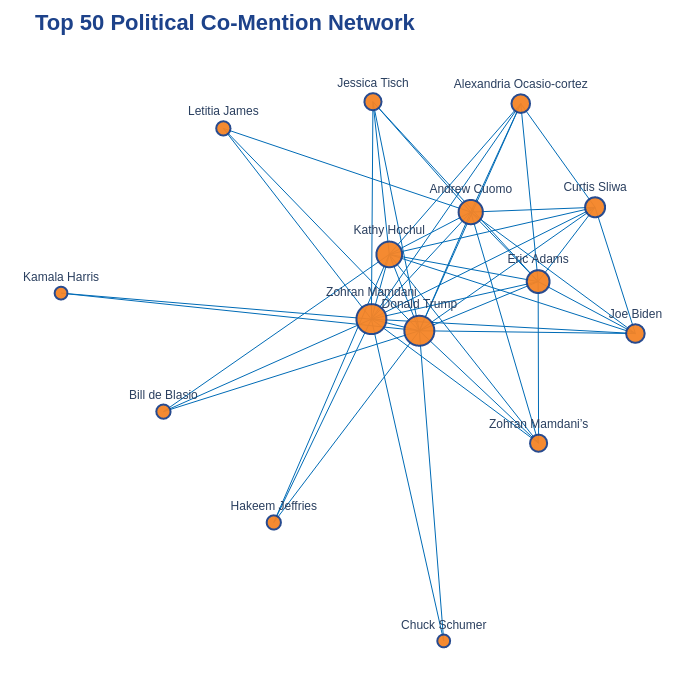

In [38]:
from IPython.display import Image
Image("network_graph_knicks.png")

 The connections in the graph reflect how the media tends to link these actors together when reporting on gentrification and issues affecting New York City. In the context of public policy, this suggests that these individuals are perceived as key stakeholders whose actions and positions shape the debate around this topic.

# **Conclusion**

The city’s neighborhoods are constantly evolving, but the current wave of change is marked by unprecedented rent increases, upscale development in formerly overlooked areas, and heightened risk of displacement for low- and middle-income New Yorkers.

At the same time, resistance has also grown. From local residents who successfully beat back projects deemed “megaprojects for the rich,” to elected officials like Zohran Mamdani pushing for stronger tenant rights, the fight against displacement is shaping city policy and politics.

In a city as dynamic as New York, the challenge moving forward will be balancing growth and investment with inclusivity and equity, ensuring that longtime New Yorkers can remain and thrive in the communities they built, even as those communities change.

The debate continues on how best to achieve that balance, but it’s clear that gentrification’s has negative impacts, and the responses to it are goind to involve the key actors we analyse, that's is the people who will define **the next chapter of New York City’s urban story.**

📍 [LINK TO FINAL PROJECT IN GITHUB PORTFOLIO](https://github.com/Anana2314/Anana2314.github.io/blob/main/Final_project_Montanez_Ana.ipynb)